# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

In [17]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [6]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [7]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

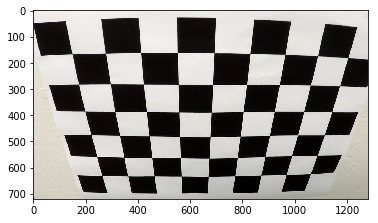

In [8]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [9]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [11]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [274]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

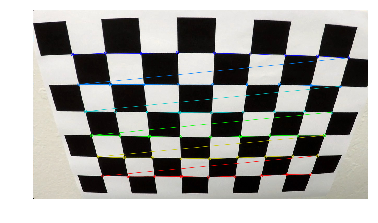

In [275]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [20]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [21]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [22]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

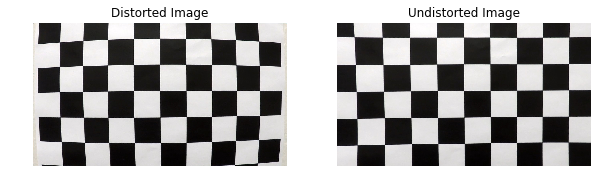

In [33]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

We can see that the undistortion step indeed works well. Let's apply the undistortion step to our test images.

#### Undistorting Test Images

In [34]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [37]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [38]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [39]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

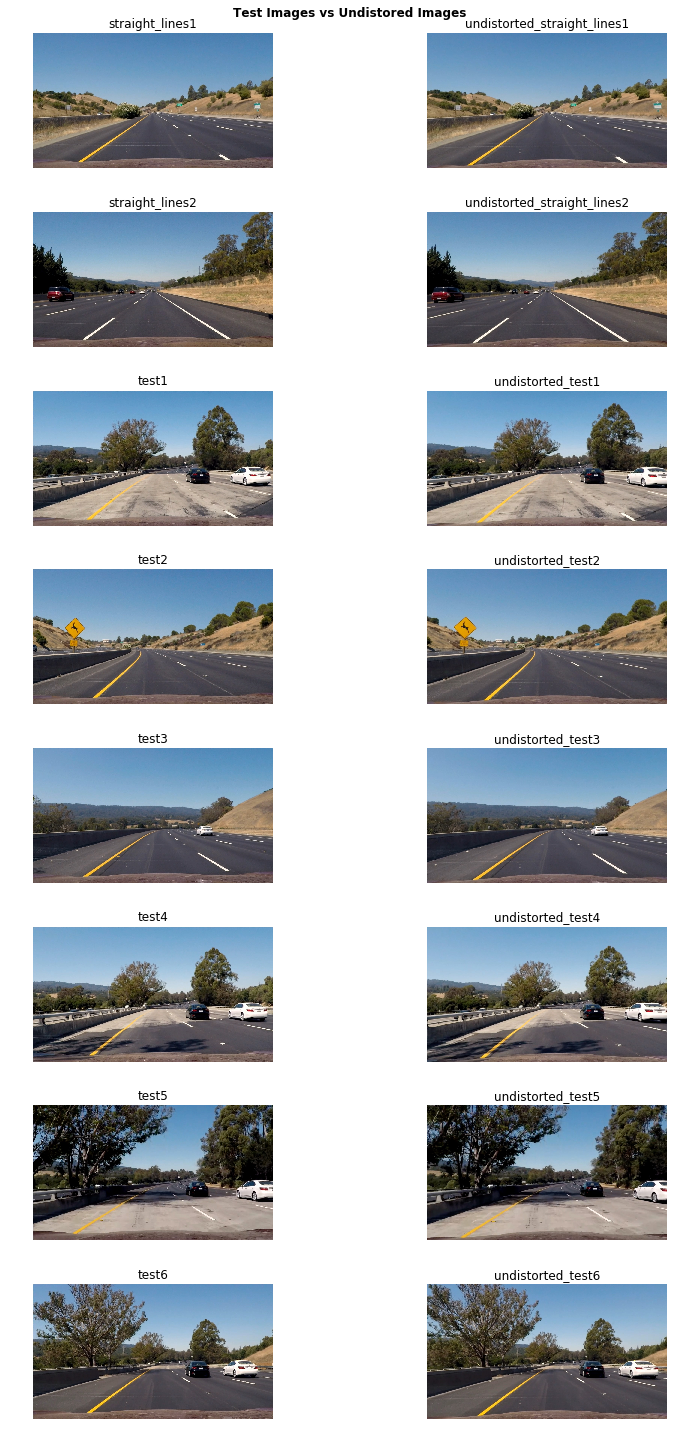

In [45]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images. We can see that on the undistorted images, the front of the car, especially at the sides, is less visible.

## Thresholding

We apply color and edge  thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later. 

We start with first exploring which color spaces we should adopt to increase our chances of detecting the lanes and facilitating the task of the gradient thresholding step.

In [49]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [55]:
test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [56]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [57]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [58]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [60]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [61]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

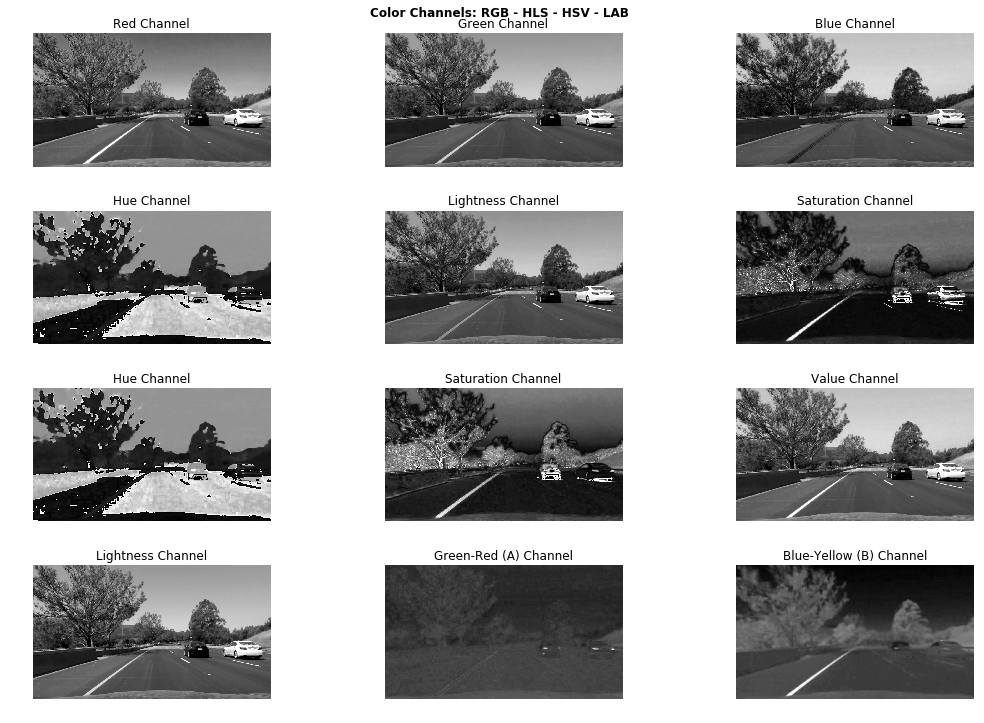

In [66]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

On the RGB components, we see that the blue channel is worst at identifying yellow lines, while the red channel seems to give best results.

For HLS and HSV, the hue channel produces an extremely noisy output, while the saturation channel of HLS seems to give the strong results; better than HSV's saturation channel. conversely, HSV's value channel is giving a very clear grayscale-ish image, especially on the yellow line, much better than HLS' lightness channel.

Lastly, LAB's A channel is not doing a great job, while it's B channel is strong at identifying the yellow line. But it is the lightness channel that shines (no pun intended) at identify both yellow and white lines.

At this stage, we are faced with various choices that have pros and cons. Our goal here is to find the right thresholds on a given color channel to highlight yellow and white lines of the lane. There are actually many ways we could achieve this result, but **we choose to use HLS because we already know how to set thresholds for yellow and white lane lines from [Project 1](https://github.com/kenshiro-o/CarND-LaneLines-P1)** .

In [73]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

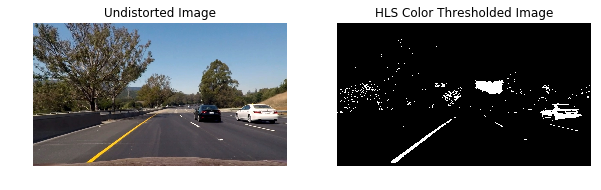

In [75]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

As you can see above, our HLS color thresholding achieve great results on the image. The thresholding somewhat struggles a little with the shadow of the tree on the yellow line further up ahead. We believe gradient thresholding can help in this case.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

We have decided to use LAB's L channel as our single-channel image to serve as input to the sobel functions below.

In [87]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [83]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [84]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [85]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

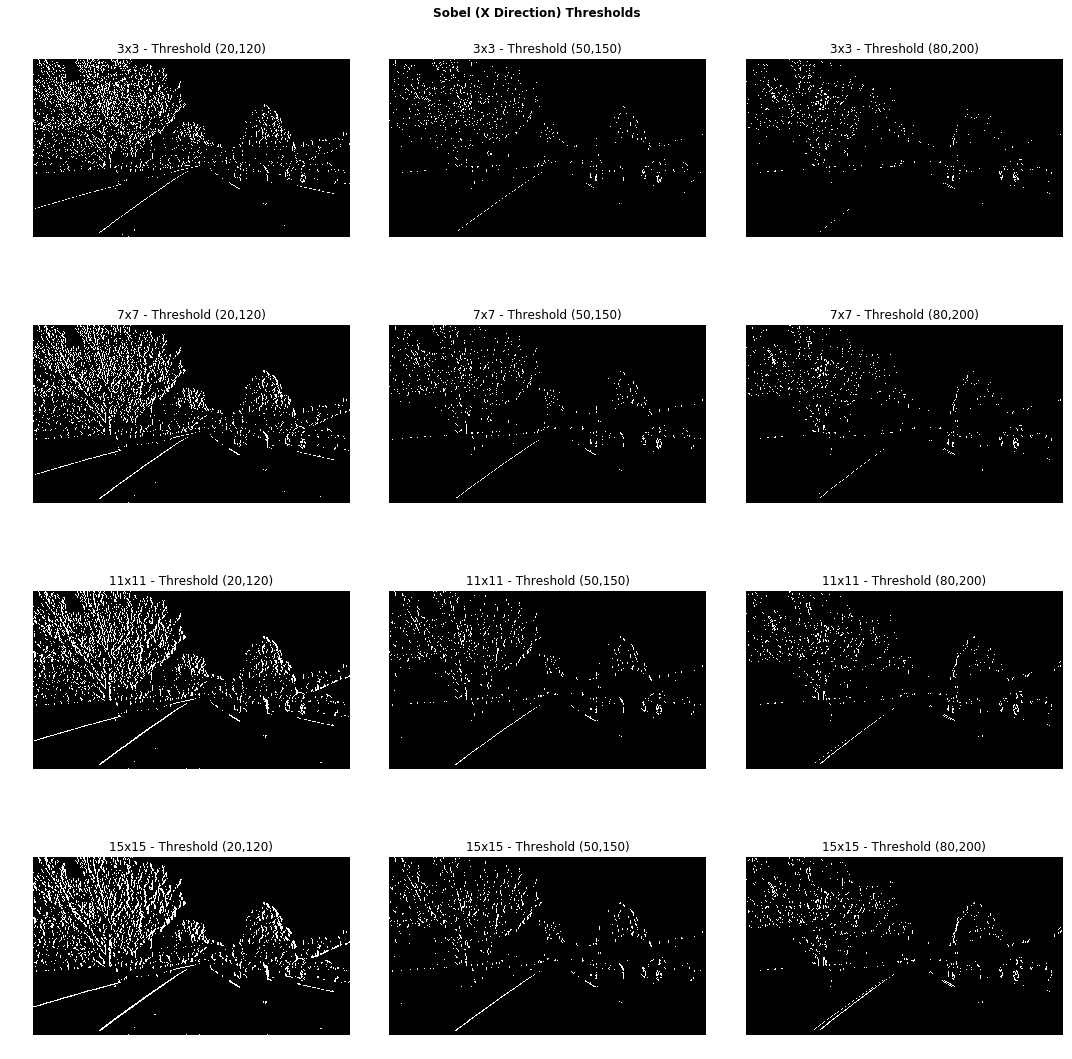

In [86]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [88]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [89]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [90]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

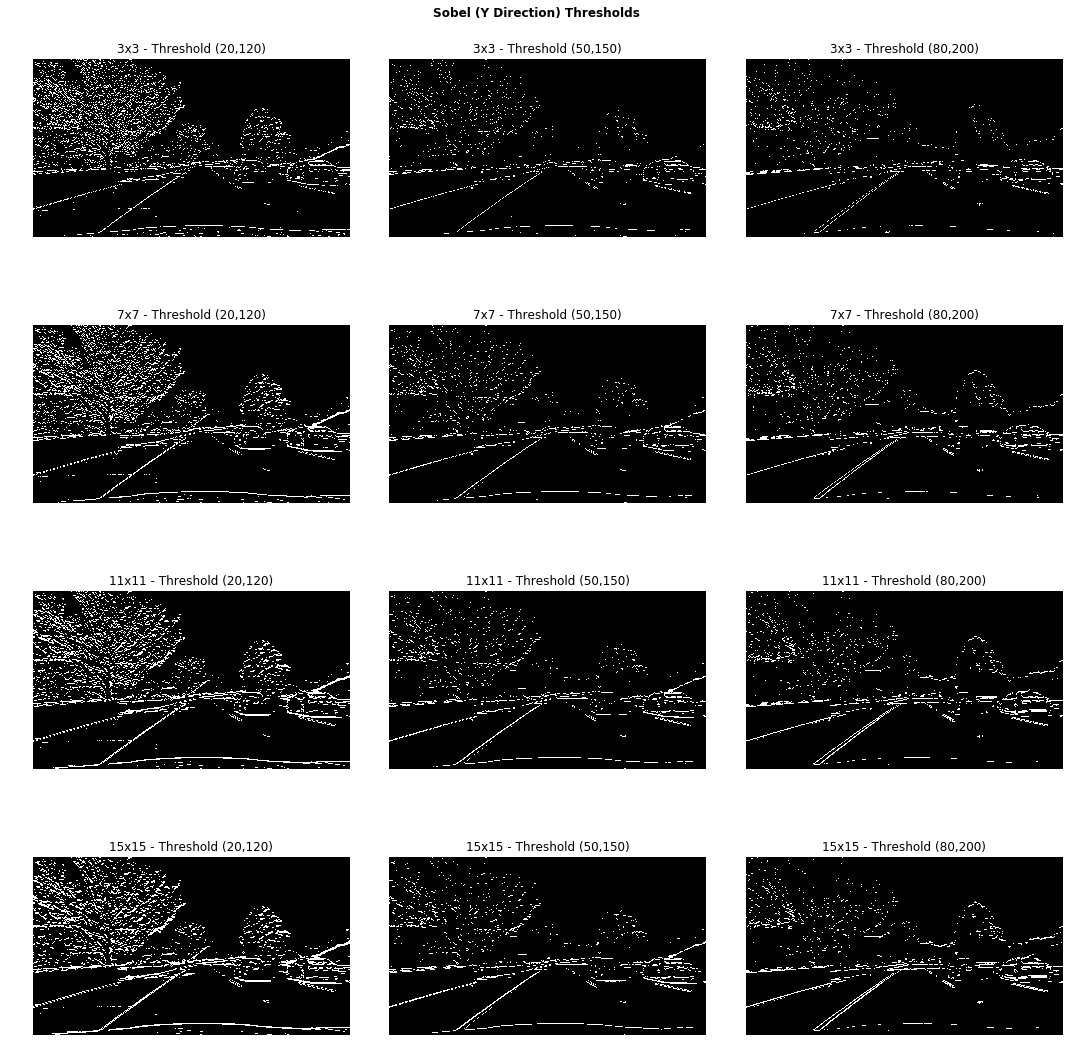

In [91]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [92]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [93]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [94]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [95]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


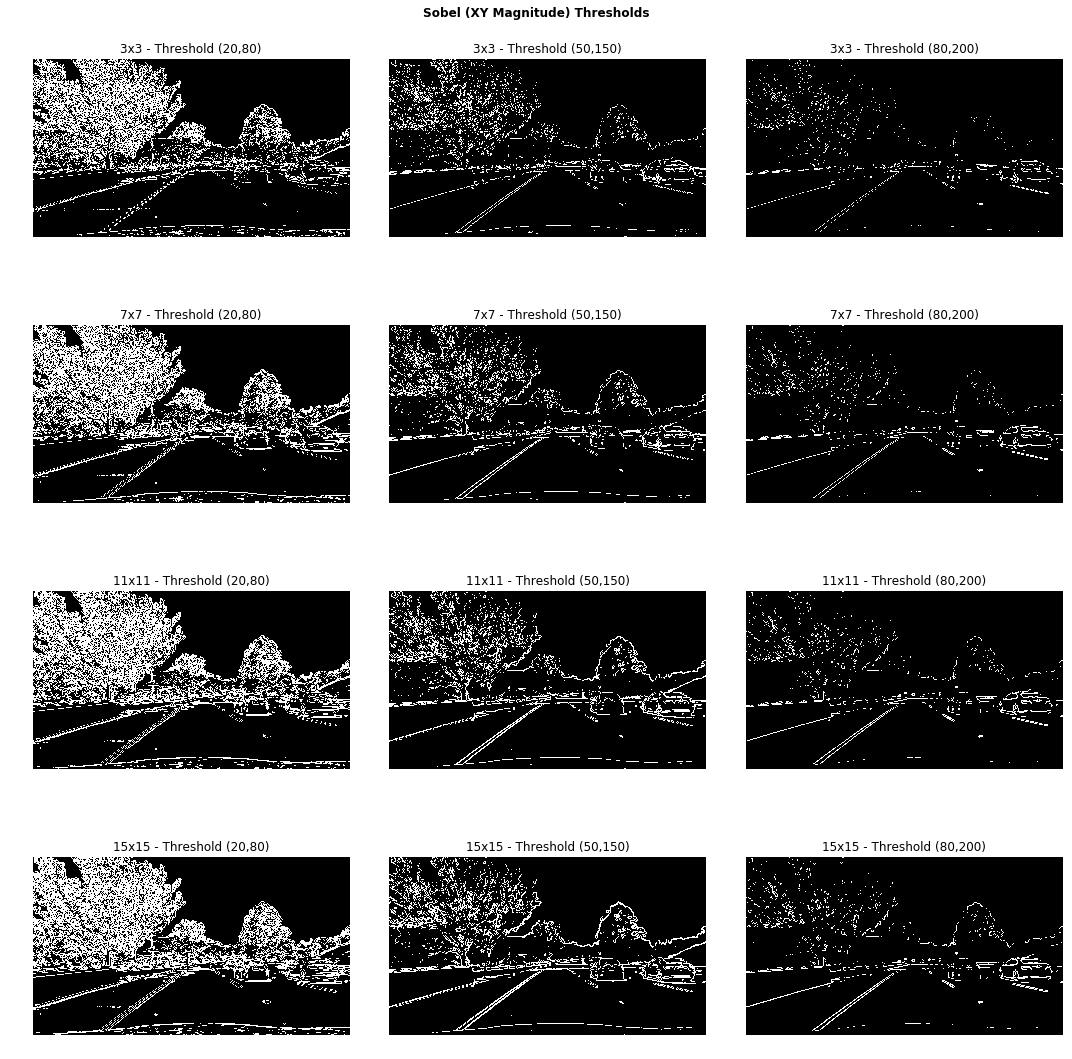

In [96]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [97]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [98]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [100]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [101]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [102]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [103]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

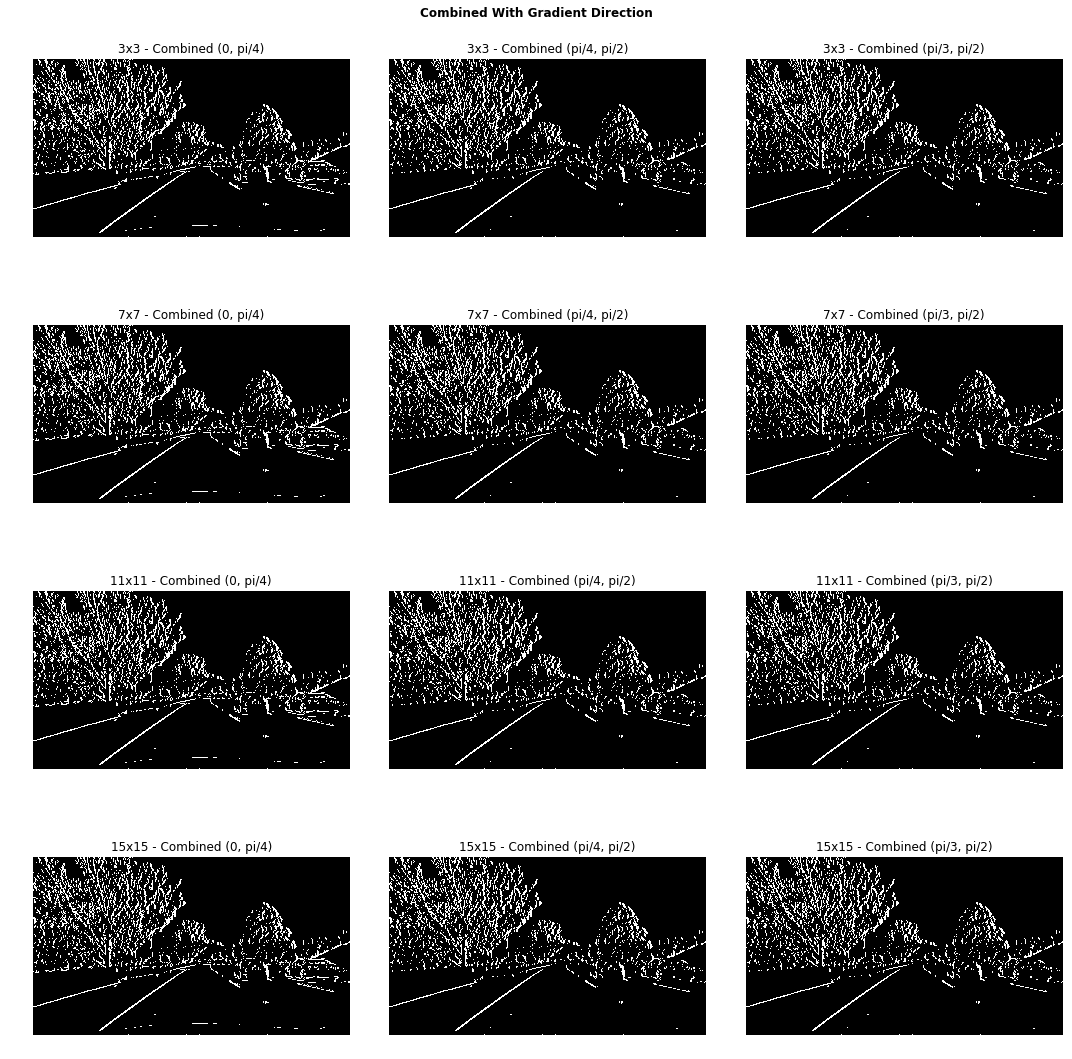

In [104]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [105]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. We should next combine it with the results we obtained from our HLS' color thresholding method.

### Combining Color And Gradient (Sobel) Thresholds

In [106]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [108]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [109]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

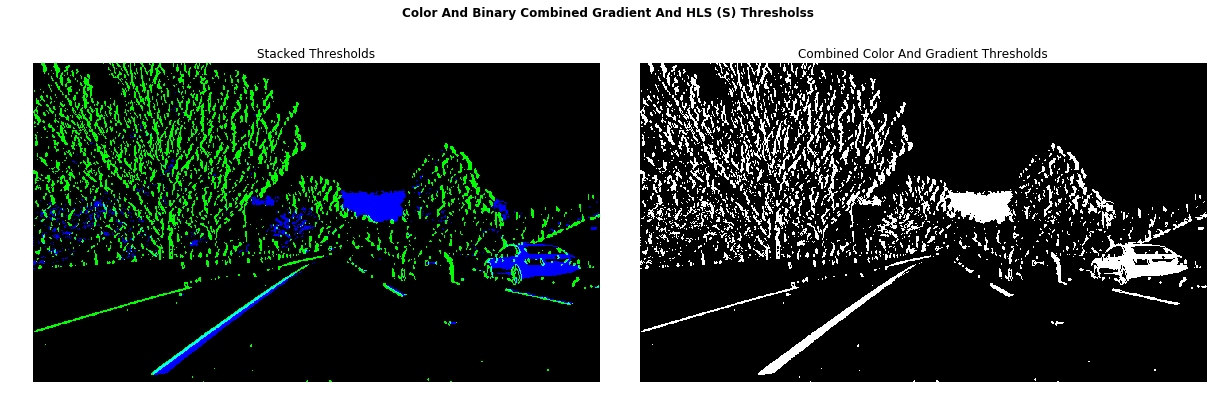

In [111]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

The results are very encouraging and it seems we have found the right parameters to detect lanes in a robust manner. We turn next to applying a perspective transform to our image and produce a _bird's eye view_ of the lane.

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

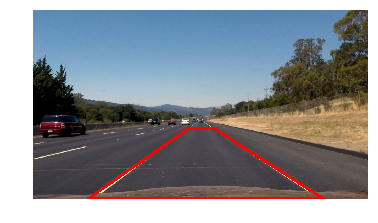

In [276]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [113]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [114]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [136]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [120]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

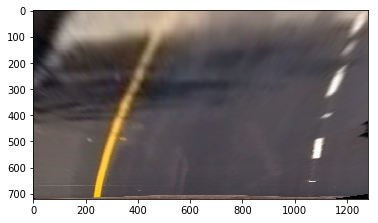

In [121]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [137]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

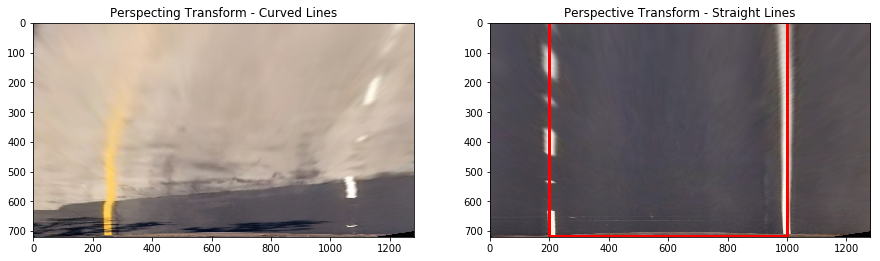

In [140]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

We can see that our perspective transform keeps straight lines straight, which is a required sanity check. The curved lines however are not perfect on the example above, but they should not cause unsurmountable problems for our algorithm either. 

In [141]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

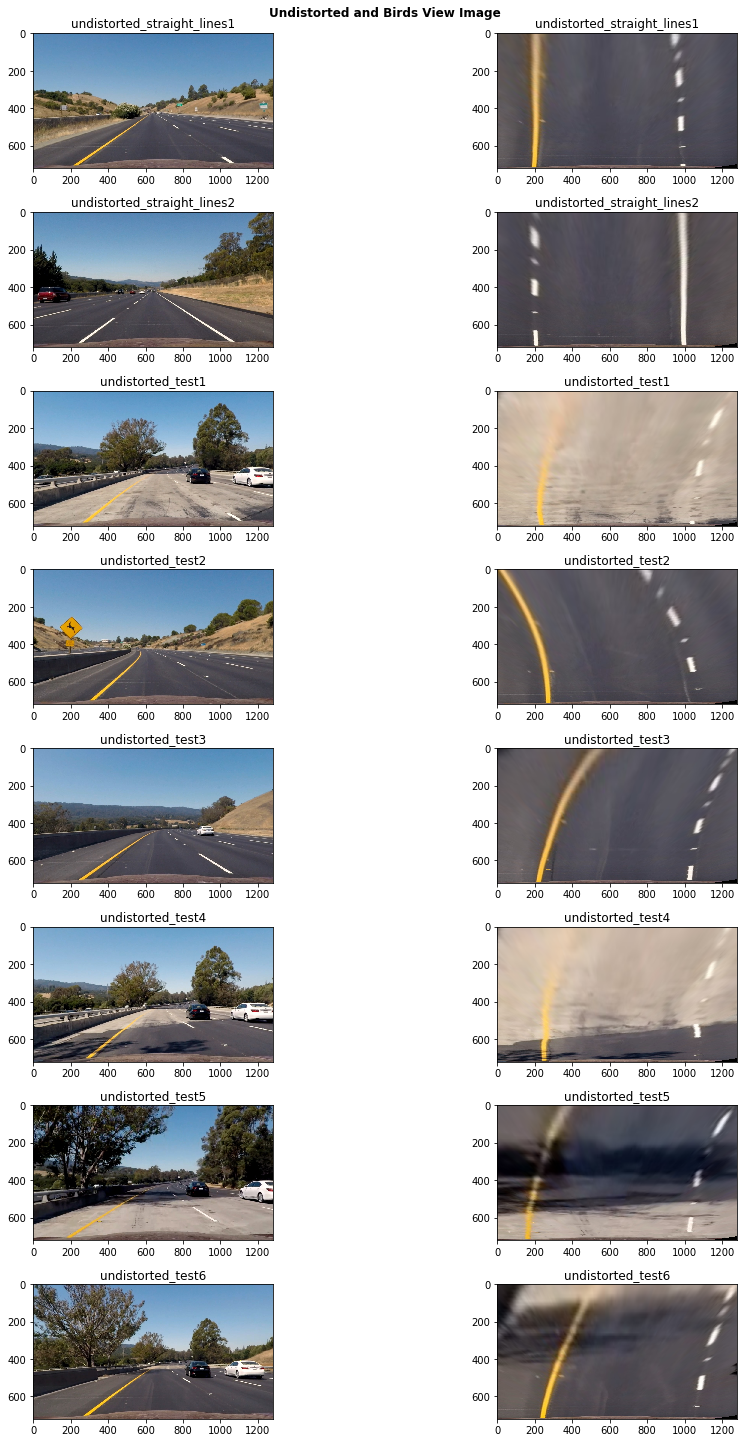

In [142]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

### Putting It All Together

In [149]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [150]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [151]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [152]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [153]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

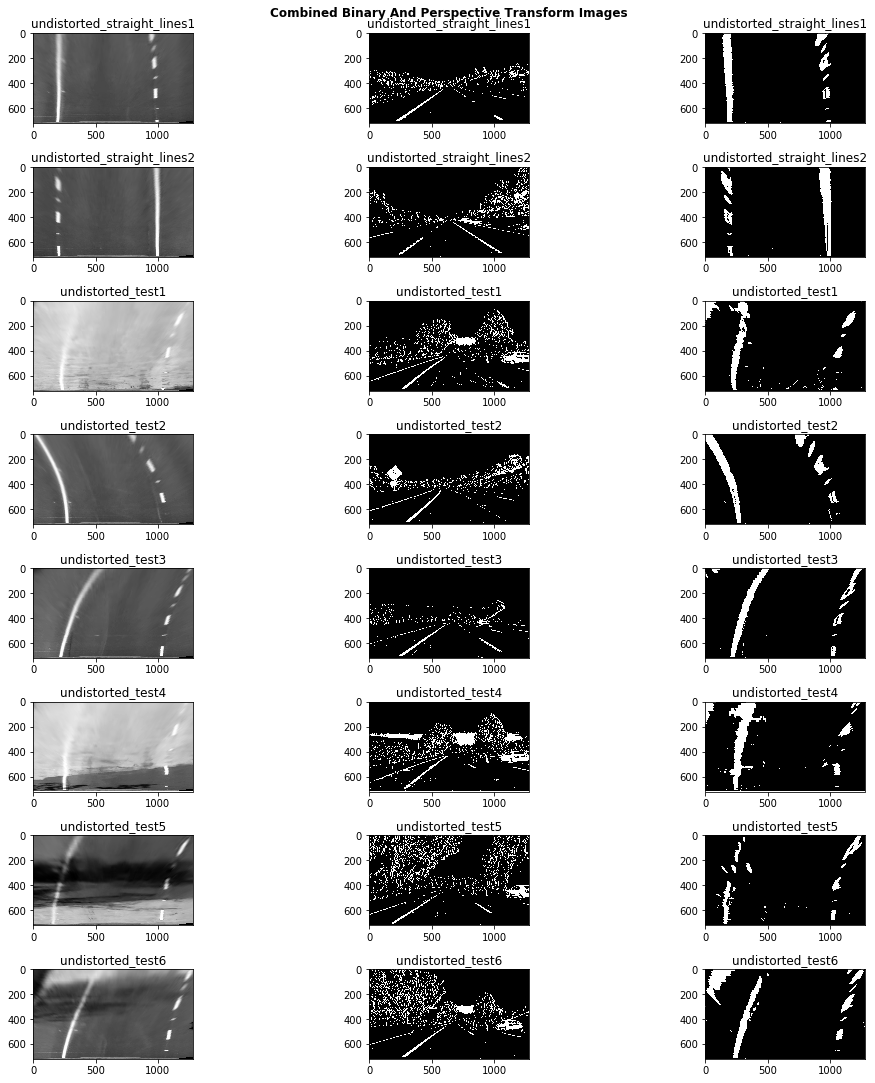

In [154]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

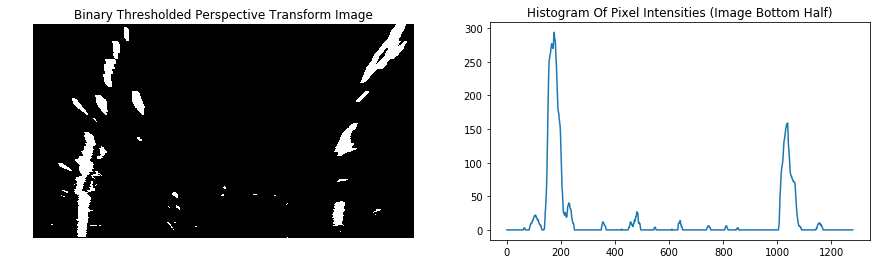

In [288]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Pipeline Definition

Let's now define our full pipeline for lane detection on video frames. We will use Python classes to encapsulate a information and use it across frames. 

In [156]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [157]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [158]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [247]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [290]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [291]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=31969.399992249462
Left Curvature   Right Curvature  Center Alignment 
979.6942m        2539.3740m       0.1707m Right    


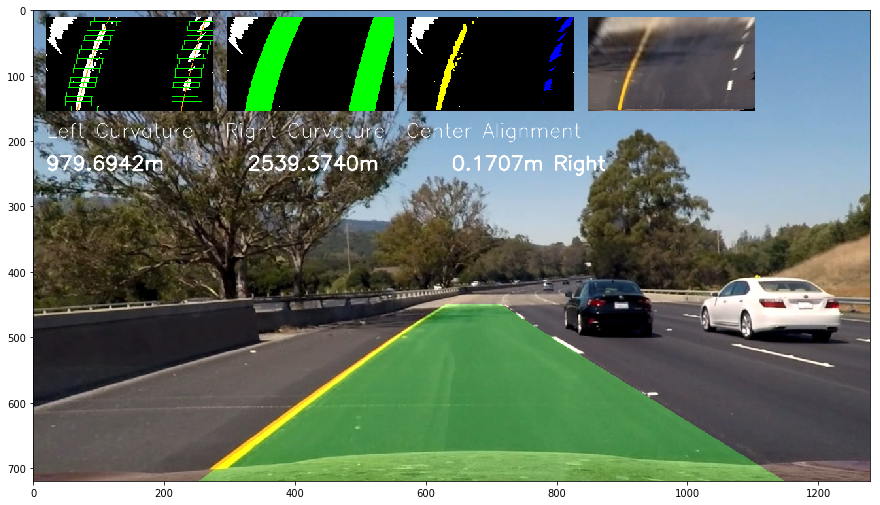

In [292]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

In [ ]:
#(720, 1280, 3)

# Normal video

In [163]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [261]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [253]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i project_video.mp4 -ss 22.00 -t 5.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [254]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=14741.188848600132
Left Curvature   Right Curvature  Center Alignment 
1477.3488m       3308.5374m       0.0996m Right    
[MoviePy] >>>> Building video output_videos/lanes_project_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_project_video_sample.mp4



  1%|          | 1/125 [00:01<02:15,  1.09s/it]

[Previous lane] Found pct=0.9075373001248291
Left Curvature   Right Curvature  Center Alignment 
1328.0771m       3543.9619m       0.1016m Right    



  2%|▏         | 2/125 [00:02<02:09,  1.05s/it]

[Previous lane] Found pct=0.908963918444986
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3626.2028m       0.1023m Right    



  2%|▏         | 3/125 [00:02<02:03,  1.01s/it]

[Previous lane] Found pct=0.9093205730250252
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3640.0651m       0.1024m Right    



  3%|▎         | 4/125 [00:03<02:03,  1.02s/it]

[Previous lane] Found pct=0.9093800154550318
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3642.5951m       0.1024m Right    



  4%|▍         | 5/125 [00:04<01:59,  1.01it/s]

[Previous lane] Found pct=0.9094097366700351
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3643.1408m       0.1024m Right    



  5%|▍         | 6/125 [00:05<01:56,  1.02it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



  6%|▌         | 7/125 [00:06<01:54,  1.03it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



  6%|▋         | 8/125 [00:07<01:52,  1.04it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



  7%|▋         | 9/125 [00:08<01:51,  1.04it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



  8%|▊         | 10/125 [00:09<01:49,  1.05it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



  9%|▉         | 11/125 [00:10<01:47,  1.07it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 10%|▉         | 12/125 [00:11<01:45,  1.08it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 10%|█         | 13/125 [00:12<01:44,  1.07it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 11%|█         | 14/125 [00:13<01:42,  1.08it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 12%|█▏        | 15/125 [00:14<01:41,  1.09it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 13%|█▎        | 16/125 [00:15<01:39,  1.09it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 14%|█▎        | 17/125 [00:16<01:38,  1.10it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 14%|█▍        | 18/125 [00:16<01:37,  1.10it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 15%|█▌        | 19/125 [00:17<01:36,  1.10it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 16%|█▌        | 20/125 [00:18<01:34,  1.11it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 17%|█▋        | 21/125 [00:19<01:34,  1.11it/s]

[Previous lane] Found pct=0.9094394578850383
Left Curvature   Right Curvature  Center Alignment 
1330.5244m       3645.2612m       0.1024m Right    



 18%|█▊        | 22/125 [00:20<01:35,  1.08it/s]

[Previous lane] Found pct=0.8828133895024479
Left Curvature   Right Curvature  Center Alignment 
1147.9470m       2885.0469m       0.1011m Right    



 18%|█▊        | 23/125 [00:21<01:34,  1.08it/s]

[Previous lane] Found pct=0.888323120738759
Left Curvature   Right Curvature  Center Alignment 
1146.0944m       3055.6630m       0.1035m Right    



 19%|█▉        | 24/125 [00:22<01:32,  1.09it/s]

[Previous lane] Found pct=0.8846430245274176
Left Curvature   Right Curvature  Center Alignment 
1009.7096m       3260.3717m       0.1140m Right    



 20%|██        | 25/125 [00:23<01:32,  1.08it/s]

[Previous lane] Found pct=0.8692007466485661
Left Curvature   Right Curvature  Center Alignment 
821.4689m        2920.8371m       0.1161m Right    



 21%|██        | 26/125 [00:24<01:30,  1.09it/s]

[Previous lane] Found pct=0.8664505887022093
Left Curvature   Right Curvature  Center Alignment 
841.2780m        2536.5673m       0.1323m Right    



 22%|██▏       | 27/125 [00:25<01:31,  1.07it/s]

[Previous lane] Found pct=0.8927960526315789
Left Curvature   Right Curvature  Center Alignment 
1253.7871m       2923.5186m       0.1799m Right    



 22%|██▏       | 28/125 [00:26<01:31,  1.06it/s]

[Previous lane] Found pct=0.8915793531205102
Left Curvature   Right Curvature  Center Alignment 
1338.1354m       970.7405m        0.2090m Right    



 23%|██▎       | 29/125 [00:27<01:29,  1.07it/s]

[Previous lane] Found pct=0.8931126239762243
Left Curvature   Right Curvature  Center Alignment 
1685.3279m       781.2032m        0.2119m Right    



 24%|██▍       | 30/125 [00:28<01:27,  1.09it/s]

[Previous lane] Found pct=0.8835093622456928
Left Curvature   Right Curvature  Center Alignment 
2534.4249m       844.6233m        0.2109m Right    



 25%|██▍       | 31/125 [00:28<01:25,  1.10it/s]

[Previous lane] Found pct=0.9037594452563823
Left Curvature   Right Curvature  Center Alignment 
3386.4816m       751.2319m        0.2190m Right    



 26%|██▌       | 32/125 [00:29<01:24,  1.10it/s]

[Previous lane] Found pct=0.889308426073132
Left Curvature   Right Curvature  Center Alignment 
1775.8237m       834.6168m        0.1937m Right    



 26%|██▋       | 33/125 [00:30<01:24,  1.09it/s]

[Previous lane] Found pct=0.8934578817897746
Left Curvature   Right Curvature  Center Alignment 
1021.7833m       846.9775m        0.1647m Right    



 27%|██▋       | 34/125 [00:31<01:23,  1.10it/s]

[Previous lane] Found pct=0.9078019367805591
Left Curvature   Right Curvature  Center Alignment 
638.2218m        837.1995m        0.1378m Right    



 28%|██▊       | 35/125 [00:32<01:21,  1.10it/s]

[Previous lane] Found pct=0.9022932928092837
Left Curvature   Right Curvature  Center Alignment 
742.9740m        807.6322m        0.1298m Right    



 29%|██▉       | 36/125 [00:33<01:20,  1.10it/s]

[Previous lane] Found pct=0.8949238943136129
Left Curvature   Right Curvature  Center Alignment 
708.1702m        774.3229m        0.1376m Right    



 30%|██▉       | 37/125 [00:34<01:21,  1.09it/s]

[Previous lane] Found pct=0.9054439219039475
Left Curvature   Right Curvature  Center Alignment 
597.4156m        699.0952m        0.1280m Right    



 30%|███       | 38/125 [00:35<01:20,  1.08it/s]

[Previous lane] Found pct=0.8877874104787034
Left Curvature   Right Curvature  Center Alignment 
488.8694m        933.5556m        0.1183m Right    



 31%|███       | 39/125 [00:36<01:19,  1.08it/s]

[Previous lane] Found pct=0.8919122919575802
Left Curvature   Right Curvature  Center Alignment 
558.2510m        1713.6742m       0.1012m Right    



 32%|███▏      | 40/125 [00:37<01:18,  1.09it/s]

[Previous lane] Found pct=0.9075273620728166
Left Curvature   Right Curvature  Center Alignment 
623.8197m        418.2879m        0.1739m Right    



 33%|███▎      | 41/125 [00:38<01:17,  1.08it/s]

[Previous lane] Found pct=0.9040222428174235
Left Curvature   Right Curvature  Center Alignment 
499.7926m        393.8586m        0.1520m Right    



 34%|███▎      | 42/125 [00:39<01:16,  1.08it/s]

[Previous lane] Found pct=0.8733780929390464
Left Curvature   Right Curvature  Center Alignment 
427.5671m        340.5008m        0.1392m Right    



 34%|███▍      | 43/125 [00:40<01:17,  1.06it/s]

[Previous lane] Found pct=0.8303008336353751
Non zeros found below thresholds, begining sliding window - pct=0.8303008336353751
[Sliding windows] Found pct=11598.771148967016
Left Curvature   Right Curvature  Center Alignment 
406.7711m        6434.3829m       0.0420m Right    



 35%|███▌      | 44/125 [00:40<01:15,  1.07it/s]

[Previous lane] Found pct=0.8438333748354736
Non zeros found below thresholds, begining sliding window - pct=0.8438333748354736
[Sliding windows] Found pct=11711.629362171392
Left Curvature   Right Curvature  Center Alignment 
4408.3533m       5458.8896m       0.0554m Right    



 36%|███▌      | 45/125 [00:41<01:14,  1.08it/s]

[Previous lane] Found pct=0.8906205923836389
Left Curvature   Right Curvature  Center Alignment 
2484.4133m       2555.4419m       0.0576m Right    



 37%|███▋      | 46/125 [00:42<01:12,  1.09it/s]

[Previous lane] Found pct=0.876981156637485
Left Curvature   Right Curvature  Center Alignment 
2647.1590m       2512.4536m       0.0580m Right    



 38%|███▊      | 47/125 [00:43<01:11,  1.09it/s]

[Previous lane] Found pct=0.9096191091026469
Left Curvature   Right Curvature  Center Alignment 
4022.1382m       1972.0154m       0.0646m Right    



 38%|███▊      | 48/125 [00:44<01:10,  1.09it/s]

[Previous lane] Found pct=0.8834241897801474
Left Curvature   Right Curvature  Center Alignment 
3549.0093m       1515.2231m       0.0591m Right    



 39%|███▉      | 49/125 [00:45<01:10,  1.07it/s]

[Previous lane] Found pct=0.8655684416407261
Left Curvature   Right Curvature  Center Alignment 
3527.4355m       978.0477m        0.0645m Right    



 40%|████      | 50/125 [00:46<01:10,  1.07it/s]

[Previous lane] Found pct=0.9058994599085999
Left Curvature   Right Curvature  Center Alignment 
7231.9803m       617.5560m        0.1013m Right    



 41%|████      | 51/125 [00:47<01:08,  1.08it/s]

[Previous lane] Found pct=0.8547645009441238
Left Curvature   Right Curvature  Center Alignment 
3473.9344m       522.3488m        0.1295m Right    



 42%|████▏     | 52/125 [00:48<01:07,  1.08it/s]

[Previous lane] Found pct=0.9001969796454367
Left Curvature   Right Curvature  Center Alignment 
4815.5942m       458.2880m        0.1512m Right    



 42%|████▏     | 53/125 [00:49<01:06,  1.08it/s]

[Previous lane] Found pct=0.9048614445919607
Left Curvature   Right Curvature  Center Alignment 
16191.3671m      431.5802m        0.1460m Right    



 43%|████▎     | 54/125 [00:50<01:05,  1.09it/s]

[Previous lane] Found pct=0.895652880034647
Left Curvature   Right Curvature  Center Alignment 
1420.7771m       368.1112m        0.1586m Right    



 44%|████▍     | 55/125 [00:51<01:04,  1.09it/s]

[Previous lane] Found pct=0.8471222032873399
Non zeros found below thresholds, begining sliding window - pct=0.8471222032873399
[Sliding windows] Found pct=16477.144329613544
Left Curvature   Right Curvature  Center Alignment 
686.1334m        527.5873m        0.1131m Right    



 45%|████▍     | 56/125 [00:52<01:03,  1.08it/s]

[Previous lane] Found pct=0.9159079622579043
Left Curvature   Right Curvature  Center Alignment 
615.6480m        448.9111m        0.0977m Right    



 46%|████▌     | 57/125 [00:52<01:02,  1.09it/s]

[Previous lane] Found pct=0.9536962272031185
Left Curvature   Right Curvature  Center Alignment 
528.0391m        389.0968m        0.0836m Right    



 46%|████▋     | 58/125 [00:53<01:02,  1.07it/s]

[Previous lane] Found pct=0.9165422821555407
Left Curvature   Right Curvature  Center Alignment 
522.5233m        425.6677m        0.0612m Right    



 47%|████▋     | 59/125 [00:54<01:01,  1.07it/s]

[Previous lane] Found pct=0.9170338286909118
Left Curvature   Right Curvature  Center Alignment 
535.9215m        423.9381m        0.0440m Right    



 48%|████▊     | 60/125 [00:55<01:00,  1.08it/s]

[Previous lane] Found pct=0.9142058275286962
Left Curvature   Right Curvature  Center Alignment 
521.3072m        416.6142m        0.0309m Right    



 49%|████▉     | 61/125 [00:56<00:59,  1.08it/s]

[Previous lane] Found pct=0.9138354778082984
Left Curvature   Right Curvature  Center Alignment 
520.3507m        440.1913m        0.0112m Right    



 50%|████▉     | 62/125 [00:57<00:58,  1.08it/s]

[Previous lane] Found pct=0.905130517561
Left Curvature   Right Curvature  Center Alignment 
410.8879m        541.2357m        0.0166m Left     



 50%|█████     | 63/125 [00:58<00:57,  1.08it/s]

[Previous lane] Found pct=0.907046511627907
Left Curvature   Right Curvature  Center Alignment 
338.4271m        750.1429m        0.0668m Left     



 51%|█████     | 64/125 [00:59<00:56,  1.07it/s]

[Previous lane] Found pct=0.9214490342851862
Left Curvature   Right Curvature  Center Alignment 
327.4003m        760.6460m        0.0835m Left     



 52%|█████▏    | 65/125 [01:00<00:55,  1.08it/s]

[Previous lane] Found pct=0.91947336870851
Left Curvature   Right Curvature  Center Alignment 
331.2122m        847.3673m        0.0946m Left     



 53%|█████▎    | 66/125 [01:01<00:55,  1.07it/s]

[Previous lane] Found pct=0.9248326754762314
Left Curvature   Right Curvature  Center Alignment 
333.2668m        653.1682m        0.0879m Left     



 54%|█████▎    | 67/125 [01:02<00:54,  1.07it/s]

[Previous lane] Found pct=0.9121635462329468
Left Curvature   Right Curvature  Center Alignment 
326.9853m        527.5093m        0.0811m Left     



 54%|█████▍    | 68/125 [01:03<00:54,  1.05it/s]

[Previous lane] Found pct=0.9336238757503899
Left Curvature   Right Curvature  Center Alignment 
330.0928m        534.6056m        0.0849m Left     



 55%|█████▌    | 69/125 [01:04<00:53,  1.05it/s]

[Previous lane] Found pct=0.8979788679907055
Left Curvature   Right Curvature  Center Alignment 
327.3642m        473.7021m        0.0865m Left     



 56%|█████▌    | 70/125 [01:05<00:52,  1.04it/s]

[Previous lane] Found pct=0.9423255212263643
Left Curvature   Right Curvature  Center Alignment 
319.5248m        487.7444m        0.0846m Left     



 57%|█████▋    | 71/125 [01:06<00:51,  1.05it/s]

[Previous lane] Found pct=0.9469401522018678
Left Curvature   Right Curvature  Center Alignment 
320.6384m        459.2683m        0.0837m Left     



 58%|█████▊    | 72/125 [01:07<00:49,  1.06it/s]

[Previous lane] Found pct=0.9685929126334594
Left Curvature   Right Curvature  Center Alignment 
345.6541m        527.6872m        0.0863m Left     



 58%|█████▊    | 73/125 [01:07<00:48,  1.07it/s]

[Previous lane] Found pct=0.9625127075567604
Left Curvature   Right Curvature  Center Alignment 
365.4547m        562.1447m        0.0786m Left     



 59%|█████▉    | 74/125 [01:08<00:48,  1.05it/s]

[Previous lane] Found pct=0.9635990561198318
Left Curvature   Right Curvature  Center Alignment 
367.1511m        604.7711m        0.0755m Left     



 60%|██████    | 75/125 [01:09<00:47,  1.04it/s]

[Previous lane] Found pct=0.7374615863578846
Non zeros found below thresholds, begining sliding window - pct=0.7374615863578846
[Sliding windows] Found pct=22940.91550003013
Left Curvature   Right Curvature  Center Alignment 
317.9736m        425.4028m        0.0441m Left     



 61%|██████    | 76/125 [01:10<00:46,  1.05it/s]

[Previous lane] Found pct=0.8605004973765823
Left Curvature   Right Curvature  Center Alignment 
319.7917m        424.9762m        0.0304m Left     



 62%|██████▏   | 77/125 [01:11<00:45,  1.04it/s]

[Previous lane] Found pct=0.8907224055738907
Left Curvature   Right Curvature  Center Alignment 
317.9623m        413.4556m        0.0212m Left     



 62%|██████▏   | 78/125 [01:12<00:45,  1.04it/s]

[Previous lane] Found pct=0.8467026573319852
Non zeros found below thresholds, begining sliding window - pct=0.8467026573319852
[Sliding windows] Found pct=23281.32445012495
Left Curvature   Right Curvature  Center Alignment 
338.0646m        342.4079m        0.0078m Right    



 63%|██████▎   | 79/125 [01:13<00:43,  1.05it/s]

[Previous lane] Found pct=0.8167425948229216
Non zeros found below thresholds, begining sliding window - pct=0.8167425948229216
[Sliding windows] Found pct=25268.693756436438
Left Curvature   Right Curvature  Center Alignment 
382.7788m        319.9119m        0.0540m Right    



 64%|██████▍   | 80/125 [01:14<00:43,  1.04it/s]

[Previous lane] Found pct=0.7947317147714466
Non zeros found below thresholds, begining sliding window - pct=0.7947317147714466
[Sliding windows] Found pct=25051.737025080703
Left Curvature   Right Curvature  Center Alignment 
462.9126m        425.9751m        0.0384m Right    



 65%|██████▍   | 81/125 [01:15<00:41,  1.05it/s]

[Previous lane] Found pct=0.8972149759341588
Left Curvature   Right Curvature  Center Alignment 
523.4896m        599.4883m        0.0006m Right    



 66%|██████▌   | 82/125 [01:16<00:41,  1.04it/s]

[Previous lane] Found pct=0.9196823078327552
Left Curvature   Right Curvature  Center Alignment 
549.5944m        790.5529m        0.0125m Left     



 66%|██████▋   | 83/125 [01:17<00:39,  1.05it/s]

[Previous lane] Found pct=0.985929648241206
Left Curvature   Right Curvature  Center Alignment 
666.6851m        809.3414m        0.0243m Left     



 67%|██████▋   | 84/125 [01:18<00:38,  1.06it/s]

[Previous lane] Found pct=0.9631249780401251
Left Curvature   Right Curvature  Center Alignment 
624.2315m        483.6138m        0.0040m Right    



 68%|██████▊   | 85/125 [01:19<00:38,  1.05it/s]

[Previous lane] Found pct=0.8671968051565894
Left Curvature   Right Curvature  Center Alignment 
724.3217m        459.7950m        0.0121m Left     



 69%|██████▉   | 86/125 [01:20<00:37,  1.04it/s]

[Previous lane] Found pct=0.7623175182481752
Non zeros found below thresholds, begining sliding window - pct=0.7623175182481752
[Sliding windows] Found pct=27044.70556231414
Left Curvature   Right Curvature  Center Alignment 
567.6395m        379.0808m        0.0110m Right    



 70%|██████▉   | 87/125 [01:21<00:36,  1.05it/s]

[Previous lane] Found pct=0.7916499397832196
Non zeros found below thresholds, begining sliding window - pct=0.7916499397832196
[Sliding windows] Found pct=24858.72428013576
Left Curvature   Right Curvature  Center Alignment 
508.9261m        314.6972m        0.0272m Right    



 70%|███████   | 88/125 [01:22<00:35,  1.03it/s]

[Previous lane] Found pct=0.8836709369592953
Left Curvature   Right Curvature  Center Alignment 
576.3270m        324.7356m        0.0305m Right    



 71%|███████   | 89/125 [01:23<00:35,  1.02it/s]

[Previous lane] Found pct=0.920490052429961
Left Curvature   Right Curvature  Center Alignment 
583.5594m        348.4785m        0.0439m Right    



 72%|███████▏  | 90/125 [01:24<00:35,  1.01s/it]

[Previous lane] Found pct=0.8678682346372614
Left Curvature   Right Curvature  Center Alignment 
620.2214m        413.2945m        0.0509m Right    



 73%|███████▎  | 91/125 [01:25<00:34,  1.02s/it]

[Previous lane] Found pct=0.8024007386888273
Non zeros found below thresholds, begining sliding window - pct=0.8024007386888273
[Sliding windows] Found pct=28216.952069168135
Left Curvature   Right Curvature  Center Alignment 
1133.0628m       554.4023m        0.0491m Right    



 74%|███████▎  | 92/125 [01:26<00:33,  1.02s/it]

[Previous lane] Found pct=0.9896601421102025
Left Curvature   Right Curvature  Center Alignment 
1295.2001m       767.7402m        0.0240m Right    



 74%|███████▍  | 93/125 [01:27<00:32,  1.00s/it]

[Previous lane] Found pct=0.9822579029942918
Left Curvature   Right Curvature  Center Alignment 
1218.5246m       577.9334m        0.0591m Right    



 75%|███████▌  | 94/125 [01:28<00:30,  1.00it/s]

[Previous lane] Found pct=0.9670151187904967
Left Curvature   Right Curvature  Center Alignment 
1039.4238m       458.5888m        0.0867m Right    



 76%|███████▌  | 95/125 [01:29<00:29,  1.01it/s]

[Previous lane] Found pct=0.9855141539142425
Left Curvature   Right Curvature  Center Alignment 
841.6434m        440.0757m        0.1019m Right    



 77%|███████▋  | 96/125 [01:30<00:28,  1.02it/s]

[Previous lane] Found pct=0.9717055141995432
Left Curvature   Right Curvature  Center Alignment 
690.3669m        472.0021m        0.1047m Right    



 78%|███████▊  | 97/125 [01:31<00:27,  1.02it/s]

[Previous lane] Found pct=0.9841460026394387
Left Curvature   Right Curvature  Center Alignment 
631.6011m        511.4565m        0.1050m Right    



 78%|███████▊  | 98/125 [01:32<00:26,  1.03it/s]

[Previous lane] Found pct=0.9839379296263527
Left Curvature   Right Curvature  Center Alignment 
657.8638m        520.5323m        0.1089m Right    



 79%|███████▉  | 99/125 [01:33<00:24,  1.05it/s]

[Previous lane] Found pct=0.9517373568585049
Left Curvature   Right Curvature  Center Alignment 
639.6614m        531.7726m        0.1121m Right    



 80%|████████  | 100/125 [01:34<00:24,  1.04it/s]

[Previous lane] Found pct=0.9520216583365372
Left Curvature   Right Curvature  Center Alignment 
641.4274m        589.7819m        0.1152m Right    



 81%|████████  | 101/125 [01:35<00:23,  1.03it/s]

[Previous lane] Found pct=0.9302691666277022
Left Curvature   Right Curvature  Center Alignment 
608.1616m        556.8207m        0.1244m Right    



 82%|████████▏ | 102/125 [01:36<00:22,  1.04it/s]

[Previous lane] Found pct=0.9049830627979338
Left Curvature   Right Curvature  Center Alignment 
587.5065m        553.7162m        0.1278m Right    



 82%|████████▏ | 103/125 [01:37<00:21,  1.04it/s]

[Previous lane] Found pct=0.890399632521819
Left Curvature   Right Curvature  Center Alignment 
544.3262m        526.8402m        0.1342m Right    



 83%|████████▎ | 104/125 [01:38<00:19,  1.05it/s]

[Previous lane] Found pct=0.864126831032612
Left Curvature   Right Curvature  Center Alignment 
526.9017m        530.8545m        0.1365m Right    



 84%|████████▍ | 105/125 [01:39<00:19,  1.04it/s]

[Previous lane] Found pct=0.8241152007242482
Non zeros found below thresholds, begining sliding window - pct=0.8241152007242482
[Sliding windows] Found pct=32057.72839279147
Left Curvature   Right Curvature  Center Alignment 
504.5774m        534.2291m        0.1590m Right    



 85%|████████▍ | 106/125 [01:39<00:18,  1.05it/s]

[Previous lane] Found pct=0.8334883188600696
Non zeros found below thresholds, begining sliding window - pct=0.8334883188600696
[Sliding windows] Found pct=31765.012274853718
Left Curvature   Right Curvature  Center Alignment 
519.1410m        543.3137m        0.1598m Right    



 86%|████████▌ | 107/125 [01:40<00:17,  1.05it/s]

[Previous lane] Found pct=0.8257302585604472
Non zeros found below thresholds, begining sliding window - pct=0.8257302585604472
[Sliding windows] Found pct=32070.363088749127
Left Curvature   Right Curvature  Center Alignment 
505.2995m        545.9113m        0.1674m Right    



 86%|████████▋ | 108/125 [01:41<00:16,  1.05it/s]

[Previous lane] Found pct=0.7887817703768624
Non zeros found below thresholds, begining sliding window - pct=0.7887817703768624
[Sliding windows] Found pct=32054.24733247082
Left Curvature   Right Curvature  Center Alignment 
467.9285m        574.4093m        0.1602m Right    



 87%|████████▋ | 109/125 [01:42<00:15,  1.04it/s]

[Previous lane] Found pct=0.837865638989902
Non zeros found below thresholds, begining sliding window - pct=0.837865638989902
[Sliding windows] Found pct=31335.3453486519
Left Curvature   Right Curvature  Center Alignment 
491.7379m        590.1857m        0.1576m Right    



 88%|████████▊ | 110/125 [01:43<00:14,  1.05it/s]

[Previous lane] Found pct=0.8293526439118037
Non zeros found below thresholds, begining sliding window - pct=0.8293526439118037
[Sliding windows] Found pct=32124.604951864712
Left Curvature   Right Curvature  Center Alignment 
502.2418m        621.3657m        0.1547m Right    



 89%|████████▉ | 111/125 [01:44<00:13,  1.05it/s]

[Previous lane] Found pct=0.8856434527834122
Left Curvature   Right Curvature  Center Alignment 
531.8275m        688.7801m        0.1433m Right    



 90%|████████▉ | 112/125 [01:45<00:12,  1.05it/s]

[Previous lane] Found pct=0.9273078873953843
Left Curvature   Right Curvature  Center Alignment 
546.1481m        738.2568m        0.1442m Right    



 90%|█████████ | 113/125 [01:46<00:11,  1.06it/s]

[Previous lane] Found pct=0.9409670673499034
Left Curvature   Right Curvature  Center Alignment 
559.4604m        737.8661m        0.1441m Right    



 91%|█████████ | 114/125 [01:47<00:10,  1.06it/s]

[Previous lane] Found pct=0.9534122470572676
Left Curvature   Right Curvature  Center Alignment 
586.9441m        684.5453m        0.1462m Right    



 92%|█████████▏| 115/125 [01:48<00:09,  1.06it/s]

[Previous lane] Found pct=0.9235626721652141
Left Curvature   Right Curvature  Center Alignment 
573.9271m        581.2748m        0.1585m Right    



 93%|█████████▎| 116/125 [01:49<00:08,  1.06it/s]

[Previous lane] Found pct=0.9011349029689313
Left Curvature   Right Curvature  Center Alignment 
606.9781m        480.1773m        0.1709m Right    



 94%|█████████▎| 117/125 [01:50<00:07,  1.06it/s]

[Previous lane] Found pct=0.8762431452737244
Left Curvature   Right Curvature  Center Alignment 
596.7103m        455.4144m        0.1880m Right    



 94%|█████████▍| 118/125 [01:51<00:06,  1.06it/s]

[Previous lane] Found pct=0.9161571213624868
Left Curvature   Right Curvature  Center Alignment 
629.7196m        489.8959m        0.1831m Right    



 95%|█████████▌| 119/125 [01:52<00:05,  1.06it/s]

[Previous lane] Found pct=0.9326923076923077
Left Curvature   Right Curvature  Center Alignment 
690.5622m        498.0894m        0.1831m Right    



 96%|█████████▌| 120/125 [01:53<00:04,  1.05it/s]

[Previous lane] Found pct=0.9500674547089811
Left Curvature   Right Curvature  Center Alignment 
715.8002m        486.0241m        0.1835m Right    



 97%|█████████▋| 121/125 [01:54<00:03,  1.06it/s]

[Previous lane] Found pct=0.9488847135905959
Left Curvature   Right Curvature  Center Alignment 
753.2785m        509.8832m        0.1815m Right    



 98%|█████████▊| 122/125 [01:55<00:02,  1.06it/s]

[Previous lane] Found pct=0.9297647515026175
Left Curvature   Right Curvature  Center Alignment 
778.2898m        557.2805m        0.1679m Right    



 98%|█████████▊| 123/125 [01:56<00:01,  1.05it/s]

[Previous lane] Found pct=0.9450589911473258
Left Curvature   Right Curvature  Center Alignment 
841.9005m        590.9043m        0.1650m Right    



 99%|█████████▉| 124/125 [01:57<00:00,  1.03it/s]

[Previous lane] Found pct=0.9666043280790809
Left Curvature   Right Curvature  Center Alignment 
847.8675m        648.6144m        0.1628m Right    



100%|██████████| 125/125 [01:57<00:00,  1.06it/s]

[Previous lane] Found pct=0.9509094119724527
Left Curvature   Right Curvature  Center Alignment 
844.3515m        624.9082m        0.1667m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video_sample.mp4 

CPU times: user 1min 56s, sys: 8.04 s, total: 2min 4s
Wall time: 1min 59s


In [255]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [256]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=29267.851298237256
Left Curvature   Right Curvature  Center Alignment 
473.9935m        660.0836m        0.3232m Right    
[MoviePy] >>>> Building video output_videos/lanes_project_video.mp4
[MoviePy] Writing video output_videos/lanes_project_video.mp4



  0%|          | 1/1261 [00:01<23:11,  1.10s/it]

[Previous lane] Found pct=0.9426810385898047
Left Curvature   Right Curvature  Center Alignment 
447.2164m        1101.2597m       0.3528m Right    



  0%|          | 2/1261 [00:02<22:17,  1.06s/it]

[Previous lane] Found pct=0.9539380196523054
Left Curvature   Right Curvature  Center Alignment 
438.9449m        1131.1808m       0.3514m Right    



  0%|          | 3/1261 [00:03<22:14,  1.06s/it]

[Previous lane] Found pct=0.9544306477714424
Left Curvature   Right Curvature  Center Alignment 
460.1922m        1004.8186m       0.3518m Right    



  0%|          | 4/1261 [00:04<21:25,  1.02s/it]

[Previous lane] Found pct=0.9530926579812492
Left Curvature   Right Curvature  Center Alignment 
458.7150m        1029.8824m       0.3564m Right    



  0%|          | 5/1261 [00:05<20:53,  1.00it/s]

[Previous lane] Found pct=0.9554053637008919
Left Curvature   Right Curvature  Center Alignment 
439.5898m        1084.2535m       0.3580m Right    



  0%|          | 6/1261 [00:05<20:26,  1.02it/s]

[Previous lane] Found pct=0.9389089985394043
Left Curvature   Right Curvature  Center Alignment 
450.4882m        893.9422m        0.3596m Right    



  1%|          | 7/1261 [00:06<19:59,  1.05it/s]

[Previous lane] Found pct=0.9471512583786518
Left Curvature   Right Curvature  Center Alignment 
502.0971m        636.6913m        0.3591m Right    



  1%|          | 8/1261 [00:07<19:41,  1.06it/s]

[Previous lane] Found pct=0.9528900932077504
Left Curvature   Right Curvature  Center Alignment 
491.1464m        543.7586m        0.3475m Right    



  1%|          | 9/1261 [00:08<19:23,  1.08it/s]

[Previous lane] Found pct=0.9741331604661091
Left Curvature   Right Curvature  Center Alignment 
537.0378m        537.3668m        0.3591m Right    



  1%|          | 10/1261 [00:09<19:22,  1.08it/s]

[Previous lane] Found pct=0.9778193479422769
Left Curvature   Right Curvature  Center Alignment 
567.9986m        663.4639m        0.3785m Right    



  1%|          | 11/1261 [00:10<19:09,  1.09it/s]

[Previous lane] Found pct=0.9699496292588305
Left Curvature   Right Curvature  Center Alignment 
621.8198m        796.3674m        0.3869m Right    



  1%|          | 12/1261 [00:11<19:11,  1.08it/s]

[Previous lane] Found pct=0.9498517163048965
Left Curvature   Right Curvature  Center Alignment 
628.6024m        721.5707m        0.3835m Right    



  1%|          | 13/1261 [00:12<19:02,  1.09it/s]

[Previous lane] Found pct=0.9660781683770548
Left Curvature   Right Curvature  Center Alignment 
725.8511m        857.8710m        0.3868m Right    



  1%|          | 14/1261 [00:13<19:00,  1.09it/s]

[Previous lane] Found pct=0.9676645768025078
Left Curvature   Right Curvature  Center Alignment 
741.3272m        831.9061m        0.3779m Right    



  1%|          | 15/1261 [00:14<19:00,  1.09it/s]

[Previous lane] Found pct=0.9441991933178773
Left Curvature   Right Curvature  Center Alignment 
675.1937m        860.0813m        0.3661m Right    



  1%|▏         | 16/1261 [00:15<18:56,  1.10it/s]

[Previous lane] Found pct=0.9181706871054431
Left Curvature   Right Curvature  Center Alignment 
637.0665m        1013.9962m       0.3566m Right    



  1%|▏         | 17/1261 [00:15<18:56,  1.09it/s]

[Previous lane] Found pct=0.9208513095219002
Left Curvature   Right Curvature  Center Alignment 
596.3586m        926.5950m        0.3449m Right    



  1%|▏         | 18/1261 [00:16<18:52,  1.10it/s]

[Previous lane] Found pct=0.9161607822187687
Left Curvature   Right Curvature  Center Alignment 
607.5905m        720.8376m        0.3333m Right    



  2%|▏         | 19/1261 [00:17<19:08,  1.08it/s]

[Previous lane] Found pct=0.9496203720192323
Left Curvature   Right Curvature  Center Alignment 
653.2954m        486.6460m        0.3167m Right    



  2%|▏         | 20/1261 [00:18<19:03,  1.09it/s]

[Previous lane] Found pct=0.9684623051065052
Left Curvature   Right Curvature  Center Alignment 
703.1936m        402.1297m        0.2963m Right    



  2%|▏         | 21/1261 [00:19<18:56,  1.09it/s]

[Previous lane] Found pct=0.9496933122279383
Left Curvature   Right Curvature  Center Alignment 
751.1485m        361.8226m        0.2774m Right    



  2%|▏         | 22/1261 [00:20<18:53,  1.09it/s]

[Previous lane] Found pct=0.9335904168034131
Left Curvature   Right Curvature  Center Alignment 
695.4894m        342.5762m        0.2678m Right    



  2%|▏         | 23/1261 [00:21<18:58,  1.09it/s]

[Previous lane] Found pct=0.9352721678504795
Left Curvature   Right Curvature  Center Alignment 
717.3146m        340.1343m        0.2626m Right    



  2%|▏         | 24/1261 [00:22<19:06,  1.08it/s]

[Previous lane] Found pct=0.9710313054142291
Left Curvature   Right Curvature  Center Alignment 
611.6924m        436.4955m        0.2741m Right    



  2%|▏         | 25/1261 [00:23<19:01,  1.08it/s]

[Previous lane] Found pct=0.9709176330460388
Left Curvature   Right Curvature  Center Alignment 
596.6634m        556.4193m        0.2879m Right    



  2%|▏         | 26/1261 [00:24<19:08,  1.08it/s]

[Previous lane] Found pct=0.9633215816740321
Left Curvature   Right Curvature  Center Alignment 
629.5817m        548.1451m        0.2906m Right    



  2%|▏         | 27/1261 [00:25<19:03,  1.08it/s]

[Previous lane] Found pct=0.9637274649176835
Left Curvature   Right Curvature  Center Alignment 
587.3730m        578.5811m        0.2886m Right    



  2%|▏         | 28/1261 [00:26<19:12,  1.07it/s]

[Previous lane] Found pct=0.9351553078452463
Left Curvature   Right Curvature  Center Alignment 
579.6018m        533.6059m        0.2820m Right    



  2%|▏         | 29/1261 [00:27<18:57,  1.08it/s]

[Previous lane] Found pct=0.9657403513312413
Left Curvature   Right Curvature  Center Alignment 
600.4499m        566.0310m        0.2817m Right    



  2%|▏         | 30/1261 [00:27<19:02,  1.08it/s]

[Previous lane] Found pct=0.9669348541942493
Left Curvature   Right Curvature  Center Alignment 
503.8631m        649.1520m        0.2731m Right    



  2%|▏         | 31/1261 [00:28<19:11,  1.07it/s]

[Previous lane] Found pct=0.9332079021636877
Left Curvature   Right Curvature  Center Alignment 
464.5124m        798.0352m        0.2804m Right    



  3%|▎         | 32/1261 [00:29<19:19,  1.06it/s]

[Previous lane] Found pct=0.8965267603206067
Left Curvature   Right Curvature  Center Alignment 
436.0224m        741.9673m        0.2747m Right    



  3%|▎         | 33/1261 [00:30<19:10,  1.07it/s]

[Previous lane] Found pct=0.9395071076997212
Left Curvature   Right Curvature  Center Alignment 
437.6923m        507.1326m        0.2623m Right    



  3%|▎         | 34/1261 [00:31<19:05,  1.07it/s]

[Previous lane] Found pct=0.9502692651779606
Left Curvature   Right Curvature  Center Alignment 
423.9616m        424.2046m        0.2507m Right    



  3%|▎         | 35/1261 [00:32<18:53,  1.08it/s]

[Previous lane] Found pct=0.9619259362189954
Left Curvature   Right Curvature  Center Alignment 
401.0686m        442.8089m        0.2671m Right    



  3%|▎         | 36/1261 [00:33<18:46,  1.09it/s]

[Previous lane] Found pct=0.9587550331918598
Left Curvature   Right Curvature  Center Alignment 
392.1739m        560.4756m        0.2934m Right    



  3%|▎         | 37/1261 [00:34<18:39,  1.09it/s]

[Previous lane] Found pct=0.961240167610086
Left Curvature   Right Curvature  Center Alignment 
356.9564m        547.0752m        0.2856m Right    



  3%|▎         | 38/1261 [00:35<18:53,  1.08it/s]

[Previous lane] Found pct=0.949098905814203
Left Curvature   Right Curvature  Center Alignment 
337.9328m        506.7263m        0.2818m Right    



  3%|▎         | 39/1261 [00:36<18:54,  1.08it/s]

[Previous lane] Found pct=0.9270369010785393
Left Curvature   Right Curvature  Center Alignment 
311.0441m        535.2838m        0.2786m Right    



  3%|▎         | 40/1261 [00:37<19:04,  1.07it/s]

[Previous lane] Found pct=0.9510605053788546
Left Curvature   Right Curvature  Center Alignment 
333.2092m        569.5219m        0.2945m Right    



  3%|▎         | 41/1261 [00:38<18:59,  1.07it/s]

[Previous lane] Found pct=0.9467302723116676
Left Curvature   Right Curvature  Center Alignment 
329.5027m        503.6556m        0.2899m Right    



  3%|▎         | 42/1261 [00:39<19:03,  1.07it/s]

[Previous lane] Found pct=0.9510376897606166
Left Curvature   Right Curvature  Center Alignment 
329.8741m        420.1431m        0.2842m Right    



  3%|▎         | 43/1261 [00:40<19:28,  1.04it/s]

[Previous lane] Found pct=0.9585572587917043
Left Curvature   Right Curvature  Center Alignment 
351.1631m        343.9949m        0.2835m Right    



  3%|▎         | 44/1261 [00:41<19:29,  1.04it/s]

[Previous lane] Found pct=0.9544140969162995
Left Curvature   Right Curvature  Center Alignment 
400.0668m        311.3730m        0.2866m Right    



  4%|▎         | 45/1261 [00:42<19:31,  1.04it/s]

[Previous lane] Found pct=0.9553103596273181
Left Curvature   Right Curvature  Center Alignment 
407.2844m        311.7826m        0.2889m Right    



  4%|▎         | 46/1261 [00:43<19:52,  1.02it/s]

[Previous lane] Found pct=0.9575831117614518
Left Curvature   Right Curvature  Center Alignment 
417.8386m        319.3345m        0.2788m Right    



  4%|▎         | 47/1261 [00:44<19:39,  1.03it/s]

[Previous lane] Found pct=0.9518862766539092
Left Curvature   Right Curvature  Center Alignment 
450.1472m        362.7617m        0.3013m Right    



  4%|▍         | 48/1261 [00:45<19:59,  1.01it/s]

[Previous lane] Found pct=0.9721141029058917
Left Curvature   Right Curvature  Center Alignment 
461.1156m        441.1645m        0.3220m Right    



  4%|▍         | 49/1261 [00:46<19:48,  1.02it/s]

[Previous lane] Found pct=0.9652116894394528
Left Curvature   Right Curvature  Center Alignment 
530.7095m        460.6022m        0.3359m Right    



  4%|▍         | 50/1261 [00:47<19:40,  1.03it/s]

[Previous lane] Found pct=0.9731879118382186
Left Curvature   Right Curvature  Center Alignment 
585.8388m        496.4043m        0.3405m Right    



  4%|▍         | 51/1261 [00:48<20:03,  1.01it/s]

[Previous lane] Found pct=0.9625609842324825
Left Curvature   Right Curvature  Center Alignment 
648.0934m        530.1471m        0.3474m Right    



  4%|▍         | 52/1261 [00:49<20:02,  1.01it/s]

[Previous lane] Found pct=0.9579942012785133
Left Curvature   Right Curvature  Center Alignment 
629.1820m        550.2446m        0.3355m Right    



  4%|▍         | 53/1261 [00:50<19:34,  1.03it/s]

[Previous lane] Found pct=0.9549931915044123
Left Curvature   Right Curvature  Center Alignment 
663.2105m        605.4965m        0.3368m Right    



  4%|▍         | 54/1261 [00:50<19:20,  1.04it/s]

[Previous lane] Found pct=0.9419313608649844
Left Curvature   Right Curvature  Center Alignment 
693.8921m        606.7927m        0.3315m Right    



  4%|▍         | 55/1261 [00:51<19:26,  1.03it/s]

[Previous lane] Found pct=0.9558805521053828
Left Curvature   Right Curvature  Center Alignment 
668.8308m        508.7692m        0.3173m Right    



  4%|▍         | 56/1261 [00:52<19:31,  1.03it/s]

[Previous lane] Found pct=0.9676432903391133
Left Curvature   Right Curvature  Center Alignment 
774.2615m        424.3202m        0.3081m Right    



  5%|▍         | 57/1261 [00:53<19:12,  1.05it/s]

[Previous lane] Found pct=0.9688121528015912
Left Curvature   Right Curvature  Center Alignment 
719.6570m        409.5801m        0.2992m Right    



  5%|▍         | 58/1261 [00:54<19:20,  1.04it/s]

[Previous lane] Found pct=0.9656023499556776
Left Curvature   Right Curvature  Center Alignment 
678.0753m        467.6184m        0.3050m Right    



  5%|▍         | 59/1261 [00:55<19:19,  1.04it/s]

[Previous lane] Found pct=0.9553999262808699
Left Curvature   Right Curvature  Center Alignment 
610.2240m        659.2902m        0.3196m Right    



  5%|▍         | 60/1261 [00:56<19:05,  1.05it/s]

[Previous lane] Found pct=0.9387893664803886
Left Curvature   Right Curvature  Center Alignment 
558.5702m        935.6961m        0.3192m Right    



  5%|▍         | 61/1261 [00:57<18:57,  1.06it/s]

[Previous lane] Found pct=0.9336188071516309
Left Curvature   Right Curvature  Center Alignment 
536.4382m        783.7908m        0.2996m Right    



  5%|▍         | 62/1261 [00:58<18:53,  1.06it/s]

[Previous lane] Found pct=0.9133838298447908
Left Curvature   Right Curvature  Center Alignment 
538.9223m        896.6066m        0.2969m Right    



  5%|▍         | 63/1261 [00:59<18:44,  1.07it/s]

[Previous lane] Found pct=0.924072446535353
Left Curvature   Right Curvature  Center Alignment 
523.8867m        546.0799m        0.2631m Right    



  5%|▌         | 64/1261 [01:00<18:43,  1.07it/s]

[Previous lane] Found pct=0.9268689687245669
Left Curvature   Right Curvature  Center Alignment 
516.8437m        420.0713m        0.2367m Right    



  5%|▌         | 65/1261 [01:01<18:37,  1.07it/s]

[Previous lane] Found pct=0.9539339180900878
Left Curvature   Right Curvature  Center Alignment 
534.7175m        378.7467m        0.2339m Right    



  5%|▌         | 66/1261 [01:02<18:39,  1.07it/s]

[Previous lane] Found pct=0.9404259432290492
Left Curvature   Right Curvature  Center Alignment 
534.3690m        390.8216m        0.2305m Right    



  5%|▌         | 67/1261 [01:03<18:48,  1.06it/s]

[Previous lane] Found pct=0.9328579824914158
Left Curvature   Right Curvature  Center Alignment 
626.2097m        424.8172m        0.2383m Right    



  5%|▌         | 68/1261 [01:04<19:00,  1.05it/s]

[Previous lane] Found pct=0.9285166485588292
Left Curvature   Right Curvature  Center Alignment 
592.3559m        426.2979m        0.2248m Right    



  5%|▌         | 69/1261 [01:05<18:42,  1.06it/s]

[Previous lane] Found pct=0.9215295309459872
Left Curvature   Right Curvature  Center Alignment 
541.0085m        493.1441m        0.2175m Right    



  6%|▌         | 70/1261 [01:06<18:38,  1.06it/s]

[Previous lane] Found pct=0.9233617000817347
Left Curvature   Right Curvature  Center Alignment 
586.9855m        478.2004m        0.2138m Right    



  6%|▌         | 71/1261 [01:07<19:00,  1.04it/s]

[Previous lane] Found pct=0.9305387286971973
Left Curvature   Right Curvature  Center Alignment 
577.8175m        496.5586m        0.2076m Right    



  6%|▌         | 72/1261 [01:08<19:08,  1.03it/s]

[Previous lane] Found pct=0.9532610330364454
Left Curvature   Right Curvature  Center Alignment 
602.0960m        538.7967m        0.2137m Right    



  6%|▌         | 73/1261 [01:09<19:06,  1.04it/s]

[Previous lane] Found pct=0.965970803647053
Left Curvature   Right Curvature  Center Alignment 
666.6686m        554.0261m        0.2140m Right    



  6%|▌         | 74/1261 [01:09<18:53,  1.05it/s]

[Previous lane] Found pct=0.9701992829150338
Left Curvature   Right Curvature  Center Alignment 
690.7762m        545.5055m        0.2057m Right    



  6%|▌         | 75/1261 [01:10<18:41,  1.06it/s]

[Previous lane] Found pct=0.9713958620231953
Left Curvature   Right Curvature  Center Alignment 
761.3622m        529.9801m        0.2019m Right    



  6%|▌         | 76/1261 [01:11<18:51,  1.05it/s]

[Previous lane] Found pct=0.9671339615730412
Left Curvature   Right Curvature  Center Alignment 
754.5651m        550.4514m        0.1991m Right    



  6%|▌         | 77/1261 [01:12<18:39,  1.06it/s]

[Previous lane] Found pct=0.960323561854464
Left Curvature   Right Curvature  Center Alignment 
909.4761m        477.1227m        0.1922m Right    



  6%|▌         | 78/1261 [01:13<18:33,  1.06it/s]

[Previous lane] Found pct=0.9653001536707481
Left Curvature   Right Curvature  Center Alignment 
978.6394m        476.1910m        0.1883m Right    



  6%|▋         | 79/1261 [01:14<18:44,  1.05it/s]

[Previous lane] Found pct=0.9678890861993125
Left Curvature   Right Curvature  Center Alignment 
1025.1106m       452.2183m        0.1783m Right    



  6%|▋         | 80/1261 [01:15<18:58,  1.04it/s]

[Previous lane] Found pct=0.9765904572564612
Left Curvature   Right Curvature  Center Alignment 
946.1830m        443.2230m        0.1652m Right    



  6%|▋         | 81/1261 [01:16<18:39,  1.05it/s]

[Previous lane] Found pct=0.9759405807792905
Left Curvature   Right Curvature  Center Alignment 
855.9706m        421.6272m        0.1479m Right    



  7%|▋         | 82/1261 [01:17<18:46,  1.05it/s]

[Previous lane] Found pct=0.9800636231908196
Left Curvature   Right Curvature  Center Alignment 
821.6876m        383.0688m        0.1327m Right    



  7%|▋         | 83/1261 [01:18<18:41,  1.05it/s]

[Previous lane] Found pct=0.975703181344659
Left Curvature   Right Curvature  Center Alignment 
776.7005m        402.3590m        0.1277m Right    



  7%|▋         | 84/1261 [01:19<18:34,  1.06it/s]

[Previous lane] Found pct=0.9389132525799246
Left Curvature   Right Curvature  Center Alignment 
897.2389m        386.3946m        0.1263m Right    



  7%|▋         | 85/1261 [01:20<18:37,  1.05it/s]

[Previous lane] Found pct=0.9652819365209443
Left Curvature   Right Curvature  Center Alignment 
839.5478m        441.6380m        0.1372m Right    



  7%|▋         | 86/1261 [01:21<18:47,  1.04it/s]

[Previous lane] Found pct=0.9764254820260143
Left Curvature   Right Curvature  Center Alignment 
795.6591m        529.4285m        0.1508m Right    



  7%|▋         | 87/1261 [01:22<18:34,  1.05it/s]

[Previous lane] Found pct=0.9504143884441242
Left Curvature   Right Curvature  Center Alignment 
635.0309m        711.7511m        0.1549m Right    



  7%|▋         | 88/1261 [01:23<18:27,  1.06it/s]

[Previous lane] Found pct=0.9473012572076756
Left Curvature   Right Curvature  Center Alignment 
573.4938m        846.9199m        0.1564m Right    



  7%|▋         | 89/1261 [01:24<18:14,  1.07it/s]

[Previous lane] Found pct=0.9532280756604659
Left Curvature   Right Curvature  Center Alignment 
551.2579m        833.8050m        0.1571m Right    



  7%|▋         | 90/1261 [01:25<19:34,  1.00s/it]

[Previous lane] Found pct=0.9043961822208767
Left Curvature   Right Curvature  Center Alignment 
466.1842m        845.2689m        0.1498m Right    



  7%|▋         | 91/1261 [01:26<20:44,  1.06s/it]

[Previous lane] Found pct=0.9472710453283997
Left Curvature   Right Curvature  Center Alignment 
489.6667m        577.1268m        0.1421m Right    



  7%|▋         | 92/1261 [01:27<22:18,  1.14s/it]

[Previous lane] Found pct=0.9591705689809087
Left Curvature   Right Curvature  Center Alignment 
495.3849m        441.9427m        0.1315m Right    



  7%|▋         | 93/1261 [01:28<22:01,  1.13s/it]

[Previous lane] Found pct=0.9559601715878135
Left Curvature   Right Curvature  Center Alignment 
466.9261m        443.2431m        0.1314m Right    



  7%|▋         | 94/1261 [01:30<22:26,  1.15s/it]

[Previous lane] Found pct=0.9472297583389527
Left Curvature   Right Curvature  Center Alignment 
482.8598m        457.2075m        0.1380m Right    



  8%|▊         | 95/1261 [01:31<22:26,  1.16s/it]

[Previous lane] Found pct=0.9505744565736292
Left Curvature   Right Curvature  Center Alignment 
474.5859m        436.5128m        0.1308m Right    



  8%|▊         | 96/1261 [01:32<22:12,  1.14s/it]

[Previous lane] Found pct=0.9600894574994655
Left Curvature   Right Curvature  Center Alignment 
467.4992m        493.2342m        0.1412m Right    



  8%|▊         | 97/1261 [01:33<20:56,  1.08s/it]

[Previous lane] Found pct=0.9674505709408509
Left Curvature   Right Curvature  Center Alignment 
472.5312m        513.6544m        0.1433m Right    



  8%|▊         | 98/1261 [01:34<20:35,  1.06s/it]

[Previous lane] Found pct=0.9670836399313221
Left Curvature   Right Curvature  Center Alignment 
527.6643m        498.4222m        0.1495m Right    



  8%|▊         | 99/1261 [01:35<20:01,  1.03s/it]

[Previous lane] Found pct=0.9762183168827596
Left Curvature   Right Curvature  Center Alignment 
463.4267m        518.0089m        0.1411m Right    



  8%|▊         | 100/1261 [01:36<19:25,  1.00s/it]

[Previous lane] Found pct=0.9722632286848407
Left Curvature   Right Curvature  Center Alignment 
535.3322m        481.1460m        0.1492m Right    



  8%|▊         | 101/1261 [01:37<19:15,  1.00it/s]

[Previous lane] Found pct=0.9641576479369148
Left Curvature   Right Curvature  Center Alignment 
500.3417m        507.4057m        0.1543m Right    



  8%|▊         | 102/1261 [01:38<19:03,  1.01it/s]

[Previous lane] Found pct=0.9516030681344074
Left Curvature   Right Curvature  Center Alignment 
501.0204m        565.8024m        0.1609m Right    



  8%|▊         | 103/1261 [01:39<18:43,  1.03it/s]

[Previous lane] Found pct=0.9523536073758594
Left Curvature   Right Curvature  Center Alignment 
487.2445m        576.0155m        0.1664m Right    



  8%|▊         | 104/1261 [01:40<19:05,  1.01it/s]

[Previous lane] Found pct=0.9473367439061089
Left Curvature   Right Curvature  Center Alignment 
467.8499m        515.3297m        0.1599m Right    



  8%|▊         | 105/1261 [01:41<19:20,  1.00s/it]

[Previous lane] Found pct=0.9465895288627502
Left Curvature   Right Curvature  Center Alignment 
474.3432m        370.8343m        0.1464m Right    



  8%|▊         | 106/1261 [01:42<20:46,  1.08s/it]

[Previous lane] Found pct=0.9524296592145212
Left Curvature   Right Curvature  Center Alignment 
469.3448m        318.6757m        0.1389m Right    



  8%|▊         | 107/1261 [01:43<21:33,  1.12s/it]

[Previous lane] Found pct=0.9385055086894389
Left Curvature   Right Curvature  Center Alignment 
515.9407m        306.2089m        0.1456m Right    



  9%|▊         | 108/1261 [01:44<20:40,  1.08s/it]

[Previous lane] Found pct=0.9702228514164825
Left Curvature   Right Curvature  Center Alignment 
483.2793m        311.4370m        0.1372m Right    



  9%|▊         | 109/1261 [01:45<19:52,  1.03s/it]

[Previous lane] Found pct=0.9705582948942262
Left Curvature   Right Curvature  Center Alignment 
472.1283m        323.0411m        0.1428m Right    



  9%|▊         | 110/1261 [01:46<19:18,  1.01s/it]

[Previous lane] Found pct=0.972345710262779
Left Curvature   Right Curvature  Center Alignment 
466.0862m        354.2605m        0.1674m Right    



  9%|▉         | 111/1261 [01:47<19:01,  1.01it/s]

[Previous lane] Found pct=0.9710078832497231
Left Curvature   Right Curvature  Center Alignment 
459.2480m        374.3863m        0.1753m Right    



  9%|▉         | 112/1261 [01:48<19:15,  1.01s/it]

[Previous lane] Found pct=0.9448429578238553
Left Curvature   Right Curvature  Center Alignment 
489.5476m        370.0718m        0.1890m Right    



  9%|▉         | 113/1261 [01:49<18:43,  1.02it/s]

[Previous lane] Found pct=0.9674645404675222
Left Curvature   Right Curvature  Center Alignment 
437.5805m        415.5712m        0.1939m Right    



  9%|▉         | 114/1261 [01:50<18:24,  1.04it/s]

[Previous lane] Found pct=0.9669348893385409
Left Curvature   Right Curvature  Center Alignment 
473.4771m        450.7315m        0.2162m Right    



  9%|▉         | 115/1261 [01:51<18:18,  1.04it/s]

[Previous lane] Found pct=0.9440149465275094
Left Curvature   Right Curvature  Center Alignment 
419.1990m        517.3509m        0.2219m Right    



  9%|▉         | 116/1261 [01:52<18:09,  1.05it/s]

[Previous lane] Found pct=0.9302816142393028
Left Curvature   Right Curvature  Center Alignment 
427.0969m        528.5378m        0.2276m Right    



  9%|▉         | 117/1261 [01:53<18:11,  1.05it/s]

[Previous lane] Found pct=0.9319894614300595
Left Curvature   Right Curvature  Center Alignment 
442.4476m        540.7281m        0.2348m Right    



  9%|▉         | 118/1261 [01:54<18:04,  1.05it/s]

[Previous lane] Found pct=0.9286716954355438
Left Curvature   Right Curvature  Center Alignment 
429.6967m        490.2376m        0.2316m Right    



  9%|▉         | 119/1261 [01:55<18:09,  1.05it/s]

[Previous lane] Found pct=0.9330575118263541
Left Curvature   Right Curvature  Center Alignment 
435.4750m        404.1531m        0.2280m Right    



 10%|▉         | 120/1261 [01:56<18:02,  1.05it/s]

[Previous lane] Found pct=0.9129466000768344
Left Curvature   Right Curvature  Center Alignment 
424.0243m        394.5206m        0.2332m Right    



 10%|▉         | 121/1261 [01:57<17:50,  1.06it/s]

[Previous lane] Found pct=0.9467966401140625
Left Curvature   Right Curvature  Center Alignment 
428.0385m        415.2311m        0.2558m Right    



 10%|▉         | 122/1261 [01:57<17:59,  1.05it/s]

[Previous lane] Found pct=0.9487871904436643
Left Curvature   Right Curvature  Center Alignment 
436.4869m        483.8987m        0.2830m Right    



 10%|▉         | 123/1261 [01:58<17:55,  1.06it/s]

[Previous lane] Found pct=0.9409412586081051
Left Curvature   Right Curvature  Center Alignment 
424.6089m        524.2520m        0.2860m Right    



 10%|▉         | 124/1261 [01:59<18:17,  1.04it/s]

[Previous lane] Found pct=0.939673676226135
Left Curvature   Right Curvature  Center Alignment 
413.8380m        538.4066m        0.2898m Right    



 10%|▉         | 125/1261 [02:00<17:58,  1.05it/s]

[Previous lane] Found pct=0.9431905062659974
Left Curvature   Right Curvature  Center Alignment 
419.9860m        493.8508m        0.2881m Right    



 10%|▉         | 126/1261 [02:01<18:05,  1.05it/s]

[Previous lane] Found pct=0.9515608362769787
Left Curvature   Right Curvature  Center Alignment 
447.1119m        418.1319m        0.2827m Right    



 10%|█         | 127/1261 [02:02<18:28,  1.02it/s]

[Previous lane] Found pct=0.9633606629639425
Left Curvature   Right Curvature  Center Alignment 
434.8956m        380.4111m        0.2731m Right    



 10%|█         | 128/1261 [02:03<18:24,  1.03it/s]

[Previous lane] Found pct=0.9711225526492518
Left Curvature   Right Curvature  Center Alignment 
462.5741m        337.9159m        0.2724m Right    



 10%|█         | 129/1261 [02:04<18:00,  1.05it/s]

[Previous lane] Found pct=0.9655931640659129
Left Curvature   Right Curvature  Center Alignment 
441.9542m        363.7965m        0.2798m Right    



 10%|█         | 130/1261 [02:05<17:52,  1.05it/s]

[Previous lane] Found pct=0.9835725371884972
Left Curvature   Right Curvature  Center Alignment 
468.7768m        365.5334m        0.2853m Right    



 10%|█         | 131/1261 [02:06<17:38,  1.07it/s]

[Previous lane] Found pct=0.9687658882147578
Left Curvature   Right Curvature  Center Alignment 
477.9944m        401.9049m        0.2956m Right    



 10%|█         | 132/1261 [02:07<17:58,  1.05it/s]

[Previous lane] Found pct=0.9525465122195275
Left Curvature   Right Curvature  Center Alignment 
451.0148m        448.3088m        0.3016m Right    



 11%|█         | 133/1261 [02:08<18:12,  1.03it/s]

[Previous lane] Found pct=0.9545593583251198
Left Curvature   Right Curvature  Center Alignment 
457.2900m        463.5378m        0.3130m Right    



 11%|█         | 134/1261 [02:09<18:20,  1.02it/s]

[Previous lane] Found pct=0.9660374758886746
Left Curvature   Right Curvature  Center Alignment 
467.9108m        560.4795m        0.3367m Right    



 11%|█         | 135/1261 [02:10<18:03,  1.04it/s]

[Previous lane] Found pct=0.9733808099839247
Left Curvature   Right Curvature  Center Alignment 
483.2893m        540.9663m        0.3328m Right    



 11%|█         | 136/1261 [02:11<18:04,  1.04it/s]

[Previous lane] Found pct=0.9761987855098765
Left Curvature   Right Curvature  Center Alignment 
488.1926m        581.0071m        0.3396m Right    



 11%|█         | 137/1261 [02:12<17:50,  1.05it/s]

[Previous lane] Found pct=0.9698436851570065
Left Curvature   Right Curvature  Center Alignment 
504.4754m        572.3220m        0.3321m Right    



 11%|█         | 138/1261 [02:13<17:45,  1.05it/s]

[Previous lane] Found pct=0.9587388667647108
Left Curvature   Right Curvature  Center Alignment 
555.8462m        586.6439m        0.3389m Right    



 11%|█         | 139/1261 [02:14<17:45,  1.05it/s]

[Previous lane] Found pct=0.9718731298623579
Left Curvature   Right Curvature  Center Alignment 
560.7232m        669.1235m        0.3405m Right    



 11%|█         | 140/1261 [02:15<17:47,  1.05it/s]

[Previous lane] Found pct=0.9719351287402027
Left Curvature   Right Curvature  Center Alignment 
599.1244m        697.4166m        0.3373m Right    



 11%|█         | 141/1261 [02:16<18:17,  1.02it/s]

[Previous lane] Found pct=0.9819870759289177
Left Curvature   Right Curvature  Center Alignment 
569.7317m        823.5163m        0.3330m Right    



 11%|█▏        | 142/1261 [02:17<17:48,  1.05it/s]

[Previous lane] Found pct=0.9766293880589768
Left Curvature   Right Curvature  Center Alignment 
587.5726m        796.9133m        0.3266m Right    



 11%|█▏        | 143/1261 [02:18<17:14,  1.08it/s]

[Previous lane] Found pct=0.9399312759336099
Left Curvature   Right Curvature  Center Alignment 
533.1519m        689.0063m        0.3084m Right    



 11%|█▏        | 144/1261 [02:18<16:52,  1.10it/s]

[Previous lane] Found pct=0.9660476428237795
Left Curvature   Right Curvature  Center Alignment 
523.3922m        510.9889m        0.2900m Right    



 11%|█▏        | 145/1261 [02:19<16:31,  1.13it/s]

[Previous lane] Found pct=0.9778875258881632
Left Curvature   Right Curvature  Center Alignment 
529.7453m        475.2347m        0.2847m Right    



 12%|█▏        | 146/1261 [02:20<16:18,  1.14it/s]

[Previous lane] Found pct=0.9829083776968338
Left Curvature   Right Curvature  Center Alignment 
499.2951m        519.0283m        0.2842m Right    



 12%|█▏        | 147/1261 [02:21<16:10,  1.15it/s]

[Previous lane] Found pct=0.9821633968927698
Left Curvature   Right Curvature  Center Alignment 
493.5514m        553.2875m        0.2917m Right    



 12%|█▏        | 148/1261 [02:22<16:10,  1.15it/s]

[Previous lane] Found pct=0.9525996446649458
Left Curvature   Right Curvature  Center Alignment 
437.1675m        573.1552m        0.2854m Right    



 12%|█▏        | 149/1261 [02:23<16:01,  1.16it/s]

[Previous lane] Found pct=0.9639130656079808
Left Curvature   Right Curvature  Center Alignment 
432.8501m        616.0143m        0.2989m Right    



 12%|█▏        | 150/1261 [02:24<15:56,  1.16it/s]

[Previous lane] Found pct=0.9690910928446301
Left Curvature   Right Curvature  Center Alignment 
466.2344m        590.4721m        0.3015m Right    



 12%|█▏        | 151/1261 [02:24<15:48,  1.17it/s]

[Previous lane] Found pct=0.9694148711091553
Left Curvature   Right Curvature  Center Alignment 
475.0946m        527.4102m        0.2851m Right    



 12%|█▏        | 152/1261 [02:25<15:44,  1.17it/s]

[Previous lane] Found pct=0.9695908739747193
Left Curvature   Right Curvature  Center Alignment 
505.9115m        458.7453m        0.2725m Right    



 12%|█▏        | 153/1261 [02:26<15:43,  1.17it/s]

[Previous lane] Found pct=0.9625807952411811
Left Curvature   Right Curvature  Center Alignment 
469.6671m        446.9237m        0.2631m Right    



 12%|█▏        | 154/1261 [02:27<15:40,  1.18it/s]

[Previous lane] Found pct=0.9714471122647631
Left Curvature   Right Curvature  Center Alignment 
506.1573m        356.0997m        0.2573m Right    



 12%|█▏        | 155/1261 [02:28<15:39,  1.18it/s]

[Previous lane] Found pct=0.9717989907348813
Left Curvature   Right Curvature  Center Alignment 
483.6253m        349.7450m        0.2543m Right    



 12%|█▏        | 156/1261 [02:29<15:35,  1.18it/s]

[Previous lane] Found pct=0.9755189274958712
Left Curvature   Right Curvature  Center Alignment 
503.4329m        365.6159m        0.2558m Right    



 12%|█▏        | 157/1261 [02:29<15:34,  1.18it/s]

[Previous lane] Found pct=0.978891463559021
Left Curvature   Right Curvature  Center Alignment 
499.2232m        388.0302m        0.2541m Right    



 13%|█▎        | 158/1261 [02:30<15:37,  1.18it/s]

[Previous lane] Found pct=0.9541497975708502
Left Curvature   Right Curvature  Center Alignment 
475.4987m        451.8833m        0.2487m Right    



 13%|█▎        | 159/1261 [02:31<15:34,  1.18it/s]

[Previous lane] Found pct=0.9739915257156636
Left Curvature   Right Curvature  Center Alignment 
478.9250m        542.4253m        0.2668m Right    



 13%|█▎        | 160/1261 [02:32<15:33,  1.18it/s]

[Previous lane] Found pct=0.974768122467357
Left Curvature   Right Curvature  Center Alignment 
456.1625m        624.2814m        0.2677m Right    



 13%|█▎        | 161/1261 [02:33<15:38,  1.17it/s]

[Previous lane] Found pct=0.9820784069695084
Left Curvature   Right Curvature  Center Alignment 
458.6245m        710.2335m        0.2840m Right    



 13%|█▎        | 162/1261 [02:34<15:38,  1.17it/s]

[Previous lane] Found pct=0.9838791271795218
Left Curvature   Right Curvature  Center Alignment 
474.6792m        600.2154m        0.2638m Right    



 13%|█▎        | 163/1261 [02:35<15:37,  1.17it/s]

[Previous lane] Found pct=0.9669622616348846
Left Curvature   Right Curvature  Center Alignment 
501.9461m        523.0076m        0.2575m Right    



 13%|█▎        | 164/1261 [02:35<15:38,  1.17it/s]

[Previous lane] Found pct=0.957209587780013
Left Curvature   Right Curvature  Center Alignment 
471.6499m        577.9390m        0.2524m Right    



 13%|█▎        | 165/1261 [02:36<15:42,  1.16it/s]

[Previous lane] Found pct=0.9191441048034934
Left Curvature   Right Curvature  Center Alignment 
452.3010m        577.1452m        0.2461m Right    



 13%|█▎        | 166/1261 [02:37<15:37,  1.17it/s]

[Previous lane] Found pct=0.9356742504932688
Left Curvature   Right Curvature  Center Alignment 
461.2626m        529.1141m        0.2428m Right    



 13%|█▎        | 167/1261 [02:38<15:40,  1.16it/s]

[Previous lane] Found pct=0.8923990337178048
Left Curvature   Right Curvature  Center Alignment 
428.7479m        449.9961m        0.2288m Right    



 13%|█▎        | 168/1261 [02:39<15:31,  1.17it/s]

[Previous lane] Found pct=0.9418962861543727
Left Curvature   Right Curvature  Center Alignment 
492.4058m        328.1518m        0.2205m Right    



 13%|█▎        | 169/1261 [02:40<15:28,  1.18it/s]

[Previous lane] Found pct=0.9559570568211574
Left Curvature   Right Curvature  Center Alignment 
503.3038m        296.8423m        0.2103m Right    



 13%|█▎        | 170/1261 [02:41<15:28,  1.17it/s]

[Previous lane] Found pct=0.9571885098102226
Left Curvature   Right Curvature  Center Alignment 
524.4633m        287.8013m        0.1959m Right    



 14%|█▎        | 171/1261 [02:41<15:24,  1.18it/s]

[Previous lane] Found pct=0.9687323172401204
Left Curvature   Right Curvature  Center Alignment 
543.5298m        257.8194m        0.1453m Right    



 14%|█▎        | 172/1261 [02:42<15:29,  1.17it/s]

[Previous lane] Found pct=0.9718204999348559
Left Curvature   Right Curvature  Center Alignment 
544.6963m        274.7331m        0.1500m Right    



 14%|█▎        | 173/1261 [02:43<15:27,  1.17it/s]

[Previous lane] Found pct=0.963615903975994
Left Curvature   Right Curvature  Center Alignment 
520.4004m        303.1975m        0.1637m Right    



 14%|█▍        | 174/1261 [02:44<15:23,  1.18it/s]

[Previous lane] Found pct=0.9383772096199074
Left Curvature   Right Curvature  Center Alignment 
468.1599m        353.2869m        0.1731m Right    



 14%|█▍        | 175/1261 [02:45<15:45,  1.15it/s]

[Previous lane] Found pct=0.9221076746849943
Left Curvature   Right Curvature  Center Alignment 
440.3065m        349.8312m        0.1771m Right    



 14%|█▍        | 176/1261 [02:46<15:43,  1.15it/s]

[Previous lane] Found pct=0.9159354226020893
Left Curvature   Right Curvature  Center Alignment 
428.0704m        318.5180m        0.1714m Right    



 14%|█▍        | 177/1261 [02:47<15:37,  1.16it/s]

[Previous lane] Found pct=0.9502681708895876
Left Curvature   Right Curvature  Center Alignment 
466.4984m        258.4617m        0.1544m Right    



 14%|█▍        | 178/1261 [02:47<15:33,  1.16it/s]

[Previous lane] Found pct=0.979421749246672
Left Curvature   Right Curvature  Center Alignment 
454.4813m        242.7747m        0.1551m Right    



 14%|█▍        | 179/1261 [02:48<15:36,  1.16it/s]

[Previous lane] Found pct=0.9791953784288924
Left Curvature   Right Curvature  Center Alignment 
449.2152m        241.4407m        0.1653m Right    



 14%|█▍        | 180/1261 [02:49<15:35,  1.16it/s]

[Previous lane] Found pct=0.965055680509079
Left Curvature   Right Curvature  Center Alignment 
425.8136m        251.4002m        0.1729m Right    



 14%|█▍        | 181/1261 [02:50<15:32,  1.16it/s]

[Previous lane] Found pct=0.9710333302386036
Left Curvature   Right Curvature  Center Alignment 
381.6183m        282.1806m        0.1770m Right    



 14%|█▍        | 182/1261 [02:51<15:27,  1.16it/s]

[Previous lane] Found pct=0.9654433139534884
Left Curvature   Right Curvature  Center Alignment 
381.0363m        284.6221m        0.1834m Right    



 15%|█▍        | 183/1261 [02:52<15:18,  1.17it/s]

[Previous lane] Found pct=0.9457237747481605
Left Curvature   Right Curvature  Center Alignment 
348.1255m        339.5141m        0.1987m Right    



 15%|█▍        | 184/1261 [02:53<15:13,  1.18it/s]

[Previous lane] Found pct=0.9198178330016317
Left Curvature   Right Curvature  Center Alignment 
320.0404m        437.5170m        0.2289m Right    



 15%|█▍        | 185/1261 [02:53<15:19,  1.17it/s]

[Previous lane] Found pct=0.9205117333677438
Left Curvature   Right Curvature  Center Alignment 
307.5477m        451.3068m        0.2287m Right    



 15%|█▍        | 186/1261 [02:54<15:17,  1.17it/s]

[Previous lane] Found pct=0.863328292163782
Left Curvature   Right Curvature  Center Alignment 
280.8970m        459.6767m        0.2216m Right    



 15%|█▍        | 187/1261 [02:55<15:13,  1.18it/s]

[Previous lane] Found pct=0.8971024370475437
Left Curvature   Right Curvature  Center Alignment 
290.2322m        383.3262m        0.2172m Right    



 15%|█▍        | 188/1261 [02:56<15:07,  1.18it/s]

[Previous lane] Found pct=0.8978801505001377
Left Curvature   Right Curvature  Center Alignment 
280.4669m        347.2064m        0.2105m Right    



 15%|█▍        | 189/1261 [02:57<15:06,  1.18it/s]

[Previous lane] Found pct=0.9515827633890197
Left Curvature   Right Curvature  Center Alignment 
294.4796m        335.1391m        0.2190m Right    



 15%|█▌        | 190/1261 [02:58<15:14,  1.17it/s]

[Previous lane] Found pct=0.9448834815849445
Left Curvature   Right Curvature  Center Alignment 
303.4592m        351.4558m        0.2311m Right    



 15%|█▌        | 191/1261 [02:59<15:16,  1.17it/s]

[Previous lane] Found pct=0.9172560762772582
Left Curvature   Right Curvature  Center Alignment 
295.2657m        370.2603m        0.2344m Right    



 15%|█▌        | 192/1261 [02:59<15:22,  1.16it/s]

[Previous lane] Found pct=0.9360607680820074
Left Curvature   Right Curvature  Center Alignment 
315.6926m        346.4374m        0.2413m Right    



 15%|█▌        | 193/1261 [03:00<15:14,  1.17it/s]

[Previous lane] Found pct=0.9098971137212055
Left Curvature   Right Curvature  Center Alignment 
317.6908m        355.6573m        0.2496m Right    



 15%|█▌        | 194/1261 [03:01<15:13,  1.17it/s]

[Previous lane] Found pct=0.915955400332443
Left Curvature   Right Curvature  Center Alignment 
328.7650m        329.1228m        0.2490m Right    



 15%|█▌        | 195/1261 [03:02<15:09,  1.17it/s]

[Previous lane] Found pct=0.9115814550119113
Left Curvature   Right Curvature  Center Alignment 
339.8993m        301.7166m        0.2422m Right    



 16%|█▌        | 196/1261 [03:11<56:13,  3.17s/it]

[Previous lane] Found pct=0.8592060421847656
Left Curvature   Right Curvature  Center Alignment 
383.6370m        277.8477m        0.2293m Right    



 16%|█▌        | 197/1261 [03:12<48:33,  2.74s/it]

[Previous lane] Found pct=0.855522060838586
Left Curvature   Right Curvature  Center Alignment 
414.0955m        274.6800m        0.2221m Right    



 16%|█▌        | 198/1261 [03:13<39:17,  2.22s/it]

[Previous lane] Found pct=0.8433573910719059
Non zeros found below thresholds, begining sliding window - pct=0.8433573910719059
[Sliding windows] Found pct=25302.54719771897
**** MAX DISTANCE BREACHED ****
y_smooth=[  631.05261036   866.07254325   984.50586822  1041.0879742 ] - y_new=[  792.729972     926.11993911  1002.74443218  1052.62449804] - distance=161.6773616441634 - max-distance=150
**** REVISED Poly right [ -7.73140237e-04   1.21067881e+00   5.72451520e+02]
Left Curvature   Right Curvature  Center Alignment 
492.1964m        276.2511m        0.2166m Right    



 16%|█▌        | 199/1261 [03:14<32:39,  1.85s/it]

[Previous lane] Found pct=0.7772520154223624
Non zeros found below thresholds, begining sliding window - pct=0.7772520154223624
[Sliding windows] Found pct=25324.650105152472
**** MAX DISTANCE BREACHED ****
y_smooth=[  639.91353407   871.86388015   987.64534906  1041.40121089] - y_new=[  820.54355167   947.22980546  1014.79777489  1052.3381589 ] - distance=180.63001760005045 - max-distance=150
**** REVISED Poly right [ -7.75320088e-04   1.19916342e+00   5.81893664e+02]
Left Curvature   Right Curvature  Center Alignment 
598.0007m        275.4624m        0.2144m Right    



 16%|█▌        | 200/1261 [03:15<28:15,  1.60s/it]

[Previous lane] Found pct=0.7909773664311498
Non zeros found below thresholds, begining sliding window - pct=0.7909773664311498
[Sliding windows] Found pct=26317.517304501052
**** MAX DISTANCE BREACHED ****
y_smooth=[  635.48307222   868.9682117    986.07560864  1041.24459255] - y_new=[  822.97631501   936.53638401  1008.40740371  1063.40994741] - distance=187.4932427916059 - max-distance=150
**** REVISED Poly right [ -7.74230163e-04   1.20492111e+00   5.77172592e+02]
Left Curvature   Right Curvature  Center Alignment 
599.9802m        275.8559m        0.2120m Right    



 16%|█▌        | 201/1261 [03:16<24:45,  1.40s/it]

[Previous lane] Found pct=0.7778855480116392
Non zeros found below thresholds, begining sliding window - pct=0.7778855480116392
[Sliding windows] Found pct=27717.640339141777
**** MAX DISTANCE BREACHED ****
y_smooth=[  637.69830314   870.41604593   986.86047885  1041.32290172] - y_new=[  855.21334585   933.40363629  1002.23336318  1076.64308521] - distance=217.51504271040062 - max-distance=150
**** REVISED Poly right [ -7.74775126e-04   1.20204227e+00   5.79533128e+02]
Left Curvature   Right Curvature  Center Alignment 
662.2977m        275.6589m        0.2065m Right    



 16%|█▌        | 202/1261 [03:17<22:31,  1.28s/it]

[Previous lane] Found pct=0.8312239870891022
Non zeros found below thresholds, begining sliding window - pct=0.8312239870891022
[Sliding windows] Found pct=25635.0805062431
**** MAX DISTANCE BREACHED ****
y_smooth=[  636.59068768   869.69212882   986.46804374  1041.28374713] - y_new=[  810.79681395   930.80814472  1004.24431716  1057.61569657] - distance=174.20612627460184 - max-distance=150
**** REVISED Poly right [ -7.74502644e-04   1.20348169e+00   5.78352860e+02]
Left Curvature   Right Curvature  Center Alignment 
588.7538m        275.7574m        0.2015m Right    



 16%|█▌        | 203/1261 [03:18<20:46,  1.18s/it]

[Previous lane] Found pct=0.8698394495412844
Left Curvature   Right Curvature  Center Alignment 
517.5943m        297.7795m        0.2163m Right    



 16%|█▌        | 204/1261 [03:19<19:32,  1.11s/it]

[Previous lane] Found pct=0.9448375627440044
Left Curvature   Right Curvature  Center Alignment 
519.5873m        367.3376m        0.2196m Right    



 16%|█▋        | 205/1261 [03:20<18:42,  1.06s/it]

[Previous lane] Found pct=0.9832200509770603
Left Curvature   Right Curvature  Center Alignment 
470.1417m        387.4038m        0.2103m Right    



 16%|█▋        | 206/1261 [03:21<18:13,  1.04s/it]

[Previous lane] Found pct=0.9782454522889259
Left Curvature   Right Curvature  Center Alignment 
431.7941m        364.8255m        0.2043m Right    



 16%|█▋        | 207/1261 [03:22<17:49,  1.01s/it]

[Previous lane] Found pct=0.9265770976065486
Left Curvature   Right Curvature  Center Alignment 
374.6945m        429.2087m        0.2102m Right    



 16%|█▋        | 208/1261 [03:23<17:35,  1.00s/it]

[Previous lane] Found pct=0.9314079422382672
Left Curvature   Right Curvature  Center Alignment 
351.2504m        699.0302m        0.2666m Right    



 17%|█▋        | 209/1261 [03:24<17:10,  1.02it/s]

[Previous lane] Found pct=0.9615098852907599
Left Curvature   Right Curvature  Center Alignment 
379.7776m        628.5338m        0.2698m Right    



 17%|█▋        | 210/1261 [03:25<17:11,  1.02it/s]

[Previous lane] Found pct=0.9689294408414324
Left Curvature   Right Curvature  Center Alignment 
390.1222m        546.8026m        0.2521m Right    



 17%|█▋        | 211/1261 [03:26<17:05,  1.02it/s]

[Previous lane] Found pct=0.929402333659927
Left Curvature   Right Curvature  Center Alignment 
434.1130m        467.8263m        0.2386m Right    



 17%|█▋        | 212/1261 [03:27<16:50,  1.04it/s]

[Previous lane] Found pct=0.9704494882064976
Left Curvature   Right Curvature  Center Alignment 
404.8107m        590.4787m        0.2466m Right    



 17%|█▋        | 213/1261 [03:28<16:37,  1.05it/s]

[Previous lane] Found pct=0.9824623876079409
Left Curvature   Right Curvature  Center Alignment 
420.2361m        649.3255m        0.2498m Right    



 17%|█▋        | 214/1261 [03:29<16:41,  1.05it/s]

[Previous lane] Found pct=0.9766300792323908
Left Curvature   Right Curvature  Center Alignment 
395.6812m        835.2605m        0.2484m Right    



 17%|█▋        | 215/1261 [03:30<16:30,  1.06it/s]

[Previous lane] Found pct=0.9663437948643393
Left Curvature   Right Curvature  Center Alignment 
395.2343m        888.7353m        0.2375m Right    



 17%|█▋        | 216/1261 [03:31<16:34,  1.05it/s]

[Previous lane] Found pct=0.9663355714629229
Left Curvature   Right Curvature  Center Alignment 
395.5233m        955.9093m        0.2275m Right    



 17%|█▋        | 217/1261 [03:31<16:24,  1.06it/s]

[Previous lane] Found pct=0.9523978752057459
Left Curvature   Right Curvature  Center Alignment 
402.0159m        785.4280m        0.2124m Right    



 17%|█▋        | 218/1261 [03:32<16:32,  1.05it/s]

[Previous lane] Found pct=0.9675677688412273
Left Curvature   Right Curvature  Center Alignment 
416.9333m        480.5081m        0.1855m Right    



 17%|█▋        | 219/1261 [03:33<16:33,  1.05it/s]

[Previous lane] Found pct=0.9420495089564865
Left Curvature   Right Curvature  Center Alignment 
401.4751m        498.4206m        0.1808m Right    



 17%|█▋        | 220/1261 [03:34<16:44,  1.04it/s]

[Previous lane] Found pct=0.9741746148202495
Left Curvature   Right Curvature  Center Alignment 
438.1526m        415.3226m        0.1641m Right    



 18%|█▊        | 221/1261 [03:35<16:33,  1.05it/s]

[Previous lane] Found pct=0.9834551542865373
Left Curvature   Right Curvature  Center Alignment 
486.4870m        461.0248m        0.1779m Right    



 18%|█▊        | 222/1261 [03:36<16:30,  1.05it/s]

[Previous lane] Found pct=0.9867849384503983
Left Curvature   Right Curvature  Center Alignment 
504.4265m        514.4223m        0.1830m Right    



 18%|█▊        | 223/1261 [03:37<16:32,  1.05it/s]

[Previous lane] Found pct=0.9838084296689883
Left Curvature   Right Curvature  Center Alignment 
544.7450m        584.7039m        0.1941m Right    



 18%|█▊        | 224/1261 [03:38<16:26,  1.05it/s]

[Previous lane] Found pct=0.9672166817769718
Left Curvature   Right Curvature  Center Alignment 
507.6502m        625.5841m        0.1874m Right    



 18%|█▊        | 225/1261 [03:39<16:17,  1.06it/s]

[Previous lane] Found pct=0.983684420434357
Left Curvature   Right Curvature  Center Alignment 
515.7127m        621.9768m        0.1877m Right    



 18%|█▊        | 226/1261 [03:40<16:12,  1.06it/s]

[Previous lane] Found pct=0.9620211239097634
Left Curvature   Right Curvature  Center Alignment 
491.6129m        637.6279m        0.1766m Right    



 18%|█▊        | 227/1261 [03:41<16:18,  1.06it/s]

[Previous lane] Found pct=0.9659924792815159
Left Curvature   Right Curvature  Center Alignment 
534.4100m        584.1790m        0.1701m Right    



 18%|█▊        | 228/1261 [03:42<16:25,  1.05it/s]

[Previous lane] Found pct=0.9748221227902882
Left Curvature   Right Curvature  Center Alignment 
548.1307m        502.8687m        0.1571m Right    



 18%|█▊        | 229/1261 [03:43<16:19,  1.05it/s]

[Previous lane] Found pct=0.9645317496573778
Left Curvature   Right Curvature  Center Alignment 
544.4466m        401.6325m        0.1360m Right    



 18%|█▊        | 230/1261 [03:44<16:24,  1.05it/s]

[Previous lane] Found pct=0.979069809841565
Left Curvature   Right Curvature  Center Alignment 
600.3486m        333.6170m        0.1192m Right    



 18%|█▊        | 231/1261 [03:45<16:14,  1.06it/s]

[Previous lane] Found pct=0.9796630079659338
Left Curvature   Right Curvature  Center Alignment 
592.3688m        352.3517m        0.1128m Right    



 18%|█▊        | 232/1261 [03:46<16:19,  1.05it/s]

[Previous lane] Found pct=0.9686244429834173
Left Curvature   Right Curvature  Center Alignment 
628.3553m        321.2689m        0.0833m Right    



 18%|█▊        | 233/1261 [03:47<16:12,  1.06it/s]

[Previous lane] Found pct=0.97408135266417
Left Curvature   Right Curvature  Center Alignment 
632.2528m        334.2822m        0.0710m Right    



 19%|█▊        | 234/1261 [03:48<16:04,  1.06it/s]

[Previous lane] Found pct=0.9804131054131054
Left Curvature   Right Curvature  Center Alignment 
639.9709m        386.7945m        0.0886m Right    



 19%|█▊        | 235/1261 [03:49<16:00,  1.07it/s]

[Previous lane] Found pct=0.978639914115426
Left Curvature   Right Curvature  Center Alignment 
618.4007m        423.2166m        0.0913m Right    



 19%|█▊        | 236/1261 [03:49<16:03,  1.06it/s]

[Previous lane] Found pct=0.9370366841353025
Left Curvature   Right Curvature  Center Alignment 
536.3483m        440.4865m        0.0822m Right    



 19%|█▉        | 237/1261 [03:50<16:08,  1.06it/s]

[Previous lane] Found pct=0.9463139503969008
Left Curvature   Right Curvature  Center Alignment 
526.5668m        406.4555m        0.0793m Right    



 19%|█▉        | 238/1261 [03:51<16:01,  1.06it/s]

[Previous lane] Found pct=0.9327192252402209
Left Curvature   Right Curvature  Center Alignment 
507.5394m        365.8918m        0.0673m Right    



 19%|█▉        | 239/1261 [03:52<15:58,  1.07it/s]

[Previous lane] Found pct=0.939984050149298
Left Curvature   Right Curvature  Center Alignment 
480.0684m        321.7747m        0.0517m Right    



 19%|█▉        | 240/1261 [03:53<16:07,  1.06it/s]

[Previous lane] Found pct=0.9692752100840336
Left Curvature   Right Curvature  Center Alignment 
472.1397m        314.2479m        0.0554m Right    



 19%|█▉        | 241/1261 [03:54<16:27,  1.03it/s]

[Previous lane] Found pct=0.9687133795874333
Left Curvature   Right Curvature  Center Alignment 
483.9689m        337.4175m        0.0604m Right    



 19%|█▉        | 242/1261 [03:55<16:31,  1.03it/s]

[Previous lane] Found pct=0.9595907169867279
Left Curvature   Right Curvature  Center Alignment 
516.2330m        326.3965m        0.0606m Right    



 19%|█▉        | 243/1261 [03:56<16:28,  1.03it/s]

[Previous lane] Found pct=0.9522609312572347
Left Curvature   Right Curvature  Center Alignment 
467.0965m        381.9448m        0.0656m Right    



 19%|█▉        | 244/1261 [03:57<16:19,  1.04it/s]

[Previous lane] Found pct=0.9415627782724845
Left Curvature   Right Curvature  Center Alignment 
469.8200m        383.5566m        0.0638m Right    



 19%|█▉        | 245/1261 [03:58<16:18,  1.04it/s]

[Previous lane] Found pct=0.9157280887313476
Left Curvature   Right Curvature  Center Alignment 
467.3577m        479.7888m        0.0859m Right    



 20%|█▉        | 246/1261 [03:59<16:07,  1.05it/s]

[Previous lane] Found pct=0.9263105646977969
Left Curvature   Right Curvature  Center Alignment 
457.0957m        486.8789m        0.0818m Right    



 20%|█▉        | 247/1261 [04:00<16:06,  1.05it/s]

[Previous lane] Found pct=0.9538351724670113
Left Curvature   Right Curvature  Center Alignment 
450.0132m        413.2867m        0.0566m Right    



 20%|█▉        | 248/1261 [04:01<16:00,  1.05it/s]

[Previous lane] Found pct=0.913695422269225
Left Curvature   Right Curvature  Center Alignment 
431.5199m        371.4506m        0.0408m Right    



 20%|█▉        | 249/1261 [04:02<15:59,  1.06it/s]

[Previous lane] Found pct=0.9759862121792416
Left Curvature   Right Curvature  Center Alignment 
449.4030m        280.2718m        0.0118m Right    



 20%|█▉        | 250/1261 [04:03<15:54,  1.06it/s]

[Previous lane] Found pct=0.9722989607412001
Left Curvature   Right Curvature  Center Alignment 
437.1688m        290.8967m        0.0140m Right    



 20%|█▉        | 251/1261 [04:04<15:56,  1.06it/s]

[Previous lane] Found pct=0.9774197710641278
Left Curvature   Right Curvature  Center Alignment 
462.6594m        297.8172m        0.0198m Right    



 20%|█▉        | 252/1261 [04:05<16:01,  1.05it/s]

[Previous lane] Found pct=0.9647451599441148
Left Curvature   Right Curvature  Center Alignment 
484.0118m        306.3541m        0.0240m Right    



 20%|██        | 253/1261 [04:06<15:42,  1.07it/s]

[Previous lane] Found pct=0.9692601535190457
Left Curvature   Right Curvature  Center Alignment 
477.5226m        343.2493m        0.0292m Right    



 20%|██        | 254/1261 [04:07<15:40,  1.07it/s]

[Previous lane] Found pct=0.9583377939549655
Left Curvature   Right Curvature  Center Alignment 
524.9571m        347.2468m        0.0360m Right    



 20%|██        | 255/1261 [04:08<15:53,  1.05it/s]

[Previous lane] Found pct=0.9450206549297023
Left Curvature   Right Curvature  Center Alignment 
497.9860m        393.0014m        0.0427m Right    



 20%|██        | 256/1261 [04:09<16:08,  1.04it/s]

[Previous lane] Found pct=0.951007774002455
Left Curvature   Right Curvature  Center Alignment 
507.1975m        401.9380m        0.0415m Right    



 20%|██        | 257/1261 [04:10<16:00,  1.05it/s]

[Previous lane] Found pct=0.948425781674577
Left Curvature   Right Curvature  Center Alignment 
490.1163m        412.4743m        0.0368m Right    



 20%|██        | 258/1261 [04:11<16:10,  1.03it/s]

[Previous lane] Found pct=0.9449013901191272
Left Curvature   Right Curvature  Center Alignment 
490.6541m        405.0119m        0.0334m Right    



 21%|██        | 259/1261 [04:11<16:02,  1.04it/s]

[Previous lane] Found pct=0.972879389423687
Left Curvature   Right Curvature  Center Alignment 
485.9166m        307.8296m        0.0005m Left     



 21%|██        | 260/1261 [04:12<16:12,  1.03it/s]

[Previous lane] Found pct=0.9707413163696823
Left Curvature   Right Curvature  Center Alignment 
476.7817m        289.2586m        0.0024m Right    



 21%|██        | 261/1261 [04:13<16:06,  1.03it/s]

[Previous lane] Found pct=0.9541745134965474
Left Curvature   Right Curvature  Center Alignment 
511.0044m        279.2566m        0.0091m Right    



 21%|██        | 262/1261 [04:14<16:21,  1.02it/s]

[Previous lane] Found pct=0.9841902966132424
Left Curvature   Right Curvature  Center Alignment 
522.1814m        291.5960m        0.0217m Right    



 21%|██        | 263/1261 [04:15<16:15,  1.02it/s]

[Previous lane] Found pct=0.9753261287727766
Left Curvature   Right Curvature  Center Alignment 
525.9328m        311.8948m        0.0340m Right    



 21%|██        | 264/1261 [04:16<16:15,  1.02it/s]

[Previous lane] Found pct=0.9785597722301309
Left Curvature   Right Curvature  Center Alignment 
541.3516m        330.5990m        0.0427m Right    



 21%|██        | 265/1261 [04:17<16:02,  1.03it/s]

[Previous lane] Found pct=0.9786610590182019
Left Curvature   Right Curvature  Center Alignment 
541.2432m        361.1111m        0.0501m Right    



 21%|██        | 266/1261 [04:18<15:53,  1.04it/s]

[Previous lane] Found pct=0.9674868338611078
Left Curvature   Right Curvature  Center Alignment 
583.2625m        364.6877m        0.0564m Right    



 21%|██        | 267/1261 [04:19<15:56,  1.04it/s]

[Previous lane] Found pct=0.984103053754795
Left Curvature   Right Curvature  Center Alignment 
557.8541m        424.3354m        0.0656m Right    



 21%|██▏       | 268/1261 [04:20<15:50,  1.04it/s]

[Previous lane] Found pct=0.9893365740106805
Left Curvature   Right Curvature  Center Alignment 
580.4160m        446.2053m        0.0704m Right    



 21%|██▏       | 269/1261 [04:21<15:42,  1.05it/s]

[Previous lane] Found pct=0.9785778092396892
Left Curvature   Right Curvature  Center Alignment 
603.0607m        456.8411m        0.0752m Right    



 21%|██▏       | 270/1261 [04:22<15:48,  1.05it/s]

[Previous lane] Found pct=0.9886344359626802
Left Curvature   Right Curvature  Center Alignment 
587.5903m        553.1808m        0.0888m Right    



 21%|██▏       | 271/1261 [04:23<15:38,  1.05it/s]

[Previous lane] Found pct=0.9872881355932204
Left Curvature   Right Curvature  Center Alignment 
590.9938m        832.3517m        0.1175m Right    



 22%|██▏       | 272/1261 [04:24<15:47,  1.04it/s]

[Previous lane] Found pct=0.9584465343086033
Left Curvature   Right Curvature  Center Alignment 
547.2934m        916.5292m        0.1171m Right    



 22%|██▏       | 273/1261 [04:25<15:37,  1.05it/s]

[Previous lane] Found pct=0.978891136351849
Left Curvature   Right Curvature  Center Alignment 
561.9901m        805.3562m        0.1155m Right    



 22%|██▏       | 274/1261 [04:26<15:38,  1.05it/s]

[Previous lane] Found pct=0.9374797095258437
Left Curvature   Right Curvature  Center Alignment 
547.5220m        570.2939m        0.0982m Right    



 22%|██▏       | 275/1261 [04:27<15:34,  1.06it/s]

[Previous lane] Found pct=0.9731780096768211
Left Curvature   Right Curvature  Center Alignment 
564.8540m        408.5830m        0.0826m Right    



 22%|██▏       | 276/1261 [04:28<15:44,  1.04it/s]

[Previous lane] Found pct=0.9783302424272802
Left Curvature   Right Curvature  Center Alignment 
595.0385m        406.7487m        0.0918m Right    



 22%|██▏       | 277/1261 [04:29<15:36,  1.05it/s]

[Previous lane] Found pct=0.9737795497030555
Left Curvature   Right Curvature  Center Alignment 
591.4565m        451.3734m        0.0948m Right    



 22%|██▏       | 278/1261 [04:30<15:29,  1.06it/s]

[Previous lane] Found pct=0.9855121752142566
Left Curvature   Right Curvature  Center Alignment 
636.3556m        466.8523m        0.1007m Right    



 22%|██▏       | 279/1261 [04:31<15:25,  1.06it/s]

[Previous lane] Found pct=0.9944386985198121
Left Curvature   Right Curvature  Center Alignment 
631.0410m        544.2799m        0.1078m Right    



 22%|██▏       | 280/1261 [04:32<15:34,  1.05it/s]

[Previous lane] Found pct=0.9928641605046796
Left Curvature   Right Curvature  Center Alignment 
685.5227m        610.7358m        0.1159m Right    



 22%|██▏       | 281/1261 [04:32<15:23,  1.06it/s]

[Previous lane] Found pct=0.9899900771199276
Left Curvature   Right Curvature  Center Alignment 
734.8195m        689.7980m        0.1342m Right    



 22%|██▏       | 282/1261 [04:33<15:19,  1.06it/s]

[Previous lane] Found pct=0.9862348461027844
Left Curvature   Right Curvature  Center Alignment 
689.1614m        881.0298m        0.1424m Right    



 22%|██▏       | 283/1261 [04:34<15:24,  1.06it/s]

[Previous lane] Found pct=0.9817917222501342
Left Curvature   Right Curvature  Center Alignment 
730.5305m        794.8084m        0.1466m Right    



 23%|██▎       | 284/1261 [04:35<15:20,  1.06it/s]

[Previous lane] Found pct=0.9775069005126095
Left Curvature   Right Curvature  Center Alignment 
750.4994m        658.1365m        0.1399m Right    



 23%|██▎       | 285/1261 [04:36<15:14,  1.07it/s]

[Previous lane] Found pct=0.9819791018155508
Left Curvature   Right Curvature  Center Alignment 
760.9375m        525.2271m        0.1293m Right    



 23%|██▎       | 286/1261 [04:37<15:22,  1.06it/s]

[Previous lane] Found pct=0.9729787303772163
Left Curvature   Right Curvature  Center Alignment 
806.1839m        416.4690m        0.1183m Right    



 23%|██▎       | 287/1261 [04:38<15:26,  1.05it/s]

[Previous lane] Found pct=0.9821416683310032
Left Curvature   Right Curvature  Center Alignment 
838.4517m        453.4914m        0.1320m Right    



 23%|██▎       | 288/1261 [04:39<15:19,  1.06it/s]

[Previous lane] Found pct=0.9757704918032787
Left Curvature   Right Curvature  Center Alignment 
892.9877m        474.8277m        0.1450m Right    



 23%|██▎       | 289/1261 [04:40<15:12,  1.07it/s]

[Previous lane] Found pct=0.9883425928899451
Left Curvature   Right Curvature  Center Alignment 
838.1423m        523.1745m        0.1529m Right    



 23%|██▎       | 290/1261 [04:41<15:19,  1.06it/s]

[Previous lane] Found pct=0.9878384690968252
Left Curvature   Right Curvature  Center Alignment 
925.6279m        528.3673m        0.1614m Right    



 23%|██▎       | 291/1261 [04:42<15:12,  1.06it/s]

[Previous lane] Found pct=0.991758332507515
Left Curvature   Right Curvature  Center Alignment 
889.4178m        696.1284m        0.1764m Right    



 23%|██▎       | 292/1261 [04:43<15:17,  1.06it/s]

[Previous lane] Found pct=0.9920181283187337
Left Curvature   Right Curvature  Center Alignment 
910.2094m        862.5877m        0.1874m Right    



 23%|██▎       | 293/1261 [04:44<15:30,  1.04it/s]

[Previous lane] Found pct=0.9901472044580962
Left Curvature   Right Curvature  Center Alignment 
975.8780m        1098.9967m       0.2120m Right    



 23%|██▎       | 294/1261 [04:45<15:35,  1.03it/s]

[Previous lane] Found pct=0.9772340425531915
Left Curvature   Right Curvature  Center Alignment 
926.0613m        1271.5616m       0.2149m Right    



 23%|██▎       | 295/1261 [04:46<15:21,  1.05it/s]

[Previous lane] Found pct=0.9928056350281919
Left Curvature   Right Curvature  Center Alignment 
980.3412m        874.8294m        0.2009m Right    



 23%|██▎       | 296/1261 [04:47<15:17,  1.05it/s]

[Previous lane] Found pct=0.9867009937358565
Left Curvature   Right Curvature  Center Alignment 
1054.8376m       702.3484m        0.1900m Right    



 24%|██▎       | 297/1261 [04:48<15:06,  1.06it/s]

[Previous lane] Found pct=0.9907199422865669
Left Curvature   Right Curvature  Center Alignment 
1025.3303m       626.0997m        0.1816m Right    



 24%|██▎       | 298/1261 [04:49<15:07,  1.06it/s]

[Previous lane] Found pct=0.9930157354313909
Left Curvature   Right Curvature  Center Alignment 
1054.0343m       568.1942m        0.1750m Right    



 24%|██▎       | 299/1261 [04:50<15:04,  1.06it/s]

[Previous lane] Found pct=0.9909809451969434
Left Curvature   Right Curvature  Center Alignment 
1133.6328m       602.3068m        0.1805m Right    



 24%|██▍       | 300/1261 [04:50<14:58,  1.07it/s]

[Previous lane] Found pct=0.9872243055996949
Left Curvature   Right Curvature  Center Alignment 
1177.3835m       634.5081m        0.1848m Right    



 24%|██▍       | 301/1261 [04:51<14:56,  1.07it/s]

[Previous lane] Found pct=0.9931989156761786
Left Curvature   Right Curvature  Center Alignment 
1245.8776m       763.3707m        0.1912m Right    



 24%|██▍       | 302/1261 [04:52<15:05,  1.06it/s]

[Previous lane] Found pct=0.9824286262962488
Left Curvature   Right Curvature  Center Alignment 
1321.3287m       776.4171m        0.1947m Right    



 24%|██▍       | 303/1261 [04:53<15:12,  1.05it/s]

[Previous lane] Found pct=0.9940743833504625
Left Curvature   Right Curvature  Center Alignment 
1245.4963m       1034.7892m       0.1981m Right    



 24%|██▍       | 304/1261 [04:54<15:36,  1.02it/s]

[Previous lane] Found pct=0.9903441831490422
Left Curvature   Right Curvature  Center Alignment 
1289.9800m       1706.5474m       0.2083m Right    



 24%|██▍       | 305/1261 [04:55<15:26,  1.03it/s]

[Previous lane] Found pct=0.9904128972764997
Left Curvature   Right Curvature  Center Alignment 
1329.0426m       3207.9389m       0.2325m Right    



 24%|██▍       | 306/1261 [04:56<15:26,  1.03it/s]

[Previous lane] Found pct=0.9807553247436235
Left Curvature   Right Curvature  Center Alignment 
1390.6438m       4105.2535m       0.2510m Right    



 24%|██▍       | 307/1261 [04:57<15:23,  1.03it/s]

[Previous lane] Found pct=0.9877015361178113
Left Curvature   Right Curvature  Center Alignment 
1626.7275m       4764.1260m       0.2530m Right    



 24%|██▍       | 308/1261 [04:58<15:16,  1.04it/s]

[Previous lane] Found pct=0.9533505621306645
Left Curvature   Right Curvature  Center Alignment 
1507.5599m       2982.4463m       0.2487m Right    



 25%|██▍       | 309/1261 [04:59<15:06,  1.05it/s]

[Previous lane] Found pct=0.9839066259184602
Left Curvature   Right Curvature  Center Alignment 
1604.2220m       2703.2851m       0.2191m Right    



 25%|██▍       | 310/1261 [05:00<15:11,  1.04it/s]

[Previous lane] Found pct=0.992187882247411
Left Curvature   Right Curvature  Center Alignment 
1815.0026m       1062.3055m       0.1995m Right    



 25%|██▍       | 311/1261 [05:01<15:05,  1.05it/s]

[Previous lane] Found pct=0.9936238929213558
Left Curvature   Right Curvature  Center Alignment 
2023.3742m       1272.6137m       0.2067m Right    



 25%|██▍       | 312/1261 [05:02<14:57,  1.06it/s]

[Previous lane] Found pct=0.9925557500695342
Left Curvature   Right Curvature  Center Alignment 
2251.9599m       2128.8647m       0.2152m Right    



 25%|██▍       | 313/1261 [05:03<14:59,  1.05it/s]

[Previous lane] Found pct=0.9711947734846735
Left Curvature   Right Curvature  Center Alignment 
2654.9970m       2760.0789m       0.2146m Right    



 25%|██▍       | 314/1261 [05:04<14:57,  1.05it/s]

[Previous lane] Found pct=0.9869505951193563
Left Curvature   Right Curvature  Center Alignment 
3900.2999m       1964.5143m       0.2137m Right    



 25%|██▍       | 315/1261 [05:05<15:01,  1.05it/s]

[Previous lane] Found pct=0.9879985228951256
Left Curvature   Right Curvature  Center Alignment 
4226.8804m       1211.9795m       0.2028m Right    



 25%|██▌       | 316/1261 [05:06<15:09,  1.04it/s]

[Previous lane] Found pct=0.9868713391234094
Left Curvature   Right Curvature  Center Alignment 
5278.5819m       1182.8978m       0.1988m Right    



 25%|██▌       | 317/1261 [05:07<14:56,  1.05it/s]

[Previous lane] Found pct=0.9833523719930117
Left Curvature   Right Curvature  Center Alignment 
4273.5689m       871.7287m        0.1704m Right    



 25%|██▌       | 318/1261 [05:08<14:51,  1.06it/s]

[Previous lane] Found pct=0.9827976080802666
Left Curvature   Right Curvature  Center Alignment 
4111.1001m       755.0413m        0.1581m Right    



 25%|██▌       | 319/1261 [05:09<14:52,  1.05it/s]

[Previous lane] Found pct=0.9900626055848156
Left Curvature   Right Curvature  Center Alignment 
5514.4027m       652.1550m        0.1579m Right    



 25%|██▌       | 320/1261 [05:10<14:45,  1.06it/s]

[Previous lane] Found pct=0.9941024384473698
Left Curvature   Right Curvature  Center Alignment 
5625.6106m       833.5936m        0.1800m Right    



 25%|██▌       | 321/1261 [05:10<14:41,  1.07it/s]

[Previous lane] Found pct=0.9902932119426965
Left Curvature   Right Curvature  Center Alignment 
5692.0908m       905.8056m        0.1889m Right    



 26%|██▌       | 322/1261 [05:11<14:41,  1.07it/s]

[Previous lane] Found pct=0.9964443688329364
Left Curvature   Right Curvature  Center Alignment 
8788.8105m       1013.0205m       0.1989m Right    



 26%|██▌       | 323/1261 [05:12<14:34,  1.07it/s]

[Previous lane] Found pct=0.9937606823423991
Left Curvature   Right Curvature  Center Alignment 
18043.2679m      1287.5933m       0.2075m Right    



 26%|██▌       | 324/1261 [05:13<14:54,  1.05it/s]

[Previous lane] Found pct=0.9849638461906814
Left Curvature   Right Curvature  Center Alignment 
5403.4336m       1205.0860m       0.2022m Right    



 26%|██▌       | 325/1261 [05:14<14:49,  1.05it/s]

[Previous lane] Found pct=0.9959149403387532
Left Curvature   Right Curvature  Center Alignment 
10161.8642m      1855.6781m       0.2145m Right    



 26%|██▌       | 326/1261 [05:15<14:47,  1.05it/s]

[Previous lane] Found pct=0.9964217675805517
Left Curvature   Right Curvature  Center Alignment 
10768.3586m      2935.7482m       0.2184m Right    



 26%|██▌       | 327/1261 [05:16<14:50,  1.05it/s]

[Previous lane] Found pct=0.9962436364235465
Left Curvature   Right Curvature  Center Alignment 
5560.9523m       3705.5559m       0.2168m Right    



 26%|██▌       | 328/1261 [05:17<14:54,  1.04it/s]

[Previous lane] Found pct=0.9934013197360528
Left Curvature   Right Curvature  Center Alignment 
5733.7952m       7468.3787m       0.2227m Right    



 26%|██▌       | 329/1261 [05:18<14:51,  1.05it/s]

[Previous lane] Found pct=0.985253560883813
Left Curvature   Right Curvature  Center Alignment 
7079.2894m       50379.5007m      0.2495m Right    



 26%|██▌       | 330/1261 [05:19<14:44,  1.05it/s]

[Previous lane] Found pct=0.9825738335968821
Left Curvature   Right Curvature  Center Alignment 
7580.2903m       2371.9069m       0.2598m Right    



 26%|██▌       | 331/1261 [05:20<14:35,  1.06it/s]

[Previous lane] Found pct=0.9800564772326156
Left Curvature   Right Curvature  Center Alignment 
6825.1077m       3361.1853m       0.2445m Right    



 26%|██▋       | 332/1261 [05:21<14:43,  1.05it/s]

[Previous lane] Found pct=0.9519928138931399
Left Curvature   Right Curvature  Center Alignment 
6559.0062m       20377.0794m      0.2212m Right    



 26%|██▋       | 333/1261 [05:22<14:46,  1.05it/s]

[Previous lane] Found pct=0.9886695906432749
Left Curvature   Right Curvature  Center Alignment 
5590.8516m       2554.3098m       0.2058m Right    



 26%|██▋       | 334/1261 [05:23<14:47,  1.04it/s]

[Previous lane] Found pct=0.9959575459142933
Left Curvature   Right Curvature  Center Alignment 
4282.7857m       3466.5972m       0.2109m Right    



 27%|██▋       | 335/1261 [05:24<14:41,  1.05it/s]

[Previous lane] Found pct=0.9971490137576662
Left Curvature   Right Curvature  Center Alignment 
5132.5734m       3759.0651m       0.2157m Right    



 27%|██▋       | 336/1261 [05:25<14:33,  1.06it/s]

[Previous lane] Found pct=0.9612983770287141
Left Curvature   Right Curvature  Center Alignment 
6795.1692m       2308.1650m       0.2195m Right    



 27%|██▋       | 337/1261 [05:26<14:32,  1.06it/s]

[Previous lane] Found pct=0.9907059298104074
Left Curvature   Right Curvature  Center Alignment 
6064.8648m       2195.0836m       0.2160m Right    



 27%|██▋       | 338/1261 [05:27<15:01,  1.02it/s]

[Previous lane] Found pct=0.9949201387192889
Left Curvature   Right Curvature  Center Alignment 
24321.2405m      3201.5627m       0.2246m Right    



 27%|██▋       | 339/1261 [05:28<14:44,  1.04it/s]

[Previous lane] Found pct=0.9972933752914513
Left Curvature   Right Curvature  Center Alignment 
14301.2227m      4976.9726m       0.2238m Right    



 27%|██▋       | 340/1261 [05:29<14:12,  1.08it/s]

[Previous lane] Found pct=0.9829755115732975
Left Curvature   Right Curvature  Center Alignment 
7810.1768m       111530.5104m     0.2269m Right    



 27%|██▋       | 341/1261 [05:29<13:56,  1.10it/s]

[Previous lane] Found pct=0.994210847044485
Left Curvature   Right Curvature  Center Alignment 
7103.0792m       14955.8684m      0.2343m Right    



 27%|██▋       | 342/1261 [05:30<13:40,  1.12it/s]

[Previous lane] Found pct=0.9701065719360569
Left Curvature   Right Curvature  Center Alignment 
4101.2436m       3820.9419m       0.2106m Right    



 27%|██▋       | 343/1261 [05:31<13:30,  1.13it/s]

[Previous lane] Found pct=0.994117339923769
Left Curvature   Right Curvature  Center Alignment 
3944.3194m       1394.8689m       0.1920m Right    



 27%|██▋       | 344/1261 [05:32<13:24,  1.14it/s]

[Previous lane] Found pct=0.9906242417940453
Left Curvature   Right Curvature  Center Alignment 
3324.6254m       1093.4297m       0.1860m Right    



 27%|██▋       | 345/1261 [05:33<13:18,  1.15it/s]

[Previous lane] Found pct=0.984732564861097
Left Curvature   Right Curvature  Center Alignment 
3627.9607m       1082.4923m       0.1894m Right    



 27%|██▋       | 346/1261 [05:34<13:08,  1.16it/s]

[Previous lane] Found pct=0.9799697783747482
Left Curvature   Right Curvature  Center Alignment 
2852.0271m       1064.7233m       0.1869m Right    



 28%|██▊       | 347/1261 [05:34<13:03,  1.17it/s]

[Previous lane] Found pct=0.9932230819804785
Left Curvature   Right Curvature  Center Alignment 
2715.7045m       1213.7707m       0.1955m Right    



 28%|██▊       | 348/1261 [05:35<13:00,  1.17it/s]

[Previous lane] Found pct=0.9837967194588936
Left Curvature   Right Curvature  Center Alignment 
2452.2931m       1390.1785m       0.2037m Right    



 28%|██▊       | 349/1261 [05:36<12:59,  1.17it/s]

[Previous lane] Found pct=0.9937284099674683
Left Curvature   Right Curvature  Center Alignment 
2985.5485m       2078.1898m       0.2143m Right    



 28%|██▊       | 350/1261 [05:37<13:00,  1.17it/s]

[Previous lane] Found pct=0.9918220639395888
Left Curvature   Right Curvature  Center Alignment 
2534.8272m       2135.7193m       0.2128m Right    



 28%|██▊       | 351/1261 [05:38<12:57,  1.17it/s]

[Previous lane] Found pct=0.9955727817966152
Left Curvature   Right Curvature  Center Alignment 
3240.4153m       2656.8292m       0.2164m Right    



 28%|██▊       | 352/1261 [05:39<12:51,  1.18it/s]

[Previous lane] Found pct=0.9927738768832232
Left Curvature   Right Curvature  Center Alignment 
2980.3717m       3746.0453m       0.2160m Right    



 28%|██▊       | 353/1261 [05:40<12:47,  1.18it/s]

[Previous lane] Found pct=0.9866568077168689
Left Curvature   Right Curvature  Center Alignment 
2524.8459m       3946.5841m       0.2184m Right    



 28%|██▊       | 354/1261 [05:40<12:48,  1.18it/s]

[Previous lane] Found pct=0.994726433750824
Left Curvature   Right Curvature  Center Alignment 
2986.2830m       12622.4313m      0.2259m Right    



 28%|██▊       | 355/1261 [05:41<12:48,  1.18it/s]

[Previous lane] Found pct=0.9955534674564156
Left Curvature   Right Curvature  Center Alignment 
3195.1096m       70495.9458m      0.2308m Right    



 28%|██▊       | 356/1261 [05:42<12:45,  1.18it/s]

[Previous lane] Found pct=0.9890667840097485
Left Curvature   Right Curvature  Center Alignment 
5241.4024m       7086.3224m       0.2267m Right    



 28%|██▊       | 357/1261 [05:43<12:53,  1.17it/s]

[Previous lane] Found pct=0.9602848906223503
Left Curvature   Right Curvature  Center Alignment 
35590.2287m      2524.2600m       0.2198m Right    



 28%|██▊       | 358/1261 [05:44<12:54,  1.17it/s]

[Previous lane] Found pct=0.9914974339865518
Left Curvature   Right Curvature  Center Alignment 
4602.3208m       996.4707m        0.2107m Right    



 28%|██▊       | 359/1261 [05:45<12:49,  1.17it/s]

[Previous lane] Found pct=0.9830865394257445
Left Curvature   Right Curvature  Center Alignment 
2463.0406m       1527.6662m       0.2344m Right    



 29%|██▊       | 360/1261 [05:46<12:42,  1.18it/s]

[Previous lane] Found pct=0.9882757125464886
Left Curvature   Right Curvature  Center Alignment 
1798.4536m       1389.2361m       0.2411m Right    



 29%|██▊       | 361/1261 [05:46<12:42,  1.18it/s]

[Previous lane] Found pct=0.9925777396872625
Left Curvature   Right Curvature  Center Alignment 
1800.2145m       1850.8134m       0.2470m Right    



 29%|██▊       | 362/1261 [05:47<12:42,  1.18it/s]

[Previous lane] Found pct=0.9959882321476331
Left Curvature   Right Curvature  Center Alignment 
1577.6370m       3198.8043m       0.2500m Right    



 29%|██▉       | 363/1261 [05:48<12:40,  1.18it/s]

[Previous lane] Found pct=0.9944550222133146
Left Curvature   Right Curvature  Center Alignment 
1400.3144m       6852.5426m       0.2619m Right    



 29%|██▉       | 364/1261 [05:49<12:39,  1.18it/s]

[Previous lane] Found pct=0.9745503422174274
Left Curvature   Right Curvature  Center Alignment 
1333.5904m       6113.7262m       0.2579m Right    



 29%|██▉       | 365/1261 [05:50<12:38,  1.18it/s]

[Previous lane] Found pct=0.9949741629503787
Left Curvature   Right Curvature  Center Alignment 
1350.3600m       2297.0574m       0.2482m Right    



 29%|██▉       | 366/1261 [05:51<12:37,  1.18it/s]

[Previous lane] Found pct=0.995915662003117
Left Curvature   Right Curvature  Center Alignment 
1283.2374m       2000.4674m       0.2429m Right    



 29%|██▉       | 367/1261 [05:51<12:40,  1.18it/s]

[Previous lane] Found pct=0.9910694118669099
Left Curvature   Right Curvature  Center Alignment 
1403.5306m       1980.7892m       0.2397m Right    



 29%|██▉       | 368/1261 [05:52<12:37,  1.18it/s]

[Previous lane] Found pct=0.9886878604778907
Left Curvature   Right Curvature  Center Alignment 
1585.6337m       1736.4753m       0.2312m Right    



 29%|██▉       | 369/1261 [05:53<12:43,  1.17it/s]

[Previous lane] Found pct=0.9934764273542523
Left Curvature   Right Curvature  Center Alignment 
1725.5538m       1676.6713m       0.2211m Right    



 29%|██▉       | 370/1261 [05:54<12:44,  1.16it/s]

[Previous lane] Found pct=0.9879174701776542
Left Curvature   Right Curvature  Center Alignment 
2114.0722m       1641.8053m       0.2186m Right    



 29%|██▉       | 371/1261 [05:55<12:43,  1.17it/s]

[Previous lane] Found pct=0.9963692413084432
Left Curvature   Right Curvature  Center Alignment 
3197.6628m       3091.8661m       0.2186m Right    



 30%|██▉       | 372/1261 [05:56<12:55,  1.15it/s]

[Previous lane] Found pct=0.9936028060798396
Left Curvature   Right Curvature  Center Alignment 
3239.5800m       3022.7501m       0.2129m Right    



 30%|██▉       | 373/1261 [05:57<12:57,  1.14it/s]

[Previous lane] Found pct=0.9928594123647553
Left Curvature   Right Curvature  Center Alignment 
4009.8874m       2799.8694m       0.2067m Right    



 30%|██▉       | 374/1261 [05:58<12:54,  1.15it/s]

[Previous lane] Found pct=0.9980957742747384
Left Curvature   Right Curvature  Center Alignment 
24427.4922m      12655.9101m      0.1961m Right    



 30%|██▉       | 375/1261 [05:58<12:49,  1.15it/s]

[Previous lane] Found pct=0.998165137614679
Left Curvature   Right Curvature  Center Alignment 
60617.4080m      8873.1308m       0.1959m Right    



 30%|██▉       | 376/1261 [05:59<12:46,  1.16it/s]

[Previous lane] Found pct=0.9791947537491054
Left Curvature   Right Curvature  Center Alignment 
5818.6295m       2859.2971m       0.1931m Right    



 30%|██▉       | 377/1261 [06:00<12:44,  1.16it/s]

[Previous lane] Found pct=0.9949927862174319
Left Curvature   Right Curvature  Center Alignment 
3673.8642m       2105.4112m       0.2039m Right    



 30%|██▉       | 378/1261 [06:01<12:48,  1.15it/s]

[Previous lane] Found pct=0.9939812598317489
Left Curvature   Right Curvature  Center Alignment 
3100.8233m       7621.3198m       0.1711m Right    



 30%|███       | 379/1261 [06:02<12:45,  1.15it/s]

[Previous lane] Found pct=0.9900970324384601
Left Curvature   Right Curvature  Center Alignment 
2735.4833m       3409.9348m       0.1676m Right    



 30%|███       | 380/1261 [06:03<12:42,  1.16it/s]

[Previous lane] Found pct=0.9876902822348391
Left Curvature   Right Curvature  Center Alignment 
1955.6468m       5658.3472m       0.1763m Right    



 30%|███       | 381/1261 [06:04<12:39,  1.16it/s]

[Previous lane] Found pct=0.9908249228459421
Left Curvature   Right Curvature  Center Alignment 
2265.8511m       16642.1710m      0.1856m Right    



 30%|███       | 382/1261 [06:04<12:37,  1.16it/s]

[Previous lane] Found pct=0.9918749091379004
Left Curvature   Right Curvature  Center Alignment 
2246.9297m       10382.0769m      0.1824m Right    



 30%|███       | 383/1261 [06:05<12:50,  1.14it/s]

[Previous lane] Found pct=0.9952016135591015
Left Curvature   Right Curvature  Center Alignment 
1944.6002m       2870.3737m       0.1750m Right    



 30%|███       | 384/1261 [06:06<12:48,  1.14it/s]

[Previous lane] Found pct=0.9939022391240205
Left Curvature   Right Curvature  Center Alignment 
2480.6119m       2715.7717m       0.1817m Right    



 31%|███       | 385/1261 [06:07<12:44,  1.15it/s]

[Previous lane] Found pct=0.9952164787426173
Left Curvature   Right Curvature  Center Alignment 
2129.2085m       3392.5516m       0.1879m Right    



 31%|███       | 386/1261 [06:08<12:39,  1.15it/s]

[Previous lane] Found pct=0.9952356783837325
Left Curvature   Right Curvature  Center Alignment 
2268.3189m       3867.3027m       0.1898m Right    



 31%|███       | 387/1261 [06:09<12:37,  1.15it/s]

[Previous lane] Found pct=0.9900235689148613
Left Curvature   Right Curvature  Center Alignment 
2753.8229m       2795.1704m       0.1906m Right    



 31%|███       | 388/1261 [06:10<12:33,  1.16it/s]

[Previous lane] Found pct=0.9931778095776898
Left Curvature   Right Curvature  Center Alignment 
2213.4894m       9793.7263m       0.1973m Right    



 31%|███       | 389/1261 [06:11<12:35,  1.15it/s]

[Previous lane] Found pct=0.9912473000419098
Left Curvature   Right Curvature  Center Alignment 
2293.3380m       12860.7924m      0.1941m Right    



 31%|███       | 390/1261 [06:11<12:29,  1.16it/s]

[Previous lane] Found pct=0.9900079936051159
Left Curvature   Right Curvature  Center Alignment 
2145.2552m       30097.4392m      0.1976m Right    



 31%|███       | 391/1261 [06:12<12:29,  1.16it/s]

[Previous lane] Found pct=0.9928319364799294
Left Curvature   Right Curvature  Center Alignment 
2399.2149m       3060.4086m       0.2089m Right    



 31%|███       | 392/1261 [06:13<12:33,  1.15it/s]

[Previous lane] Found pct=0.9923006962303205
Left Curvature   Right Curvature  Center Alignment 
2517.3199m       2048.0312m       0.2171m Right    


[Previous lane] Found pct=0.9880540111199364
Left Curvature   Right Curvature  Center Alignment 
2633.7529m       1090.0413m       0.2280m Right    



 31%|███       | 394/1261 [10:11<12:09:16, 50.47s/it]

[Previous lane] Found pct=0.9947909199522103
Left Curvature   Right Curvature  Center Alignment 
2493.2096m       1078.7911m       0.2251m Right    



 31%|███▏      | 395/1261 [10:12<8:33:42, 35.59s/it] 

[Previous lane] Found pct=0.9967825904189099
Left Curvature   Right Curvature  Center Alignment 
2157.9861m       1043.3799m       0.2160m Right    



 31%|███▏      | 396/1261 [10:13<6:02:53, 25.17s/it]

[Previous lane] Found pct=0.9957074513401927
Left Curvature   Right Curvature  Center Alignment 
2505.4827m       1302.7580m       0.2027m Right    



 31%|███▏      | 397/1261 [10:14<4:17:29, 17.88s/it]

[Previous lane] Found pct=0.9946786073526072
Left Curvature   Right Curvature  Center Alignment 
2833.9904m       1236.5313m       0.2021m Right    



 32%|███▏      | 398/1261 [10:14<3:03:43, 12.77s/it]

[Previous lane] Found pct=0.9884956318602195
Left Curvature   Right Curvature  Center Alignment 
2470.2982m       1539.8875m       0.1893m Right    



 32%|███▏      | 399/1261 [10:15<2:12:10,  9.20s/it]

[Previous lane] Found pct=0.9885910053166561
Left Curvature   Right Curvature  Center Alignment 
2446.7757m       2582.7860m       0.1785m Right    



 32%|███▏      | 400/1261 [10:16<1:36:10,  6.70s/it]

[Previous lane] Found pct=0.9840943906652325
Left Curvature   Right Curvature  Center Alignment 
3072.4115m       23744.2632m      0.1670m Right    



 32%|███▏      | 401/1261 [10:17<1:10:55,  4.95s/it]

[Previous lane] Found pct=0.9929009668818862
Left Curvature   Right Curvature  Center Alignment 
4505.3801m       1860.4273m       0.1391m Right    



 32%|███▏      | 402/1261 [10:18<53:20,  3.73s/it]  

[Previous lane] Found pct=0.9948718762899692
Left Curvature   Right Curvature  Center Alignment 
4114.7045m       1934.6917m       0.1347m Right    



 32%|███▏      | 403/1261 [10:19<40:55,  2.86s/it]

[Previous lane] Found pct=0.9908687957147556
Left Curvature   Right Curvature  Center Alignment 
6301.3159m       30077.4268m      0.1667m Right    



 32%|███▏      | 404/1261 [10:20<32:17,  2.26s/it]

[Previous lane] Found pct=0.9878713252270278
Left Curvature   Right Curvature  Center Alignment 
23451.6678m      26886.2234m      0.1679m Right    



 32%|███▏      | 405/1261 [10:20<26:12,  1.84s/it]

[Previous lane] Found pct=0.9913914071738273
Left Curvature   Right Curvature  Center Alignment 
8170.3140m       2171.1272m       0.1815m Right    



 32%|███▏      | 406/1261 [10:21<22:08,  1.55s/it]

[Previous lane] Found pct=0.9935250807451514
Left Curvature   Right Curvature  Center Alignment 
90953.5727m      1981.4293m       0.1814m Right    



 32%|███▏      | 407/1261 [10:22<19:13,  1.35s/it]

[Previous lane] Found pct=0.9952570727198339
Left Curvature   Right Curvature  Center Alignment 
40171.7095m      1408.9539m       0.1829m Right    



 32%|███▏      | 408/1261 [10:23<17:04,  1.20s/it]

[Previous lane] Found pct=0.9941679863564381
Left Curvature   Right Curvature  Center Alignment 
37913.0775m      1288.7082m       0.1761m Right    



 32%|███▏      | 409/1261 [10:24<15:36,  1.10s/it]

[Previous lane] Found pct=0.9947966673893518
Left Curvature   Right Curvature  Center Alignment 
44534.5861m      1386.7716m       0.1667m Right    



 33%|███▎      | 410/1261 [10:25<14:32,  1.03s/it]

[Previous lane] Found pct=0.9869377967786209
Left Curvature   Right Curvature  Center Alignment 
4465.7453m       1197.0256m       0.1536m Right    



 33%|███▎      | 411/1261 [10:26<13:55,  1.02it/s]

[Previous lane] Found pct=0.982971550990832
Left Curvature   Right Curvature  Center Alignment 
4876.6357m       1679.9065m       0.1434m Right    



 33%|███▎      | 412/1261 [10:27<13:18,  1.06it/s]

[Previous lane] Found pct=0.9792653643974301
Left Curvature   Right Curvature  Center Alignment 
3950.2808m       234977.1373m     0.1220m Right    



 33%|███▎      | 413/1261 [10:27<12:58,  1.09it/s]

[Previous lane] Found pct=0.993455476438115
Left Curvature   Right Curvature  Center Alignment 
3969.5161m       1599.3782m       0.0819m Right    



 33%|███▎      | 414/1261 [10:28<12:44,  1.11it/s]

[Previous lane] Found pct=0.9931353409927353
Left Curvature   Right Curvature  Center Alignment 
4059.5699m       2441.0563m       0.0946m Right    



 33%|███▎      | 415/1261 [10:29<12:31,  1.13it/s]

[Previous lane] Found pct=0.9875965363912942
Left Curvature   Right Curvature  Center Alignment 
2592.8770m       5724.9817m       0.1188m Right    



 33%|███▎      | 416/1261 [10:30<12:22,  1.14it/s]

[Previous lane] Found pct=0.9862176229634421
Left Curvature   Right Curvature  Center Alignment 
2246.4626m       5889.6376m       0.1123m Right    



 33%|███▎      | 417/1261 [10:31<12:19,  1.14it/s]

[Previous lane] Found pct=0.9947349508647492
Left Curvature   Right Curvature  Center Alignment 
1722.3961m       1612.0960m       0.1253m Right    



 33%|███▎      | 418/1261 [10:32<12:10,  1.15it/s]

[Previous lane] Found pct=0.9944605644948562
Left Curvature   Right Curvature  Center Alignment 
1760.1652m       1358.5027m       0.1263m Right    



 33%|███▎      | 419/1261 [10:33<12:05,  1.16it/s]

[Previous lane] Found pct=0.9952841274068968
Left Curvature   Right Curvature  Center Alignment 
2306.6913m       1709.6778m       0.1209m Right    



 33%|███▎      | 420/1261 [10:33<12:04,  1.16it/s]

[Previous lane] Found pct=0.9906596339204421
Left Curvature   Right Curvature  Center Alignment 
1803.0486m       1610.6940m       0.1147m Right    



 33%|███▎      | 421/1261 [10:34<12:04,  1.16it/s]

[Previous lane] Found pct=0.9919616171149913
Left Curvature   Right Curvature  Center Alignment 
2190.6977m       1873.2708m       0.1097m Right    



 33%|███▎      | 422/1261 [10:35<12:02,  1.16it/s]

[Previous lane] Found pct=0.9685433108604659
Left Curvature   Right Curvature  Center Alignment 
1955.6503m       3602.2969m       0.0973m Right    



 34%|███▎      | 423/1261 [10:36<12:08,  1.15it/s]

[Previous lane] Found pct=0.996314824078706
Left Curvature   Right Curvature  Center Alignment 
1983.4177m       2156.3406m       0.0747m Right    



 34%|███▎      | 424/1261 [10:37<12:13,  1.14it/s]

[Previous lane] Found pct=0.9934697638946265
Left Curvature   Right Curvature  Center Alignment 
2204.8502m       2178.3491m       0.0681m Right    



 34%|███▎      | 425/1261 [10:38<12:10,  1.14it/s]

[Previous lane] Found pct=0.9955628100090329
Left Curvature   Right Curvature  Center Alignment 
2095.5064m       1850.2655m       0.0484m Right    



 34%|███▍      | 426/1261 [10:39<12:02,  1.15it/s]

[Previous lane] Found pct=0.9851460456996789
Left Curvature   Right Curvature  Center Alignment 
2129.8110m       1857.7064m       0.0473m Right    



 34%|███▍      | 427/1261 [10:40<12:00,  1.16it/s]

[Previous lane] Found pct=0.9974471887165741
Left Curvature   Right Curvature  Center Alignment 
2421.2387m       3354.6801m       0.0600m Right    



 34%|███▍      | 428/1261 [10:40<12:05,  1.15it/s]

[Previous lane] Found pct=0.9964509623051547
Left Curvature   Right Curvature  Center Alignment 
2459.3251m       100393.0297m     0.0726m Right    



 34%|███▍      | 429/1261 [10:41<12:10,  1.14it/s]

[Previous lane] Found pct=0.9932601731739034
Left Curvature   Right Curvature  Center Alignment 
3604.4374m       2404.0727m       0.0884m Right    



 34%|███▍      | 430/1261 [10:42<12:09,  1.14it/s]

[Previous lane] Found pct=0.9967329115336191
Left Curvature   Right Curvature  Center Alignment 
4439.7433m       2135.1262m       0.0832m Right    



 34%|███▍      | 431/1261 [10:43<12:04,  1.14it/s]

[Previous lane] Found pct=0.9936235708003518
Left Curvature   Right Curvature  Center Alignment 
5629.4774m       2281.1115m       0.0819m Right    



 34%|███▍      | 432/1261 [10:44<12:00,  1.15it/s]

[Previous lane] Found pct=0.9911181427989598
Left Curvature   Right Curvature  Center Alignment 
60185.3772m      2470.0467m       0.0791m Right    



 34%|███▍      | 433/1261 [10:45<11:58,  1.15it/s]

[Previous lane] Found pct=0.9867513752227474
Left Curvature   Right Curvature  Center Alignment 
87316.4695m      4073.0580m       0.0704m Right    



 34%|███▍      | 434/1261 [10:46<11:55,  1.16it/s]

[Previous lane] Found pct=0.9911393639851727
Left Curvature   Right Curvature  Center Alignment 
138614.1944m     5229.7699m       0.0609m Right    



 34%|███▍      | 435/1261 [10:46<11:51,  1.16it/s]

[Previous lane] Found pct=0.9883277789294086
Left Curvature   Right Curvature  Center Alignment 
21058.9872m      10241.1442m      0.0519m Right    



 35%|███▍      | 436/1261 [10:47<11:54,  1.16it/s]

[Previous lane] Found pct=0.9903725544496391
Left Curvature   Right Curvature  Center Alignment 
10916.8534m      2058.9841m       0.0362m Right    



 35%|███▍      | 437/1261 [10:48<11:51,  1.16it/s]

[Previous lane] Found pct=0.9899531578097238
Left Curvature   Right Curvature  Center Alignment 
8793.7791m       2503.2131m       0.0283m Right    



 35%|███▍      | 438/1261 [10:49<11:47,  1.16it/s]

[Previous lane] Found pct=0.9955161337659585
Left Curvature   Right Curvature  Center Alignment 
9548.1331m       2701.2587m       0.0305m Right    



 35%|███▍      | 439/1261 [10:50<11:48,  1.16it/s]

[Previous lane] Found pct=0.984104676520475
Left Curvature   Right Curvature  Center Alignment 
5472.2101m       5829.2265m       0.0577m Right    



 35%|███▍      | 440/1261 [10:51<11:49,  1.16it/s]

[Previous lane] Found pct=0.97682614622469
Left Curvature   Right Curvature  Center Alignment 
3802.4840m       5238.7784m       0.0552m Right    



 35%|███▍      | 441/1261 [10:52<11:47,  1.16it/s]

[Previous lane] Found pct=0.9965032602452786
Left Curvature   Right Curvature  Center Alignment 
3768.3645m       11457.3860m      0.0420m Right    



 35%|███▌      | 442/1261 [10:53<11:45,  1.16it/s]

[Previous lane] Found pct=0.9928618205631958
Left Curvature   Right Curvature  Center Alignment 
5413.3842m       1991.2302m       0.0196m Right    



 35%|███▌      | 443/1261 [10:53<11:43,  1.16it/s]

[Previous lane] Found pct=0.9558591104086701
Left Curvature   Right Curvature  Center Alignment 
3705.2732m       2561.4300m       0.0274m Right    



 35%|███▌      | 444/1261 [10:54<11:39,  1.17it/s]

[Previous lane] Found pct=0.9941717643658783
Left Curvature   Right Curvature  Center Alignment 
3868.4750m       2198.0454m       0.0180m Right    



 35%|███▌      | 445/1261 [10:55<11:39,  1.17it/s]

[Previous lane] Found pct=0.9911522898066671
Left Curvature   Right Curvature  Center Alignment 
5486.9118m       1915.2383m       0.0100m Right    



 35%|███▌      | 446/1261 [10:56<11:41,  1.16it/s]

[Previous lane] Found pct=0.995710215449627
Left Curvature   Right Curvature  Center Alignment 
4546.8702m       1466.2153m       0.0040m Right    



 35%|███▌      | 447/1261 [10:57<11:41,  1.16it/s]

[Previous lane] Found pct=0.9925549155207548
Left Curvature   Right Curvature  Center Alignment 
4242.0610m       2226.0787m       0.0057m Right    



 36%|███▌      | 448/1261 [10:58<11:39,  1.16it/s]

[Previous lane] Found pct=0.9930728382341285
Left Curvature   Right Curvature  Center Alignment 
6105.6703m       2194.7636m       0.0021m Left     



 36%|███▌      | 449/1261 [10:59<11:40,  1.16it/s]

[Previous lane] Found pct=0.9940374787052811
Left Curvature   Right Curvature  Center Alignment 
8193.0000m       6804.5687m       0.0041m Right    



 36%|███▌      | 450/1261 [10:59<11:40,  1.16it/s]

[Previous lane] Found pct=0.9958252740167634
Left Curvature   Right Curvature  Center Alignment 
5920.7542m       61626.6850m      0.0071m Right    



 36%|███▌      | 451/1261 [11:00<11:41,  1.16it/s]

[Previous lane] Found pct=0.9937894899059948
Left Curvature   Right Curvature  Center Alignment 
10962.5146m      55091.9779m      0.0010m Right    



 36%|███▌      | 452/1261 [11:01<11:36,  1.16it/s]

[Previous lane] Found pct=0.9950134373106737
Left Curvature   Right Curvature  Center Alignment 
49803.5245m      4717.2338m       0.0093m Right    



 36%|███▌      | 453/1261 [11:02<11:31,  1.17it/s]

[Previous lane] Found pct=0.9959054051875614
Left Curvature   Right Curvature  Center Alignment 
20761.0163m      2263.5629m       0.0184m Right    



 36%|███▌      | 454/1261 [11:03<11:28,  1.17it/s]

[Previous lane] Found pct=0.985521220263969
Left Curvature   Right Curvature  Center Alignment 
5494.5339m       6216.4643m       0.0064m Right    



 36%|███▌      | 455/1261 [11:04<11:30,  1.17it/s]

[Previous lane] Found pct=0.9968730456535334
Left Curvature   Right Curvature  Center Alignment 
3633.1909m       3129.6686m       0.0080m Left     



 36%|███▌      | 456/1261 [11:05<11:28,  1.17it/s]

[Previous lane] Found pct=0.9962520844684399
Left Curvature   Right Curvature  Center Alignment 
3319.9309m       3129.7896m       0.0038m Left     



 36%|███▌      | 457/1261 [11:05<11:28,  1.17it/s]

[Previous lane] Found pct=0.9969679992090432
Left Curvature   Right Curvature  Center Alignment 
2512.2781m       3963.7446m       0.0003m Left     



 36%|███▋      | 458/1261 [11:06<11:29,  1.16it/s]

[Previous lane] Found pct=0.9950762773428041
Left Curvature   Right Curvature  Center Alignment 
2425.0715m       7022.3374m       0.0068m Right    



 36%|███▋      | 459/1261 [11:07<11:25,  1.17it/s]

[Previous lane] Found pct=0.9949195324683676
Left Curvature   Right Curvature  Center Alignment 
2132.4358m       4076.3785m       0.0179m Right    



 36%|███▋      | 460/1261 [11:08<11:22,  1.17it/s]

[Previous lane] Found pct=0.9964692164945067
Left Curvature   Right Curvature  Center Alignment 
1990.3660m       3148.1173m       0.0192m Right    



 37%|███▋      | 461/1261 [11:09<11:24,  1.17it/s]

[Previous lane] Found pct=0.9948385871028008
Left Curvature   Right Curvature  Center Alignment 
1847.4596m       1808.9990m       0.0373m Right    



 37%|███▋      | 462/1261 [11:10<11:23,  1.17it/s]

[Previous lane] Found pct=0.9913829770475275
Left Curvature   Right Curvature  Center Alignment 
1819.3165m       2101.6804m       0.0313m Right    



 37%|███▋      | 463/1261 [11:11<11:29,  1.16it/s]

[Previous lane] Found pct=0.9880676842236957
Left Curvature   Right Curvature  Center Alignment 
1870.3592m       2357.8740m       0.0324m Right    



 37%|███▋      | 464/1261 [11:11<11:26,  1.16it/s]

[Previous lane] Found pct=0.9908947451475462
Left Curvature   Right Curvature  Center Alignment 
1469.5193m       1051.6946m       0.0480m Right    



 37%|███▋      | 465/1261 [11:12<11:24,  1.16it/s]

[Previous lane] Found pct=0.9964854441403335
Left Curvature   Right Curvature  Center Alignment 
1558.5398m       928.2627m        0.0514m Right    



 37%|███▋      | 466/1261 [11:13<11:24,  1.16it/s]

[Previous lane] Found pct=0.9845063978163803
Left Curvature   Right Curvature  Center Alignment 
1928.1221m       1146.1518m       0.0487m Right    



 37%|███▋      | 467/1261 [11:14<11:26,  1.16it/s]

[Previous lane] Found pct=0.9902254139237981
Left Curvature   Right Curvature  Center Alignment 
2046.5640m       3431.5115m       0.0248m Right    



 37%|███▋      | 468/1261 [11:15<11:25,  1.16it/s]

[Previous lane] Found pct=0.9916053738207361
Left Curvature   Right Curvature  Center Alignment 
2174.8483m       10081.4854m      0.0203m Right    



 37%|███▋      | 469/1261 [11:16<11:20,  1.16it/s]

[Previous lane] Found pct=0.9927154441746461
Left Curvature   Right Curvature  Center Alignment 
2446.3187m       9057.1031m       0.0204m Right    



 37%|███▋      | 470/1261 [11:17<11:16,  1.17it/s]

[Previous lane] Found pct=0.9659737335834897
Left Curvature   Right Curvature  Center Alignment 
3033.5297m       8018.4423m       0.0223m Right    



 37%|███▋      | 471/1261 [11:17<11:12,  1.17it/s]

[Previous lane] Found pct=0.9924015410958904
Left Curvature   Right Curvature  Center Alignment 
2428.2763m       6768.3055m       0.0161m Right    



 37%|███▋      | 472/1261 [11:18<11:15,  1.17it/s]

[Previous lane] Found pct=0.9917657546043785
Left Curvature   Right Curvature  Center Alignment 
3107.2507m       17828.0734m      0.0167m Right    



 38%|███▊      | 473/1261 [11:19<11:18,  1.16it/s]

[Previous lane] Found pct=0.9916585032801971
Left Curvature   Right Curvature  Center Alignment 
3637.4509m       3574.0857m       0.0008m Left     



 38%|███▊      | 474/1261 [11:20<11:17,  1.16it/s]

[Previous lane] Found pct=0.9867505253588089
Left Curvature   Right Curvature  Center Alignment 
3591.1011m       11641.9552m      0.0244m Right    



 38%|███▊      | 475/1261 [11:21<11:18,  1.16it/s]

[Previous lane] Found pct=0.9678629416046134
Left Curvature   Right Curvature  Center Alignment 
6829.2402m       234714.4141m     0.0280m Right    



 38%|███▊      | 476/1261 [11:22<11:14,  1.16it/s]

[Previous lane] Found pct=0.9857400092936803
Left Curvature   Right Curvature  Center Alignment 
7658.2459m       5227.1254m       0.0379m Right    



 38%|███▊      | 477/1261 [11:23<11:14,  1.16it/s]

[Previous lane] Found pct=0.9804012746693656
Left Curvature   Right Curvature  Center Alignment 
22938.3593m      3968.8433m       0.0508m Right    



 38%|███▊      | 478/1261 [11:23<11:13,  1.16it/s]

[Previous lane] Found pct=0.9870386491453523
Left Curvature   Right Curvature  Center Alignment 
39346.1943m      3012.1227m       0.0558m Right    



 38%|███▊      | 479/1261 [11:24<11:09,  1.17it/s]

[Previous lane] Found pct=0.9843589188017984
Left Curvature   Right Curvature  Center Alignment 
255965.9877m     2911.5651m       0.0557m Right    



 38%|███▊      | 480/1261 [11:25<11:11,  1.16it/s]

[Previous lane] Found pct=0.9871148852551056
Left Curvature   Right Curvature  Center Alignment 
17579.8584m      3419.0362m       0.0558m Right    



 38%|███▊      | 481/1261 [11:26<11:11,  1.16it/s]

[Previous lane] Found pct=0.979649394458884
Left Curvature   Right Curvature  Center Alignment 
61123.7244m      2313.2500m       0.0554m Right    



 38%|███▊      | 482/1261 [11:27<11:10,  1.16it/s]

[Previous lane] Found pct=0.9869408399320094
Left Curvature   Right Curvature  Center Alignment 
69838.8484m      3681.4688m       0.0489m Right    



 38%|███▊      | 483/1261 [11:28<11:09,  1.16it/s]

[Previous lane] Found pct=0.9848029415465489
Left Curvature   Right Curvature  Center Alignment 
11433.3288m      3541.1733m       0.0481m Right    



 38%|███▊      | 484/1261 [11:29<11:05,  1.17it/s]

[Previous lane] Found pct=0.9660119974620753
Left Curvature   Right Curvature  Center Alignment 
4791.0066m       19181.1489m      0.0358m Right    



 38%|███▊      | 485/1261 [11:29<11:08,  1.16it/s]

[Previous lane] Found pct=0.9829364444379791
Left Curvature   Right Curvature  Center Alignment 
4865.9618m       1446.2432m       0.0053m Left     



 39%|███▊      | 486/1261 [11:30<11:03,  1.17it/s]

[Previous lane] Found pct=0.9662033099563598
Left Curvature   Right Curvature  Center Alignment 
4253.0051m       2030.9754m       0.0128m Right    



 39%|███▊      | 487/1261 [11:31<10:59,  1.17it/s]

[Previous lane] Found pct=0.9837387035590762
Left Curvature   Right Curvature  Center Alignment 
4899.3920m       3096.3743m       0.0303m Right    



 39%|███▊      | 488/1261 [11:32<10:59,  1.17it/s]

[Previous lane] Found pct=0.968173011169364
Left Curvature   Right Curvature  Center Alignment 
5085.9096m       5906.5798m       0.0543m Right    



 39%|███▉      | 489/1261 [11:33<10:59,  1.17it/s]

[Previous lane] Found pct=0.9847744139474615
Left Curvature   Right Curvature  Center Alignment 
5132.6692m       3077.9089m       0.0637m Right    



 39%|███▉      | 490/1261 [11:34<10:58,  1.17it/s]

[Previous lane] Found pct=0.9924501609573716
Left Curvature   Right Curvature  Center Alignment 
4522.5846m       4395.1649m       0.0585m Right    



 39%|███▉      | 491/1261 [11:35<11:01,  1.16it/s]

[Previous lane] Found pct=0.9830155566792588
Left Curvature   Right Curvature  Center Alignment 
6673.3976m       12299.6690m      0.0530m Right    



 39%|███▉      | 492/1261 [11:35<11:01,  1.16it/s]

[Previous lane] Found pct=0.987711147437552
Left Curvature   Right Curvature  Center Alignment 
7971.9899m       3057.8252m       0.0499m Right    



 39%|███▉      | 493/1261 [11:36<11:00,  1.16it/s]

[Previous lane] Found pct=0.9909820226035018
Left Curvature   Right Curvature  Center Alignment 
7324.5882m       1814.4360m       0.0456m Right    



 39%|███▉      | 494/1261 [11:37<10:59,  1.16it/s]

[Previous lane] Found pct=0.9768017057569296
Left Curvature   Right Curvature  Center Alignment 
7488.0676m       2123.0726m       0.0461m Right    



 39%|███▉      | 495/1261 [11:38<10:59,  1.16it/s]

[Previous lane] Found pct=0.9836988524566619
Left Curvature   Right Curvature  Center Alignment 
4357.1643m       1716.3715m       0.0391m Right    



 39%|███▉      | 496/1261 [11:39<10:56,  1.16it/s]

[Previous lane] Found pct=0.9889234580704636
Left Curvature   Right Curvature  Center Alignment 
3732.1105m       1276.3372m       0.0234m Right    



 39%|███▉      | 497/1261 [11:40<10:56,  1.16it/s]

[Previous lane] Found pct=0.9904231009940763
Left Curvature   Right Curvature  Center Alignment 
2880.5894m       1468.6061m       0.0193m Right    



 39%|███▉      | 498/1261 [11:41<10:54,  1.16it/s]

[Previous lane] Found pct=0.9863250323880812
Left Curvature   Right Curvature  Center Alignment 
3026.0528m       10418.6848m      0.0525m Right    



 40%|███▉      | 499/1261 [11:41<10:51,  1.17it/s]

[Previous lane] Found pct=0.9905170498722649
Left Curvature   Right Curvature  Center Alignment 
2649.8176m       10957.2985m      0.0499m Right    



 40%|███▉      | 500/1261 [11:42<10:52,  1.17it/s]

[Previous lane] Found pct=0.9713624329456774
Left Curvature   Right Curvature  Center Alignment 
3926.2423m       6023.2277m       0.0535m Right    



 40%|███▉      | 501/1261 [11:43<10:53,  1.16it/s]

[Previous lane] Found pct=0.9695371525960519
Left Curvature   Right Curvature  Center Alignment 
3291.5830m       12233.3368m      0.0592m Right    



 40%|███▉      | 502/1261 [11:44<10:48,  1.17it/s]

[Previous lane] Found pct=0.9596384332105792
Left Curvature   Right Curvature  Center Alignment 
3693.1346m       7308.2429m       0.0646m Right    



 40%|███▉      | 503/1261 [11:45<10:51,  1.16it/s]

[Previous lane] Found pct=0.97168679625944
Left Curvature   Right Curvature  Center Alignment 
3041.3856m       2465.0397m       0.0879m Right    



 40%|███▉      | 504/1261 [11:46<10:51,  1.16it/s]

[Previous lane] Found pct=0.9809425769753599
Left Curvature   Right Curvature  Center Alignment 
2087.9265m       2038.1027m       0.0837m Right    



 40%|████      | 505/1261 [11:47<10:52,  1.16it/s]

[Previous lane] Found pct=0.9874444893015745
Left Curvature   Right Curvature  Center Alignment 
1676.4401m       2240.2504m       0.0788m Right    



 40%|████      | 506/1261 [11:47<10:49,  1.16it/s]

[Previous lane] Found pct=0.9884174184207596
Left Curvature   Right Curvature  Center Alignment 
1428.2941m       1854.1647m       0.0776m Right    



 40%|████      | 507/1261 [11:48<10:46,  1.17it/s]

[Previous lane] Found pct=0.9942532054984405
Left Curvature   Right Curvature  Center Alignment 
1444.2914m       2275.0798m       0.0764m Right    



 40%|████      | 508/1261 [11:49<10:43,  1.17it/s]

[Previous lane] Found pct=0.9750630548470297
Left Curvature   Right Curvature  Center Alignment 
1605.5204m       2121.5427m       0.0795m Right    



 40%|████      | 509/1261 [11:50<10:46,  1.16it/s]

[Previous lane] Found pct=0.9816991001695333
Left Curvature   Right Curvature  Center Alignment 
1854.3764m       7074.0614m       0.0630m Right    



 40%|████      | 510/1261 [11:51<10:44,  1.17it/s]

[Previous lane] Found pct=0.9690671608860648
Left Curvature   Right Curvature  Center Alignment 
2691.3231m       2858.8219m       0.0479m Right    



 41%|████      | 511/1261 [11:52<10:45,  1.16it/s]

[Previous lane] Found pct=0.9898669108849466
Left Curvature   Right Curvature  Center Alignment 
2472.6213m       1347.5414m       0.0223m Right    



 41%|████      | 512/1261 [11:53<10:44,  1.16it/s]

[Previous lane] Found pct=0.9911677394703583
Left Curvature   Right Curvature  Center Alignment 
3723.7979m       1873.2891m       0.0455m Right    



 41%|████      | 513/1261 [11:53<10:41,  1.17it/s]

[Previous lane] Found pct=0.9787994247676091
Left Curvature   Right Curvature  Center Alignment 
5123.7305m       10343.4311m      0.0647m Right    



 41%|████      | 514/1261 [11:54<10:42,  1.16it/s]

[Previous lane] Found pct=0.9895486172016605
Left Curvature   Right Curvature  Center Alignment 
4734.2874m       117924.3839m     0.0702m Right    



 41%|████      | 515/1261 [11:55<10:41,  1.16it/s]

[Previous lane] Found pct=0.9920517753023457
Left Curvature   Right Curvature  Center Alignment 
3302.3287m       7988.1814m       0.0754m Right    



 41%|████      | 516/1261 [11:56<10:40,  1.16it/s]

[Previous lane] Found pct=0.9889740627953376
Left Curvature   Right Curvature  Center Alignment 
3916.4635m       6123.3048m       0.0740m Right    



 41%|████      | 517/1261 [11:57<10:37,  1.17it/s]

[Previous lane] Found pct=0.9913080736977413
Left Curvature   Right Curvature  Center Alignment 
3714.4403m       116349.2119m     0.0683m Right    



 41%|████      | 518/1261 [11:58<10:39,  1.16it/s]

[Previous lane] Found pct=0.9897114367729264
Left Curvature   Right Curvature  Center Alignment 
5026.8740m       4749.8692m       0.0645m Right    



 41%|████      | 519/1261 [11:59<10:38,  1.16it/s]

[Previous lane] Found pct=0.9767427848406338
Left Curvature   Right Curvature  Center Alignment 
7397.4311m       2328.7324m       0.0642m Right    



 41%|████      | 520/1261 [11:59<10:37,  1.16it/s]

[Previous lane] Found pct=0.9788329607646651
Left Curvature   Right Curvature  Center Alignment 
68811.0550m      2201.7852m       0.0666m Right    



 41%|████▏     | 521/1261 [12:00<10:45,  1.15it/s]

[Previous lane] Found pct=0.9694596711041503
Left Curvature   Right Curvature  Center Alignment 
65096.8473m      15216.7957m      0.0863m Right    



 41%|████▏     | 522/1261 [12:01<10:45,  1.15it/s]

[Previous lane] Found pct=0.9397386406783952
Left Curvature   Right Curvature  Center Alignment 
19523.7487m      3962.5451m       0.1065m Right    



 41%|████▏     | 523/1261 [12:02<10:43,  1.15it/s]

[Previous lane] Found pct=0.8736300376920847
Left Curvature   Right Curvature  Center Alignment 
5238.2850m       3279118.6297m    0.0924m Right    



 42%|████▏     | 524/1261 [12:03<10:39,  1.15it/s]

[Previous lane] Found pct=0.8140908136850207
Non zeros found below thresholds, begining sliding window - pct=0.8140908136850207
[Sliding windows] Found pct=33427.842860141325
Left Curvature   Right Curvature  Center Alignment 
2450.0995m       24944.7293m      0.0775m Right    



 42%|████▏     | 525/1261 [12:04<10:39,  1.15it/s]

[Previous lane] Found pct=0.7379913843162145
Non zeros found below thresholds, begining sliding window - pct=0.7379913843162145
[Sliding windows] Found pct=33100.37401250489
Left Curvature   Right Curvature  Center Alignment 
2521.5890m       689.6712m        0.0254m Right    



 42%|████▏     | 526/1261 [12:05<10:36,  1.15it/s]

[Previous lane] Found pct=0.8460492752294979
Non zeros found below thresholds, begining sliding window - pct=0.8460492752294979
[Sliding windows] Found pct=30675.02333929035
Left Curvature   Right Curvature  Center Alignment 
3584.5456m       29224.0588m      0.0739m Right    



 42%|████▏     | 527/1261 [12:06<10:37,  1.15it/s]

[Previous lane] Found pct=0.8140028711568369
Non zeros found below thresholds, begining sliding window - pct=0.8140028711568369
[Sliding windows] Found pct=31510.099383897596
Left Curvature   Right Curvature  Center Alignment 
1611.4907m       2013.2185m       0.0515m Right    



 42%|████▏     | 528/1261 [12:06<10:33,  1.16it/s]

[Previous lane] Found pct=0.8026061171360555
Non zeros found below thresholds, begining sliding window - pct=0.8026061171360555
[Sliding windows] Found pct=33156.58864557085
Left Curvature   Right Curvature  Center Alignment 
1512.5978m       1698.1811m       0.0471m Right    



 42%|████▏     | 529/1261 [12:07<10:38,  1.15it/s]

[Previous lane] Found pct=0.7572719825611263
Non zeros found below thresholds, begining sliding window - pct=0.7572719825611263
[Sliding windows] Found pct=32338.705441317357
Left Curvature   Right Curvature  Center Alignment 
1638.6632m       1256.1788m       0.0490m Right    



 42%|████▏     | 530/1261 [12:08<10:34,  1.15it/s]

[Previous lane] Found pct=0.6872854041965402
Non zeros found below thresholds, begining sliding window - pct=0.6872854041965402
[Sliding windows] Found pct=31467.57205814642
Left Curvature   Right Curvature  Center Alignment 
2844.2249m       10346.9331m      0.0697m Right    



 42%|████▏     | 531/1261 [12:09<10:31,  1.16it/s]

[Previous lane] Found pct=0.7217853160396737
Non zeros found below thresholds, begining sliding window - pct=0.7217853160396737
[Sliding windows] Found pct=28578.790099184225
Left Curvature   Right Curvature  Center Alignment 
15731.6580m      2249.0694m       0.0921m Right    



 42%|████▏     | 532/1261 [12:10<10:39,  1.14it/s]

[Previous lane] Found pct=0.7108450198999027
Non zeros found below thresholds, begining sliding window - pct=0.7108450198999027
[Sliding windows] Found pct=24690.895307722527
Left Curvature   Right Curvature  Center Alignment 
30818.5559m      1395.2189m       0.0962m Right    



 42%|████▏     | 533/1261 [12:11<10:49,  1.12it/s]

[Previous lane] Found pct=0.6880449238953746
Non zeros found below thresholds, begining sliding window - pct=0.6880449238953746
[Sliding windows] Found pct=24684.307111308146
Left Curvature   Right Curvature  Center Alignment 
18382.7242m      817.0955m        0.1473m Right    



 42%|████▏     | 534/1261 [12:12<10:41,  1.13it/s]

[Previous lane] Found pct=0.6842486231313926
Non zeros found below thresholds, begining sliding window - pct=0.6842486231313926
[Sliding windows] Found pct=24868.61741935484
Left Curvature   Right Curvature  Center Alignment 
2167.5165m       639.2831m        0.1643m Right    



 42%|████▏     | 535/1261 [12:13<10:37,  1.14it/s]

[Previous lane] Found pct=0.7196221233919351
Non zeros found below thresholds, begining sliding window - pct=0.7196221233919351
[Sliding windows] Found pct=25591.1042742441
Left Curvature   Right Curvature  Center Alignment 
1422.6419m       844.3039m        0.1496m Right    



 43%|████▎     | 536/1261 [12:13<10:32,  1.15it/s]

[Previous lane] Found pct=0.7341000659292359
Non zeros found below thresholds, begining sliding window - pct=0.7341000659292359
[Sliding windows] Found pct=26541.336033990185
Left Curvature   Right Curvature  Center Alignment 
1534.9094m       749.6856m        0.1576m Right    



 43%|████▎     | 537/1261 [12:14<10:33,  1.14it/s]

[Previous lane] Found pct=0.7259699457600995
Non zeros found below thresholds, begining sliding window - pct=0.7259699457600995
[Sliding windows] Found pct=25892.359717241176
Left Curvature   Right Curvature  Center Alignment 
2127.8764m       696.8241m        0.1499m Right    



 43%|████▎     | 538/1261 [12:15<10:30,  1.15it/s]

[Previous lane] Found pct=0.7257138629974849
Non zeros found below thresholds, begining sliding window - pct=0.7257138629974849
[Sliding windows] Found pct=25999.070986832372
Left Curvature   Right Curvature  Center Alignment 
1337.6917m       730.3861m        0.1533m Right    



 43%|████▎     | 539/1261 [12:16<10:31,  1.14it/s]

[Previous lane] Found pct=0.7385550899524245
Non zeros found below thresholds, begining sliding window - pct=0.7385550899524245
[Sliding windows] Found pct=24358.07903525631
Left Curvature   Right Curvature  Center Alignment 
1706.4073m       753.5685m        0.1343m Right    



 43%|████▎     | 540/1261 [12:17<10:25,  1.15it/s]

[Previous lane] Found pct=0.7198178028256003
Non zeros found below thresholds, begining sliding window - pct=0.7198178028256003
[Sliding windows] Found pct=24235.22827144291
Left Curvature   Right Curvature  Center Alignment 
1276.7650m       1411.6135m       0.1114m Right    



 43%|████▎     | 541/1261 [12:18<10:21,  1.16it/s]

[Previous lane] Found pct=0.725515730902418
Non zeros found below thresholds, begining sliding window - pct=0.725515730902418
[Sliding windows] Found pct=24939.371341048332
Left Curvature   Right Curvature  Center Alignment 
7720.5178m       2607.7679m       0.0812m Right    



 43%|████▎     | 542/1261 [12:19<10:21,  1.16it/s]

[Previous lane] Found pct=0.7776145107519237
Non zeros found below thresholds, begining sliding window - pct=0.7776145107519237
[Sliding windows] Found pct=24535.90474159043
Left Curvature   Right Curvature  Center Alignment 
4227.9347m       3202.5045m       0.0719m Right    



 43%|████▎     | 543/1261 [12:20<10:22,  1.15it/s]

[Previous lane] Found pct=0.7955964231483044
Non zeros found below thresholds, begining sliding window - pct=0.7955964231483044
[Sliding windows] Found pct=23119.856504133626
Left Curvature   Right Curvature  Center Alignment 
5571.2491m       2761.6224m       0.0738m Right    



 43%|████▎     | 544/1261 [12:20<10:21,  1.15it/s]

[Previous lane] Found pct=0.7959691824693719
Non zeros found below thresholds, begining sliding window - pct=0.7959691824693719
[Sliding windows] Found pct=21753.333435577286
Left Curvature   Right Curvature  Center Alignment 
3931.9395m       3257.6762m       0.0688m Right    



 43%|████▎     | 545/1261 [12:21<10:17,  1.16it/s]

[Previous lane] Found pct=0.8041380808428217
Non zeros found below thresholds, begining sliding window - pct=0.8041380808428217
[Sliding windows] Found pct=20970.15031768731
Left Curvature   Right Curvature  Center Alignment 
4182.1610m       26812.6596m      0.0554m Right    



 43%|████▎     | 546/1261 [12:22<10:18,  1.16it/s]

[Previous lane] Found pct=0.7867680089123678
Non zeros found below thresholds, begining sliding window - pct=0.7867680089123678
[Sliding windows] Found pct=20423.420857815392
Left Curvature   Right Curvature  Center Alignment 
6583.4644m       12764.2782m      0.0631m Right    



 43%|████▎     | 547/1261 [12:23<10:11,  1.17it/s]

[Previous lane] Found pct=0.7787910324025894
Non zeros found below thresholds, begining sliding window - pct=0.7787910324025894
[Sliding windows] Found pct=20501.727938193428
Left Curvature   Right Curvature  Center Alignment 
6020.1731m       4591.8298m       0.0719m Right    



 43%|████▎     | 548/1261 [12:24<10:12,  1.16it/s]

[Previous lane] Found pct=0.8011255005230692
Non zeros found below thresholds, begining sliding window - pct=0.8011255005230692
[Sliding windows] Found pct=20375.563724252374
Left Curvature   Right Curvature  Center Alignment 
19746.1785m      8367.7874m       0.0744m Right    



 44%|████▎     | 549/1261 [12:25<10:13,  1.16it/s]

[Previous lane] Found pct=0.7986936389725171
Non zeros found below thresholds, begining sliding window - pct=0.7986936389725171
[Sliding windows] Found pct=20905.16690434691
Left Curvature   Right Curvature  Center Alignment 
298165.3315m     41628.6400m      0.0776m Right    



 44%|████▎     | 550/1261 [12:26<10:14,  1.16it/s]

[Previous lane] Found pct=0.7804802503953181
Non zeros found below thresholds, begining sliding window - pct=0.7804802503953181
[Sliding windows] Found pct=22218.416086595047
Left Curvature   Right Curvature  Center Alignment 
2659.6407m       8843.0115m       0.0782m Right    



 44%|████▎     | 551/1261 [12:26<10:11,  1.16it/s]

[Previous lane] Found pct=0.8027577256874037
Non zeros found below thresholds, begining sliding window - pct=0.8027577256874037
[Sliding windows] Found pct=22274.830156541488
Left Curvature   Right Curvature  Center Alignment 
3011.0724m       5474.8413m       0.0844m Right    



 44%|████▍     | 552/1261 [12:27<10:11,  1.16it/s]

[Previous lane] Found pct=0.7842178320098134
Non zeros found below thresholds, begining sliding window - pct=0.7842178320098134
[Sliding windows] Found pct=21629.719429918005
Left Curvature   Right Curvature  Center Alignment 
6027.3130m       7245.5193m       0.0877m Right    



 44%|████▍     | 553/1261 [12:28<10:11,  1.16it/s]

[Previous lane] Found pct=0.7888265821462157
Non zeros found below thresholds, begining sliding window - pct=0.7888265821462157
[Sliding windows] Found pct=19960.05903660618
Left Curvature   Right Curvature  Center Alignment 
2197.4655m       6168.9093m       0.0885m Right    



 44%|████▍     | 554/1261 [15:24<10:30:18, 53.49s/it]

[Previous lane] Found pct=0.7814699773934459
Non zeros found below thresholds, begining sliding window - pct=0.7814699773934459
[Sliding windows] Found pct=18494.06482383429
Left Curvature   Right Curvature  Center Alignment 
2894.4293m       5648.8630m       0.0872m Right    



 44%|████▍     | 555/1261 [15:25<7:23:47, 37.72s/it] 

[Previous lane] Found pct=0.7776311992414561
Non zeros found below thresholds, begining sliding window - pct=0.7776311992414561
[Sliding windows] Found pct=16475.360267139382
Left Curvature   Right Curvature  Center Alignment 
4368.7605m       926.4746m        0.0517m Right    



 44%|████▍     | 556/1261 [15:26<5:13:19, 26.67s/it]

[Previous lane] Found pct=0.7773450898892275
Non zeros found below thresholds, begining sliding window - pct=0.7773450898892275
[Sliding windows] Found pct=16954.967413893988
Left Curvature   Right Curvature  Center Alignment 
6820.3045m       2673.0528m       0.0883m Right    



 44%|████▍     | 557/1261 [15:27<3:42:05, 18.93s/it]

[Previous lane] Found pct=0.7234468555737767
Non zeros found below thresholds, begining sliding window - pct=0.7234468555737767
[Sliding windows] Found pct=16596.129342893102
Left Curvature   Right Curvature  Center Alignment 
2067.3913m       20115.7332m      0.0965m Right    



 44%|████▍     | 558/1261 [15:28<2:38:19, 13.51s/it]

[Previous lane] Found pct=0.709943974966741
Non zeros found below thresholds, begining sliding window - pct=0.709943974966741
[Sliding windows] Found pct=17375.361858007458
Left Curvature   Right Curvature  Center Alignment 
1443.2409m       7318.3152m       0.0876m Right    



 44%|████▍     | 559/1261 [15:29<1:55:13,  9.85s/it]

[Previous lane] Found pct=0.7467458509599739
Non zeros found below thresholds, begining sliding window - pct=0.7467458509599739
[Sliding windows] Found pct=17025.18208997722
Left Curvature   Right Curvature  Center Alignment 
1712.0999m       2223.7666m       0.0792m Right    



 44%|████▍     | 560/1261 [15:31<1:24:59,  7.27s/it]

[Previous lane] Found pct=0.6037421046359195
Non zeros found below thresholds, begining sliding window - pct=0.6037421046359195
[Sliding windows] Found pct=17711.920549795417
Left Curvature   Right Curvature  Center Alignment 
1987.8469m       1521.8277m       0.0900m Right    



 44%|████▍     | 561/1261 [15:32<1:03:12,  5.42s/it]

[Previous lane] Found pct=0.780327740776187
Non zeros found below thresholds, begining sliding window - pct=0.780327740776187
[Sliding windows] Found pct=18405.3289908006
Left Curvature   Right Curvature  Center Alignment 
2156.3061m       1611.9945m       0.0843m Right    



 45%|████▍     | 562/1261 [15:33<48:05,  4.13s/it]  

[Previous lane] Found pct=0.8107981028702265
Non zeros found below thresholds, begining sliding window - pct=0.8107981028702265
[Sliding windows] Found pct=18538.398213263554
Left Curvature   Right Curvature  Center Alignment 
1646.9538m       1198.6090m       0.1074m Right    



 45%|████▍     | 563/1261 [15:34<37:40,  3.24s/it]

[Previous lane] Found pct=0.6215814954276493
Non zeros found below thresholds, begining sliding window - pct=0.6215814954276493
[Sliding windows] Found pct=18201.577321140398
Left Curvature   Right Curvature  Center Alignment 
2904.4751m       21201.4630m      0.1050m Right    



 45%|████▍     | 564/1261 [15:35<30:35,  2.63s/it]

[Previous lane] Found pct=0.766432839698623
Non zeros found below thresholds, begining sliding window - pct=0.766432839698623
[Sliding windows] Found pct=13815.520077364972
Left Curvature   Right Curvature  Center Alignment 
1158.1764m       1514.8117m       0.1046m Right    



 45%|████▍     | 565/1261 [15:36<25:12,  2.17s/it]

[Previous lane] Found pct=0.7595450080795919
Non zeros found below thresholds, begining sliding window - pct=0.7595450080795919
[Sliding windows] Found pct=12916.784702639334
Left Curvature   Right Curvature  Center Alignment 
1484.6286m       1067.8228m       0.0604m Right    



 45%|████▍     | 566/1261 [15:37<21:29,  1.86s/it]

[Previous lane] Found pct=0.7858303941113326
Non zeros found below thresholds, begining sliding window - pct=0.7858303941113326
[Sliding windows] Found pct=13667.086796503603
Left Curvature   Right Curvature  Center Alignment 
5750.1038m       2952.8562m       0.1005m Right    



 45%|████▍     | 567/1261 [15:38<18:44,  1.62s/it]

[Previous lane] Found pct=0.8831449700013952
Left Curvature   Right Curvature  Center Alignment 
41998.5103m      2600.7396m       0.0971m Right    



 45%|████▌     | 568/1261 [15:40<16:49,  1.46s/it]

[Previous lane] Found pct=0.9038185472293999
Left Curvature   Right Curvature  Center Alignment 
1697.6588m       4274.7886m       0.1065m Right    



 45%|████▌     | 569/1261 [15:41<15:37,  1.36s/it]

[Previous lane] Found pct=0.8912852664576802
Left Curvature   Right Curvature  Center Alignment 
1651.3088m       3639.2496m       0.1079m Right    



 45%|████▌     | 570/1261 [15:42<14:26,  1.25s/it]

[Previous lane] Found pct=0.8846950725159896
Left Curvature   Right Curvature  Center Alignment 
1479.2213m       5348.0454m       0.1141m Right    



 45%|████▌     | 571/1261 [15:43<13:34,  1.18s/it]

[Previous lane] Found pct=0.8471735124531891
Non zeros found below thresholds, begining sliding window - pct=0.8471735124531891
[Sliding windows] Found pct=14741.188848600132
Left Curvature   Right Curvature  Center Alignment 
1477.3488m       3308.5374m       0.0996m Right    



 45%|████▌     | 572/1261 [15:44<13:21,  1.16s/it]

[Previous lane] Found pct=0.8805077991574632
Left Curvature   Right Curvature  Center Alignment 
1147.7873m       2849.7111m       0.1004m Right    



 45%|████▌     | 573/1261 [15:45<13:01,  1.14s/it]

[Previous lane] Found pct=0.8880929777624349
Left Curvature   Right Curvature  Center Alignment 
1146.0944m       3048.3181m       0.1035m Right    



 46%|████▌     | 574/1261 [15:46<12:22,  1.08s/it]

[Previous lane] Found pct=0.884580534291517
Left Curvature   Right Curvature  Center Alignment 
1009.7096m       3257.1044m       0.1140m Right    



 46%|████▌     | 575/1261 [15:47<11:48,  1.03s/it]

[Previous lane] Found pct=0.8691668080773799
Left Curvature   Right Curvature  Center Alignment 
821.4689m        2919.9124m       0.1161m Right    



 46%|████▌     | 576/1261 [15:48<11:31,  1.01s/it]

[Previous lane] Found pct=0.8664505887022093
Left Curvature   Right Curvature  Center Alignment 
841.2780m        2536.5673m       0.1323m Right    



 46%|████▌     | 577/1261 [15:49<11:16,  1.01it/s]

[Previous lane] Found pct=0.8927960526315789
Left Curvature   Right Curvature  Center Alignment 
1253.7871m       2923.5186m       0.1799m Right    



 46%|████▌     | 578/1261 [15:50<11:14,  1.01it/s]

[Previous lane] Found pct=0.8915793531205102
Left Curvature   Right Curvature  Center Alignment 
1338.1354m       970.7405m        0.2090m Right    



 46%|████▌     | 579/1261 [15:51<11:05,  1.02it/s]

[Previous lane] Found pct=0.8931126239762243
Left Curvature   Right Curvature  Center Alignment 
1685.3279m       781.2032m        0.2119m Right    



 46%|████▌     | 580/1261 [15:51<10:56,  1.04it/s]

[Previous lane] Found pct=0.8835093622456928
Left Curvature   Right Curvature  Center Alignment 
2534.4249m       844.6233m        0.2109m Right    



 46%|████▌     | 581/1261 [15:52<10:47,  1.05it/s]

[Previous lane] Found pct=0.9037594452563823
Left Curvature   Right Curvature  Center Alignment 
3386.4816m       751.2319m        0.2190m Right    



 46%|████▌     | 582/1261 [15:53<11:06,  1.02it/s]

[Previous lane] Found pct=0.889308426073132
Left Curvature   Right Curvature  Center Alignment 
1775.8237m       834.6168m        0.1937m Right    



 46%|████▌     | 583/1261 [15:54<11:03,  1.02it/s]

[Previous lane] Found pct=0.8934578817897746
Left Curvature   Right Curvature  Center Alignment 
1021.7833m       846.9775m        0.1647m Right    



 46%|████▋     | 584/1261 [15:55<11:01,  1.02it/s]

[Previous lane] Found pct=0.9078019367805591
Left Curvature   Right Curvature  Center Alignment 
638.2218m        837.1995m        0.1378m Right    



 46%|████▋     | 585/1261 [15:56<10:56,  1.03it/s]

[Previous lane] Found pct=0.9022932928092837
Left Curvature   Right Curvature  Center Alignment 
742.9740m        807.6322m        0.1298m Right    



 46%|████▋     | 586/1261 [15:57<10:50,  1.04it/s]

[Previous lane] Found pct=0.8949238943136129
Left Curvature   Right Curvature  Center Alignment 
708.1702m        774.3229m        0.1376m Right    



 47%|████▋     | 587/1261 [15:58<10:49,  1.04it/s]

[Previous lane] Found pct=0.9054439219039475
Left Curvature   Right Curvature  Center Alignment 
597.4156m        699.0952m        0.1280m Right    



 47%|████▋     | 588/1261 [15:59<10:50,  1.03it/s]

[Previous lane] Found pct=0.8877874104787034
Left Curvature   Right Curvature  Center Alignment 
488.8694m        933.5556m        0.1183m Right    



 47%|████▋     | 589/1261 [16:00<11:17,  1.01s/it]

[Previous lane] Found pct=0.8919122919575802
Left Curvature   Right Curvature  Center Alignment 
558.2510m        1713.6742m       0.1012m Right    



 47%|████▋     | 590/1261 [16:01<11:43,  1.05s/it]

[Previous lane] Found pct=0.9075273620728166
Left Curvature   Right Curvature  Center Alignment 
623.8197m        418.2879m        0.1739m Right    



 47%|████▋     | 591/1261 [16:02<11:31,  1.03s/it]

[Previous lane] Found pct=0.9040222428174235
Left Curvature   Right Curvature  Center Alignment 
499.7926m        393.8586m        0.1520m Right    



 47%|████▋     | 592/1261 [16:04<11:32,  1.03s/it]

[Previous lane] Found pct=0.8733780929390464
Left Curvature   Right Curvature  Center Alignment 
427.5671m        340.5008m        0.1392m Right    



 47%|████▋     | 593/1261 [16:05<11:31,  1.03s/it]

[Previous lane] Found pct=0.8303008336353751
Non zeros found below thresholds, begining sliding window - pct=0.8303008336353751
[Sliding windows] Found pct=11598.771148967016
Left Curvature   Right Curvature  Center Alignment 
406.7711m        6434.3829m       0.0420m Right    



 47%|████▋     | 594/1261 [16:06<11:21,  1.02s/it]

[Previous lane] Found pct=0.8438333748354736
Non zeros found below thresholds, begining sliding window - pct=0.8438333748354736
[Sliding windows] Found pct=11711.629362171392
Left Curvature   Right Curvature  Center Alignment 
4408.3533m       5458.8896m       0.0554m Right    



 47%|████▋     | 595/1261 [16:07<11:42,  1.06s/it]

[Previous lane] Found pct=0.8906205923836389
Left Curvature   Right Curvature  Center Alignment 
2484.4133m       2555.4419m       0.0576m Right    



 47%|████▋     | 596/1261 [16:08<11:57,  1.08s/it]

[Previous lane] Found pct=0.876981156637485
Left Curvature   Right Curvature  Center Alignment 
2647.1590m       2512.4536m       0.0580m Right    



 47%|████▋     | 597/1261 [16:09<12:08,  1.10s/it]

[Previous lane] Found pct=0.9096191091026469
Left Curvature   Right Curvature  Center Alignment 
4022.1382m       1972.0154m       0.0646m Right    



 47%|████▋     | 598/1261 [16:10<12:26,  1.13s/it]

[Previous lane] Found pct=0.8834241897801474
Left Curvature   Right Curvature  Center Alignment 
3549.0093m       1515.2231m       0.0591m Right    



 48%|████▊     | 599/1261 [16:11<11:56,  1.08s/it]

[Previous lane] Found pct=0.8655684416407261
Left Curvature   Right Curvature  Center Alignment 
3527.4355m       978.0477m        0.0645m Right    



 48%|████▊     | 600/1261 [16:12<11:58,  1.09s/it]

[Previous lane] Found pct=0.9058994599085999
Left Curvature   Right Curvature  Center Alignment 
7231.9803m       617.5560m        0.1013m Right    



 48%|████▊     | 601/1261 [16:13<11:46,  1.07s/it]

[Previous lane] Found pct=0.8547645009441238
Left Curvature   Right Curvature  Center Alignment 
3473.9344m       522.3488m        0.1295m Right    



 48%|████▊     | 602/1261 [16:14<11:52,  1.08s/it]

[Previous lane] Found pct=0.9001969796454367
Left Curvature   Right Curvature  Center Alignment 
4815.5942m       458.2880m        0.1512m Right    



 48%|████▊     | 603/1261 [16:15<11:34,  1.06s/it]

[Previous lane] Found pct=0.9048614445919607
Left Curvature   Right Curvature  Center Alignment 
16191.3671m      431.5802m        0.1460m Right    



 48%|████▊     | 604/1261 [16:16<11:35,  1.06s/it]

[Previous lane] Found pct=0.895652880034647
Left Curvature   Right Curvature  Center Alignment 
1420.7771m       368.1112m        0.1586m Right    



 48%|████▊     | 605/1261 [16:18<11:40,  1.07s/it]

[Previous lane] Found pct=0.8471222032873399
Non zeros found below thresholds, begining sliding window - pct=0.8471222032873399
[Sliding windows] Found pct=16477.144329613544
Left Curvature   Right Curvature  Center Alignment 
686.1334m        527.5873m        0.1131m Right    



 48%|████▊     | 606/1261 [16:19<11:37,  1.07s/it]

[Previous lane] Found pct=0.9159079622579043
Left Curvature   Right Curvature  Center Alignment 
615.6480m        448.9111m        0.0977m Right    



 48%|████▊     | 607/1261 [16:20<11:36,  1.06s/it]

[Previous lane] Found pct=0.9536962272031185
Left Curvature   Right Curvature  Center Alignment 
528.0391m        389.0968m        0.0836m Right    



 48%|████▊     | 608/1261 [16:21<11:30,  1.06s/it]

[Previous lane] Found pct=0.9165422821555407
Left Curvature   Right Curvature  Center Alignment 
522.5233m        425.6677m        0.0612m Right    



 48%|████▊     | 609/1261 [16:22<11:39,  1.07s/it]

[Previous lane] Found pct=0.9170338286909118
Left Curvature   Right Curvature  Center Alignment 
535.9215m        423.9381m        0.0440m Right    



 48%|████▊     | 610/1261 [16:23<12:04,  1.11s/it]

[Previous lane] Found pct=0.9142058275286962
Left Curvature   Right Curvature  Center Alignment 
521.3072m        416.6142m        0.0309m Right    



 48%|████▊     | 611/1261 [16:24<12:04,  1.11s/it]

[Previous lane] Found pct=0.9138354778082984
Left Curvature   Right Curvature  Center Alignment 
520.3507m        440.1913m        0.0112m Right    



 49%|████▊     | 612/1261 [16:25<12:14,  1.13s/it]

[Previous lane] Found pct=0.905130517561
Left Curvature   Right Curvature  Center Alignment 
410.8879m        541.2357m        0.0166m Left     



 49%|████▊     | 613/1261 [16:26<12:15,  1.13s/it]

[Previous lane] Found pct=0.907046511627907
Left Curvature   Right Curvature  Center Alignment 
338.4271m        750.1429m        0.0668m Left     



 49%|████▊     | 614/1261 [16:28<12:42,  1.18s/it]

[Previous lane] Found pct=0.9214490342851862
Left Curvature   Right Curvature  Center Alignment 
327.4003m        760.6460m        0.0835m Left     



 49%|████▉     | 615/1261 [16:29<12:40,  1.18s/it]

[Previous lane] Found pct=0.91947336870851
Left Curvature   Right Curvature  Center Alignment 
331.2122m        847.3673m        0.0946m Left     



 49%|████▉     | 616/1261 [16:30<12:26,  1.16s/it]

[Previous lane] Found pct=0.9248326754762314
Left Curvature   Right Curvature  Center Alignment 
333.2668m        653.1682m        0.0879m Left     



 49%|████▉     | 617/1261 [16:31<12:08,  1.13s/it]

[Previous lane] Found pct=0.9121635462329468
Left Curvature   Right Curvature  Center Alignment 
326.9853m        527.5093m        0.0811m Left     



 49%|████▉     | 618/1261 [16:32<12:05,  1.13s/it]

[Previous lane] Found pct=0.9336238757503899
Left Curvature   Right Curvature  Center Alignment 
330.0928m        534.6056m        0.0849m Left     



 49%|████▉     | 619/1261 [16:33<11:54,  1.11s/it]

[Previous lane] Found pct=0.8979788679907055
Left Curvature   Right Curvature  Center Alignment 
327.3642m        473.7021m        0.0865m Left     



 49%|████▉     | 620/1261 [16:34<11:49,  1.11s/it]

[Previous lane] Found pct=0.9423255212263643
Left Curvature   Right Curvature  Center Alignment 
319.5248m        487.7444m        0.0846m Left     



 49%|████▉     | 621/1261 [16:36<12:10,  1.14s/it]

[Previous lane] Found pct=0.9469401522018678
Left Curvature   Right Curvature  Center Alignment 
320.6384m        459.2683m        0.0837m Left     



 49%|████▉     | 622/1261 [16:37<12:28,  1.17s/it]

[Previous lane] Found pct=0.9685929126334594
Left Curvature   Right Curvature  Center Alignment 
345.6541m        527.6872m        0.0863m Left     



 49%|████▉     | 623/1261 [16:38<12:11,  1.15s/it]

[Previous lane] Found pct=0.9625127075567604
Left Curvature   Right Curvature  Center Alignment 
365.4547m        562.1447m        0.0786m Left     



 49%|████▉     | 624/1261 [16:39<12:00,  1.13s/it]

[Previous lane] Found pct=0.9635990561198318
Left Curvature   Right Curvature  Center Alignment 
367.1511m        604.7711m        0.0755m Left     



 50%|████▉     | 625/1261 [16:40<11:47,  1.11s/it]

[Previous lane] Found pct=0.7374615863578846
Non zeros found below thresholds, begining sliding window - pct=0.7374615863578846
[Sliding windows] Found pct=22940.91550003013
Left Curvature   Right Curvature  Center Alignment 
317.9736m        425.4028m        0.0441m Left     



 50%|████▉     | 626/1261 [16:41<11:50,  1.12s/it]

[Previous lane] Found pct=0.8605004973765823
Left Curvature   Right Curvature  Center Alignment 
319.7917m        424.9762m        0.0304m Left     



 50%|████▉     | 627/1261 [16:42<11:39,  1.10s/it]

[Previous lane] Found pct=0.8907224055738907
Left Curvature   Right Curvature  Center Alignment 
317.9623m        413.4556m        0.0212m Left     



 50%|████▉     | 628/1261 [16:43<11:22,  1.08s/it]

[Previous lane] Found pct=0.8467026573319852
Non zeros found below thresholds, begining sliding window - pct=0.8467026573319852
[Sliding windows] Found pct=23281.32445012495
Left Curvature   Right Curvature  Center Alignment 
338.0646m        342.4079m        0.0078m Right    



 50%|████▉     | 629/1261 [16:44<11:15,  1.07s/it]

[Previous lane] Found pct=0.8167425948229216
Non zeros found below thresholds, begining sliding window - pct=0.8167425948229216
[Sliding windows] Found pct=25268.693756436438
Left Curvature   Right Curvature  Center Alignment 
382.7788m        319.9119m        0.0540m Right    



 50%|████▉     | 630/1261 [16:45<11:17,  1.07s/it]

[Previous lane] Found pct=0.7947317147714466
Non zeros found below thresholds, begining sliding window - pct=0.7947317147714466
[Sliding windows] Found pct=25051.737025080703
Left Curvature   Right Curvature  Center Alignment 
462.9126m        425.9751m        0.0384m Right    



 50%|█████     | 631/1261 [16:46<11:11,  1.07s/it]

[Previous lane] Found pct=0.8972149759341588
Left Curvature   Right Curvature  Center Alignment 
523.4896m        599.4883m        0.0006m Right    



 50%|█████     | 632/1261 [16:48<11:07,  1.06s/it]

[Previous lane] Found pct=0.9196823078327552
Left Curvature   Right Curvature  Center Alignment 
549.5944m        790.5529m        0.0125m Left     



 50%|█████     | 633/1261 [16:48<10:39,  1.02s/it]

[Previous lane] Found pct=0.985929648241206
Left Curvature   Right Curvature  Center Alignment 
666.6851m        809.3414m        0.0243m Left     



 50%|█████     | 634/1261 [16:49<10:39,  1.02s/it]

[Previous lane] Found pct=0.9631249780401251
Left Curvature   Right Curvature  Center Alignment 
624.2315m        483.6138m        0.0040m Right    



 50%|█████     | 635/1261 [16:51<10:43,  1.03s/it]

[Previous lane] Found pct=0.8671968051565894
Left Curvature   Right Curvature  Center Alignment 
724.3217m        459.7950m        0.0121m Left     



 50%|█████     | 636/1261 [16:52<10:51,  1.04s/it]

[Previous lane] Found pct=0.7623175182481752
Non zeros found below thresholds, begining sliding window - pct=0.7623175182481752
[Sliding windows] Found pct=27044.70556231414
Left Curvature   Right Curvature  Center Alignment 
567.6395m        379.0808m        0.0110m Right    



 51%|█████     | 637/1261 [16:53<10:51,  1.04s/it]

[Previous lane] Found pct=0.7916499397832196
Non zeros found below thresholds, begining sliding window - pct=0.7916499397832196
[Sliding windows] Found pct=24858.72428013576
Left Curvature   Right Curvature  Center Alignment 
508.9261m        314.6972m        0.0272m Right    



 51%|█████     | 638/1261 [16:54<11:49,  1.14s/it]

[Previous lane] Found pct=0.8836709369592953
Left Curvature   Right Curvature  Center Alignment 
576.3270m        324.7356m        0.0305m Right    



 51%|█████     | 639/1261 [16:55<11:39,  1.12s/it]

[Previous lane] Found pct=0.920490052429961
Left Curvature   Right Curvature  Center Alignment 
583.5594m        348.4785m        0.0439m Right    



 51%|█████     | 640/1261 [16:56<11:46,  1.14s/it]

[Previous lane] Found pct=0.8678682346372614
Left Curvature   Right Curvature  Center Alignment 
620.2214m        413.2945m        0.0509m Right    



 51%|█████     | 641/1261 [16:57<11:51,  1.15s/it]

[Previous lane] Found pct=0.8024007386888273
Non zeros found below thresholds, begining sliding window - pct=0.8024007386888273
[Sliding windows] Found pct=28216.952069168135
Left Curvature   Right Curvature  Center Alignment 
1133.0628m       554.4023m        0.0491m Right    



 51%|█████     | 642/1261 [16:59<11:46,  1.14s/it]

[Previous lane] Found pct=0.9896601421102025
Left Curvature   Right Curvature  Center Alignment 
1295.2001m       767.7402m        0.0240m Right    



 51%|█████     | 643/1261 [17:00<11:34,  1.12s/it]

[Previous lane] Found pct=0.9822579029942918
Left Curvature   Right Curvature  Center Alignment 
1218.5246m       577.9334m        0.0591m Right    



 51%|█████     | 644/1261 [17:01<12:04,  1.17s/it]

[Previous lane] Found pct=0.9670151187904967
Left Curvature   Right Curvature  Center Alignment 
1039.4238m       458.5888m        0.0867m Right    



 51%|█████     | 645/1261 [17:02<11:50,  1.15s/it]

[Previous lane] Found pct=0.9855141539142425
Left Curvature   Right Curvature  Center Alignment 
841.6434m        440.0757m        0.1019m Right    



 51%|█████     | 646/1261 [17:03<11:45,  1.15s/it]

[Previous lane] Found pct=0.9717055141995432
Left Curvature   Right Curvature  Center Alignment 
690.3669m        472.0021m        0.1047m Right    



 51%|█████▏    | 647/1261 [17:04<11:44,  1.15s/it]

[Previous lane] Found pct=0.9841460026394387
Left Curvature   Right Curvature  Center Alignment 
631.6011m        511.4565m        0.1050m Right    



 51%|█████▏    | 648/1261 [17:05<11:25,  1.12s/it]

[Previous lane] Found pct=0.9839379296263527
Left Curvature   Right Curvature  Center Alignment 
657.8638m        520.5323m        0.1089m Right    



 51%|█████▏    | 649/1261 [17:06<11:14,  1.10s/it]

[Previous lane] Found pct=0.9517373568585049
Left Curvature   Right Curvature  Center Alignment 
639.6614m        531.7726m        0.1121m Right    



 52%|█████▏    | 650/1261 [17:07<10:44,  1.05s/it]

[Previous lane] Found pct=0.9520216583365372
Left Curvature   Right Curvature  Center Alignment 
641.4274m        589.7819m        0.1152m Right    



 52%|█████▏    | 651/1261 [17:08<10:17,  1.01s/it]

[Previous lane] Found pct=0.9302691666277022
Left Curvature   Right Curvature  Center Alignment 
608.1616m        556.8207m        0.1244m Right    



 52%|█████▏    | 652/1261 [17:09<10:06,  1.00it/s]

[Previous lane] Found pct=0.9049830627979338
Left Curvature   Right Curvature  Center Alignment 
587.5065m        553.7162m        0.1278m Right    



 52%|█████▏    | 653/1261 [17:10<09:54,  1.02it/s]

[Previous lane] Found pct=0.890399632521819
Left Curvature   Right Curvature  Center Alignment 
544.3262m        526.8402m        0.1342m Right    



 52%|█████▏    | 654/1261 [17:11<09:46,  1.03it/s]

[Previous lane] Found pct=0.864126831032612
Left Curvature   Right Curvature  Center Alignment 
526.9017m        530.8545m        0.1365m Right    



 52%|█████▏    | 655/1261 [17:12<09:44,  1.04it/s]

[Previous lane] Found pct=0.8241152007242482
Non zeros found below thresholds, begining sliding window - pct=0.8241152007242482
[Sliding windows] Found pct=32057.72839279147
Left Curvature   Right Curvature  Center Alignment 
504.5774m        534.2291m        0.1590m Right    



 52%|█████▏    | 656/1261 [17:13<09:49,  1.03it/s]

[Previous lane] Found pct=0.8334883188600696
Non zeros found below thresholds, begining sliding window - pct=0.8334883188600696
[Sliding windows] Found pct=31765.012274853718
Left Curvature   Right Curvature  Center Alignment 
519.1410m        543.3137m        0.1598m Right    



 52%|█████▏    | 657/1261 [17:14<09:45,  1.03it/s]

[Previous lane] Found pct=0.8257302585604472
Non zeros found below thresholds, begining sliding window - pct=0.8257302585604472
[Sliding windows] Found pct=32070.363088749127
Left Curvature   Right Curvature  Center Alignment 
505.2995m        545.9113m        0.1674m Right    



 52%|█████▏    | 658/1261 [17:15<09:44,  1.03it/s]

[Previous lane] Found pct=0.7887817703768624
Non zeros found below thresholds, begining sliding window - pct=0.7887817703768624
[Sliding windows] Found pct=32054.24733247082
Left Curvature   Right Curvature  Center Alignment 
467.9285m        574.4093m        0.1602m Right    



 52%|█████▏    | 659/1261 [17:16<09:37,  1.04it/s]

[Previous lane] Found pct=0.837865638989902
Non zeros found below thresholds, begining sliding window - pct=0.837865638989902
[Sliding windows] Found pct=31335.3453486519
Left Curvature   Right Curvature  Center Alignment 
491.7379m        590.1857m        0.1576m Right    



 52%|█████▏    | 660/1261 [17:17<09:36,  1.04it/s]

[Previous lane] Found pct=0.8293526439118037
Non zeros found below thresholds, begining sliding window - pct=0.8293526439118037
[Sliding windows] Found pct=32124.604951864712
Left Curvature   Right Curvature  Center Alignment 
502.2418m        621.3657m        0.1547m Right    



 52%|█████▏    | 661/1261 [17:18<09:31,  1.05it/s]

[Previous lane] Found pct=0.8856434527834122
Left Curvature   Right Curvature  Center Alignment 
531.8275m        688.7801m        0.1433m Right    



 52%|█████▏    | 662/1261 [17:19<09:28,  1.05it/s]

[Previous lane] Found pct=0.9273078873953843
Left Curvature   Right Curvature  Center Alignment 
546.1481m        738.2568m        0.1442m Right    



 53%|█████▎    | 663/1261 [17:20<09:22,  1.06it/s]

[Previous lane] Found pct=0.9409670673499034
Left Curvature   Right Curvature  Center Alignment 
559.4604m        737.8661m        0.1441m Right    



 53%|█████▎    | 664/1261 [17:21<09:21,  1.06it/s]

[Previous lane] Found pct=0.9534122470572676
Left Curvature   Right Curvature  Center Alignment 
586.9441m        684.5453m        0.1462m Right    



 53%|█████▎    | 665/1261 [17:22<09:25,  1.05it/s]

[Previous lane] Found pct=0.9235626721652141
Left Curvature   Right Curvature  Center Alignment 
573.9271m        581.2748m        0.1585m Right    



 53%|█████▎    | 666/1261 [17:23<09:22,  1.06it/s]

[Previous lane] Found pct=0.9011349029689313
Left Curvature   Right Curvature  Center Alignment 
606.9781m        480.1773m        0.1709m Right    



 53%|█████▎    | 667/1261 [17:24<09:25,  1.05it/s]

[Previous lane] Found pct=0.8762431452737244
Left Curvature   Right Curvature  Center Alignment 
596.7103m        455.4144m        0.1880m Right    



 53%|█████▎    | 668/1261 [17:24<09:23,  1.05it/s]

[Previous lane] Found pct=0.9161571213624868
Left Curvature   Right Curvature  Center Alignment 
629.7196m        489.8959m        0.1831m Right    



 53%|█████▎    | 669/1261 [17:25<09:19,  1.06it/s]

[Previous lane] Found pct=0.9326923076923077
Left Curvature   Right Curvature  Center Alignment 
690.5622m        498.0894m        0.1831m Right    



 53%|█████▎    | 670/1261 [17:26<09:26,  1.04it/s]

[Previous lane] Found pct=0.9500674547089811
Left Curvature   Right Curvature  Center Alignment 
715.8002m        486.0241m        0.1835m Right    



 53%|█████▎    | 671/1261 [17:27<09:23,  1.05it/s]

[Previous lane] Found pct=0.9488847135905959
Left Curvature   Right Curvature  Center Alignment 
753.2785m        509.8832m        0.1815m Right    



 53%|█████▎    | 672/1261 [17:28<09:28,  1.04it/s]

[Previous lane] Found pct=0.9297647515026175
Left Curvature   Right Curvature  Center Alignment 
778.2898m        557.2805m        0.1679m Right    



 53%|█████▎    | 673/1261 [17:29<09:19,  1.05it/s]

[Previous lane] Found pct=0.9450589911473258
Left Curvature   Right Curvature  Center Alignment 
841.9005m        590.9043m        0.1650m Right    



 53%|█████▎    | 674/1261 [17:30<09:24,  1.04it/s]

[Previous lane] Found pct=0.9666043280790809
Left Curvature   Right Curvature  Center Alignment 
847.8675m        648.6144m        0.1628m Right    



 54%|█████▎    | 675/1261 [17:31<09:17,  1.05it/s]

[Previous lane] Found pct=0.9509094119724527
Left Curvature   Right Curvature  Center Alignment 
844.3515m        624.9082m        0.1667m Right    



 54%|█████▎    | 676/1261 [17:32<09:21,  1.04it/s]

[Previous lane] Found pct=0.9250362727712397
Left Curvature   Right Curvature  Center Alignment 
928.2800m        557.6264m        0.1705m Right    



 54%|█████▎    | 677/1261 [17:33<09:15,  1.05it/s]

[Previous lane] Found pct=0.9397433359725521
Left Curvature   Right Curvature  Center Alignment 
808.2741m        518.5307m        0.1796m Right    



 54%|█████▍    | 678/1261 [17:34<09:17,  1.05it/s]

[Previous lane] Found pct=0.9411910999104686
Left Curvature   Right Curvature  Center Alignment 
908.2826m        535.2612m        0.1790m Right    



 54%|█████▍    | 679/1261 [17:35<09:17,  1.04it/s]

[Previous lane] Found pct=0.8874978455367356
Left Curvature   Right Curvature  Center Alignment 
754.8823m        471.3296m        0.2036m Right    



 54%|█████▍    | 680/1261 [17:36<09:20,  1.04it/s]

[Previous lane] Found pct=0.906569130427746
Left Curvature   Right Curvature  Center Alignment 
735.2501m        499.9109m        0.1964m Right    



 54%|█████▍    | 681/1261 [17:37<09:21,  1.03it/s]

[Previous lane] Found pct=0.9025963733198072
Left Curvature   Right Curvature  Center Alignment 
667.1483m        528.5264m        0.1935m Right    



 54%|█████▍    | 682/1261 [17:38<09:17,  1.04it/s]

[Previous lane] Found pct=0.9143978806932431
Left Curvature   Right Curvature  Center Alignment 
675.9471m        524.6686m        0.1945m Right    



 54%|█████▍    | 683/1261 [17:39<09:20,  1.03it/s]

[Previous lane] Found pct=0.9025455235805028
Left Curvature   Right Curvature  Center Alignment 
647.5524m        559.0773m        0.1969m Right    



 54%|█████▍    | 684/1261 [17:40<09:13,  1.04it/s]

[Previous lane] Found pct=0.8971959692057332
Left Curvature   Right Curvature  Center Alignment 
669.1522m        548.9944m        0.1984m Right    



 54%|█████▍    | 685/1261 [17:41<09:25,  1.02it/s]

[Previous lane] Found pct=0.9384199152614474
Left Curvature   Right Curvature  Center Alignment 
673.3017m        570.2636m        0.1963m Right    



 54%|█████▍    | 686/1261 [17:42<09:22,  1.02it/s]

[Previous lane] Found pct=0.8718920306154798
Left Curvature   Right Curvature  Center Alignment 
544.5680m        579.1274m        0.2048m Right    



 54%|█████▍    | 687/1261 [17:43<09:20,  1.02it/s]

[Previous lane] Found pct=0.9655539516420065
Left Curvature   Right Curvature  Center Alignment 
593.6510m        531.4497m        0.2024m Right    



 55%|█████▍    | 688/1261 [17:44<09:20,  1.02it/s]

[Previous lane] Found pct=0.9122760678050372
Left Curvature   Right Curvature  Center Alignment 
551.3385m        534.5370m        0.2082m Right    



 55%|█████▍    | 689/1261 [17:45<09:17,  1.03it/s]

[Previous lane] Found pct=0.9855264085748536
Left Curvature   Right Curvature  Center Alignment 
596.4181m        589.4982m        0.2040m Right    



 55%|█████▍    | 690/1261 [17:46<09:14,  1.03it/s]

[Previous lane] Found pct=0.994544051400779
Left Curvature   Right Curvature  Center Alignment 
542.5404m        517.8828m        0.2154m Right    



 55%|█████▍    | 691/1261 [17:47<09:06,  1.04it/s]

[Previous lane] Found pct=0.9788674009779538
Left Curvature   Right Curvature  Center Alignment 
544.0938m        481.4677m        0.2202m Right    



 55%|█████▍    | 692/1261 [17:48<09:04,  1.05it/s]

[Previous lane] Found pct=0.9971640114962218
Left Curvature   Right Curvature  Center Alignment 
511.7302m        441.2098m        0.2292m Right    



 55%|█████▍    | 693/1261 [17:49<09:01,  1.05it/s]

[Previous lane] Found pct=0.9611467935705015
Left Curvature   Right Curvature  Center Alignment 
468.7008m        438.8345m        0.2315m Right    



 55%|█████▌    | 694/1261 [17:49<08:55,  1.06it/s]

[Previous lane] Found pct=0.9885276905509564
Left Curvature   Right Curvature  Center Alignment 
485.2601m        477.0034m        0.2129m Right    



 55%|█████▌    | 695/1261 [17:50<09:00,  1.05it/s]

[Previous lane] Found pct=0.9897623906201363
Left Curvature   Right Curvature  Center Alignment 
492.0132m        470.2080m        0.2105m Right    



 55%|█████▌    | 696/1261 [17:51<09:01,  1.04it/s]

[Previous lane] Found pct=0.9639856149936028
Left Curvature   Right Curvature  Center Alignment 
512.9408m        495.6137m        0.1987m Right    



 55%|█████▌    | 697/1261 [17:52<09:06,  1.03it/s]

[Previous lane] Found pct=0.9801106166789775
Left Curvature   Right Curvature  Center Alignment 
505.3899m        501.4734m        0.1936m Right    



 55%|█████▌    | 698/1261 [17:53<09:06,  1.03it/s]

[Previous lane] Found pct=0.8963347440709095
Left Curvature   Right Curvature  Center Alignment 
457.5505m        486.3809m        0.1968m Right    



 55%|█████▌    | 699/1261 [17:54<09:09,  1.02it/s]

[Previous lane] Found pct=0.9080911745990308
Left Curvature   Right Curvature  Center Alignment 
479.4982m        456.3266m        0.1984m Right    



 56%|█████▌    | 700/1261 [17:55<08:59,  1.04it/s]

[Previous lane] Found pct=0.8806573402472075
Left Curvature   Right Curvature  Center Alignment 
455.9529m        397.6855m        0.2006m Right    



 56%|█████▌    | 701/1261 [17:56<08:56,  1.04it/s]

[Previous lane] Found pct=0.9239128556866675
Left Curvature   Right Curvature  Center Alignment 
498.0886m        387.8249m        0.1950m Right    



 56%|█████▌    | 702/1261 [17:57<08:55,  1.04it/s]

[Previous lane] Found pct=0.8856051436027227
Left Curvature   Right Curvature  Center Alignment 
512.3787m        387.0412m        0.1975m Right    



 56%|█████▌    | 703/1261 [17:58<08:55,  1.04it/s]

[Previous lane] Found pct=0.9186345608124927
Left Curvature   Right Curvature  Center Alignment 
532.1616m        381.7589m        0.2003m Right    



 56%|█████▌    | 704/1261 [17:59<08:48,  1.05it/s]

[Previous lane] Found pct=0.9349240780911063
Left Curvature   Right Curvature  Center Alignment 
532.7626m        380.3260m        0.2030m Right    



 56%|█████▌    | 705/1261 [18:00<08:52,  1.04it/s]

[Previous lane] Found pct=0.8957122965381475
Left Curvature   Right Curvature  Center Alignment 
544.0946m        382.9988m        0.1928m Right    



 56%|█████▌    | 706/1261 [18:01<08:59,  1.03it/s]

[Previous lane] Found pct=0.9365966003815548
Left Curvature   Right Curvature  Center Alignment 
577.1163m        392.1181m        0.1855m Right    



 56%|█████▌    | 707/1261 [18:02<08:53,  1.04it/s]

[Previous lane] Found pct=0.9374375374775135
Left Curvature   Right Curvature  Center Alignment 
615.8127m        406.0625m        0.1772m Right    



 56%|█████▌    | 708/1261 [18:03<08:54,  1.04it/s]

[Previous lane] Found pct=0.9579608474309407
Left Curvature   Right Curvature  Center Alignment 
653.2627m        433.9827m        0.1626m Right    



 56%|█████▌    | 709/1261 [18:04<08:50,  1.04it/s]

[Previous lane] Found pct=0.9375371297632182
Left Curvature   Right Curvature  Center Alignment 
687.6287m        444.3249m        0.1536m Right    



 56%|█████▋    | 710/1261 [18:05<08:44,  1.05it/s]

[Previous lane] Found pct=0.9192726178736775
Left Curvature   Right Curvature  Center Alignment 
661.8167m        449.6643m        0.1520m Right    



 56%|█████▋    | 711/1261 [18:06<08:46,  1.04it/s]

[Previous lane] Found pct=0.9003918070907527
Left Curvature   Right Curvature  Center Alignment 
617.9288m        439.4486m        0.1609m Right    



 56%|█████▋    | 712/1261 [18:07<08:50,  1.03it/s]

[Previous lane] Found pct=0.9354148051991841
Left Curvature   Right Curvature  Center Alignment 
636.3298m        435.7463m        0.1593m Right    



 57%|█████▋    | 713/1261 [18:08<08:43,  1.05it/s]

[Previous lane] Found pct=0.9588194219731935
Left Curvature   Right Curvature  Center Alignment 
636.0179m        455.7320m        0.1551m Right    



 57%|█████▋    | 714/1261 [18:09<08:40,  1.05it/s]

[Previous lane] Found pct=0.9701683619782533
Left Curvature   Right Curvature  Center Alignment 
582.1293m        412.7139m        0.1648m Right    



 57%|█████▋    | 715/1261 [18:10<08:40,  1.05it/s]

[Previous lane] Found pct=0.9826052467561901
Left Curvature   Right Curvature  Center Alignment 
622.5370m        399.5425m        0.1623m Right    



 57%|█████▋    | 716/1261 [18:11<08:42,  1.04it/s]

[Previous lane] Found pct=0.9734467741046325
Left Curvature   Right Curvature  Center Alignment 
612.1442m        402.5921m        0.1704m Right    



 57%|█████▋    | 717/1261 [18:12<08:41,  1.04it/s]

[Previous lane] Found pct=0.9890164183642445
Left Curvature   Right Curvature  Center Alignment 
625.2028m        421.2810m        0.1695m Right    



 57%|█████▋    | 718/1261 [18:13<08:36,  1.05it/s]

[Previous lane] Found pct=0.9758543295684912
Left Curvature   Right Curvature  Center Alignment 
616.1485m        446.3006m        0.1723m Right    



 57%|█████▋    | 719/1261 [18:13<08:30,  1.06it/s]

[Previous lane] Found pct=0.9742390457025797
Left Curvature   Right Curvature  Center Alignment 
606.7656m        461.4117m        0.1708m Right    



 57%|█████▋    | 720/1261 [18:14<08:38,  1.04it/s]

[Previous lane] Found pct=0.9871749638358678
Left Curvature   Right Curvature  Center Alignment 
576.6992m        477.4822m        0.1714m Right    



 57%|█████▋    | 721/1261 [18:15<08:34,  1.05it/s]

[Previous lane] Found pct=0.9597894453600619
Left Curvature   Right Curvature  Center Alignment 
628.6929m        487.7585m        0.1722m Right    



 57%|█████▋    | 722/1261 [18:16<08:33,  1.05it/s]

[Previous lane] Found pct=0.9641006345242779
Left Curvature   Right Curvature  Center Alignment 
644.5929m        537.7896m        0.1667m Right    



 57%|█████▋    | 723/1261 [18:17<08:31,  1.05it/s]

[Previous lane] Found pct=0.9427532349455295
Left Curvature   Right Curvature  Center Alignment 
653.0048m        551.2942m        0.1730m Right    



 57%|█████▋    | 724/1261 [18:18<08:30,  1.05it/s]

[Previous lane] Found pct=0.9482343431621845
Left Curvature   Right Curvature  Center Alignment 
648.5496m        575.0612m        0.1749m Right    



 57%|█████▋    | 725/1261 [18:19<08:31,  1.05it/s]

[Previous lane] Found pct=0.9489057155192454
Left Curvature   Right Curvature  Center Alignment 
620.7660m        592.5565m        0.1824m Right    



 58%|█████▊    | 726/1261 [18:20<08:28,  1.05it/s]

[Previous lane] Found pct=0.9763990482065744
Left Curvature   Right Curvature  Center Alignment 
594.2338m        604.6922m        0.1860m Right    



 58%|█████▊    | 727/1261 [18:21<08:31,  1.04it/s]

[Previous lane] Found pct=0.958350622406639
Left Curvature   Right Curvature  Center Alignment 
587.2087m        563.2416m        0.1915m Right    



 58%|█████▊    | 728/1261 [18:22<08:28,  1.05it/s]

[Previous lane] Found pct=0.9705155303980224
Left Curvature   Right Curvature  Center Alignment 
549.6774m        520.4060m        0.2068m Right    



 58%|█████▊    | 729/1261 [18:23<08:27,  1.05it/s]

[Previous lane] Found pct=0.9461525565800503
Left Curvature   Right Curvature  Center Alignment 
544.4451m        480.0710m        0.2161m Right    



 58%|█████▊    | 730/1261 [18:24<08:29,  1.04it/s]

[Previous lane] Found pct=0.9725955388901544
Left Curvature   Right Curvature  Center Alignment 
543.1175m        476.1985m        0.2252m Right    



 58%|█████▊    | 731/1261 [18:25<08:25,  1.05it/s]

[Previous lane] Found pct=0.9422825937628795
Left Curvature   Right Curvature  Center Alignment 
517.1459m        429.3964m        0.2370m Right    



 58%|█████▊    | 732/1261 [18:26<08:26,  1.05it/s]

[Previous lane] Found pct=0.9474994847839527
Left Curvature   Right Curvature  Center Alignment 
481.3862m        442.0730m        0.2307m Right    



 58%|█████▊    | 733/1261 [18:27<08:20,  1.05it/s]

[Previous lane] Found pct=0.921990503191693
Left Curvature   Right Curvature  Center Alignment 
456.9469m        427.7023m        0.2378m Right    



 58%|█████▊    | 734/1261 [18:28<08:21,  1.05it/s]

[Previous lane] Found pct=0.9037123956260735
Left Curvature   Right Curvature  Center Alignment 
493.0263m        452.5711m        0.2280m Right    



 58%|█████▊    | 735/1261 [18:29<08:19,  1.05it/s]

[Previous lane] Found pct=0.933533499185039
Left Curvature   Right Curvature  Center Alignment 
476.5191m        462.8895m        0.2350m Right    



 58%|█████▊    | 736/1261 [18:30<08:17,  1.06it/s]

[Previous lane] Found pct=0.8842233934467869
Left Curvature   Right Curvature  Center Alignment 
484.4249m        455.5645m        0.2386m Right    



 58%|█████▊    | 737/1261 [18:31<08:17,  1.05it/s]

[Previous lane] Found pct=0.8913910545752975
Left Curvature   Right Curvature  Center Alignment 
542.9328m        471.3811m        0.2345m Right    



 59%|█████▊    | 738/1261 [18:32<08:20,  1.05it/s]

[Previous lane] Found pct=0.8844944403021363
Left Curvature   Right Curvature  Center Alignment 
526.8212m        438.4806m        0.2434m Right    



 59%|█████▊    | 739/1261 [18:33<08:18,  1.05it/s]

[Previous lane] Found pct=0.8810784543717953
Left Curvature   Right Curvature  Center Alignment 
521.1531m        460.2136m        0.2491m Right    



 59%|█████▊    | 740/1261 [18:33<08:17,  1.05it/s]

[Previous lane] Found pct=0.8541421372392032
Left Curvature   Right Curvature  Center Alignment 
554.6822m        414.3415m        0.2551m Right    



 59%|█████▉    | 741/1261 [18:34<08:23,  1.03it/s]

[Previous lane] Found pct=0.8617747170110029
Left Curvature   Right Curvature  Center Alignment 
555.9198m        398.3931m        0.2617m Right    



 59%|█████▉    | 742/1261 [18:35<08:19,  1.04it/s]

[Previous lane] Found pct=0.8742000160397787
Left Curvature   Right Curvature  Center Alignment 
607.3870m        377.2774m        0.2623m Right    



 59%|█████▉    | 743/1261 [18:36<08:16,  1.04it/s]

[Previous lane] Found pct=0.8617898665356084
Left Curvature   Right Curvature  Center Alignment 
588.4959m        393.0161m        0.2610m Right    



 59%|█████▉    | 744/1261 [18:37<08:17,  1.04it/s]

[Previous lane] Found pct=0.8703151383168426
Left Curvature   Right Curvature  Center Alignment 
609.3076m        407.7912m        0.2551m Right    



 59%|█████▉    | 745/1261 [18:38<08:13,  1.05it/s]

[Previous lane] Found pct=0.8806960974915833
Left Curvature   Right Curvature  Center Alignment 
636.7315m        428.7877m        0.2570m Right    



 59%|█████▉    | 746/1261 [18:39<08:10,  1.05it/s]

[Previous lane] Found pct=0.8971295676829463
Left Curvature   Right Curvature  Center Alignment 
722.7060m        455.2237m        0.2558m Right    



 59%|█████▉    | 747/1261 [18:40<08:12,  1.04it/s]

[Previous lane] Found pct=0.8803216507358519
Left Curvature   Right Curvature  Center Alignment 
767.7908m        466.6238m        0.2658m Right    



 59%|█████▉    | 748/1261 [18:41<08:16,  1.03it/s]

[Previous lane] Found pct=0.9246771643167743
Left Curvature   Right Curvature  Center Alignment 
826.5607m        481.9312m        0.2699m Right    



 59%|█████▉    | 749/1261 [18:42<08:13,  1.04it/s]

[Previous lane] Found pct=0.9120625852106733
Left Curvature   Right Curvature  Center Alignment 
862.1100m        545.8909m        0.2699m Right    



 59%|█████▉    | 750/1261 [18:43<08:05,  1.05it/s]

[Previous lane] Found pct=0.9237218674225607
Left Curvature   Right Curvature  Center Alignment 
865.7031m        550.5845m        0.2741m Right    



 60%|█████▉    | 751/1261 [18:44<08:06,  1.05it/s]

[Previous lane] Found pct=0.9193068799343792
Left Curvature   Right Curvature  Center Alignment 
794.3829m        600.9179m        0.2709m Right    



 60%|█████▉    | 752/1261 [18:45<08:00,  1.06it/s]

[Previous lane] Found pct=0.9087679555166555
Left Curvature   Right Curvature  Center Alignment 
815.9800m        845.9895m        0.2490m Right    



 60%|█████▉    | 753/1261 [18:46<08:05,  1.05it/s]

[Previous lane] Found pct=0.8954451690178333
Left Curvature   Right Curvature  Center Alignment 
770.7693m        706.4756m        0.2744m Right    



 60%|█████▉    | 754/1261 [18:47<07:57,  1.06it/s]

[Previous lane] Found pct=0.8709334573293256
Left Curvature   Right Curvature  Center Alignment 
665.2955m        608.3967m        0.3011m Right    



 60%|█████▉    | 755/1261 [18:48<08:00,  1.05it/s]

[Previous lane] Found pct=0.8894103549852713
Left Curvature   Right Curvature  Center Alignment 
641.9859m        543.6762m        0.3222m Right    



 60%|█████▉    | 756/1261 [18:49<07:52,  1.07it/s]

[Previous lane] Found pct=0.8772749080441388
Left Curvature   Right Curvature  Center Alignment 
646.2184m        590.7908m        0.3327m Right    



 60%|██████    | 757/1261 [18:50<07:54,  1.06it/s]

[Previous lane] Found pct=0.8937299167833896
Left Curvature   Right Curvature  Center Alignment 
688.3272m        619.3630m        0.3392m Right    



 60%|██████    | 758/1261 [18:51<07:54,  1.06it/s]

[Previous lane] Found pct=0.9087722226859194
Left Curvature   Right Curvature  Center Alignment 
643.0472m        616.0119m        0.3509m Right    



 60%|██████    | 759/1261 [18:52<07:56,  1.05it/s]

[Previous lane] Found pct=0.9177947911913333
Left Curvature   Right Curvature  Center Alignment 
582.2404m        589.3115m        0.3684m Right    



 60%|██████    | 760/1261 [18:53<08:04,  1.03it/s]

[Previous lane] Found pct=0.9218875367745386
Left Curvature   Right Curvature  Center Alignment 
590.8222m        626.8854m        0.3716m Right    



 60%|██████    | 761/1261 [18:53<07:52,  1.06it/s]

[Previous lane] Found pct=0.9345497474002188
Left Curvature   Right Curvature  Center Alignment 
549.4540m        698.1728m        0.3732m Right    



 60%|██████    | 762/1261 [18:54<07:50,  1.06it/s]

[Previous lane] Found pct=0.9507846695847123
Left Curvature   Right Curvature  Center Alignment 
554.5483m        723.3807m        0.3793m Right    



 61%|██████    | 763/1261 [18:55<08:04,  1.03it/s]

[Previous lane] Found pct=0.9335296665223041
Left Curvature   Right Curvature  Center Alignment 
567.1668m        997.7122m        0.3648m Right    



 61%|██████    | 764/1261 [18:57<08:14,  1.01it/s]

[Previous lane] Found pct=0.9295209130672498
Left Curvature   Right Curvature  Center Alignment 
555.5163m        2741.7623m       0.3260m Right    



 61%|██████    | 765/1261 [18:57<08:08,  1.02it/s]

[Previous lane] Found pct=0.9368257514925112
Left Curvature   Right Curvature  Center Alignment 
555.6682m        1503.0140m       0.3496m Right    



 61%|██████    | 766/1261 [18:58<08:03,  1.02it/s]

[Previous lane] Found pct=0.9348504374957607
Left Curvature   Right Curvature  Center Alignment 
542.9466m        959.6217m        0.3750m Right    



 61%|██████    | 767/1261 [18:59<07:59,  1.03it/s]

[Previous lane] Found pct=0.974385371045698
Left Curvature   Right Curvature  Center Alignment 
561.7499m        833.6597m        0.3881m Right    



 61%|██████    | 768/1261 [19:00<07:59,  1.03it/s]

[Previous lane] Found pct=0.9811113052594793
Left Curvature   Right Curvature  Center Alignment 
537.4349m        655.3017m        0.4017m Right    



 61%|██████    | 769/1261 [19:01<08:00,  1.02it/s]

[Previous lane] Found pct=0.9410832915770928
Left Curvature   Right Curvature  Center Alignment 
526.6358m        624.1899m        0.4045m Right    



 61%|██████    | 770/1261 [19:02<07:58,  1.03it/s]

[Previous lane] Found pct=0.9626073261189859
Left Curvature   Right Curvature  Center Alignment 
521.8625m        711.9296m        0.4035m Right    



 61%|██████    | 771/1261 [19:03<07:55,  1.03it/s]

[Previous lane] Found pct=0.9224442213658884
Left Curvature   Right Curvature  Center Alignment 
539.9586m        721.6750m        0.4113m Right    



 61%|██████    | 772/1261 [19:04<07:55,  1.03it/s]

[Previous lane] Found pct=0.9225715552178319
Left Curvature   Right Curvature  Center Alignment 
596.5763m        785.9223m        0.4118m Right    



 61%|██████▏   | 773/1261 [19:05<07:52,  1.03it/s]

[Previous lane] Found pct=0.9276272571419416
Left Curvature   Right Curvature  Center Alignment 
613.0242m        792.4276m        0.4100m Right    



 61%|██████▏   | 774/1261 [19:06<07:44,  1.05it/s]

[Previous lane] Found pct=0.9137596899224806
Left Curvature   Right Curvature  Center Alignment 
610.4989m        812.7740m        0.4133m Right    



 61%|██████▏   | 775/1261 [19:07<07:41,  1.05it/s]

[Previous lane] Found pct=0.9039097768868463
Left Curvature   Right Curvature  Center Alignment 
656.9955m        798.2295m        0.4085m Right    



 62%|██████▏   | 776/1261 [19:08<07:37,  1.06it/s]

[Previous lane] Found pct=0.8705255737448109
Left Curvature   Right Curvature  Center Alignment 
624.1697m        669.0440m        0.4210m Right    



 62%|██████▏   | 777/1261 [19:09<07:37,  1.06it/s]

[Previous lane] Found pct=0.8866010430041055
Left Curvature   Right Curvature  Center Alignment 
616.1672m        553.8049m        0.4387m Right    



 62%|██████▏   | 778/1261 [19:10<07:35,  1.06it/s]

[Previous lane] Found pct=0.8878461538461538
Left Curvature   Right Curvature  Center Alignment 
627.2640m        496.0302m        0.4355m Right    



 62%|██████▏   | 779/1261 [19:11<07:32,  1.06it/s]

[Previous lane] Found pct=0.9090767868516303
Left Curvature   Right Curvature  Center Alignment 
641.8848m        514.7668m        0.4335m Right    



 62%|██████▏   | 780/1261 [19:12<07:33,  1.06it/s]

[Previous lane] Found pct=0.8885909639361845
Left Curvature   Right Curvature  Center Alignment 
694.9546m        558.2613m        0.4269m Right    



 62%|██████▏   | 781/1261 [19:13<07:34,  1.06it/s]

[Previous lane] Found pct=0.928969031752254
Left Curvature   Right Curvature  Center Alignment 
745.2802m        535.4671m        0.4326m Right    



 62%|██████▏   | 782/1261 [19:14<07:30,  1.06it/s]

[Previous lane] Found pct=0.9588281351950934
Left Curvature   Right Curvature  Center Alignment 
787.8053m        563.5119m        0.4323m Right    



 62%|██████▏   | 783/1261 [19:15<07:37,  1.04it/s]

[Previous lane] Found pct=0.9565403723750416
Left Curvature   Right Curvature  Center Alignment 
806.7383m        690.0856m        0.4161m Right    



 62%|██████▏   | 784/1261 [19:16<07:53,  1.01it/s]

[Previous lane] Found pct=0.9462174189446917
Left Curvature   Right Curvature  Center Alignment 
875.3258m        644.5923m        0.4211m Right    



 62%|██████▏   | 785/1261 [19:17<07:36,  1.04it/s]

[Previous lane] Found pct=0.9535811365062005
Left Curvature   Right Curvature  Center Alignment 
958.5108m        720.4733m        0.4160m Right    



 62%|██████▏   | 786/1261 [19:17<07:16,  1.09it/s]

[Previous lane] Found pct=0.9257173933907035
Left Curvature   Right Curvature  Center Alignment 
922.3127m        673.6802m        0.4215m Right    



 62%|██████▏   | 787/1261 [19:18<07:07,  1.11it/s]

[Previous lane] Found pct=0.9397891839479529
Left Curvature   Right Curvature  Center Alignment 
1014.2838m       674.7073m        0.4151m Right    



 62%|██████▏   | 788/1261 [19:19<06:58,  1.13it/s]

[Previous lane] Found pct=0.9317990588675247
Left Curvature   Right Curvature  Center Alignment 
995.3212m        663.5062m        0.4064m Right    



 63%|██████▎   | 789/1261 [19:20<06:52,  1.14it/s]

[Previous lane] Found pct=0.912664455234524
Left Curvature   Right Curvature  Center Alignment 
1088.0163m       540.1069m        0.4239m Right    



 63%|██████▎   | 790/1261 [19:21<06:46,  1.16it/s]

[Previous lane] Found pct=0.9031825123798651
Left Curvature   Right Curvature  Center Alignment 
1165.4994m       610.5117m        0.4084m Right    



 63%|██████▎   | 791/1261 [19:22<06:45,  1.16it/s]

[Previous lane] Found pct=0.9170486376368729
Left Curvature   Right Curvature  Center Alignment 
1190.4615m       677.5947m        0.4101m Right    



 63%|██████▎   | 792/1261 [19:23<06:44,  1.16it/s]

[Previous lane] Found pct=0.9489744953034623
Left Curvature   Right Curvature  Center Alignment 
1226.7672m       670.5182m        0.4124m Right    



 63%|██████▎   | 793/1261 [19:23<06:45,  1.16it/s]

[Previous lane] Found pct=0.9392578351591893
Left Curvature   Right Curvature  Center Alignment 
1317.3135m       924.6870m        0.3937m Right    



 63%|██████▎   | 794/1261 [19:24<06:42,  1.16it/s]

[Previous lane] Found pct=0.9490235944186657
Left Curvature   Right Curvature  Center Alignment 
1407.2410m       1124.1310m       0.3886m Right    



 63%|██████▎   | 795/1261 [19:25<06:39,  1.17it/s]

[Previous lane] Found pct=0.9462502060326355
Left Curvature   Right Curvature  Center Alignment 
1300.5242m       1050.0471m       0.3938m Right    



 63%|██████▎   | 796/1261 [19:26<06:38,  1.17it/s]

[Previous lane] Found pct=0.9192324998393007
Left Curvature   Right Curvature  Center Alignment 
1156.0137m       742.5584m        0.4125m Right    



 63%|██████▎   | 797/1261 [19:27<06:35,  1.17it/s]

[Previous lane] Found pct=0.9395469276745436
Left Curvature   Right Curvature  Center Alignment 
1253.0734m       755.8054m        0.4112m Right    



 63%|██████▎   | 798/1261 [19:28<06:35,  1.17it/s]

[Previous lane] Found pct=0.9529053304409744
Left Curvature   Right Curvature  Center Alignment 
1281.8873m       714.8047m        0.4134m Right    



 63%|██████▎   | 799/1261 [19:29<06:35,  1.17it/s]

[Previous lane] Found pct=0.9761851997067899
Left Curvature   Right Curvature  Center Alignment 
1222.1712m       762.3978m        0.4209m Right    



 63%|██████▎   | 800/1261 [19:29<06:35,  1.17it/s]

[Previous lane] Found pct=0.9917824540500763
Left Curvature   Right Curvature  Center Alignment 
1358.2626m       836.7010m        0.4157m Right    



 64%|██████▎   | 801/1261 [19:30<06:37,  1.16it/s]

[Previous lane] Found pct=0.9950347908255305
Left Curvature   Right Curvature  Center Alignment 
1265.3097m       768.4478m        0.4259m Right    



 64%|██████▎   | 802/1261 [19:31<06:35,  1.16it/s]

[Previous lane] Found pct=0.9940301444901842
Left Curvature   Right Curvature  Center Alignment 
1402.3885m       769.3696m        0.4275m Right    



 64%|██████▎   | 803/1261 [19:32<06:35,  1.16it/s]

[Previous lane] Found pct=0.9931216229654921
Left Curvature   Right Curvature  Center Alignment 
1157.9162m       765.6973m        0.4268m Right    



 64%|██████▍   | 804/1261 [19:33<06:31,  1.17it/s]

[Previous lane] Found pct=0.981999149298171
Left Curvature   Right Curvature  Center Alignment 
872.6714m        878.9781m        0.4203m Right    



 64%|██████▍   | 805/1261 [19:34<06:34,  1.16it/s]

[Previous lane] Found pct=0.9810267280153027
Left Curvature   Right Curvature  Center Alignment 
727.8764m        736.0036m        0.4311m Right    



 64%|██████▍   | 806/1261 [19:35<06:35,  1.15it/s]

[Previous lane] Found pct=0.9901847575057737
Left Curvature   Right Curvature  Center Alignment 
693.9821m        633.4298m        0.4357m Right    



 64%|██████▍   | 807/1261 [19:35<06:31,  1.16it/s]

[Previous lane] Found pct=0.9916666666666667
Left Curvature   Right Curvature  Center Alignment 
703.1708m        597.4046m        0.4366m Right    



 64%|██████▍   | 808/1261 [19:36<06:28,  1.17it/s]

[Previous lane] Found pct=0.972263044983868
Left Curvature   Right Curvature  Center Alignment 
636.5292m        515.4073m        0.4404m Right    



 64%|██████▍   | 809/1261 [19:37<06:25,  1.17it/s]

[Previous lane] Found pct=0.9867740875849311
Left Curvature   Right Curvature  Center Alignment 
660.3690m        527.3093m        0.4414m Right    



 64%|██████▍   | 810/1261 [19:38<06:22,  1.18it/s]

[Previous lane] Found pct=0.9873966264394607
Left Curvature   Right Curvature  Center Alignment 
674.4107m        522.1326m        0.4411m Right    



 64%|██████▍   | 811/1261 [19:39<06:23,  1.17it/s]

[Previous lane] Found pct=0.9929996848199326
Left Curvature   Right Curvature  Center Alignment 
708.7462m        473.5983m        0.4524m Right    



 64%|██████▍   | 812/1261 [19:40<06:21,  1.18it/s]

[Previous lane] Found pct=0.9898166317071521
Left Curvature   Right Curvature  Center Alignment 
756.7851m        461.7089m        0.4609m Right    



 64%|██████▍   | 813/1261 [19:41<06:20,  1.18it/s]

[Previous lane] Found pct=0.9922622514352275
Left Curvature   Right Curvature  Center Alignment 
743.9207m        425.5871m        0.4604m Right    



 65%|██████▍   | 814/1261 [19:41<06:17,  1.18it/s]

[Previous lane] Found pct=0.9903902009925146
Left Curvature   Right Curvature  Center Alignment 
768.4469m        438.1595m        0.4412m Right    



 65%|██████▍   | 815/1261 [19:42<06:15,  1.19it/s]

[Previous lane] Found pct=0.9939192924267551
Left Curvature   Right Curvature  Center Alignment 
754.7408m        429.1909m        0.4201m Right    



 65%|██████▍   | 816/1261 [19:43<06:15,  1.18it/s]

[Previous lane] Found pct=0.9815497536615612
Left Curvature   Right Curvature  Center Alignment 
729.9217m        409.3304m        0.4033m Right    



 65%|██████▍   | 817/1261 [19:44<06:19,  1.17it/s]

[Previous lane] Found pct=0.9692206831629908
Left Curvature   Right Curvature  Center Alignment 
713.3339m        413.9391m        0.3806m Right    



 65%|██████▍   | 818/1261 [19:45<06:24,  1.15it/s]

[Previous lane] Found pct=0.9581394584107463
Left Curvature   Right Curvature  Center Alignment 
694.9898m        412.4905m        0.3672m Right    



 65%|██████▍   | 819/1261 [19:46<06:24,  1.15it/s]

[Previous lane] Found pct=0.9637184499370226
Left Curvature   Right Curvature  Center Alignment 
778.8404m        427.4083m        0.3586m Right    



 65%|██████▌   | 820/1261 [19:47<06:23,  1.15it/s]

[Previous lane] Found pct=0.9692018000191491
Left Curvature   Right Curvature  Center Alignment 
884.8122m        437.0893m        0.3389m Right    



 65%|██████▌   | 821/1261 [19:47<06:20,  1.16it/s]

[Previous lane] Found pct=0.9927428450008989
Left Curvature   Right Curvature  Center Alignment 
1025.5976m       457.1205m        0.3246m Right    



 65%|██████▌   | 822/1261 [19:48<06:19,  1.16it/s]

[Previous lane] Found pct=0.9924271970878835
Left Curvature   Right Curvature  Center Alignment 
1085.2756m       494.5183m        0.3062m Right    



 65%|██████▌   | 823/1261 [19:49<06:16,  1.16it/s]

[Previous lane] Found pct=0.996402091494477
Left Curvature   Right Curvature  Center Alignment 
1242.2302m       489.2301m        0.2889m Right    



 65%|██████▌   | 824/1261 [19:50<06:15,  1.16it/s]

[Previous lane] Found pct=0.9952243245476328
Left Curvature   Right Curvature  Center Alignment 
1376.7307m       469.4547m        0.2794m Right    



 65%|██████▌   | 825/1261 [19:51<06:14,  1.17it/s]

[Previous lane] Found pct=0.9890291278323358
Left Curvature   Right Curvature  Center Alignment 
1423.7093m       415.1725m        0.2772m Right    



 66%|██████▌   | 826/1261 [19:52<06:12,  1.17it/s]

[Previous lane] Found pct=0.9910245329432883
Left Curvature   Right Curvature  Center Alignment 
1030.7099m       381.0652m        0.2786m Right    



 66%|██████▌   | 827/1261 [19:53<06:13,  1.16it/s]

[Previous lane] Found pct=0.9903416056459362
Left Curvature   Right Curvature  Center Alignment 
903.6451m        393.8204m        0.2665m Right    



 66%|██████▌   | 828/1261 [19:53<06:09,  1.17it/s]

[Previous lane] Found pct=0.9923282725719628
Left Curvature   Right Curvature  Center Alignment 
865.7253m        393.4588m        0.2598m Right    



 66%|██████▌   | 829/1261 [19:54<06:08,  1.17it/s]

[Previous lane] Found pct=0.9950204458514708
Left Curvature   Right Curvature  Center Alignment 
843.3670m        430.6612m        0.2465m Right    



 66%|██████▌   | 830/1261 [19:55<06:09,  1.17it/s]

[Previous lane] Found pct=0.9924015196960608
Left Curvature   Right Curvature  Center Alignment 
830.0159m        447.9071m        0.2384m Right    



 66%|██████▌   | 831/1261 [19:56<06:09,  1.16it/s]

[Previous lane] Found pct=0.9941563184806428
Left Curvature   Right Curvature  Center Alignment 
833.7975m        469.4871m        0.2335m Right    



 66%|██████▌   | 832/1261 [19:57<06:07,  1.17it/s]

[Previous lane] Found pct=0.9955012636899747
Left Curvature   Right Curvature  Center Alignment 
753.9213m        479.3834m        0.2301m Right    



 66%|██████▌   | 833/1261 [19:58<06:06,  1.17it/s]

[Previous lane] Found pct=0.9963046990478155
Left Curvature   Right Curvature  Center Alignment 
730.8391m        513.4213m        0.2185m Right    



 66%|██████▌   | 834/1261 [19:59<06:06,  1.17it/s]

[Previous lane] Found pct=0.9948407357559443
Left Curvature   Right Curvature  Center Alignment 
761.1003m        543.1100m        0.2052m Right    



 66%|██████▌   | 835/1261 [19:59<06:05,  1.17it/s]

[Previous lane] Found pct=0.9968484681488625
Left Curvature   Right Curvature  Center Alignment 
735.8395m        660.5947m        0.1690m Right    



 66%|██████▋   | 836/1261 [20:00<06:08,  1.15it/s]

[Previous lane] Found pct=0.99816622803294
Left Curvature   Right Curvature  Center Alignment 
719.3667m        664.0750m        0.1714m Right    



 66%|██████▋   | 837/1261 [20:01<06:06,  1.16it/s]

[Previous lane] Found pct=0.9963938745265931
Left Curvature   Right Curvature  Center Alignment 
734.2463m        717.9303m        0.1622m Right    



 66%|██████▋   | 838/1261 [20:02<06:06,  1.15it/s]

[Previous lane] Found pct=0.985440465905091
Left Curvature   Right Curvature  Center Alignment 
636.8106m        523.2730m        0.1787m Right    



 67%|██████▋   | 839/1261 [28:51<18:39:26, 159.16s/it]

[Previous lane] Found pct=0.9874586741583498
Left Curvature   Right Curvature  Center Alignment 
547.8050m        461.3540m        0.1857m Right    



 67%|██████▋   | 840/1261 [28:52<13:04:30, 111.81s/it]

[Previous lane] Found pct=0.984598476874497
Left Curvature   Right Curvature  Center Alignment 
548.3117m        470.0678m        0.1650m Right    



 67%|██████▋   | 841/1261 [28:53<9:09:41, 78.53s/it]  

[Previous lane] Found pct=0.9941658955820774
Left Curvature   Right Curvature  Center Alignment 
594.1089m        486.4669m        0.1531m Right    



 67%|██████▋   | 842/1261 [28:54<6:25:40, 55.23s/it]

[Previous lane] Found pct=0.984255110183537
Left Curvature   Right Curvature  Center Alignment 
596.9414m        516.5725m        0.1448m Right    



 67%|██████▋   | 843/1261 [28:54<4:31:07, 38.92s/it]

[Previous lane] Found pct=0.9955362716943439
Left Curvature   Right Curvature  Center Alignment 
608.9951m        525.7925m        0.1307m Right    



 67%|██████▋   | 844/1261 [28:55<3:11:06, 27.50s/it]

[Previous lane] Found pct=0.9915443298647405
Left Curvature   Right Curvature  Center Alignment 
633.1328m        518.8887m        0.1204m Right    



 67%|██████▋   | 845/1261 [28:56<2:15:17, 19.51s/it]

[Previous lane] Found pct=0.9890686974456608
Left Curvature   Right Curvature  Center Alignment 
670.6216m        576.3381m        0.1014m Right    



 67%|██████▋   | 846/1261 [28:57<1:36:16, 13.92s/it]

[Previous lane] Found pct=0.9845853658536585
Left Curvature   Right Curvature  Center Alignment 
707.1734m        748.2163m        0.0720m Right    



 67%|██████▋   | 847/1261 [28:58<1:09:01, 10.00s/it]

[Previous lane] Found pct=0.9955981738148615
Left Curvature   Right Curvature  Center Alignment 
813.7360m        1090.9395m       0.0289m Right    



 67%|██████▋   | 848/1261 [28:59<49:57,  7.26s/it]  

[Previous lane] Found pct=0.9965249215169473
Left Curvature   Right Curvature  Center Alignment 
904.3144m        1089.4381m       0.0284m Right    



 67%|██████▋   | 849/1261 [29:00<36:40,  5.34s/it]

[Previous lane] Found pct=0.9963406191276827
Left Curvature   Right Curvature  Center Alignment 
1048.1840m       951.7285m        0.0344m Right    



 67%|██████▋   | 850/1261 [29:01<27:22,  4.00s/it]

[Previous lane] Found pct=0.9933039035762115
Left Curvature   Right Curvature  Center Alignment 
1028.3638m       781.3835m        0.0461m Right    



 67%|██████▋   | 851/1261 [29:01<20:52,  3.05s/it]

[Previous lane] Found pct=0.9860699843983826
Left Curvature   Right Curvature  Center Alignment 
1082.9505m       651.4831m        0.0545m Right    



 68%|██████▊   | 852/1261 [29:02<16:22,  2.40s/it]

[Previous lane] Found pct=0.9873163380635439
Left Curvature   Right Curvature  Center Alignment 
1014.6019m       600.3585m        0.0652m Right    



 68%|██████▊   | 853/1261 [29:03<13:14,  1.95s/it]

[Previous lane] Found pct=0.9871346470887324
Left Curvature   Right Curvature  Center Alignment 
986.5960m        540.2168m        0.0703m Right    



 68%|██████▊   | 854/1261 [29:04<10:58,  1.62s/it]

[Previous lane] Found pct=0.9870027752081406
Left Curvature   Right Curvature  Center Alignment 
1022.2322m       539.9327m        0.0742m Right    



 68%|██████▊   | 855/1261 [29:05<09:24,  1.39s/it]

[Previous lane] Found pct=0.9882072570725707
Left Curvature   Right Curvature  Center Alignment 
979.1052m        564.7009m        0.0727m Right    



 68%|██████▊   | 856/1261 [29:06<08:22,  1.24s/it]

[Previous lane] Found pct=0.9933193566556104
Left Curvature   Right Curvature  Center Alignment 
1015.3578m       573.4938m        0.0714m Right    



 68%|██████▊   | 857/1261 [29:07<07:36,  1.13s/it]

[Previous lane] Found pct=0.9961245966499651
Left Curvature   Right Curvature  Center Alignment 
1154.8347m       594.9654m        0.0659m Right    



 68%|██████▊   | 858/1261 [29:07<07:02,  1.05s/it]

[Previous lane] Found pct=0.9970683461928771
Left Curvature   Right Curvature  Center Alignment 
1207.0573m       698.2880m        0.0435m Right    



 68%|██████▊   | 859/1261 [29:08<06:40,  1.00it/s]

[Previous lane] Found pct=0.9980633716861685
Left Curvature   Right Curvature  Center Alignment 
1161.2069m       830.2449m        0.0316m Right    



 68%|██████▊   | 860/1261 [29:09<06:21,  1.05it/s]

[Previous lane] Found pct=0.9969956436833408
Left Curvature   Right Curvature  Center Alignment 
1240.0676m       692.2939m        0.0441m Right    



 68%|██████▊   | 861/1261 [29:10<06:08,  1.09it/s]

[Previous lane] Found pct=0.9956666382325343
Left Curvature   Right Curvature  Center Alignment 
1328.9321m       547.2038m        0.0639m Right    



 68%|██████▊   | 862/1261 [29:11<05:59,  1.11it/s]

[Previous lane] Found pct=0.9989817704056495
Left Curvature   Right Curvature  Center Alignment 
1250.6298m       517.1567m        0.0704m Right    



 68%|██████▊   | 863/1261 [29:12<05:53,  1.13it/s]

[Previous lane] Found pct=0.9968995945623659
Left Curvature   Right Curvature  Center Alignment 
1361.3930m       497.5787m        0.0720m Right    



 69%|██████▊   | 864/1261 [29:13<05:48,  1.14it/s]

[Previous lane] Found pct=0.9942115582111848
Left Curvature   Right Curvature  Center Alignment 
1354.4410m       510.4124m        0.0747m Right    



 69%|██████▊   | 865/1261 [29:13<05:45,  1.15it/s]

[Previous lane] Found pct=0.9903701053221114
Left Curvature   Right Curvature  Center Alignment 
1211.6488m       547.8462m        0.0755m Right    



 69%|██████▊   | 866/1261 [29:14<05:43,  1.15it/s]

[Previous lane] Found pct=0.9839331814730448
Left Curvature   Right Curvature  Center Alignment 
1140.2670m       477.2259m        0.0828m Right    



 69%|██████▉   | 867/1261 [29:15<05:42,  1.15it/s]

[Previous lane] Found pct=0.9752857037528571
Left Curvature   Right Curvature  Center Alignment 
992.2597m        517.2300m        0.0846m Right    



 69%|██████▉   | 868/1261 [29:16<05:40,  1.15it/s]

[Previous lane] Found pct=0.98453529555447
Left Curvature   Right Curvature  Center Alignment 
1017.6411m       519.5694m        0.0790m Right    



 69%|██████▉   | 869/1261 [29:17<05:40,  1.15it/s]

[Previous lane] Found pct=0.9748887866237153
Left Curvature   Right Curvature  Center Alignment 
998.1066m        554.3440m        0.0704m Right    



 69%|██████▉   | 870/1261 [29:18<05:37,  1.16it/s]

[Previous lane] Found pct=0.9881418017011238
Left Curvature   Right Curvature  Center Alignment 
1142.3671m       655.9755m        0.0458m Right    



 69%|██████▉   | 871/1261 [29:19<05:36,  1.16it/s]

[Previous lane] Found pct=0.9694431208595276
Left Curvature   Right Curvature  Center Alignment 
1252.3681m       1246.0294m       0.0019m Right    



 69%|██████▉   | 872/1261 [29:20<05:36,  1.16it/s]

[Previous lane] Found pct=0.9889749078559817
Left Curvature   Right Curvature  Center Alignment 
1339.0003m       1077.3806m       0.0202m Right    



 69%|██████▉   | 873/1261 [29:20<05:36,  1.15it/s]

[Previous lane] Found pct=0.9871278663039253
Left Curvature   Right Curvature  Center Alignment 
1294.5087m       1787.9857m       0.0086m Right    



 69%|██████▉   | 874/1261 [29:21<05:37,  1.15it/s]

[Previous lane] Found pct=0.9876242552344193
Left Curvature   Right Curvature  Center Alignment 
1323.0956m       1558.2012m       0.0216m Right    



 69%|██████▉   | 875/1261 [29:22<05:36,  1.15it/s]

[Previous lane] Found pct=0.9851888045685667
Left Curvature   Right Curvature  Center Alignment 
1063.1502m       1536.8481m       0.0336m Right    



 69%|██████▉   | 876/1261 [29:23<05:35,  1.15it/s]

[Previous lane] Found pct=0.9737210124325737
Left Curvature   Right Curvature  Center Alignment 
875.4755m        958.8405m        0.0615m Right    



 70%|██████▉   | 877/1261 [29:24<05:33,  1.15it/s]

[Previous lane] Found pct=0.9937456982972739
Left Curvature   Right Curvature  Center Alignment 
831.4883m        936.2120m        0.0728m Right    



 70%|██████▉   | 878/1261 [29:25<05:31,  1.15it/s]

[Previous lane] Found pct=0.9932020245498939
Left Curvature   Right Curvature  Center Alignment 
879.6440m        848.4205m        0.0762m Right    



 70%|██████▉   | 879/1261 [29:26<05:29,  1.16it/s]

[Previous lane] Found pct=0.9692564866632749
Left Curvature   Right Curvature  Center Alignment 
804.5646m        675.1004m        0.0884m Right    



 70%|██████▉   | 880/1261 [29:26<05:27,  1.16it/s]

[Previous lane] Found pct=0.9875466258489248
Left Curvature   Right Curvature  Center Alignment 
792.7511m        702.8929m        0.0870m Right    



 70%|██████▉   | 881/1261 [29:27<05:26,  1.16it/s]

[Previous lane] Found pct=0.9892767193559852
Left Curvature   Right Curvature  Center Alignment 
860.9499m        699.4568m        0.0836m Right    



 70%|██████▉   | 882/1261 [29:28<05:24,  1.17it/s]

[Previous lane] Found pct=0.9865671641791045
Left Curvature   Right Curvature  Center Alignment 
866.5265m        668.0368m        0.0885m Right    



 70%|███████   | 883/1261 [29:29<05:22,  1.17it/s]

[Previous lane] Found pct=0.987520176959407
Left Curvature   Right Curvature  Center Alignment 
865.9934m        863.2613m        0.0645m Right    



 70%|███████   | 884/1261 [29:30<05:20,  1.18it/s]

[Previous lane] Found pct=0.9809199060392514
Left Curvature   Right Curvature  Center Alignment 
1088.6374m       1324.9207m       0.0398m Right    



 70%|███████   | 885/1261 [29:31<05:24,  1.16it/s]

[Previous lane] Found pct=0.9866691353453064
Left Curvature   Right Curvature  Center Alignment 
1197.2231m       1388.5418m       0.0447m Right    



 70%|███████   | 886/1261 [29:32<05:22,  1.16it/s]

[Previous lane] Found pct=0.9778203385641913
Left Curvature   Right Curvature  Center Alignment 
1493.5766m       676.5488m        0.0717m Right    



 70%|███████   | 887/1261 [29:32<05:19,  1.17it/s]

[Previous lane] Found pct=0.9926787893217464
Left Curvature   Right Curvature  Center Alignment 
1434.1030m       660.0021m        0.0794m Right    



 70%|███████   | 888/1261 [29:33<05:19,  1.17it/s]

[Previous lane] Found pct=0.9919477789783745
Left Curvature   Right Curvature  Center Alignment 
1585.0723m       601.0327m        0.0805m Right    



 70%|███████   | 889/1261 [29:34<05:17,  1.17it/s]

[Previous lane] Found pct=0.9915325486428057
Left Curvature   Right Curvature  Center Alignment 
1695.8471m       634.5249m        0.0802m Right    



 71%|███████   | 890/1261 [29:35<05:16,  1.17it/s]

[Previous lane] Found pct=0.987271377267286
Left Curvature   Right Curvature  Center Alignment 
1678.9396m       625.6087m        0.0842m Right    



 71%|███████   | 891/1261 [29:36<05:14,  1.18it/s]

[Previous lane] Found pct=0.9918058525352513
Left Curvature   Right Curvature  Center Alignment 
1792.3068m       707.9481m        0.0848m Right    



 71%|███████   | 892/1261 [29:37<05:14,  1.17it/s]

[Previous lane] Found pct=0.99261199339924
Left Curvature   Right Curvature  Center Alignment 
1666.9193m       831.4628m        0.0862m Right    



 71%|███████   | 893/1261 [29:38<05:12,  1.18it/s]

[Previous lane] Found pct=0.9929567544724609
Left Curvature   Right Curvature  Center Alignment 
1822.1311m       851.4602m        0.0824m Right    



 71%|███████   | 894/1261 [29:38<05:12,  1.17it/s]

[Previous lane] Found pct=0.9918034078907961
Left Curvature   Right Curvature  Center Alignment 
2148.0279m       1264.2467m       0.0593m Right    



 71%|███████   | 895/1261 [29:39<05:17,  1.15it/s]

[Previous lane] Found pct=0.9820262968862238
Left Curvature   Right Curvature  Center Alignment 
2124.6158m       952.5644m        0.0833m Right    



 71%|███████   | 896/1261 [29:40<05:17,  1.15it/s]

[Previous lane] Found pct=0.9776903088915881
Left Curvature   Right Curvature  Center Alignment 
2252.6032m       890.7532m        0.0954m Right    



 71%|███████   | 897/1261 [29:41<05:19,  1.14it/s]

[Previous lane] Found pct=0.9912674099106212
Left Curvature   Right Curvature  Center Alignment 
2616.8976m       762.2359m        0.1150m Right    



 71%|███████   | 898/1261 [29:42<05:17,  1.14it/s]

[Previous lane] Found pct=0.984620482925874
Left Curvature   Right Curvature  Center Alignment 
2566.1389m       623.9455m        0.1324m Right    



 71%|███████▏  | 899/1261 [29:43<05:15,  1.15it/s]

[Previous lane] Found pct=0.9862120420801314
Left Curvature   Right Curvature  Center Alignment 
2778.8383m       578.4072m        0.1358m Right    



 71%|███████▏  | 900/1261 [29:44<05:13,  1.15it/s]

[Previous lane] Found pct=0.9775361239386265
Left Curvature   Right Curvature  Center Alignment 
2078.9130m       471.7592m        0.1509m Right    



 71%|███████▏  | 901/1261 [29:45<05:11,  1.16it/s]

[Previous lane] Found pct=0.9746848507187615
Left Curvature   Right Curvature  Center Alignment 
1552.9347m       451.2587m        0.1543m Right    



 72%|███████▏  | 902/1261 [29:45<05:10,  1.16it/s]

[Previous lane] Found pct=0.9765564670056678
Left Curvature   Right Curvature  Center Alignment 
1208.1651m       473.4465m        0.1596m Right    



 72%|███████▏  | 903/1261 [29:46<05:09,  1.16it/s]

[Previous lane] Found pct=0.9832783409725436
Left Curvature   Right Curvature  Center Alignment 
1408.5752m       478.6013m        0.1553m Right    



 72%|███████▏  | 904/1261 [29:47<05:10,  1.15it/s]

[Previous lane] Found pct=0.9838652672987385
Left Curvature   Right Curvature  Center Alignment 
1192.2047m       481.8036m        0.1641m Right    



 72%|███████▏  | 905/1261 [29:48<05:07,  1.16it/s]

[Previous lane] Found pct=0.9778692743180648
Left Curvature   Right Curvature  Center Alignment 
1178.0061m       473.6167m        0.1641m Right    



 72%|███████▏  | 906/1261 [29:49<05:07,  1.15it/s]

[Previous lane] Found pct=0.9866031557011015
Left Curvature   Right Curvature  Center Alignment 
1189.1731m       550.1190m        0.1468m Right    



 72%|███████▏  | 907/1261 [29:50<05:07,  1.15it/s]

[Previous lane] Found pct=0.984279655003863
Left Curvature   Right Curvature  Center Alignment 
1007.8174m       649.6700m        0.1354m Right    



 72%|███████▏  | 908/1261 [29:51<05:08,  1.14it/s]

[Previous lane] Found pct=0.9675346207898435
Left Curvature   Right Curvature  Center Alignment 
971.5647m        648.3228m        0.1300m Right    



 72%|███████▏  | 909/1261 [29:51<05:08,  1.14it/s]

[Previous lane] Found pct=0.9801441546665847
Left Curvature   Right Curvature  Center Alignment 
904.1495m        573.8874m        0.1387m Right    



 72%|███████▏  | 910/1261 [29:52<05:06,  1.14it/s]

[Previous lane] Found pct=0.9746837360806
Left Curvature   Right Curvature  Center Alignment 
832.5137m        468.2093m        0.1479m Right    



 72%|███████▏  | 911/1261 [29:53<05:03,  1.15it/s]

[Previous lane] Found pct=0.9844545244868148
Left Curvature   Right Curvature  Center Alignment 
794.2692m        449.4569m        0.1501m Right    



 72%|███████▏  | 912/1261 [29:54<05:00,  1.16it/s]

[Previous lane] Found pct=0.9847825759742312
Left Curvature   Right Curvature  Center Alignment 
752.1172m        465.9962m        0.1464m Right    



 72%|███████▏  | 913/1261 [29:55<04:58,  1.16it/s]

[Previous lane] Found pct=0.9693143985150703
Left Curvature   Right Curvature  Center Alignment 
677.1375m        475.6379m        0.1399m Right    



 72%|███████▏  | 914/1261 [29:56<04:56,  1.17it/s]

[Previous lane] Found pct=0.979474706728559
Left Curvature   Right Curvature  Center Alignment 
635.5616m        498.1340m        0.1367m Right    



 73%|███████▎  | 915/1261 [29:57<04:55,  1.17it/s]

[Previous lane] Found pct=0.9771053450498645
Left Curvature   Right Curvature  Center Alignment 
683.0161m        521.1221m        0.1264m Right    



 73%|███████▎  | 916/1261 [29:57<04:54,  1.17it/s]

[Previous lane] Found pct=0.9795391277451284
Left Curvature   Right Curvature  Center Alignment 
627.7534m        618.4917m        0.1191m Right    



 73%|███████▎  | 917/1261 [29:58<04:53,  1.17it/s]

[Previous lane] Found pct=0.9845995114327765
Left Curvature   Right Curvature  Center Alignment 
658.0954m        851.0072m        0.0850m Right    



 73%|███████▎  | 918/1261 [29:59<04:54,  1.17it/s]

[Previous lane] Found pct=0.9782670518327821
Left Curvature   Right Curvature  Center Alignment 
676.1810m        1824.5912m       0.0339m Right    



 73%|███████▎  | 919/1261 [30:00<04:53,  1.16it/s]

[Previous lane] Found pct=0.9856599674090168
Left Curvature   Right Curvature  Center Alignment 
775.8043m        1549.6690m       0.0394m Right    



 73%|███████▎  | 920/1261 [30:01<04:53,  1.16it/s]

[Previous lane] Found pct=0.9750627915321134
Left Curvature   Right Curvature  Center Alignment 
835.7179m        999.6191m        0.0540m Right    



 73%|███████▎  | 921/1261 [30:02<04:51,  1.17it/s]

[Previous lane] Found pct=0.9884879881244509
Left Curvature   Right Curvature  Center Alignment 
818.3923m        659.4153m        0.0795m Right    



 73%|███████▎  | 922/1261 [30:03<04:51,  1.16it/s]

[Previous lane] Found pct=0.9909225471242146
Left Curvature   Right Curvature  Center Alignment 
939.6603m        616.4591m        0.0756m Right    



 73%|███████▎  | 923/1261 [30:03<04:49,  1.17it/s]

[Previous lane] Found pct=0.9898903794098733
Left Curvature   Right Curvature  Center Alignment 
899.3598m        575.5309m        0.0813m Right    



 73%|███████▎  | 924/1261 [30:04<04:48,  1.17it/s]

[Previous lane] Found pct=0.9895979464525565
Left Curvature   Right Curvature  Center Alignment 
961.8947m        564.0163m        0.0792m Right    



 73%|███████▎  | 925/1261 [30:05<04:47,  1.17it/s]

[Previous lane] Found pct=0.9826758569758139
Left Curvature   Right Curvature  Center Alignment 
925.6395m        528.1453m        0.0776m Right    



 73%|███████▎  | 926/1261 [30:06<04:47,  1.17it/s]

[Previous lane] Found pct=0.981691475379772
Left Curvature   Right Curvature  Center Alignment 
1108.5830m       566.7473m        0.0676m Right    



 74%|███████▎  | 927/1261 [30:07<04:47,  1.16it/s]

[Previous lane] Found pct=0.9901965361094254
Left Curvature   Right Curvature  Center Alignment 
1380.0925m       574.0738m        0.0646m Right    



 74%|███████▎  | 928/1261 [30:08<04:46,  1.16it/s]

[Previous lane] Found pct=0.9770871583598286
Left Curvature   Right Curvature  Center Alignment 
1414.5768m       595.3022m        0.0644m Right    



 74%|███████▎  | 929/1261 [30:09<04:45,  1.16it/s]

[Previous lane] Found pct=0.9914391983278004
Left Curvature   Right Curvature  Center Alignment 
1875.1586m       640.4408m        0.0554m Right    



 74%|███████▍  | 930/1261 [30:09<04:44,  1.16it/s]

[Previous lane] Found pct=0.9795612373737373
Left Curvature   Right Curvature  Center Alignment 
1576.9041m       579.6833m        0.0686m Right    



 74%|███████▍  | 931/1261 [30:10<04:42,  1.17it/s]

[Previous lane] Found pct=0.9835097562109635
Left Curvature   Right Curvature  Center Alignment 
1553.0809m       488.7714m        0.0856m Right    



 74%|███████▍  | 932/1261 [30:11<04:42,  1.16it/s]

[Previous lane] Found pct=0.9917783143177263
Left Curvature   Right Curvature  Center Alignment 
1476.4069m       458.8614m        0.0975m Right    



 74%|███████▍  | 933/1261 [30:12<04:43,  1.16it/s]

[Previous lane] Found pct=0.9888488132176214
Left Curvature   Right Curvature  Center Alignment 
1386.9137m       392.4112m        0.1166m Right    



 74%|███████▍  | 934/1261 [30:13<04:41,  1.16it/s]

[Previous lane] Found pct=0.9946214058746028
Left Curvature   Right Curvature  Center Alignment 
1349.4875m       412.1424m        0.1194m Right    



 74%|███████▍  | 935/1261 [30:14<04:39,  1.17it/s]

[Previous lane] Found pct=0.9824774249032496
Left Curvature   Right Curvature  Center Alignment 
1093.6979m       387.6885m        0.1257m Right    



 74%|███████▍  | 936/1261 [30:15<04:37,  1.17it/s]

[Previous lane] Found pct=0.989432953644854
Left Curvature   Right Curvature  Center Alignment 
996.5405m        400.0033m        0.1279m Right    



 74%|███████▍  | 937/1261 [30:15<04:38,  1.16it/s]

[Previous lane] Found pct=0.9803947818584795
Left Curvature   Right Curvature  Center Alignment 
852.6088m        418.1819m        0.1298m Right    



 74%|███████▍  | 938/1261 [30:16<04:39,  1.16it/s]

[Previous lane] Found pct=0.9852466574458276
Left Curvature   Right Curvature  Center Alignment 
816.4518m        436.4520m        0.1290m Right    



 74%|███████▍  | 939/1261 [30:17<04:38,  1.16it/s]

[Previous lane] Found pct=0.9900142430076223
Left Curvature   Right Curvature  Center Alignment 
841.4949m        475.7757m        0.1201m Right    



 75%|███████▍  | 940/1261 [30:18<04:37,  1.16it/s]

[Previous lane] Found pct=0.9774823532998949
Left Curvature   Right Curvature  Center Alignment 
811.3949m        544.5353m        0.1038m Right    



 75%|███████▍  | 941/1261 [30:19<04:35,  1.16it/s]

[Previous lane] Found pct=0.9781508378131976
Left Curvature   Right Curvature  Center Alignment 
833.8175m        752.4268m        0.0620m Right    



 75%|███████▍  | 942/1261 [30:20<04:35,  1.16it/s]

[Previous lane] Found pct=0.9930870461392104
Left Curvature   Right Curvature  Center Alignment 
874.6199m        765.3935m        0.0641m Right    



 75%|███████▍  | 943/1261 [30:21<04:33,  1.16it/s]

[Previous lane] Found pct=0.9815422605651413
Left Curvature   Right Curvature  Center Alignment 
823.0795m        653.1290m        0.0839m Right    



 75%|███████▍  | 944/1261 [30:22<04:31,  1.17it/s]

[Previous lane] Found pct=0.9887619945558783
Left Curvature   Right Curvature  Center Alignment 
946.8418m        747.9603m        0.0707m Right    



 75%|███████▍  | 945/1261 [30:22<04:31,  1.16it/s]

[Previous lane] Found pct=0.9806327841895307
Left Curvature   Right Curvature  Center Alignment 
777.2581m        583.8453m        0.0945m Right    



 75%|███████▌  | 946/1261 [30:23<04:33,  1.15it/s]

[Previous lane] Found pct=0.9925118816571664
Left Curvature   Right Curvature  Center Alignment 
821.2854m        572.4459m        0.1006m Right    



 75%|███████▌  | 947/1261 [30:24<04:33,  1.15it/s]

[Previous lane] Found pct=0.9875883082162114
Left Curvature   Right Curvature  Center Alignment 
902.6791m        579.3365m        0.0993m Right    



 75%|███████▌  | 948/1261 [30:25<04:30,  1.16it/s]

[Previous lane] Found pct=0.9744192621914016
Left Curvature   Right Curvature  Center Alignment 
817.8143m        564.7739m        0.1043m Right    



 75%|███████▌  | 949/1261 [30:26<04:28,  1.16it/s]

[Previous lane] Found pct=0.9859156987362115
Left Curvature   Right Curvature  Center Alignment 
878.6809m        576.8659m        0.1050m Right    



 75%|███████▌  | 950/1261 [30:27<04:27,  1.16it/s]

[Previous lane] Found pct=0.9841107124551512
Left Curvature   Right Curvature  Center Alignment 
1075.5257m       694.9653m        0.0886m Right    



 75%|███████▌  | 951/1261 [30:28<04:26,  1.16it/s]

[Previous lane] Found pct=0.9905378936266386
Left Curvature   Right Curvature  Center Alignment 
1160.1299m       772.9136m        0.0826m Right    



 75%|███████▌  | 952/1261 [30:28<04:25,  1.16it/s]

[Previous lane] Found pct=0.980346379797055
Left Curvature   Right Curvature  Center Alignment 
1291.0321m       773.1427m        0.0798m Right    



 76%|███████▌  | 953/1261 [30:29<04:23,  1.17it/s]

[Previous lane] Found pct=0.9655991251366974
Left Curvature   Right Curvature  Center Alignment 
1140.0135m       2197.0761m       0.0327m Right    



 76%|███████▌  | 954/1261 [30:30<04:22,  1.17it/s]

[Previous lane] Found pct=0.9886158350464088
Left Curvature   Right Curvature  Center Alignment 
1281.3179m       2116.0079m       0.0453m Right    



 76%|███████▌  | 955/1261 [30:31<04:22,  1.16it/s]

[Previous lane] Found pct=0.9773569304647871
Left Curvature   Right Curvature  Center Alignment 
1378.4544m       1993.5572m       0.0584m Right    



 76%|███████▌  | 956/1261 [30:32<04:22,  1.16it/s]

[Previous lane] Found pct=0.954175436424415
Left Curvature   Right Curvature  Center Alignment 
1311.8313m       1091.8654m       0.0880m Right    



 76%|███████▌  | 957/1261 [30:33<04:21,  1.16it/s]

[Previous lane] Found pct=0.9639027266942906
Left Curvature   Right Curvature  Center Alignment 
1310.8733m       1093.7027m       0.0979m Right    



 76%|███████▌  | 958/1261 [30:34<04:19,  1.17it/s]

[Previous lane] Found pct=0.9174964228289891
Left Curvature   Right Curvature  Center Alignment 
981.3853m        751.9823m        0.1310m Right    



 76%|███████▌  | 959/1261 [30:34<04:19,  1.16it/s]

[Previous lane] Found pct=0.9402327539544115
Left Curvature   Right Curvature  Center Alignment 
1008.3843m       823.5930m        0.1419m Right    



 76%|███████▌  | 960/1261 [30:35<04:18,  1.16it/s]

[Previous lane] Found pct=0.8870334699552479
Left Curvature   Right Curvature  Center Alignment 
905.1392m        737.4287m        0.1548m Right    



 76%|███████▌  | 961/1261 [30:36<04:18,  1.16it/s]

[Previous lane] Found pct=0.8560381982591059
Left Curvature   Right Curvature  Center Alignment 
975.6971m        775.7861m        0.1613m Right    



 76%|███████▋  | 962/1261 [30:37<04:17,  1.16it/s]

[Previous lane] Found pct=0.8514954671996574
Left Curvature   Right Curvature  Center Alignment 
1057.6183m       965.7410m        0.1681m Right    



 76%|███████▋  | 963/1261 [30:38<04:17,  1.16it/s]

[Previous lane] Found pct=0.8035600946281231
Non zeros found below thresholds, begining sliding window - pct=0.8035600946281231
[Sliding windows] Found pct=31300.29373665686
Left Curvature   Right Curvature  Center Alignment 
903.9756m        946.6184m        0.1854m Right    



 76%|███████▋  | 964/1261 [30:39<04:16,  1.16it/s]

[Previous lane] Found pct=0.7943551320288063
Non zeros found below thresholds, begining sliding window - pct=0.7943551320288063
[Sliding windows] Found pct=30643.363191969158
Left Curvature   Right Curvature  Center Alignment 
866.2443m        1299.5795m       0.1888m Right    



 77%|███████▋  | 965/1261 [30:40<04:15,  1.16it/s]

[Previous lane] Found pct=0.7428831136635954
Non zeros found below thresholds, begining sliding window - pct=0.7428831136635954
[Sliding windows] Found pct=31249.034100455865
Left Curvature   Right Curvature  Center Alignment 
1016.9947m       1384.2102m       0.1839m Right    



 77%|███████▋  | 966/1261 [30:40<04:14,  1.16it/s]

[Previous lane] Found pct=0.6948184635370854
Non zeros found below thresholds, begining sliding window - pct=0.6948184635370854
[Sliding windows] Found pct=30984.971081370015
Left Curvature   Right Curvature  Center Alignment 
1193.8045m       1030.0627m       0.2008m Right    



 77%|███████▋  | 967/1261 [30:41<04:15,  1.15it/s]

[Previous lane] Found pct=0.677034084840907
Non zeros found below thresholds, begining sliding window - pct=0.677034084840907
[Sliding windows] Found pct=31431.999062243583
Left Curvature   Right Curvature  Center Alignment 
1144.3522m       931.7996m        0.2134m Right    



 77%|███████▋  | 968/1261 [30:42<04:15,  1.15it/s]

[Previous lane] Found pct=0.6161849565008776
Non zeros found below thresholds, begining sliding window - pct=0.6161849565008776
[Sliding windows] Found pct=30994.651249416012
Left Curvature   Right Curvature  Center Alignment 
1575.8708m       1218.3631m       0.2077m Right    



 77%|███████▋  | 969/1261 [30:43<04:14,  1.15it/s]

[Previous lane] Found pct=0.6344900105152471
Non zeros found below thresholds, begining sliding window - pct=0.6344900105152471
[Sliding windows] Found pct=30501.17407991588
Left Curvature   Right Curvature  Center Alignment 
1877.3671m       813.9298m        0.2315m Right    



 77%|███████▋  | 970/1261 [30:44<04:13,  1.15it/s]

[Previous lane] Found pct=0.6747638139367118
Non zeros found below thresholds, begining sliding window - pct=0.6747638139367118
[Sliding windows] Found pct=29745.48320685876
Left Curvature   Right Curvature  Center Alignment 
2105.6774m       793.9023m        0.2391m Right    



 77%|███████▋  | 971/1261 [30:45<04:13,  1.14it/s]

[Previous lane] Found pct=0.6720023282887078
Non zeros found below thresholds, begining sliding window - pct=0.6720023282887078
[Sliding windows] Found pct=28822.325829452853
Left Curvature   Right Curvature  Center Alignment 
2682.7185m       869.4555m        0.2449m Right    



 77%|███████▋  | 972/1261 [30:46<04:11,  1.15it/s]

[Previous lane] Found pct=0.6830255887233039
Non zeros found below thresholds, begining sliding window - pct=0.6830255887233039
[Sliding windows] Found pct=27783.041008935503
Left Curvature   Right Curvature  Center Alignment 
1634.4409m       822.7728m        0.2546m Right    



 77%|███████▋  | 973/1261 [30:47<04:10,  1.15it/s]

[Previous lane] Found pct=0.6314909787003042
Non zeros found below thresholds, begining sliding window - pct=0.6314909787003042
[Sliding windows] Found pct=28837.00701418551
Left Curvature   Right Curvature  Center Alignment 
826.8831m        808.4682m        0.2664m Right    



 77%|███████▋  | 974/1261 [30:47<04:09,  1.15it/s]

[Previous lane] Found pct=0.6994472196558041
Non zeros found below thresholds, begining sliding window - pct=0.6994472196558041
[Sliding windows] Found pct=27701.032618738158
Left Curvature   Right Curvature  Center Alignment 
1213.1207m       2649.1555m       0.2456m Right    



 77%|███████▋  | 975/1261 [30:48<04:10,  1.14it/s]

[Previous lane] Found pct=0.6703349512230286
Non zeros found below thresholds, begining sliding window - pct=0.6703349512230286
[Sliding windows] Found pct=26604.99016451215
Left Curvature   Right Curvature  Center Alignment 
1147.8175m       976.0835m        0.2624m Right    



 77%|███████▋  | 976/1261 [30:49<04:08,  1.15it/s]

[Previous lane] Found pct=0.6418606835867166
Non zeros found below thresholds, begining sliding window - pct=0.6418606835867166
[Sliding windows] Found pct=26395.972928963973
Left Curvature   Right Curvature  Center Alignment 
958.2560m        742.1416m        0.2784m Right    



 77%|███████▋  | 977/1261 [30:50<04:07,  1.15it/s]

[Previous lane] Found pct=0.6645800211976682
Non zeros found below thresholds, begining sliding window - pct=0.6645800211976682
[Sliding windows] Found pct=25284.384158055112
Left Curvature   Right Curvature  Center Alignment 
807.3809m        801.0600m        0.2863m Right    



 78%|███████▊  | 978/1261 [30:51<04:08,  1.14it/s]

[Previous lane] Found pct=0.6104677615839608
Non zeros found below thresholds, begining sliding window - pct=0.6104677615839608
[Sliding windows] Found pct=26579.23903248059
Left Curvature   Right Curvature  Center Alignment 
633.7970m        647.0458m        0.3033m Right    



 78%|███████▊  | 979/1261 [30:52<04:10,  1.13it/s]

[Previous lane] Found pct=0.6309305884824296
Non zeros found below thresholds, begining sliding window - pct=0.6309305884824296
[Sliding windows] Found pct=26378.35975152297
Left Curvature   Right Curvature  Center Alignment 
757.3718m        524.2440m        0.3154m Right    



 78%|███████▊  | 980/1261 [30:53<04:07,  1.14it/s]

[Previous lane] Found pct=0.6300677632341017
Non zeros found below thresholds, begining sliding window - pct=0.6300677632341017
[Sliding windows] Found pct=26657.206851615894
Left Curvature   Right Curvature  Center Alignment 
655.7564m        535.4969m        0.3142m Right    



 78%|███████▊  | 981/1261 [30:54<04:05,  1.14it/s]

[Previous lane] Found pct=0.6495215810805165
Non zeros found below thresholds, begining sliding window - pct=0.6495215810805165
[Sliding windows] Found pct=28071.569952227746
Left Curvature   Right Curvature  Center Alignment 
1025.2032m       520.0963m        0.3093m Right    



 78%|███████▊  | 982/1261 [30:54<04:02,  1.15it/s]

[Previous lane] Found pct=0.6824235436713819
Non zeros found below thresholds, begining sliding window - pct=0.6824235436713819
[Sliding windows] Found pct=27264.236707906522
Left Curvature   Right Curvature  Center Alignment 
1040.4972m       478.3886m        0.3165m Right    



 78%|███████▊  | 983/1261 [30:55<04:01,  1.15it/s]

[Previous lane] Found pct=0.69479618386817
Non zeros found below thresholds, begining sliding window - pct=0.69479618386817
[Sliding windows] Found pct=28458.3934518647
Left Curvature   Right Curvature  Center Alignment 
1174.7097m       493.6822m        0.3083m Right    



 78%|███████▊  | 984/1261 [30:56<03:58,  1.16it/s]

[Previous lane] Found pct=0.7525092110278236
Non zeros found below thresholds, begining sliding window - pct=0.7525092110278236
[Sliding windows] Found pct=27322.29546753907
Left Curvature   Right Curvature  Center Alignment 
1307.3508m       500.4636m        0.3089m Right    



 78%|███████▊  | 985/1261 [30:57<03:58,  1.15it/s]

[Previous lane] Found pct=0.7558888215981895
Non zeros found below thresholds, begining sliding window - pct=0.7558888215981895
[Sliding windows] Found pct=27402.37924329838
Left Curvature   Right Curvature  Center Alignment 
1436.1701m       510.5004m        0.2958m Right    



 78%|███████▊  | 986/1261 [30:58<03:57,  1.16it/s]

[Previous lane] Found pct=0.7412269918539279
Non zeros found below thresholds, begining sliding window - pct=0.7412269918539279
[Sliding windows] Found pct=26533.329120978186
Left Curvature   Right Curvature  Center Alignment 
1271.6969m       471.0713m        0.3015m Right    



 78%|███████▊  | 987/1261 [30:59<03:57,  1.15it/s]

[Previous lane] Found pct=0.7749914879128362
Non zeros found below thresholds, begining sliding window - pct=0.7749914879128362
[Sliding windows] Found pct=26244.279060265577
Left Curvature   Right Curvature  Center Alignment 
993.1286m        454.6015m        0.3035m Right    



 78%|███████▊  | 988/1261 [31:00<03:55,  1.16it/s]

[Previous lane] Found pct=0.6850360459829837
Non zeros found below thresholds, begining sliding window - pct=0.6850360459829837
[Sliding windows] Found pct=25811.433298694552
Left Curvature   Right Curvature  Center Alignment 
926.7820m        506.5833m        0.2834m Right    



 78%|███████▊  | 989/1261 [31:01<03:54,  1.16it/s]

[Previous lane] Found pct=0.7449837952004661
Non zeros found below thresholds, begining sliding window - pct=0.7449837952004661
[Sliding windows] Found pct=24226.60345581006
Left Curvature   Right Curvature  Center Alignment 
1484.6117m       488.6961m        0.2776m Right    



 79%|███████▊  | 990/1261 [31:01<03:52,  1.17it/s]

[Previous lane] Found pct=0.8044437378274176
Non zeros found below thresholds, begining sliding window - pct=0.8044437378274176
[Sliding windows] Found pct=23051.326324575697
Left Curvature   Right Curvature  Center Alignment 
2356.8212m       494.9363m        0.2620m Right    



 79%|███████▊  | 991/1261 [31:02<03:52,  1.16it/s]

[Previous lane] Found pct=0.7600939190582711
Non zeros found below thresholds, begining sliding window - pct=0.7600939190582711
[Sliding windows] Found pct=27981.114971522853
Left Curvature   Right Curvature  Center Alignment 
633.7689m        537.8744m        0.2659m Right    



 79%|███████▊  | 992/1261 [31:03<03:50,  1.17it/s]

[Previous lane] Found pct=0.8798016539709984
Left Curvature   Right Curvature  Center Alignment 
582.8910m        690.4335m        0.2500m Right    



 79%|███████▊  | 993/1261 [31:04<03:51,  1.16it/s]

[Previous lane] Found pct=0.8099277924702106
Non zeros found below thresholds, begining sliding window - pct=0.8099277924702106
[Sliding windows] Found pct=29275.108311294684
Left Curvature   Right Curvature  Center Alignment 
537.0588m        647.3392m        0.2471m Right    



 79%|███████▉  | 994/1261 [31:05<03:51,  1.16it/s]

[Previous lane] Found pct=0.8104477611940298
Non zeros found below thresholds, begining sliding window - pct=0.8104477611940298
[Sliding windows] Found pct=30540.313390594198
Left Curvature   Right Curvature  Center Alignment 
668.8231m        517.7275m        0.2400m Right    



 79%|███████▉  | 995/1261 [31:06<03:51,  1.15it/s]

[Previous lane] Found pct=0.7672784287374182
Non zeros found below thresholds, begining sliding window - pct=0.7672784287374182
[Sliding windows] Found pct=29940.82845463581
Left Curvature   Right Curvature  Center Alignment 
748.1227m        487.5738m        0.2242m Right    



 79%|███████▉  | 996/1261 [31:07<03:50,  1.15it/s]

[Previous lane] Found pct=0.7660229539475586
Non zeros found below thresholds, begining sliding window - pct=0.7660229539475586
[Sliding windows] Found pct=29231.924185481774
Left Curvature   Right Curvature  Center Alignment 
743.6449m        463.5994m        0.2227m Right    



 79%|███████▉  | 997/1261 [31:07<03:49,  1.15it/s]

[Previous lane] Found pct=0.8272921456407246
Non zeros found below thresholds, begining sliding window - pct=0.8272921456407246
[Sliding windows] Found pct=26845.817541456734
Left Curvature   Right Curvature  Center Alignment 
830.4911m        490.7539m        0.2119m Right    



 79%|███████▉  | 998/1261 [31:08<03:47,  1.16it/s]

[Previous lane] Found pct=0.8308809038954214
Non zeros found below thresholds, begining sliding window - pct=0.8308809038954214
[Sliding windows] Found pct=26323.274912960653
Left Curvature   Right Curvature  Center Alignment 
910.8514m        489.5210m        0.1907m Right    



 79%|███████▉  | 999/1261 [31:09<03:47,  1.15it/s]

[Previous lane] Found pct=0.8903371132631255
Left Curvature   Right Curvature  Center Alignment 
929.4373m        515.7810m        0.1711m Right    



 79%|███████▉  | 1000/1261 [35:25<5:36:53, 77.45s/it]

[Previous lane] Found pct=0.8731788729628902
Left Curvature   Right Curvature  Center Alignment 
1584.3573m       472.6599m        0.1543m Right    



 79%|███████▉  | 1001/1261 [35:26<3:56:11, 54.50s/it]

[Previous lane] Found pct=0.9294565003605848
Left Curvature   Right Curvature  Center Alignment 
4051.9446m       328.7905m        0.2152m Right    



 79%|███████▉  | 1002/1261 [35:27<2:45:47, 38.41s/it]

[Previous lane] Found pct=0.922319919560148
Left Curvature   Right Curvature  Center Alignment 
2664.4187m       325.8616m        0.2187m Right    



 80%|███████▉  | 1003/1261 [35:28<1:56:43, 27.14s/it]

[Previous lane] Found pct=0.9157898877067395
Left Curvature   Right Curvature  Center Alignment 
2957.1342m       349.2969m        0.1930m Right    



 80%|███████▉  | 1004/1261 [35:29<1:22:29, 19.26s/it]

[Previous lane] Found pct=0.8538021410114434
Left Curvature   Right Curvature  Center Alignment 
1814.1882m       437.6820m        0.1622m Right    



 80%|███████▉  | 1005/1261 [35:30<58:40, 13.75s/it]  

[Previous lane] Found pct=0.9525107260574144
Left Curvature   Right Curvature  Center Alignment 
7776.9446m       326.1711m        0.1827m Right    



 80%|███████▉  | 1006/1261 [35:31<42:00,  9.89s/it]

[Previous lane] Found pct=0.612449494949495
Non zeros found below thresholds, begining sliding window - pct=0.612449494949495
[Sliding windows] Found pct=18988.968282828282
Left Curvature   Right Curvature  Center Alignment 
790.9775m        485.5004m        0.1079m Right    



 80%|███████▉  | 1007/1261 [35:31<30:21,  7.17s/it]

[Previous lane] Found pct=0.9576168095106442
Left Curvature   Right Curvature  Center Alignment 
870.2242m        626.4215m        0.0953m Right    



 80%|███████▉  | 1008/1261 [35:32<22:15,  5.28s/it]

[Previous lane] Found pct=0.7029339596921335
Non zeros found below thresholds, begining sliding window - pct=0.7029339596921335
[Sliding windows] Found pct=21246.784619256337
Left Curvature   Right Curvature  Center Alignment 
2445.3559m       439.1076m        0.1233m Right    



 80%|████████  | 1009/1261 [35:33<16:35,  3.95s/it]

[Previous lane] Found pct=0.864343628438862
Left Curvature   Right Curvature  Center Alignment 
2204.2449m       435.5859m        0.1107m Right    



 80%|████████  | 1010/1261 [35:34<12:40,  3.03s/it]

[Previous lane] Found pct=0.9369613201597645
Left Curvature   Right Curvature  Center Alignment 
1279.3119m       447.8086m        0.0911m Right    



 80%|████████  | 1011/1261 [35:35<09:55,  2.38s/it]

[Previous lane] Found pct=0.9180751346962875
Left Curvature   Right Curvature  Center Alignment 
4181.6906m       450.1027m        0.0618m Right    



 80%|████████  | 1012/1261 [35:36<07:59,  1.93s/it]

[Previous lane] Found pct=0.897708857919274
Left Curvature   Right Curvature  Center Alignment 
1919.5478m       517.5921m        0.0523m Right    



 80%|████████  | 1013/1261 [35:37<06:40,  1.62s/it]

[Previous lane] Found pct=0.9850002555322738
Left Curvature   Right Curvature  Center Alignment 
2746.1908m       488.8120m        0.0348m Right    



 80%|████████  | 1014/1261 [35:38<05:42,  1.39s/it]

[Previous lane] Found pct=0.9878427664460354
Left Curvature   Right Curvature  Center Alignment 
5501.4680m       509.0882m        0.0377m Right    



 80%|████████  | 1015/1261 [35:38<05:02,  1.23s/it]

[Previous lane] Found pct=0.9770303314083555
Left Curvature   Right Curvature  Center Alignment 
6542.5223m       639.9415m        0.0034m Right    



 81%|████████  | 1016/1261 [35:39<04:33,  1.11s/it]

[Previous lane] Found pct=0.9462991404629105
Left Curvature   Right Curvature  Center Alignment 
20707.9337m      715.9317m        0.0140m Left     



 81%|████████  | 1017/1261 [35:40<04:13,  1.04s/it]

[Previous lane] Found pct=0.9450433654859366
Left Curvature   Right Curvature  Center Alignment 
15972.3788m      6333.7914m       0.0686m Left     



 81%|████████  | 1018/1261 [35:41<04:00,  1.01it/s]

[Previous lane] Found pct=0.9470711879859194
Left Curvature   Right Curvature  Center Alignment 
7271.1628m       2256.0097m       0.0459m Left     



 81%|████████  | 1019/1261 [35:42<03:50,  1.05it/s]

[Previous lane] Found pct=0.9731125442467148
Left Curvature   Right Curvature  Center Alignment 
3015.8288m       1616.1233m       0.0249m Left     



 81%|████████  | 1020/1261 [35:43<03:42,  1.09it/s]

[Previous lane] Found pct=0.9829409048938135
Left Curvature   Right Curvature  Center Alignment 
4244.5339m       2031.9312m       0.0236m Left     



 81%|████████  | 1021/1261 [35:44<03:37,  1.11it/s]

[Previous lane] Found pct=0.9424985607369027
Left Curvature   Right Curvature  Center Alignment 
6810.7025m       755.4937m        0.0029m Right    



 81%|████████  | 1022/1261 [35:44<03:33,  1.12it/s]

[Previous lane] Found pct=0.9450948099350129
Left Curvature   Right Curvature  Center Alignment 
4891.3775m       790.2968m        0.0069m Right    



 81%|████████  | 1023/1261 [35:45<03:31,  1.12it/s]

[Previous lane] Found pct=0.9711968743611294
Left Curvature   Right Curvature  Center Alignment 
4346.4085m       789.7105m        0.0018m Left     



 81%|████████  | 1024/1261 [35:46<03:28,  1.13it/s]

[Previous lane] Found pct=0.9387359185203148
Left Curvature   Right Curvature  Center Alignment 
1823.3573m       810.1105m        0.0030m Right    



 81%|████████▏ | 1025/1261 [35:47<03:27,  1.14it/s]

[Previous lane] Found pct=0.8770926221923109
Left Curvature   Right Curvature  Center Alignment 
1228.9438m       747.1754m        0.0148m Right    



 81%|████████▏ | 1026/1261 [35:48<03:25,  1.14it/s]

[Previous lane] Found pct=0.8257852536596131
Non zeros found below thresholds, begining sliding window - pct=0.8257852536596131
[Sliding windows] Found pct=18743.937277787314
Left Curvature   Right Curvature  Center Alignment 
984.6807m        579.3373m        0.0327m Right    



 81%|████████▏ | 1027/1261 [35:49<03:22,  1.15it/s]

[Previous lane] Found pct=0.9295859959417305
Left Curvature   Right Curvature  Center Alignment 
917.4038m        451.9778m        0.0470m Right    



 82%|████████▏ | 1028/1261 [35:50<03:21,  1.16it/s]

[Previous lane] Found pct=0.9189055306253279
Left Curvature   Right Curvature  Center Alignment 
594.8539m        346.8552m        0.0740m Right    



 82%|████████▏ | 1029/1261 [35:50<03:20,  1.16it/s]

[Previous lane] Found pct=0.9466248481252296
Left Curvature   Right Curvature  Center Alignment 
502.8767m        315.7483m        0.0730m Right    



 82%|████████▏ | 1030/1261 [35:51<03:18,  1.16it/s]

[Previous lane] Found pct=0.9245089574789553
Left Curvature   Right Curvature  Center Alignment 
539.6998m        325.9065m        0.0525m Right    



 82%|████████▏ | 1031/1261 [35:52<03:17,  1.16it/s]

[Previous lane] Found pct=0.896247763393327
Left Curvature   Right Curvature  Center Alignment 
506.0783m        306.5221m        0.0361m Right    



 82%|████████▏ | 1032/1261 [35:53<03:19,  1.15it/s]

[Previous lane] Found pct=0.9005660658423954
Left Curvature   Right Curvature  Center Alignment 
624.3583m        319.9451m        0.0083m Right    



 82%|████████▏ | 1033/1261 [35:54<03:20,  1.14it/s]

[Previous lane] Found pct=0.8979760527123728
Left Curvature   Right Curvature  Center Alignment 
709.5033m        348.0233m        0.0076m Left     



 82%|████████▏ | 1034/1261 [35:55<03:20,  1.13it/s]

[Previous lane] Found pct=0.8950219868321955
Left Curvature   Right Curvature  Center Alignment 
600.3395m        365.9277m        0.0152m Left     



 82%|████████▏ | 1035/1261 [35:56<03:21,  1.12it/s]

[Previous lane] Found pct=0.905449452508276
Left Curvature   Right Curvature  Center Alignment 
580.4440m        398.1608m        0.0209m Left     



 82%|████████▏ | 1036/1261 [35:57<03:20,  1.12it/s]

[Previous lane] Found pct=0.8954596906049553
Left Curvature   Right Curvature  Center Alignment 
556.2024m        383.9757m        0.0300m Left     



 82%|████████▏ | 1037/1261 [35:58<03:17,  1.13it/s]

[Previous lane] Found pct=0.8971559367518219
Left Curvature   Right Curvature  Center Alignment 
608.9772m        397.4944m        0.0451m Left     



 82%|████████▏ | 1038/1261 [35:58<03:14,  1.15it/s]

[Previous lane] Found pct=0.8857461082187168
Left Curvature   Right Curvature  Center Alignment 
415.0668m        452.0602m        0.0498m Left     



 82%|████████▏ | 1039/1261 [35:59<03:12,  1.16it/s]

[Previous lane] Found pct=0.8761409947806191
Left Curvature   Right Curvature  Center Alignment 
381.4875m        439.4342m        0.0541m Left     



 82%|████████▏ | 1040/1261 [36:00<03:11,  1.16it/s]

[Previous lane] Found pct=0.9428520877565464
Left Curvature   Right Curvature  Center Alignment 
432.0575m        479.4823m        0.0546m Left     



 83%|████████▎ | 1041/1261 [36:01<03:14,  1.13it/s]

[Previous lane] Found pct=0.9565517856346694
Left Curvature   Right Curvature  Center Alignment 
409.9494m        519.1794m        0.0593m Left     



 83%|████████▎ | 1042/1261 [36:02<03:11,  1.14it/s]

[Previous lane] Found pct=0.9567660334775249
Left Curvature   Right Curvature  Center Alignment 
380.7129m        470.2917m        0.0579m Left     



 83%|████████▎ | 1043/1261 [36:03<03:25,  1.06it/s]

[Previous lane] Found pct=0.9698864136655807
Left Curvature   Right Curvature  Center Alignment 
435.2001m        495.9570m        0.0648m Left     



 83%|████████▎ | 1044/1261 [36:04<03:42,  1.02s/it]

[Previous lane] Found pct=0.9725576764922305
Left Curvature   Right Curvature  Center Alignment 
456.7519m        528.8159m        0.0734m Left     



 83%|████████▎ | 1045/1261 [36:05<03:41,  1.03s/it]

[Previous lane] Found pct=0.8799690610433756
Left Curvature   Right Curvature  Center Alignment 
523.5470m        589.7954m        0.0619m Left     



 83%|████████▎ | 1046/1261 [36:06<03:37,  1.01s/it]

[Previous lane] Found pct=0.9070926570874435
Left Curvature   Right Curvature  Center Alignment 
498.5631m        757.4603m        0.1113m Left     



 83%|████████▎ | 1047/1261 [36:07<03:26,  1.03it/s]

[Previous lane] Found pct=0.9732968881412952
Left Curvature   Right Curvature  Center Alignment 
586.0292m        947.1285m        0.1296m Left     



 83%|████████▎ | 1048/1261 [36:08<03:20,  1.06it/s]

[Previous lane] Found pct=0.8100722973870472
Non zeros found below thresholds, begining sliding window - pct=0.8100722973870472
[Sliding windows] Found pct=23931.94320575343
Left Curvature   Right Curvature  Center Alignment 
633.6989m        790.5762m        0.1313m Left     



 83%|████████▎ | 1049/1261 [36:09<03:12,  1.10it/s]

[Previous lane] Found pct=0.9768892955169259
Left Curvature   Right Curvature  Center Alignment 
716.0472m        852.8671m        0.1340m Left     



 83%|████████▎ | 1050/1261 [36:10<03:08,  1.12it/s]

[Previous lane] Found pct=0.972980368014228
Left Curvature   Right Curvature  Center Alignment 
1037.4481m       931.6363m        0.1497m Left     



 83%|████████▎ | 1051/1261 [36:10<03:04,  1.14it/s]

[Previous lane] Found pct=0.8932313978778093
Left Curvature   Right Curvature  Center Alignment 
1057.8900m       1441.2518m       0.1590m Left     



 83%|████████▎ | 1052/1261 [36:11<03:02,  1.15it/s]

[Previous lane] Found pct=0.967715381702639
Left Curvature   Right Curvature  Center Alignment 
1320.7489m       1672.4247m       0.1594m Left     



 84%|████████▎ | 1053/1261 [36:12<03:00,  1.15it/s]

[Previous lane] Found pct=0.9922541043503678
Left Curvature   Right Curvature  Center Alignment 
2179.3686m       1570.8367m       0.1497m Left     



 84%|████████▎ | 1054/1261 [36:13<03:00,  1.15it/s]

[Previous lane] Found pct=0.7720666372390341
Non zeros found below thresholds, begining sliding window - pct=0.7720666372390341
[Sliding windows] Found pct=29116.820278908563
Left Curvature   Right Curvature  Center Alignment 
1089.5479m       684.5114m        0.0864m Left     



 84%|████████▎ | 1055/1261 [36:14<02:57,  1.16it/s]

[Previous lane] Found pct=0.9365310159433277
Left Curvature   Right Curvature  Center Alignment 
1087.3542m       585.1411m        0.0675m Left     



 84%|████████▎ | 1056/1261 [36:15<02:56,  1.16it/s]

[Previous lane] Found pct=0.9814597633748404
Left Curvature   Right Curvature  Center Alignment 
1023.6111m       612.1179m        0.0569m Left     



 84%|████████▍ | 1057/1261 [36:16<02:54,  1.17it/s]

[Previous lane] Found pct=0.9622990299165592
Left Curvature   Right Curvature  Center Alignment 
1005.0829m       536.2484m        0.0418m Left     



 84%|████████▍ | 1058/1261 [36:16<02:54,  1.16it/s]

[Previous lane] Found pct=0.9601886415144647
Left Curvature   Right Curvature  Center Alignment 
1073.4799m       497.4734m        0.0240m Left     



 84%|████████▍ | 1059/1261 [36:17<02:51,  1.18it/s]

[Previous lane] Found pct=0.8725644993210597
Left Curvature   Right Curvature  Center Alignment 
883.6374m        413.4557m        0.0072m Right    



 84%|████████▍ | 1060/1261 [36:18<02:52,  1.17it/s]

[Previous lane] Found pct=0.8091855083571619
Non zeros found below thresholds, begining sliding window - pct=0.8091855083571619
[Sliding windows] Found pct=26578.947999882086
Left Curvature   Right Curvature  Center Alignment 
610.3361m        371.1499m        0.0831m Right    



 84%|████████▍ | 1061/1261 [36:19<02:51,  1.17it/s]

[Previous lane] Found pct=0.7295885226919709
Non zeros found below thresholds, begining sliding window - pct=0.7295885226919709
[Sliding windows] Found pct=28139.421347679967
Left Curvature   Right Curvature  Center Alignment 
593.4204m        341.1373m        0.0850m Right    



 84%|████████▍ | 1062/1261 [36:20<02:51,  1.16it/s]

[Previous lane] Found pct=0.741332584427438
Non zeros found below thresholds, begining sliding window - pct=0.741332584427438
[Sliding windows] Found pct=28968.208200519555
Left Curvature   Right Curvature  Center Alignment 
589.9667m        380.1007m        0.0897m Right    



 84%|████████▍ | 1063/1261 [36:21<02:50,  1.16it/s]

[Previous lane] Found pct=0.780831255195345
Non zeros found below thresholds, begining sliding window - pct=0.780831255195345
[Sliding windows] Found pct=28254.675095594346
Left Curvature   Right Curvature  Center Alignment 
813.2448m        427.0240m        0.0895m Right    



 84%|████████▍ | 1064/1261 [36:22<02:50,  1.16it/s]

[Previous lane] Found pct=0.9616154642733863
Left Curvature   Right Curvature  Center Alignment 
1014.0285m       481.2079m        0.0803m Right    



 84%|████████▍ | 1065/1261 [36:22<02:47,  1.17it/s]

[Previous lane] Found pct=0.9036575364933573
Left Curvature   Right Curvature  Center Alignment 
1134.4247m       557.0289m        0.0761m Right    



 85%|████████▍ | 1066/1261 [36:23<02:46,  1.17it/s]

[Previous lane] Found pct=0.9467244876086204
Left Curvature   Right Curvature  Center Alignment 
1363.2349m       645.3983m        0.0751m Right    



 85%|████████▍ | 1067/1261 [36:24<02:45,  1.17it/s]

[Previous lane] Found pct=0.9967821980308973
Left Curvature   Right Curvature  Center Alignment 
1732.4862m       544.2736m        0.0853m Right    



 85%|████████▍ | 1068/1261 [36:25<02:46,  1.16it/s]

[Previous lane] Found pct=0.9948612044952454
Left Curvature   Right Curvature  Center Alignment 
1623.9145m       564.3552m        0.0897m Right    



 85%|████████▍ | 1069/1261 [36:26<02:46,  1.15it/s]

[Previous lane] Found pct=0.9837635567958394
Left Curvature   Right Curvature  Center Alignment 
1638.4284m       559.9403m        0.0909m Right    



 85%|████████▍ | 1070/1261 [36:27<02:44,  1.16it/s]

[Previous lane] Found pct=0.9915787420136236
Left Curvature   Right Curvature  Center Alignment 
1491.4367m       570.3078m        0.0898m Right    



 85%|████████▍ | 1071/1261 [36:28<02:43,  1.16it/s]

[Previous lane] Found pct=0.9907161803713528
Left Curvature   Right Curvature  Center Alignment 
1689.2841m       620.7930m        0.0864m Right    



 85%|████████▌ | 1072/1261 [36:29<02:43,  1.16it/s]

[Previous lane] Found pct=0.9938813514232508
Left Curvature   Right Curvature  Center Alignment 
1484.7097m       1108.7368m       0.0479m Right    



 85%|████████▌ | 1073/1261 [36:29<02:41,  1.16it/s]

[Previous lane] Found pct=0.9962505858459616
Left Curvature   Right Curvature  Center Alignment 
1449.9763m       1342.9885m       0.0555m Right    



 85%|████████▌ | 1074/1261 [36:30<02:41,  1.16it/s]

[Previous lane] Found pct=0.9985218419588202
Left Curvature   Right Curvature  Center Alignment 
1408.7142m       1365.5872m       0.0663m Right    



 85%|████████▌ | 1075/1261 [36:31<02:40,  1.16it/s]

[Previous lane] Found pct=0.9977404178540714
Left Curvature   Right Curvature  Center Alignment 
1401.2845m       981.0819m        0.0885m Right    



 85%|████████▌ | 1076/1261 [36:32<02:38,  1.17it/s]

[Previous lane] Found pct=0.9982774031039245
Left Curvature   Right Curvature  Center Alignment 
1448.1571m       1008.2527m       0.1020m Right    



 85%|████████▌ | 1077/1261 [36:33<02:37,  1.17it/s]

[Previous lane] Found pct=0.9572367366565154
Left Curvature   Right Curvature  Center Alignment 
1338.0943m       559.8855m        0.1382m Right    



 85%|████████▌ | 1078/1261 [36:34<02:36,  1.17it/s]

[Previous lane] Found pct=0.9921833362941908
Left Curvature   Right Curvature  Center Alignment 
1042.0297m       543.7131m        0.1544m Right    



 86%|████████▌ | 1079/1261 [36:35<02:36,  1.16it/s]

[Previous lane] Found pct=0.989279520731515
Left Curvature   Right Curvature  Center Alignment 
1059.4701m       581.1220m        0.1599m Right    



 86%|████████▌ | 1080/1261 [36:35<02:34,  1.17it/s]

[Previous lane] Found pct=0.993907373030606
Left Curvature   Right Curvature  Center Alignment 
999.7471m        599.6889m        0.1708m Right    



 86%|████████▌ | 1081/1261 [36:36<02:33,  1.17it/s]

[Previous lane] Found pct=0.9644645135957594
Left Curvature   Right Curvature  Center Alignment 
1139.4524m       707.0119m        0.1714m Right    



 86%|████████▌ | 1082/1261 [36:37<02:32,  1.17it/s]

[Previous lane] Found pct=0.9951616189053375
Left Curvature   Right Curvature  Center Alignment 
1098.0781m       605.3462m        0.1821m Right    



 86%|████████▌ | 1083/1261 [36:38<02:31,  1.17it/s]

[Previous lane] Found pct=0.9910304828702455
Left Curvature   Right Curvature  Center Alignment 
1093.9855m       561.1894m        0.1947m Right    



 86%|████████▌ | 1084/1261 [36:39<02:30,  1.17it/s]

[Previous lane] Found pct=0.9947322512784552
Left Curvature   Right Curvature  Center Alignment 
1065.8618m       498.2366m        0.2138m Right    



 86%|████████▌ | 1085/1261 [36:40<02:30,  1.17it/s]

[Previous lane] Found pct=0.9867320734839007
Left Curvature   Right Curvature  Center Alignment 
1074.3638m       636.2698m        0.1897m Right    



 86%|████████▌ | 1086/1261 [36:40<02:29,  1.17it/s]

[Previous lane] Found pct=0.9826793052076682
Left Curvature   Right Curvature  Center Alignment 
1110.9382m       725.5354m        0.1878m Right    



 86%|████████▌ | 1087/1261 [36:41<02:28,  1.17it/s]

[Previous lane] Found pct=0.977975564366049
Left Curvature   Right Curvature  Center Alignment 
1089.2774m       907.1860m        0.1751m Right    



 86%|████████▋ | 1088/1261 [36:42<02:28,  1.17it/s]

[Previous lane] Found pct=0.9706260210312614
Left Curvature   Right Curvature  Center Alignment 
1001.6891m       814.6884m        0.1831m Right    



 86%|████████▋ | 1089/1261 [36:43<02:27,  1.17it/s]

[Previous lane] Found pct=0.9833788064101358
Left Curvature   Right Curvature  Center Alignment 
1141.2892m       709.2016m        0.1912m Right    



 86%|████████▋ | 1090/1261 [36:44<02:26,  1.17it/s]

[Previous lane] Found pct=0.9858800803348307
Left Curvature   Right Curvature  Center Alignment 
1389.1332m       538.4965m        0.1932m Right    



 87%|████████▋ | 1091/1261 [36:45<02:26,  1.16it/s]

[Previous lane] Found pct=0.984489612240306
Left Curvature   Right Curvature  Center Alignment 
1505.6844m       556.1330m        0.1918m Right    



 87%|████████▋ | 1092/1261 [36:46<02:25,  1.16it/s]

[Previous lane] Found pct=0.9912224849918138
Left Curvature   Right Curvature  Center Alignment 
1610.8297m       582.2192m        0.1912m Right    



 87%|████████▋ | 1093/1261 [36:47<02:25,  1.16it/s]

[Previous lane] Found pct=0.9911532625189682
Left Curvature   Right Curvature  Center Alignment 
1624.7830m       611.3510m        0.1924m Right    



 87%|████████▋ | 1094/1261 [36:47<02:23,  1.16it/s]

[Previous lane] Found pct=0.9900201157042835
Left Curvature   Right Curvature  Center Alignment 
2228.1998m       663.9272m        0.1815m Right    



 87%|████████▋ | 1095/1261 [36:48<02:22,  1.17it/s]

[Previous lane] Found pct=0.9662013958125623
Left Curvature   Right Curvature  Center Alignment 
2279.1721m       993.0178m        0.1401m Right    



 87%|████████▋ | 1096/1261 [36:49<02:21,  1.16it/s]

[Previous lane] Found pct=0.983755572124308
Left Curvature   Right Curvature  Center Alignment 
3898.3724m       3022.0930m       0.1088m Right    



 87%|████████▋ | 1097/1261 [36:50<02:20,  1.17it/s]

[Previous lane] Found pct=0.9897010174146433
Left Curvature   Right Curvature  Center Alignment 
9619.4629m       1671.8489m       0.1301m Right    



 87%|████████▋ | 1098/1261 [36:51<02:20,  1.16it/s]

[Previous lane] Found pct=0.9845137436736673
Left Curvature   Right Curvature  Center Alignment 
4537.9842m       1057.8259m       0.1589m Right    



 87%|████████▋ | 1099/1261 [36:52<02:18,  1.17it/s]

[Previous lane] Found pct=0.9933008617459723
Left Curvature   Right Curvature  Center Alignment 
5381.7184m       972.2271m        0.1741m Right    



 87%|████████▋ | 1100/1261 [36:53<02:17,  1.17it/s]

[Previous lane] Found pct=0.9824504194705481
Left Curvature   Right Curvature  Center Alignment 
2376.5429m       757.7908m        0.2028m Right    



 87%|████████▋ | 1101/1261 [36:53<02:16,  1.17it/s]

[Previous lane] Found pct=0.9699687987519501
Left Curvature   Right Curvature  Center Alignment 
1842.9168m       650.0148m        0.2232m Right    



 87%|████████▋ | 1102/1261 [36:54<02:15,  1.17it/s]

[Previous lane] Found pct=0.9001528987641852
Left Curvature   Right Curvature  Center Alignment 
1208.1691m       916.1083m        0.2323m Right    



 87%|████████▋ | 1103/1261 [36:55<02:15,  1.17it/s]

[Previous lane] Found pct=0.9827773334856621
Left Curvature   Right Curvature  Center Alignment 
1533.5107m       710.6620m        0.2530m Right    



 88%|████████▊ | 1104/1261 [36:56<02:14,  1.17it/s]

[Previous lane] Found pct=0.9828822382175079
Left Curvature   Right Curvature  Center Alignment 
1649.5096m       737.9384m        0.2596m Right    



 88%|████████▊ | 1105/1261 [36:57<02:13,  1.17it/s]

[Previous lane] Found pct=0.9645733817081541
Left Curvature   Right Curvature  Center Alignment 
1335.6806m       634.3956m        0.2810m Right    



 88%|████████▊ | 1106/1261 [36:58<02:12,  1.17it/s]

[Previous lane] Found pct=0.9526212588730639
Left Curvature   Right Curvature  Center Alignment 
1374.0623m       618.2625m        0.2853m Right    



 88%|████████▊ | 1107/1261 [36:58<02:11,  1.17it/s]

[Previous lane] Found pct=0.9683517923067763
Left Curvature   Right Curvature  Center Alignment 
1026.9773m       511.6046m        0.3240m Right    



 88%|████████▊ | 1108/1261 [36:59<02:10,  1.17it/s]

[Previous lane] Found pct=0.9674013955856369
Left Curvature   Right Curvature  Center Alignment 
1453.3899m       534.3156m        0.3028m Right    



 88%|████████▊ | 1109/1261 [37:00<02:10,  1.17it/s]

[Previous lane] Found pct=0.988013568397195
Left Curvature   Right Curvature  Center Alignment 
1508.3391m       616.9876m        0.2950m Right    



 88%|████████▊ | 1110/1261 [37:01<02:09,  1.16it/s]

[Previous lane] Found pct=0.9719234671691549
Left Curvature   Right Curvature  Center Alignment 
1555.5904m       582.7046m        0.2914m Right    



 88%|████████▊ | 1111/1261 [37:02<02:09,  1.16it/s]

[Previous lane] Found pct=0.9588436467802753
Left Curvature   Right Curvature  Center Alignment 
1485.2254m       434.5180m        0.2996m Right    



 88%|████████▊ | 1112/1261 [37:03<02:08,  1.16it/s]

[Previous lane] Found pct=0.9884876799254828
Left Curvature   Right Curvature  Center Alignment 
1819.3296m       440.0667m        0.2808m Right    



 88%|████████▊ | 1113/1261 [37:04<02:08,  1.15it/s]

[Previous lane] Found pct=0.9831193875201474
Left Curvature   Right Curvature  Center Alignment 
2000.7663m       371.3016m        0.2791m Right    



 88%|████████▊ | 1114/1261 [37:05<02:07,  1.15it/s]

[Previous lane] Found pct=0.9850253843200273
Left Curvature   Right Curvature  Center Alignment 
2897.1254m       390.7583m        0.2579m Right    



 88%|████████▊ | 1115/1261 [37:05<02:06,  1.16it/s]

[Previous lane] Found pct=0.974031533138332
Left Curvature   Right Curvature  Center Alignment 
3094.4067m       396.4027m        0.2504m Right    



 89%|████████▊ | 1116/1261 [37:06<02:04,  1.16it/s]

[Previous lane] Found pct=0.9415664647560498
Left Curvature   Right Curvature  Center Alignment 
2478.0622m       425.8519m        0.2390m Right    



 89%|████████▊ | 1117/1261 [37:07<02:03,  1.17it/s]

[Previous lane] Found pct=0.9845057965063019
Left Curvature   Right Curvature  Center Alignment 
2695.7207m       540.3820m        0.2019m Right    



 89%|████████▊ | 1118/1261 [37:08<02:02,  1.16it/s]

[Previous lane] Found pct=0.9874301893249949
Left Curvature   Right Curvature  Center Alignment 
2335.0380m       837.1287m        0.1513m Right    



 89%|████████▊ | 1119/1261 [37:09<02:02,  1.16it/s]

[Previous lane] Found pct=0.9814452102926005
Left Curvature   Right Curvature  Center Alignment 
2718.4075m       866.0911m        0.1519m Right    



 89%|████████▉ | 1120/1261 [37:10<02:00,  1.17it/s]

[Previous lane] Found pct=0.9660473218173901
Left Curvature   Right Curvature  Center Alignment 
2095.9544m       871.1393m        0.1606m Right    



 89%|████████▉ | 1121/1261 [37:11<02:00,  1.16it/s]

[Previous lane] Found pct=0.9693394170129908
Left Curvature   Right Curvature  Center Alignment 
1644.7416m       1038.5617m       0.1714m Right    



 89%|████████▉ | 1122/1261 [37:11<01:59,  1.16it/s]

[Previous lane] Found pct=0.9542040082368978
Left Curvature   Right Curvature  Center Alignment 
1689.0139m       1236.4892m       0.1673m Right    



 89%|████████▉ | 1123/1261 [37:12<02:00,  1.15it/s]

[Previous lane] Found pct=0.927845002448066
Left Curvature   Right Curvature  Center Alignment 
1445.3390m       1515.8227m       0.1745m Right    



 89%|████████▉ | 1124/1261 [37:13<01:58,  1.15it/s]

[Previous lane] Found pct=0.9686208112874779
Left Curvature   Right Curvature  Center Alignment 
1587.8555m       921.0768m        0.2021m Right    



 89%|████████▉ | 1125/1261 [37:14<01:57,  1.16it/s]

[Previous lane] Found pct=0.9691365686152827
Left Curvature   Right Curvature  Center Alignment 
1322.3532m       1014.1630m       0.2076m Right    



 89%|████████▉ | 1126/1261 [37:15<01:56,  1.16it/s]

[Previous lane] Found pct=0.9654580918258656
Left Curvature   Right Curvature  Center Alignment 
1064.8623m       736.7850m        0.2271m Right    



 89%|████████▉ | 1127/1261 [37:16<01:55,  1.16it/s]

[Previous lane] Found pct=0.9604046078765179
Left Curvature   Right Curvature  Center Alignment 
1033.4301m       608.0921m        0.2272m Right    



 89%|████████▉ | 1128/1261 [37:17<01:54,  1.17it/s]

[Previous lane] Found pct=0.9640833586689146
Left Curvature   Right Curvature  Center Alignment 
1072.1830m       647.0134m        0.2214m Right    



 90%|████████▉ | 1129/1261 [37:17<01:53,  1.17it/s]

[Previous lane] Found pct=0.9275171900319713
Left Curvature   Right Curvature  Center Alignment 
966.0339m        614.8594m        0.2188m Right    



 90%|████████▉ | 1130/1261 [37:18<01:52,  1.16it/s]

[Previous lane] Found pct=0.9291069219011573
Left Curvature   Right Curvature  Center Alignment 
960.6070m        788.5207m        0.1948m Right    



 90%|████████▉ | 1131/1261 [37:19<01:50,  1.17it/s]

[Previous lane] Found pct=0.944683960540738
Left Curvature   Right Curvature  Center Alignment 
942.0605m        1187.4728m       0.1743m Right    



 90%|████████▉ | 1132/1261 [37:20<01:50,  1.17it/s]

[Previous lane] Found pct=0.9242538943077595
Left Curvature   Right Curvature  Center Alignment 
1059.6232m       790.1327m        0.1853m Right    



 90%|████████▉ | 1133/1261 [37:21<01:49,  1.17it/s]

[Previous lane] Found pct=0.9685471862444863
Left Curvature   Right Curvature  Center Alignment 
1054.9364m       925.4060m        0.1710m Right    



 90%|████████▉ | 1134/1261 [37:22<01:48,  1.17it/s]

[Previous lane] Found pct=0.9764013468775643
Left Curvature   Right Curvature  Center Alignment 
1472.1207m       685.5110m        0.1760m Right    



 90%|█████████ | 1135/1261 [37:23<01:47,  1.17it/s]

[Previous lane] Found pct=0.9776309459803616
Left Curvature   Right Curvature  Center Alignment 
1828.0505m       601.3007m        0.1780m Right    



 90%|█████████ | 1136/1261 [37:23<01:46,  1.17it/s]

[Previous lane] Found pct=0.9797331703839495
Left Curvature   Right Curvature  Center Alignment 
2062.1565m       565.9244m        0.1770m Right    



 90%|█████████ | 1137/1261 [37:24<01:45,  1.17it/s]

[Previous lane] Found pct=0.9602740328898147
Left Curvature   Right Curvature  Center Alignment 
2739.6318m       588.9916m        0.1723m Right    



 90%|█████████ | 1138/1261 [37:25<01:44,  1.17it/s]

[Previous lane] Found pct=0.9876875370513931
Left Curvature   Right Curvature  Center Alignment 
4714.6373m       584.0700m        0.1707m Right    



 90%|█████████ | 1139/1261 [37:26<01:43,  1.17it/s]

[Previous lane] Found pct=0.9801675421535446
Left Curvature   Right Curvature  Center Alignment 
4706.8559m       698.5490m        0.1606m Right    



 90%|█████████ | 1140/1261 [37:27<01:43,  1.17it/s]

[Previous lane] Found pct=0.9742392404078138
Left Curvature   Right Curvature  Center Alignment 
2765.3909m       883.9869m        0.1493m Right    



 90%|█████████ | 1141/1261 [37:28<01:42,  1.17it/s]

[Previous lane] Found pct=0.9768326365516097
Left Curvature   Right Curvature  Center Alignment 
2295.6854m       996.3122m        0.1453m Right    



 91%|█████████ | 1142/1261 [37:29<01:42,  1.17it/s]

[Previous lane] Found pct=0.9899032133178475
Left Curvature   Right Curvature  Center Alignment 
5550.7124m       1015.5755m       0.1447m Right    



 91%|█████████ | 1143/1261 [37:29<01:40,  1.17it/s]

[Previous lane] Found pct=0.986081597960051
Left Curvature   Right Curvature  Center Alignment 
5829.7529m       769.9426m        0.1625m Right    



 91%|█████████ | 1144/1261 [37:30<01:40,  1.16it/s]

[Previous lane] Found pct=0.9808805368328647
Left Curvature   Right Curvature  Center Alignment 
4228.6397m       632.1135m        0.1819m Right    



 91%|█████████ | 1145/1261 [37:31<01:39,  1.16it/s]

[Previous lane] Found pct=0.96680924383719
Left Curvature   Right Curvature  Center Alignment 
2213.2860m       461.8114m        0.2078m Right    



 91%|█████████ | 1146/1261 [37:32<01:38,  1.17it/s]

[Previous lane] Found pct=0.9748535948634728
Left Curvature   Right Curvature  Center Alignment 
2508.0646m       516.6316m        0.2014m Right    



 91%|█████████ | 1147/1261 [37:33<01:37,  1.16it/s]

[Previous lane] Found pct=0.9818440209982888
Left Curvature   Right Curvature  Center Alignment 
2142.5374m       482.3840m        0.2065m Right    



 91%|█████████ | 1148/1261 [37:34<01:39,  1.14it/s]

[Previous lane] Found pct=0.9864760432766615
Left Curvature   Right Curvature  Center Alignment 
2089.9062m       482.3994m        0.2030m Right    



 91%|█████████ | 1149/1261 [37:35<01:37,  1.14it/s]

[Previous lane] Found pct=0.983163051735632
Left Curvature   Right Curvature  Center Alignment 
2420.9574m       515.5570m        0.2051m Right    



 91%|█████████ | 1150/1261 [37:35<01:36,  1.15it/s]

[Previous lane] Found pct=0.9930265436119009
Left Curvature   Right Curvature  Center Alignment 
1668.3849m       526.9944m        0.2010m Right    



 91%|█████████▏| 1151/1261 [37:36<01:35,  1.15it/s]

[Previous lane] Found pct=0.9885929697444433
Left Curvature   Right Curvature  Center Alignment 
1487.8134m       539.8717m        0.1967m Right    



 91%|█████████▏| 1152/1261 [37:37<01:34,  1.15it/s]

[Previous lane] Found pct=0.9846163927980471
Left Curvature   Right Curvature  Center Alignment 
1390.8674m       723.5994m        0.1650m Right    



 91%|█████████▏| 1153/1261 [37:38<01:33,  1.16it/s]

[Previous lane] Found pct=0.9782985532368824
Left Curvature   Right Curvature  Center Alignment 
1192.6678m       769.3528m        0.1636m Right    



 92%|█████████▏| 1154/1261 [37:39<01:32,  1.16it/s]

[Previous lane] Found pct=0.9610977712600519
Left Curvature   Right Curvature  Center Alignment 
1422.9697m       728.3171m        0.1713m Right    



 92%|█████████▏| 1155/1261 [37:40<01:31,  1.16it/s]

[Previous lane] Found pct=0.9649382244907695
Left Curvature   Right Curvature  Center Alignment 
1088.9744m       714.2371m        0.1762m Right    



 92%|█████████▏| 1156/1261 [37:41<01:30,  1.16it/s]

[Previous lane] Found pct=0.9686948647087296
Left Curvature   Right Curvature  Center Alignment 
1056.6747m       645.1225m        0.1784m Right    



 92%|█████████▏| 1157/1261 [37:42<01:29,  1.16it/s]

[Previous lane] Found pct=0.9616053161869895
Left Curvature   Right Curvature  Center Alignment 
1204.9210m       729.9252m        0.1715m Right    



 92%|█████████▏| 1158/1261 [37:42<01:28,  1.17it/s]

[Previous lane] Found pct=0.9681113181918691
Left Curvature   Right Curvature  Center Alignment 
935.4875m        585.0584m        0.1899m Right    



 92%|█████████▏| 1159/1261 [37:43<01:26,  1.17it/s]

[Previous lane] Found pct=0.9604303072981436
Left Curvature   Right Curvature  Center Alignment 
873.6594m        550.5367m        0.1914m Right    



 92%|█████████▏| 1160/1261 [37:44<01:25,  1.18it/s]

[Previous lane] Found pct=0.9668565432468895
Left Curvature   Right Curvature  Center Alignment 
873.2623m        472.9974m        0.1899m Right    



 92%|█████████▏| 1161/1261 [37:45<01:25,  1.17it/s]

[Previous lane] Found pct=0.9523354830630518
Left Curvature   Right Curvature  Center Alignment 
831.2236m        453.2714m        0.1799m Right    



 92%|█████████▏| 1162/1261 [37:46<01:24,  1.17it/s]

[Previous lane] Found pct=0.9607901778687234
Left Curvature   Right Curvature  Center Alignment 
714.2555m        453.4862m        0.1833m Right    



 92%|█████████▏| 1163/1261 [37:47<01:23,  1.17it/s]

[Previous lane] Found pct=0.9609963946247132
Left Curvature   Right Curvature  Center Alignment 
740.4666m        633.2702m        0.1342m Right    



 92%|█████████▏| 1164/1261 [37:47<01:22,  1.17it/s]

[Previous lane] Found pct=0.9635060587486445
Left Curvature   Right Curvature  Center Alignment 
759.7447m        713.5210m        0.1182m Right    



 92%|█████████▏| 1165/1261 [37:48<01:22,  1.16it/s]

[Previous lane] Found pct=0.9537750614891556
Left Curvature   Right Curvature  Center Alignment 
729.3853m        699.7266m        0.1243m Right    



 92%|█████████▏| 1166/1261 [37:49<01:21,  1.17it/s]

[Previous lane] Found pct=0.9503550403592887
Left Curvature   Right Curvature  Center Alignment 
937.7675m        819.2590m        0.1083m Right    



 93%|█████████▎| 1167/1261 [37:50<01:20,  1.17it/s]

[Previous lane] Found pct=0.9618817375967401
Left Curvature   Right Curvature  Center Alignment 
1093.0752m       784.1384m        0.1097m Right    



 93%|█████████▎| 1168/1261 [37:51<01:20,  1.16it/s]

[Previous lane] Found pct=0.9635405721833629
Left Curvature   Right Curvature  Center Alignment 
1328.3589m       751.4147m        0.1092m Right    


[Previous lane] Found pct=0.9440340662205614
Left Curvature   Right Curvature  Center Alignment 
1375.6828m       555.8722m        0.1204m Right    


 93%|█████████▎| 1169/1261 [47:31<4:27:45, 174.63s/it]


 93%|█████████▎| 1170/1261 [47:32<3:05:52, 122.56s/it]

[Previous lane] Found pct=0.971457103678531
Left Curvature   Right Curvature  Center Alignment 
2088.0075m       535.1354m        0.1184m Right    



 93%|█████████▎| 1171/1261 [47:33<2:09:05, 86.06s/it] 

[Previous lane] Found pct=0.9462450824966238
Left Curvature   Right Curvature  Center Alignment 
2066.0556m       509.4230m        0.1175m Right    



 93%|█████████▎| 1172/1261 [47:34<1:29:46, 60.52s/it]

[Previous lane] Found pct=0.9728135263349957
Left Curvature   Right Curvature  Center Alignment 
2717.8633m       542.2482m        0.1116m Right    



 93%|█████████▎| 1173/1261 [47:35<1:02:31, 42.63s/it]

[Previous lane] Found pct=0.9833180880916574
Left Curvature   Right Curvature  Center Alignment 
3739.6363m       571.8744m        0.1111m Right    



 93%|█████████▎| 1174/1261 [47:36<43:38, 30.10s/it]  

[Previous lane] Found pct=0.9576994949884944
Left Curvature   Right Curvature  Center Alignment 
2854.3129m       925.6977m        0.0797m Right    



 93%|█████████▎| 1175/1261 [47:37<30:56, 21.58s/it]

[Previous lane] Found pct=0.9819586820903476
Left Curvature   Right Curvature  Center Alignment 
3691.5141m       1096.2227m       0.0749m Right    



 93%|█████████▎| 1176/1261 [47:39<21:55, 15.48s/it]

[Previous lane] Found pct=0.9847747606341234
Left Curvature   Right Curvature  Center Alignment 
4615.8893m       1153.7698m       0.0902m Right    



 93%|█████████▎| 1177/1261 [47:40<15:38, 11.17s/it]

[Previous lane] Found pct=0.9796327264695674
Left Curvature   Right Curvature  Center Alignment 
3800.6566m       973.2908m        0.1131m Right    



 93%|█████████▎| 1178/1261 [47:41<11:17,  8.16s/it]

[Previous lane] Found pct=0.9880293281460422
Left Curvature   Right Curvature  Center Alignment 
4147.2843m       1069.2989m       0.1255m Right    



 93%|█████████▎| 1179/1261 [47:42<08:17,  6.07s/it]

[Previous lane] Found pct=0.9872985986789308
Left Curvature   Right Curvature  Center Alignment 
2739.3720m       896.9417m        0.1470m Right    



 94%|█████████▎| 1180/1261 [47:43<06:12,  4.60s/it]

[Previous lane] Found pct=0.9884923811105909
Left Curvature   Right Curvature  Center Alignment 
4081.5870m       774.8194m        0.1594m Right    



 94%|█████████▎| 1181/1261 [47:44<04:44,  3.55s/it]

[Previous lane] Found pct=0.9912021224688948
Left Curvature   Right Curvature  Center Alignment 
3075.1178m       723.3692m        0.1812m Right    



 94%|█████████▎| 1182/1261 [47:45<03:43,  2.83s/it]

[Previous lane] Found pct=0.9791300163892522
Left Curvature   Right Curvature  Center Alignment 
2439.7005m       597.2321m        0.2008m Right    



 94%|█████████▍| 1183/1261 [47:47<03:00,  2.32s/it]

[Previous lane] Found pct=0.9889231718605369
Left Curvature   Right Curvature  Center Alignment 
2354.0693m       572.1955m        0.2138m Right    



 94%|█████████▍| 1184/1261 [47:48<02:32,  1.98s/it]

[Previous lane] Found pct=0.9904079331490091
Left Curvature   Right Curvature  Center Alignment 
1755.1024m       564.2784m        0.2260m Right    



 94%|█████████▍| 1185/1261 [47:49<02:08,  1.69s/it]

[Previous lane] Found pct=0.9680165851651396
Left Curvature   Right Curvature  Center Alignment 
1491.6793m       662.3805m        0.2233m Right    



 94%|█████████▍| 1186/1261 [47:50<01:52,  1.50s/it]

[Previous lane] Found pct=0.9914267924709038
Left Curvature   Right Curvature  Center Alignment 
1639.8258m       866.5791m        0.2065m Right    



 94%|█████████▍| 1187/1261 [47:51<01:41,  1.37s/it]

[Previous lane] Found pct=0.9893254309658095
Left Curvature   Right Curvature  Center Alignment 
1286.8326m       1101.2095m       0.2118m Right    



 94%|█████████▍| 1188/1261 [47:52<01:33,  1.28s/it]

[Previous lane] Found pct=0.9932589932589933
Left Curvature   Right Curvature  Center Alignment 
1193.6001m       1026.5444m       0.2261m Right    



 94%|█████████▍| 1189/1261 [47:53<01:27,  1.21s/it]

[Previous lane] Found pct=0.9910324247831169
Left Curvature   Right Curvature  Center Alignment 
1042.2589m       1200.9329m       0.2333m Right    



 94%|█████████▍| 1190/1261 [47:54<01:20,  1.14s/it]

[Previous lane] Found pct=0.9807866427267007
Left Curvature   Right Curvature  Center Alignment 
907.4590m        872.6987m        0.2499m Right    



 94%|█████████▍| 1191/1261 [47:55<01:16,  1.09s/it]

[Previous lane] Found pct=0.9877977308588174
Left Curvature   Right Curvature  Center Alignment 
848.2633m        731.0589m        0.2597m Right    



 95%|█████████▍| 1192/1261 [47:56<01:15,  1.09s/it]

[Previous lane] Found pct=0.9923328672618041
Left Curvature   Right Curvature  Center Alignment 
898.5303m        522.5734m        0.2690m Right    



 95%|█████████▍| 1193/1261 [47:57<01:14,  1.09s/it]

[Previous lane] Found pct=0.991788055073754
Left Curvature   Right Curvature  Center Alignment 
867.9108m        474.2537m        0.2711m Right    



 95%|█████████▍| 1194/1261 [47:58<01:14,  1.11s/it]

[Previous lane] Found pct=0.9867049890873321
Left Curvature   Right Curvature  Center Alignment 
949.7086m        517.8757m        0.2677m Right    



 95%|█████████▍| 1195/1261 [47:59<01:13,  1.11s/it]

[Previous lane] Found pct=0.985949065361937
Left Curvature   Right Curvature  Center Alignment 
914.8495m        539.1210m        0.2594m Right    



 95%|█████████▍| 1196/1261 [48:00<01:11,  1.09s/it]

[Previous lane] Found pct=0.9944260974627467
Left Curvature   Right Curvature  Center Alignment 
897.9435m        545.2792m        0.2491m Right    



 95%|█████████▍| 1197/1261 [48:01<01:07,  1.05s/it]

[Previous lane] Found pct=0.9959607237857542
Left Curvature   Right Curvature  Center Alignment 
886.2771m        610.8720m        0.2461m Right    



 95%|█████████▌| 1198/1261 [48:02<01:05,  1.03s/it]

[Previous lane] Found pct=0.9933501194396023
Left Curvature   Right Curvature  Center Alignment 
1117.8066m       622.6025m        0.2480m Right    



 95%|█████████▌| 1199/1261 [48:03<01:03,  1.02s/it]

[Previous lane] Found pct=0.9267104089692955
Left Curvature   Right Curvature  Center Alignment 
1220.7291m       595.0418m        0.2629m Right    



 95%|█████████▌| 1200/1261 [48:04<01:02,  1.03s/it]

[Previous lane] Found pct=0.9388413875635757
Left Curvature   Right Curvature  Center Alignment 
1030.3231m       547.5528m        0.2840m Right    



 95%|█████████▌| 1201/1261 [48:06<01:03,  1.05s/it]

[Previous lane] Found pct=0.9699770136510766
Left Curvature   Right Curvature  Center Alignment 
1012.1414m       720.2845m        0.2726m Right    



 95%|█████████▌| 1202/1261 [48:07<01:03,  1.07s/it]

[Previous lane] Found pct=0.9961849120454618
Left Curvature   Right Curvature  Center Alignment 
905.3481m        752.3660m        0.2858m Right    



 95%|█████████▌| 1203/1261 [48:08<01:03,  1.10s/it]

[Previous lane] Found pct=0.9803865197252835
Left Curvature   Right Curvature  Center Alignment 
951.6742m        665.1536m        0.2954m Right    



 95%|█████████▌| 1204/1261 [48:09<01:01,  1.09s/it]

[Previous lane] Found pct=0.9786459876848101
Left Curvature   Right Curvature  Center Alignment 
908.9923m        568.5292m        0.3039m Right    



 96%|█████████▌| 1205/1261 [48:10<00:59,  1.06s/it]

[Previous lane] Found pct=0.9909027524154188
Left Curvature   Right Curvature  Center Alignment 
868.7251m        490.6569m        0.3145m Right    



 96%|█████████▌| 1206/1261 [48:11<00:56,  1.02s/it]

[Previous lane] Found pct=0.9591390819627005
Left Curvature   Right Curvature  Center Alignment 
826.1274m        352.5496m        0.3293m Right    



 96%|█████████▌| 1207/1261 [48:12<00:54,  1.00s/it]

[Previous lane] Found pct=0.9666242349207457
Left Curvature   Right Curvature  Center Alignment 
799.5599m        382.2483m        0.3131m Right    



 96%|█████████▌| 1208/1261 [48:13<00:52,  1.01it/s]

[Previous lane] Found pct=0.9857521813844075
Left Curvature   Right Curvature  Center Alignment 
805.5219m        526.3093m        0.2765m Right    



 96%|█████████▌| 1209/1261 [48:14<00:52,  1.02s/it]

[Previous lane] Found pct=0.9469643753135976
Left Curvature   Right Curvature  Center Alignment 
778.0322m        886.7884m        0.2396m Right    



 96%|█████████▌| 1210/1261 [48:15<00:52,  1.04s/it]

[Previous lane] Found pct=0.9916355769066967
Left Curvature   Right Curvature  Center Alignment 
738.4399m        814.0504m        0.2555m Right    



 96%|█████████▌| 1211/1261 [48:16<00:52,  1.06s/it]

[Previous lane] Found pct=0.9823908350755528
Left Curvature   Right Curvature  Center Alignment 
813.3285m        878.7760m        0.2599m Right    



 96%|█████████▌| 1212/1261 [48:17<00:52,  1.07s/it]

[Previous lane] Found pct=0.969115650656151
Left Curvature   Right Curvature  Center Alignment 
846.4960m        968.5715m        0.2552m Right    



 96%|█████████▌| 1213/1261 [48:18<00:51,  1.07s/it]

[Previous lane] Found pct=0.9493376014198783
Left Curvature   Right Curvature  Center Alignment 
729.9379m        1168.6324m       0.2709m Right    



 96%|█████████▋| 1214/1261 [48:19<00:50,  1.08s/it]

[Previous lane] Found pct=0.987797170499295
Left Curvature   Right Curvature  Center Alignment 
893.5717m        990.7404m        0.2834m Right    



 96%|█████████▋| 1215/1261 [48:20<00:48,  1.06s/it]

[Previous lane] Found pct=0.9876976300559346
Left Curvature   Right Curvature  Center Alignment 
1038.9239m       834.9937m        0.2876m Right    



 96%|█████████▋| 1216/1261 [48:21<00:46,  1.04s/it]

[Previous lane] Found pct=0.9826381605486083
Left Curvature   Right Curvature  Center Alignment 
948.3335m        833.9674m        0.3034m Right    



 97%|█████████▋| 1217/1261 [48:22<00:44,  1.01s/it]

[Previous lane] Found pct=0.9519505686511214
Left Curvature   Right Curvature  Center Alignment 
1091.0988m       647.9917m        0.3095m Right    



 97%|█████████▋| 1218/1261 [48:23<00:42,  1.01it/s]

[Previous lane] Found pct=0.9844634628044766
Left Curvature   Right Curvature  Center Alignment 
1383.3322m       608.3114m        0.3061m Right    



 97%|█████████▋| 1219/1261 [48:24<00:40,  1.03it/s]

[Previous lane] Found pct=0.9807536047160041
Left Curvature   Right Curvature  Center Alignment 
1748.5520m       579.7337m        0.3052m Right    



 97%|█████████▋| 1220/1261 [48:25<00:39,  1.04it/s]

[Previous lane] Found pct=0.9602424925983364
Left Curvature   Right Curvature  Center Alignment 
1751.7212m       505.8987m        0.3164m Right    



 97%|█████████▋| 1221/1261 [48:26<00:38,  1.05it/s]

[Previous lane] Found pct=0.9834769772867958
Left Curvature   Right Curvature  Center Alignment 
1762.7628m       446.8962m        0.3395m Right    



 97%|█████████▋| 1222/1261 [48:27<00:37,  1.04it/s]

[Previous lane] Found pct=0.951621993987976
Left Curvature   Right Curvature  Center Alignment 
1531.8599m       598.1947m        0.3259m Right    



 97%|█████████▋| 1223/1261 [48:28<00:36,  1.05it/s]

[Previous lane] Found pct=0.9293351642417417
Left Curvature   Right Curvature  Center Alignment 
1373.6798m       965.7351m        0.3098m Right    



 97%|█████████▋| 1224/1261 [48:29<00:35,  1.03it/s]

[Previous lane] Found pct=0.9869042274887385
Left Curvature   Right Curvature  Center Alignment 
1412.7489m       996.1328m        0.3155m Right    



 97%|█████████▋| 1225/1261 [48:30<00:34,  1.04it/s]

[Previous lane] Found pct=0.9806848800050129
Left Curvature   Right Curvature  Center Alignment 
1733.5965m       711.9869m        0.3372m Right    



 97%|█████████▋| 1226/1261 [48:31<00:34,  1.03it/s]

[Previous lane] Found pct=0.9697480523030662
Left Curvature   Right Curvature  Center Alignment 
1250.9521m       826.3050m        0.3448m Right    



 97%|█████████▋| 1227/1261 [48:32<00:33,  1.03it/s]

[Previous lane] Found pct=0.9154232620078084
Left Curvature   Right Curvature  Center Alignment 
1003.9893m       965.3308m        0.3573m Right    



 97%|█████████▋| 1228/1261 [48:33<00:32,  1.02it/s]

[Previous lane] Found pct=0.9411977728486715
Left Curvature   Right Curvature  Center Alignment 
1041.7386m       820.9454m        0.3624m Right    



 97%|█████████▋| 1229/1261 [48:34<00:31,  1.02it/s]

[Previous lane] Found pct=0.9030951297223486
Left Curvature   Right Curvature  Center Alignment 
1172.8425m       1012.2617m       0.3546m Right    



 98%|█████████▊| 1230/1261 [48:35<00:30,  1.01it/s]

[Previous lane] Found pct=0.9567546301900496
Left Curvature   Right Curvature  Center Alignment 
1469.6315m       833.2861m        0.3570m Right    



 98%|█████████▊| 1231/1261 [48:36<00:29,  1.02it/s]

[Previous lane] Found pct=0.9807432482591718
Left Curvature   Right Curvature  Center Alignment 
2376.6092m       1073.9105m       0.3190m Right    



 98%|█████████▊| 1232/1261 [48:37<00:28,  1.03it/s]

[Previous lane] Found pct=0.9875175041031123
Left Curvature   Right Curvature  Center Alignment 
3309.7843m       1739.6231m       0.3102m Right    



 98%|█████████▊| 1233/1261 [48:38<00:27,  1.03it/s]

[Previous lane] Found pct=0.9484084550368407
Left Curvature   Right Curvature  Center Alignment 
3345.9317m       3188.1616m       0.3176m Right    



 98%|█████████▊| 1234/1261 [48:39<00:25,  1.04it/s]

[Previous lane] Found pct=0.9924660974384731
Left Curvature   Right Curvature  Center Alignment 
3918.6256m       11912.6578m      0.3224m Right    



 98%|█████████▊| 1235/1261 [48:40<00:25,  1.04it/s]

[Previous lane] Found pct=0.9866452224360263
Left Curvature   Right Curvature  Center Alignment 
5447.7334m       16177.9321m      0.3341m Right    



 98%|█████████▊| 1236/1261 [48:41<00:24,  1.04it/s]

[Previous lane] Found pct=0.9955780625200665
Left Curvature   Right Curvature  Center Alignment 
9128.9090m       2157.0568m       0.3603m Right    



 98%|█████████▊| 1237/1261 [48:41<00:22,  1.05it/s]

[Previous lane] Found pct=0.9800714119832792
Left Curvature   Right Curvature  Center Alignment 
6115.0546m       2669.9825m       0.3727m Right    



 98%|█████████▊| 1238/1261 [48:42<00:21,  1.05it/s]

[Previous lane] Found pct=0.9927053236833825
Left Curvature   Right Curvature  Center Alignment 
9509.6871m       1680.2581m       0.3881m Right    



 98%|█████████▊| 1239/1261 [48:43<00:20,  1.06it/s]

[Previous lane] Found pct=0.9863269111249223
Left Curvature   Right Curvature  Center Alignment 
10179.2203m      1176.9753m       0.3866m Right    



 98%|█████████▊| 1240/1261 [48:44<00:19,  1.07it/s]

[Previous lane] Found pct=0.9956857600932809
Left Curvature   Right Curvature  Center Alignment 
33318.4653m      1315.7503m       0.3952m Right    



 98%|█████████▊| 1241/1261 [48:45<00:18,  1.06it/s]

[Previous lane] Found pct=0.9816343345067785
Left Curvature   Right Curvature  Center Alignment 
94753.3449m      1209.9013m       0.4064m Right    



 98%|█████████▊| 1242/1261 [48:46<00:18,  1.05it/s]

[Previous lane] Found pct=0.9776999575526044
Left Curvature   Right Curvature  Center Alignment 
35725.7384m      1777.0691m       0.4006m Right    



 99%|█████████▊| 1243/1261 [48:47<00:17,  1.05it/s]

[Previous lane] Found pct=0.9713004484304932
Left Curvature   Right Curvature  Center Alignment 
33286.7392m      335357.9956m     0.3839m Right    



 99%|█████████▊| 1244/1261 [48:48<00:16,  1.04it/s]

[Previous lane] Found pct=0.964893986791797
Left Curvature   Right Curvature  Center Alignment 
18690.6807m      9135.9624m       0.4027m Right    



 99%|█████████▊| 1245/1261 [48:49<00:15,  1.04it/s]

[Previous lane] Found pct=0.9928154467894028
Left Curvature   Right Curvature  Center Alignment 
14330.9368m      27627.5657m      0.4133m Right    



 99%|█████████▉| 1246/1261 [48:50<00:14,  1.03it/s]

[Previous lane] Found pct=0.9900499719092818
Left Curvature   Right Curvature  Center Alignment 
7397.4116m       4811.7199m       0.4342m Right    



 99%|█████████▉| 1247/1261 [48:51<00:13,  1.04it/s]

[Previous lane] Found pct=0.9460590314492009
Left Curvature   Right Curvature  Center Alignment 
11581.8675m      1318.1880m       0.4490m Right    



 99%|█████████▉| 1248/1261 [48:52<00:12,  1.04it/s]

[Previous lane] Found pct=0.9926176287467757
Left Curvature   Right Curvature  Center Alignment 
11466.4461m      1566.3326m       0.4587m Right    



 99%|█████████▉| 1249/1261 [48:53<00:11,  1.05it/s]

[Previous lane] Found pct=0.9790386107298442
Left Curvature   Right Curvature  Center Alignment 
8187.3897m       1712.1088m       0.4602m Right    



 99%|█████████▉| 1250/1261 [48:54<00:10,  1.05it/s]

[Previous lane] Found pct=0.9764120490654573
Left Curvature   Right Curvature  Center Alignment 
14120.0244m      1723.6526m       0.4549m Right    



 99%|█████████▉| 1251/1261 [48:55<00:09,  1.07it/s]

[Previous lane] Found pct=0.990699951052374
Left Curvature   Right Curvature  Center Alignment 
8264.2050m       1511.6828m       0.4636m Right    



 99%|█████████▉| 1252/1261 [48:56<00:08,  1.06it/s]

[Previous lane] Found pct=0.9890053938805708
Left Curvature   Right Curvature  Center Alignment 
13643.4431m      1259.6472m       0.4656m Right    



 99%|█████████▉| 1253/1261 [48:57<00:07,  1.07it/s]

[Previous lane] Found pct=0.9703273665537816
Left Curvature   Right Curvature  Center Alignment 
18268.2185m      2097.0397m       0.4473m Right    



 99%|█████████▉| 1254/1261 [48:58<00:06,  1.07it/s]

[Previous lane] Found pct=0.9832039296466487
Left Curvature   Right Curvature  Center Alignment 
16380.1662m      7879.2237m       0.4208m Right    



100%|█████████▉| 1255/1261 [48:58<00:05,  1.07it/s]

[Previous lane] Found pct=0.9658289777561687
Left Curvature   Right Curvature  Center Alignment 
26687.9219m      9994.6563m       0.4240m Right    



100%|█████████▉| 1256/1261 [48:59<00:04,  1.06it/s]

[Previous lane] Found pct=0.9906147559387489
Left Curvature   Right Curvature  Center Alignment 
18437.5540m      6683.2339m       0.4234m Right    



100%|█████████▉| 1257/1261 [49:00<00:03,  1.07it/s]

[Previous lane] Found pct=0.9855048932056032
Left Curvature   Right Curvature  Center Alignment 
5847.7839m       3282.1870m       0.4221m Right    



100%|█████████▉| 1258/1261 [49:01<00:02,  1.05it/s]

[Previous lane] Found pct=0.9766479546042323
Left Curvature   Right Curvature  Center Alignment 
3893.8316m       1341.5556m       0.4263m Right    



100%|█████████▉| 1259/1261 [49:02<00:01,  1.05it/s]

[Previous lane] Found pct=0.9792175311141547
Left Curvature   Right Curvature  Center Alignment 
5916.2090m       1262.8678m       0.4295m Right    



100%|█████████▉| 1260/1261 [49:03<00:00,  1.03it/s]

[Previous lane] Found pct=0.9833633290900312
Left Curvature   Right Curvature  Center Alignment 
4513.5853m       1206.8307m       0.4225m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video.mp4 

CPU times: user 19min 16s, sys: 1min 14s, total: 20min 30s
Wall time: 49min 5s


In [258]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

# Challege Videos

In [260]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i challenge_video.mp4 -ss 0.00 -t 4.00 -vcodec copy -acodec copy challenge_video_sample.mp4
... command successful.


In [265]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18076.300591975443
Left Curvature   Right Curvature  Center Alignment 
100.2318m        172.5191m        0.4996m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4



  1%|          | 1/121 [00:01<02:17,  1.15s/it]

[Previous lane] Found pct=0.8632553589799807
Left Curvature   Right Curvature  Center Alignment 
108.4391m        166.6905m        0.6366m Left     



  2%|▏         | 2/121 [00:02<02:11,  1.10s/it]

[Previous lane] Found pct=0.8634667403794895
Left Curvature   Right Curvature  Center Alignment 
105.4820m        167.4809m        0.6258m Left     



  2%|▏         | 3/121 [00:03<02:06,  1.07s/it]

[Previous lane] Found pct=0.8514568212895761
Left Curvature   Right Curvature  Center Alignment 
109.8837m        168.7852m        0.6514m Left     



  3%|▎         | 4/121 [00:04<01:59,  1.02s/it]

[Previous lane] Found pct=0.8438962143768609
Non zeros found below thresholds, begining sliding window - pct=0.8438962143768609
[Sliding windows] Found pct=12789.78250389905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 963.8389593   360.3163162    56.24132871  -88.95087923] - y_new=[ 485.13901969  515.98167007  434.52683871  258.73516142] - distance=478.6999396176291 - max-distance=150
**** REVISED Poly left [  1.98603474e-03  -3.10920273e+00   1.11433401e+03]
Left Curvature   Right Curvature  Center Alignment 
107.6363m        169.6685m        0.6368m Left     



  4%|▍         | 5/121 [00:04<01:56,  1.00s/it]

[Previous lane] Found pct=0.8377615752183226
Non zeros found below thresholds, begining sliding window - pct=0.8377615752183226
[Sliding windows] Found pct=12463.625453122426
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.42554826  361.90997427   56.84010804  -90.94745335] - y_new=[ 474.12142652  522.52173916  442.47485657  256.85718935] - distance=490.3041217404026 - max-distance=150
**** REVISED Poly left [  1.96602881e-03  -3.09817238e+00   1.11441910e+03]
Left Curvature   Right Curvature  Center Alignment 
108.7480m        184.5238m        0.6500m Left     



  5%|▍         | 6/121 [00:05<01:53,  1.02it/s]

[Previous lane] Found pct=0.8379259570887674
Non zeros found below thresholds, begining sliding window - pct=0.8379259570887674
[Sliding windows] Found pct=14401.750333052867
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.13225378  361.11314524   56.54071837  -89.94916629] - y_new=[ 703.48386219  523.07713799  403.43639926  305.73756332] - distance=395.6867296085694 - max-distance=150
**** REVISED Poly left [  1.97603178e-03  -3.10368756e+00   1.11437655e+03]
Left Curvature   Right Curvature  Center Alignment 
108.1892m        325.6592m        0.6827m Left     



  6%|▌         | 7/121 [00:06<01:50,  1.03it/s]

[Previous lane] Found pct=0.8256089193825042
Non zeros found below thresholds, begining sliding window - pct=0.8256089193825042
[Sliding windows] Found pct=14285.87629502573
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.27890102  361.51155975   56.6904132   -90.44830982] - y_new=[ 751.28499117  528.73383595  401.70457919  320.01902681] - distance=410.4673366319171 - max-distance=150
**** REVISED Poly left [  1.97103029e-03  -3.10092997e+00   1.11439782e+03]
Left Curvature   Right Curvature  Center Alignment 
108.4679m        604.1720m        0.7093m Left     



  7%|▋         | 8/121 [00:07<01:49,  1.03it/s]

[Previous lane] Found pct=0.8249382280268267
Non zeros found below thresholds, begining sliding window - pct=0.8249382280268267
[Sliding windows] Found pct=13586.2050653018
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.2055774   361.3123525    56.61556579  -90.19873806] - y_new=[ 733.89481813  539.84191911  414.79788909  316.59678281] - distance=406.79552086725573 - max-distance=150
**** REVISED Poly left [  1.97353104e-03  -3.10230876e+00   1.11438719e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3284m        670.8350m        0.7106m Left     



  7%|▋         | 9/121 [00:08<01:46,  1.05it/s]

[Previous lane] Found pct=0.8174759632012174
Non zeros found below thresholds, begining sliding window - pct=0.8174759632012174
[Sliding windows] Found pct=14873.896503423946
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.24223921  361.41195612   56.6529895   -90.32352394] - y_new=[ 810.93409043  553.67106313  409.74336045  320.82251926] - distance=411.1460432039976 - max-distance=150
**** REVISED Poly left [  1.97228066e-03  -3.10161937e+00   1.11439251e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3981m        628.7913m        0.7114m Left     



  8%|▊         | 10/121 [00:09<01:45,  1.05it/s]

[Previous lane] Found pct=0.8158317141167526
Non zeros found below thresholds, begining sliding window - pct=0.8158317141167526
[Sliding windows] Found pct=15061.599459322464
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.2239083   361.36215431   56.63427764  -90.261131  ] - y_new=[ 820.04321379  555.76804051  410.1230431   322.94483787] - distance=413.20596887130625 - max-distance=150
**** REVISED Poly left [  1.97290585e-03  -3.10196406e+00   1.11438985e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3632m        294.2097m        0.6753m Left     



  9%|▉         | 11/121 [00:10<01:43,  1.06it/s]

[Previous lane] Found pct=0.8422020535699082
Non zeros found below thresholds, begining sliding window - pct=0.8422020535699082
[Sliding windows] Found pct=14822.618948694808
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.23307376  361.38705522   56.64363357  -90.29232747] - y_new=[ 779.91592491  572.50611378  428.35579088  303.56326887] - distance=393.8555963343688 - max-distance=150
**** REVISED Poly left [  1.97259326e-03  -3.10179171e+00   1.11439118e+03]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1245.24777518  1096.37320026  1025.22415744   996.69788539] - y_new=[ 1407.08327748  1120.29669477  1016.18958247  1023.47994027] - distance=161.83550229886214 - max-distance=150
**** REVISED Poly right [  5.32784635e-04  -7.81972922e-01   1.28301446e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3806m        400.8144m        0.6934m Left     



 10%|▉         | 12/121 [00:11<01:41,  1.07it/s]

[Previous lane] Found pct=0.8326522824479672
Non zeros found below thresholds, begining sliding window - pct=0.8326522824479672
[Sliding windows] Found pct=20161.812586456363
Left Curvature   Right Curvature  Center Alignment 
138.0546m        161.1714m        0.6060m Left     



 11%|█         | 13/121 [00:12<01:40,  1.07it/s]

[Previous lane] Found pct=0.8416899176173417
Non zeros found below thresholds, begining sliding window - pct=0.8416899176173417
[Sliding windows] Found pct=20324.354674679304
Left Curvature   Right Curvature  Center Alignment 
143.0593m        165.0102m        0.6179m Left     



 12%|█▏        | 14/121 [00:13<01:40,  1.06it/s]

[Previous lane] Found pct=0.8391650099403578
Non zeros found below thresholds, begining sliding window - pct=0.8391650099403578
[Sliding windows] Found pct=19777.676494876894
Left Curvature   Right Curvature  Center Alignment 
141.5839m        166.2785m        0.5865m Left     



 12%|█▏        | 15/121 [00:14<01:40,  1.06it/s]

[Previous lane] Found pct=0.8346157807235651
Non zeros found below thresholds, begining sliding window - pct=0.8346157807235651
[Sliding windows] Found pct=22334.715796907414
Left Curvature   Right Curvature  Center Alignment 
155.9016m        173.1657m        0.6531m Left     



 13%|█▎        | 16/121 [00:15<01:39,  1.06it/s]

[Previous lane] Found pct=0.8362188935609858
Non zeros found below thresholds, begining sliding window - pct=0.8362188935609858
[Sliding windows] Found pct=22040.199290705852
Left Curvature   Right Curvature  Center Alignment 
161.2186m        168.1447m        0.6718m Left     



 14%|█▍        | 17/121 [00:16<01:38,  1.06it/s]

[Previous lane] Found pct=0.8326120421737488
Non zeros found below thresholds, begining sliding window - pct=0.8326120421737488
[Sliding windows] Found pct=22756.522321298904
Left Curvature   Right Curvature  Center Alignment 
171.5417m        177.5921m        0.6904m Left     



 15%|█▍        | 18/121 [00:17<01:36,  1.07it/s]

[Previous lane] Found pct=0.8240575908054593
Non zeros found below thresholds, begining sliding window - pct=0.8240575908054593
[Sliding windows] Found pct=17138.186951497548
**** MAX DISTANCE BREACHED ****
y_smooth=[ 852.26613141  351.36999365   66.9492258  -114.09719327] - y_new=[ 775.80591965  528.11227653  400.65660607  336.04470808] - distance=450.1419013447488 - max-distance=150
**** REVISED Poly left [  1.29217936e-03  -2.45584733e+00   9.71828049e+02]
Left Curvature   Right Curvature  Center Alignment 
166.2209m        172.7165m        0.6885m Left     



 16%|█▌        | 19/121 [00:18<01:35,  1.07it/s]

[Previous lane] Found pct=0.8387592298427218
Non zeros found below thresholds, begining sliding window - pct=0.8387592298427218
[Sliding windows] Found pct=19730.40178399986
Left Curvature   Right Curvature  Center Alignment 
182.2416m        181.1659m        0.7375m Left     



 17%|█▋        | 20/121 [00:19<01:34,  1.07it/s]

[Previous lane] Found pct=0.8338032626521277
Non zeros found below thresholds, begining sliding window - pct=0.8338032626521277
[Sliding windows] Found pct=18842.81829559513
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.53028523  354.13011642   65.91605768 -123.35926657] - y_new=[ 774.24743504  527.48993997  401.34868773  338.55387444] - distance=461.9131410017587 - max-distance=150
**** REVISED Poly left [  1.23673418e-03  -2.43045764e+00   9.71961332e+02]
Left Curvature   Right Curvature  Center Alignment 
173.8638m        177.8355m        0.7077m Left     



 17%|█▋        | 21/121 [00:19<01:33,  1.07it/s]

[Previous lane] Found pct=0.8356637907830053
Non zeros found below thresholds, begining sliding window - pct=0.8356637907830053
[Sliding windows] Found pct=18335.327652400585
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.16236214  355.5101778    65.39947361 -127.99030322] - y_new=[ 778.30499422  546.45512498  413.22025432  326.42540564] - distance=454.41570885798626 - max-distance=150
**** REVISED Poly left [  1.20901159e-03  -2.41776279e+00   9.72027973e+02]
Left Curvature   Right Curvature  Center Alignment 
177.9545m        178.1594m        0.7121m Left     



 18%|█▊        | 22/121 [00:20<01:32,  1.07it/s]

[Previous lane] Found pct=0.828759940575024
Non zeros found below thresholds, begining sliding window - pct=0.828759940575024
[Sliding windows] Found pct=18240.20047190422
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.84632369  354.82014711   65.65776564 -125.67478489] - y_new=[ 797.5530936   527.3698339   397.77440366  345.11335344] - distance=470.7881383332551 - max-distance=150
**** REVISED Poly left [  1.22287289e-03  -2.42411022e+00   9.71994652e+02]
Left Curvature   Right Curvature  Center Alignment 
175.8854m        176.8485m        0.7080m Left     



 19%|█▉        | 23/121 [00:21<01:31,  1.07it/s]

[Previous lane] Found pct=0.8323692817458617
Non zeros found below thresholds, begining sliding window - pct=0.8323692817458617
[Sliding windows] Found pct=18940.882714197982
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.00434292  355.16516246   65.52861963 -126.83254405] - y_new=[ 754.90063392  523.21857598  401.81032781  337.23532248] - distance=464.06786653196 - max-distance=150
**** REVISED Poly left [  1.21594224e-03  -2.42093651e+00   9.72011313e+02]
Left Curvature   Right Curvature  Center Alignment 
176.9140m        198.0882m        0.7154m Left     



 20%|█▉        | 24/121 [00:22<01:30,  1.07it/s]

[Previous lane] Found pct=0.8296094071712904
Non zeros found below thresholds, begining sliding window - pct=0.8296094071712904
[Sliding windows] Found pct=17411.634892552654
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.9253333   354.99265478   65.59319264 -126.25366447] - y_new=[ 790.61323944  532.5467942   403.18470427  342.34800659] - distance=468.6016710593858 - max-distance=150
**** REVISED Poly left [  1.21940756e-03  -2.42252336e+00   9.72002982e+02]
Left Curvature   Right Curvature  Center Alignment 
176.3982m        194.5637m        0.7146m Left     



 21%|██        | 25/121 [00:23<01:29,  1.07it/s]

[Previous lane] Found pct=0.8248164633793861
Non zeros found below thresholds, begining sliding window - pct=0.8248164633793861
[Sliding windows] Found pct=18703.25696572056
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.96483811  355.07890862   65.56090613 -126.54310426] - y_new=[ 801.8041542   540.03531791  407.0701205   342.06036454] - distance=468.6034688024231 - max-distance=150
**** REVISED Poly left [  1.21767490e-03  -2.42172993e+00   9.72007148e+02]
Left Curvature   Right Curvature  Center Alignment 
176.6557m        201.2027m        0.7194m Left     



 21%|██▏       | 26/121 [00:24<01:26,  1.10it/s]

[Previous lane] Found pct=0.6389604342195253
Non zeros found below thresholds, begining sliding window - pct=0.6389604342195253
[Sliding windows] Found pct=17798.178766315974
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.94508571  355.0357817    65.57704938 -126.39838437] - y_new=[ 809.12451757  581.63959536  434.90091287  319.49490173] - distance=445.89328609794677 - max-distance=150
**** REVISED Poly left [  1.21854123e-03  -2.42212665e+00   9.72005065e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5269m        200.6158m        0.7222m Left     



 22%|██▏       | 27/121 [00:25<01:26,  1.09it/s]

[Previous lane] Found pct=0.6800420977735614
Non zeros found below thresholds, begining sliding window - pct=0.6800420977735614
[Sliding windows] Found pct=17593.88805549791
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95496191  355.05734516   65.56897776 -126.47074431] - y_new=[ 801.22875237  577.75705785  432.80893074  317.93122896] - distance=444.4019732719438 - max-distance=150
**** REVISED Poly left [  1.21810807e-03  -2.42192829e+00   9.72006106e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5913m        219.0953m        0.7262m Left     



 23%|██▎       | 28/121 [00:26<01:28,  1.05it/s]

[Previous lane] Found pct=0.5647311054138743
Non zeros found below thresholds, begining sliding window - pct=0.5647311054138743
[Sliding windows] Found pct=17026.731285326616
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95002381  355.04656343   65.57301357 -126.43456434] - y_new=[ 860.54986777  579.97823016  425.97472535  334.59682522] - distance=461.031389558181 - max-distance=150
**** REVISED Poly left [  1.21832465e-03  -2.42202747e+00   9.72005586e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5591m        214.9469m        0.7303m Left     



 24%|██▍       | 29/121 [00:27<01:28,  1.04it/s]

[Previous lane] Found pct=0.5451624788151205
Non zeros found below thresholds, begining sliding window - pct=0.5451624788151205
[Sliding windows] Found pct=17320.020440645494
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95249286  355.0519543    65.57099566 -126.45265433] - y_new=[ 854.22626295  579.95033549  427.57110514  334.78432955] - distance=461.2369838815158 - max-distance=150
**** REVISED Poly left [  1.21821636e-03  -2.42197788e+00   9.72005846e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5752m        238.4228m        0.7366m Left     



 25%|██▍       | 30/121 [00:28<01:27,  1.04it/s]

[Previous lane] Found pct=0.5511530965015863
Non zeros found below thresholds, begining sliding window - pct=0.5511530965015863
[Sliding windows] Found pct=18013.02825477671
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95125833  355.04925886   65.57200462 -126.44360933] - y_new=[ 853.1802195   573.47534773  422.89964391  337.38011217] - distance=463.8237215048616 - max-distance=150
**** REVISED Poly left [  1.21827050e-03  -2.42200267e+00   9.72005716e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5671m        260.4122m        0.7398m Left     



 26%|██▌       | 31/121 [00:29<01:26,  1.04it/s]

[Previous lane] Found pct=0.5633924458774758
Non zeros found below thresholds, begining sliding window - pct=0.5633924458774758
[Sliding windows] Found pct=18097.972708429294
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95187559  355.05060658   65.57150014 -126.44813183] - y_new=[ 855.46517598  580.8171705   426.53977475  330.43216447] - distance=456.880296303489 - max-distance=150
**** REVISED Poly left [  1.21824343e-03  -2.42199028e+00   9.72005781e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5711m        284.1023m        0.7383m Left     



 26%|██▋       | 32/121 [00:30<01:24,  1.05it/s]

[Previous lane] Found pct=0.5848071319350279
Non zeros found below thresholds, begining sliding window - pct=0.5848071319350279
[Sliding windows] Found pct=17580.5407230028
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95156696  355.04993272   65.57175238 -126.44587058] - y_new=[ 865.4432076   575.62319632  422.30882876  338.80925362] - distance=465.2551242069885 - max-distance=150
**** REVISED Poly left [  1.21825697e-03  -2.42199648e+00   9.72005748e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5691m        321.2191m        0.7315m Left     



 27%|██▋       | 33/121 [00:31<01:23,  1.05it/s]

[Previous lane] Found pct=0.6015271651125133
Non zeros found below thresholds, begining sliding window - pct=0.6015271651125133
[Sliding windows] Found pct=17897.515090178124
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95172128  355.05026965   65.57162626 -126.44700121] - y_new=[ 851.50923046  575.07450966  425.35218793  339.11915946] - distance=465.5661606627268 - max-distance=150
**** REVISED Poly left [  1.21825020e-03  -2.42199338e+00   9.72005765e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5701m        283.6088m        0.7021m Left     



 28%|██▊       | 34/121 [00:32<01:22,  1.05it/s]

[Previous lane] Found pct=0.5930700128333096
Non zeros found below thresholds, begining sliding window - pct=0.5930700128333096
[Sliding windows] Found pct=17266.32054755454
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95164412  355.05010119   65.57168932 -126.44643589] - y_new=[ 854.93888648  573.61031798  424.23884024  342.14858654] - distance=468.5950224381462 - max-distance=150
**** REVISED Poly left [  1.21825358e-03  -2.42199493e+00   9.72005756e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5696m        218.9061m        0.6526m Left     



 29%|██▉       | 35/121 [00:33<01:21,  1.06it/s]

[Previous lane] Found pct=0.5827356667382435
Non zeros found below thresholds, begining sliding window - pct=0.5827356667382435
[Sliding windows] Found pct=16520.200787345217
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.9516827   355.05018542   65.57165779 -126.44671855] - y_new=[ 853.31368617  596.61121368  440.81499498  329.07722901] - distance=455.5239475560055 - max-distance=150
**** REVISED Poly left [  1.21825189e-03  -2.42199415e+00   9.72005761e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5699m        184.1812m        0.6059m Left     



 30%|██▉       | 36/121 [00:34<01:19,  1.07it/s]

[Previous lane] Found pct=0.409255366310581
Non zeros found below thresholds, begining sliding window - pct=0.409255366310581
[Sliding windows] Found pct=15582.451771132753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166341  355.0501433    65.57167356 -126.44657722] - y_new=[ 872.04495405  621.04423384  456.40155668  323.89923418] - distance=450.345811406233 - max-distance=150
**** REVISED Poly left [  1.21825274e-03  -2.42199454e+00   9.72005758e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5697m        163.9744m        0.5894m Left     



 31%|███       | 37/121 [00:35<01:19,  1.06it/s]

[Previous lane] Found pct=0.30505243088655865
Non zeros found below thresholds, begining sliding window - pct=0.30505243088655865
[Sliding windows] Found pct=14891.836210310186
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167306  355.05016436   65.57166567 -126.44664789] - y_new=[ 910.88841112  631.31086753  457.57003356  328.2036004 ] - distance=454.65024829035565 - max-distance=150
**** REVISED Poly left [  1.21825231e-03  -2.42199434e+00   9.72005760e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        162.3235m        0.5896m Left     



 31%|███▏      | 38/121 [00:35<01:17,  1.07it/s]

[Previous lane] Found pct=0.24840734712857476
Non zeros found below thresholds, begining sliding window - pct=0.24840734712857476
[Sliding windows] Found pct=13994.472897775711
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166823  355.05015383   65.57166961 -126.44661255] - y_new=[ 941.15869013  616.06323226  440.87158978  341.13303515] - distance=467.5796477021087 - max-distance=150
**** REVISED Poly left [  1.21825253e-03  -2.42199444e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        158.5928m        0.5882m Left     



 32%|███▏      | 39/121 [00:36<01:15,  1.08it/s]

[Previous lane] Found pct=0.2480873995976564
Non zeros found below thresholds, begining sliding window - pct=0.2480873995976564
[Sliding windows] Found pct=17714.296030895286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167064  355.0501591    65.57166764 -126.44663022] - y_new=[ 1013.3431606    475.40400828   295.10363247   337.07076427] - distance=463.51739448678325 - max-distance=150
**** REVISED Poly left [  1.21825242e-03  -2.42199439e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        169.9762m        0.5930m Left     



 33%|███▎      | 40/121 [00:37<01:15,  1.07it/s]

[Previous lane] Found pct=0.2348973212282565
Non zeros found below thresholds, begining sliding window - pct=0.2348973212282565
[Sliding windows] Found pct=17765.35193466848
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166944  355.05015646   65.57166863 -126.44662139] - y_new=[ 1015.69553131   470.17557316   282.34818596   315.48842483] - distance=441.9350462224422 - max-distance=150
**** REVISED Poly left [  1.21825247e-03  -2.42199442e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        181.1805m        0.5945m Left     



 34%|███▍      | 41/121 [00:38<01:15,  1.07it/s]

[Previous lane] Found pct=0.36897277719703775
Non zeros found below thresholds, begining sliding window - pct=0.36897277719703775
[Sliding windows] Found pct=17587.894465629186
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167004  355.05015778   65.57166814 -126.4466258 ] - y_new=[ 965.43377723  461.41729644  284.81191267  309.6356852 ] - distance=436.082311006076 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        217.4164m        0.6002m Left     



 35%|███▍      | 42/121 [00:39<01:14,  1.06it/s]

[Previous lane] Found pct=0.34889368184491937
Non zeros found below thresholds, begining sliding window - pct=0.34889368184491937
[Sliding windows] Found pct=17230.976335198564
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166974  355.05015712   65.57166838 -126.4466236 ] - y_new=[ 969.0640693   458.73307792  268.68320915  272.60216201] - distance=399.048785608372 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        230.8726m        0.6009m Left     



 36%|███▌      | 43/121 [00:40<01:14,  1.05it/s]

[Previous lane] Found pct=0.21568446899938612
Non zeros found below thresholds, begining sliding window - pct=0.21568446899938612
[Sliding windows] Found pct=16347.84439840393
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166989  355.05015745   65.57166826 -126.4466247 ] - y_new=[ 987.94117321  476.2397197   273.6020071   254.71847245] - distance=381.16509714625977 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        222.5639m        0.5912m Left     



 36%|███▋      | 44/121 [00:41<01:13,  1.05it/s]

[Previous lane] Found pct=0.16885352004942486
Non zeros found below thresholds, begining sliding window - pct=0.16885352004942486
[Sliding windows] Found pct=16772.318731428906
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166982  355.05015729   65.57166832 -126.44662415] - y_new=[ 1001.01941714   486.03866947   277.18394219   248.88910013] - distance=375.33572427958484 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        219.2053m        0.5834m Left     



 37%|███▋      | 45/121 [00:42<01:12,  1.05it/s]

[Previous lane] Found pct=0.12644260877344704
Non zeros found below thresholds, begining sliding window - pct=0.12644260877344704
[Sliding windows] Found pct=16133.915501148123
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166985  355.05015737   65.57166829 -126.44662442] - y_new=[ 1040.88783333   507.3715782    285.45342142   245.66401781] - distance=372.110642230081 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        213.2734m        0.5814m Left     



 38%|███▊      | 46/121 [00:43<01:11,  1.05it/s]

[Previous lane] Found pct=0.1460897067280046
Non zeros found below thresholds, begining sliding window - pct=0.1460897067280046
[Sliding windows] Found pct=17629.53110983324
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166983  355.05015733   65.57166831 -126.44662429] - y_new=[ 996.33243155  492.40341842  284.69807938  250.71529274] - distance=377.1619170276879 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.6583m        0.5559m Left     



 39%|███▉      | 47/121 [00:44<01:10,  1.05it/s]

[Previous lane] Found pct=0.1542017322931384
Non zeros found below thresholds, begining sliding window - pct=0.1542017322931384
[Sliding windows] Found pct=16901.498387493088
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015735   65.5716683  -126.44662436] - y_new=[ 985.74781071  491.86590065  278.92672484  227.91319547] - distance=354.35981982453427 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.2420m        0.5418m Left     



 40%|███▉      | 48/121 [00:45<01:09,  1.05it/s]

[Previous lane] Found pct=0.16340023612750884
Non zeros found below thresholds, begining sliding window - pct=0.16340023612750884
[Sliding windows] Found pct=18632.902449822905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662432] - y_new=[ 980.26408758  487.98685436  271.56630214  212.83573601] - distance=339.28236033050143 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        224.8317m        0.5329m Left     



 40%|████      | 49/121 [00:46<01:08,  1.06it/s]

[Previous lane] Found pct=0.10594619036852815
Non zeros found below thresholds, begining sliding window - pct=0.10594619036852815
[Sliding windows] Found pct=17442.649197377345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662434] - y_new=[ 1010.24839759   508.89201378   287.39668925   225.53672696] - distance=351.9833512948742 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.1374m        0.5263m Left     



 41%|████▏     | 50/121 [00:47<01:07,  1.06it/s]

[Previous lane] Found pct=0.09665981027231142
Non zeros found below thresholds, begining sliding window - pct=0.09665981027231142
[Sliding windows] Found pct=17497.204356368773
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1028.39853847   515.02009237   284.53813594   214.2524466 ] - distance=340.6990709291848 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        215.6361m        0.5227m Left     



 42%|████▏     | 51/121 [00:48<01:06,  1.06it/s]

[Previous lane] Found pct=0.0837256332051452
Non zeros found below thresholds, begining sliding window - pct=0.0837256332051452
[Sliding windows] Found pct=16115.790329531892
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1047.69056686   527.43836622   288.75751423   207.87302537] - distance=334.3196497022045 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.6118m        0.5108m Left     



 43%|████▎     | 52/121 [00:49<01:05,  1.05it/s]

[Previous lane] Found pct=0.08129234837216989
Non zeros found below thresholds, begining sliding window - pct=0.08129234837216989
[Sliding windows] Found pct=15959.939150553628
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1057.70386008   534.10383519   292.68618641   209.01286751] - distance=335.4594918440981 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.7991m        0.4995m Left     



 44%|████▍     | 53/121 [00:50<01:05,  1.04it/s]

[Previous lane] Found pct=0.07549785306150049
Non zeros found below thresholds, begining sliding window - pct=0.07549785306150049
[Sliding windows] Found pct=15840.285864015957
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1072.06965385   541.64473586   292.58859875   199.34028144] - distance=325.78690576968415 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.7970m        0.4920m Left     



 45%|████▍     | 54/121 [00:51<01:04,  1.03it/s]

[Previous lane] Found pct=0.07571384808861228
Non zeros found below thresholds, begining sliding window - pct=0.07571384808861228
[Sliding windows] Found pct=16780.652193541107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1007.93939923   523.26129448   288.09122627   188.54108304] - distance=314.98770736775646 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        218.1619m        0.4725m Left     



 45%|████▌     | 55/121 [00:52<01:04,  1.02it/s]

[Previous lane] Found pct=0.07280751023028163
Non zeros found below thresholds, begining sliding window - pct=0.07280751023028163
[Sliding windows] Found pct=17656.715333386826
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1002.6531598    525.001196     282.4283847    163.89891539] - distance=290.34553971870014 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        218.2600m        0.4575m Left     



 46%|████▋     | 56/121 [00:53<01:03,  1.03it/s]

[Previous lane] Found pct=0.059412451297900674
Non zeros found below thresholds, begining sliding window - pct=0.059412451297900674
[Sliding windows] Found pct=17052.56823225764
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1014.17428347   532.67561515   286.01820637   162.50882059] - distance=288.9554449197216 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.7923m        0.4474m Left     



 47%|████▋     | 57/121 [00:54<01:01,  1.04it/s]

[Previous lane] Found pct=0.05992069320017624
Non zeros found below thresholds, begining sliding window - pct=0.05992069320017624
[Sliding windows] Found pct=16251.87402294349
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1034.72321234   543.8110859    294.37157482   172.30112157] - distance=298.7477459047558 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1540.68654619  1288.61926583  1176.16040789  1142.98596448] - y_new=[ 1000.39086709   989.33370146   947.57925135   876.5726078 ] - distance=540.2956790948082 - max-distance=150
**** REVISED Poly right [  9.91055182e-04  -1.35513844e+00   1.60596583e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        215.4914m        0.4525m Left     



 48%|████▊     | 58/121 [00:55<00:59,  1.05it/s]

[Previous lane] Found pct=0.061789867664750704
Non zeros found below thresholds, begining sliding window - pct=0.061789867664750704
[Sliding windows] Found pct=15966.963691351424
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1052.03270326   552.19652706   298.88586736   175.84923544] - distance=302.2958597762845 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1543.18474727  1289.93279756  1177.09232577  1144.03948774] - y_new=[ 1013.16373865   988.6422082    945.99386089   882.87340427] - distance=530.021008618014 - max-distance=150
**** REVISED Poly right [  9.97345422e-04  -1.36207870e+00   1.60879532e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.1333m        0.4499m Left     



 49%|████▉     | 59/121 [00:56<00:59,  1.04it/s]

[Previous lane] Found pct=0.05977798208873906
Non zeros found below thresholds, begining sliding window - pct=0.05977798208873906
[Sliding windows] Found pct=9132.857356897197
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 932.16745334  756.14070055  616.45763503  477.78642435] - distance=604.2330486841095 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1541.93564673  1289.2760317   1176.62636683  1143.51272611] - y_new=[ 1001.88849965   981.84303827   944.80061498   889.08614352] - distance=540.0471470752559 - max-distance=150
**** REVISED Poly right [  9.94200302e-04  -1.35860857e+00   1.60738057e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.8102m        0.4512m Left     



 50%|████▉     | 60/121 [00:57<00:58,  1.04it/s]

[Previous lane] Found pct=0.0574274105638688
Non zeros found below thresholds, begining sliding window - pct=0.0574274105638688
[Sliding windows] Found pct=9465.140603838403
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 929.69381591  750.2668897   615.82948706  489.48465182] - distance=615.9312761525227 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1542.560197    1289.60441463  1176.8593463   1143.77610692] - y_new=[ 1004.02436957   996.1748134    956.51727065   887.1904854 ] - distance=538.5358274256774 - max-distance=150
**** REVISED Poly right [  9.95772862e-04  -1.36034363e+00   1.60808795e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.4713m        0.4506m Left     



 50%|█████     | 61/121 [00:57<00:57,  1.04it/s]

[Previous lane] Found pct=0.05471200694120003
Non zeros found below thresholds, begining sliding window - pct=0.05471200694120003
[Sliding windows] Found pct=16892.73987185477
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1028.02029702   550.80292374   305.2591005    180.80867761] - distance=307.2553019397884 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        250.8203m        0.4158m Left     



 51%|█████     | 62/121 [00:58<00:57,  1.03it/s]

[Previous lane] Found pct=0.05486206157347097
Non zeros found below thresholds, begining sliding window - pct=0.05486206157347097
[Sliding windows] Found pct=17348.05570304899
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.56016867  540.00802601  300.61374079  170.95050349] - distance=297.39712781960384 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        271.9152m        0.3986m Left     



 52%|█████▏    | 63/121 [00:59<00:56,  1.03it/s]

[Previous lane] Found pct=0.04623149394347241
Non zeros found below thresholds, begining sliding window - pct=0.04623149394347241
[Sliding windows] Found pct=9184.956325706595
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 913.5362192   765.18630788  633.81339403  491.15782702] - distance=617.6044513491443 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        286.7509m        0.3904m Left     



 53%|█████▎    | 64/121 [01:00<00:55,  1.03it/s]

[Previous lane] Found pct=0.04993595764665699
Non zeros found below thresholds, begining sliding window - pct=0.04993595764665699
[Sliding windows] Found pct=9480.27702160362
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 914.85264481  752.79379049  630.06486365  513.48540936] - distance=639.9320336916699 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        230.8256m        0.3766m Left     



 54%|█████▎    | 65/121 [01:01<00:53,  1.04it/s]

[Previous lane] Found pct=0.05154093207598743
Non zeros found below thresholds, begining sliding window - pct=0.05154093207598743
[Sliding windows] Found pct=9538.943094847615
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 924.79037742  752.05972385  633.49285699  532.36390657] - distance=658.8105308995322 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        255.0190m        0.3720m Left     



 55%|█████▍    | 66/121 [01:02<00:52,  1.05it/s]

[Previous lane] Found pct=0.05097974702054544
Non zeros found below thresholds, begining sliding window - pct=0.05097974702054544
[Sliding windows] Found pct=8697.087263288733
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 918.96192982  761.94185857  641.51331935  525.69590704] - distance=652.1425313755531 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        203.2906m        0.3505m Left     



 55%|█████▌    | 67/121 [01:03<00:51,  1.06it/s]

[Previous lane] Found pct=0.05014060796204541
Non zeros found below thresholds, begining sliding window - pct=0.05014060796204541
[Sliding windows] Found pct=8103.082279570715
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 907.5004074   766.57653047  648.29185617  525.07778386] - distance=651.5244081904448 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        200.8614m        0.3448m Left     



 56%|█████▌    | 68/121 [01:04<00:50,  1.05it/s]

[Previous lane] Found pct=0.05096972787188639
Non zeros found below thresholds, begining sliding window - pct=0.05096972787188639
[Sliding windows] Found pct=7731.334371990256
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 911.22785913  759.30096061  651.15349149  554.91184434] - distance=681.3584686736345 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.67191753  1337.47678705  1220.44537152  1187.96923496] - y_new=[ 1102.04558901  1206.66119714  1223.09004081  1179.72897974] - distance=500.6263285149332 - max-distance=150
**** REVISED Poly right [  1.05694099e-03  -1.43070987e+00   1.67156506e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        202.0685m        0.3477m Left     



 57%|█████▋    | 69/121 [01:05<00:48,  1.06it/s]

[Previous lane] Found pct=0.04948371723590151
Non zeros found below thresholds, begining sliding window - pct=0.04948371723590151
[Sliding windows] Found pct=14056.436100079429
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1076.79429207   609.8358271    330.45633272   134.79886288] - distance=264.8846644225158 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.4380863   1337.2265471   1220.46881871  1188.52131519] - y_new=[ 1060.56718418  1190.40905572  1220.481449    1184.95286098] - distance=541.8709021140537 - max-distance=150
**** REVISED Poly right [  1.06012781e-03  -1.43189089e+00   1.67138231e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.4631m        0.3462m Left     



 58%|█████▊    | 70/121 [01:06<00:48,  1.06it/s]

[Previous lane] Found pct=0.04702906200824652
Non zeros found below thresholds, begining sliding window - pct=0.04702906200824652
[Sliding windows] Found pct=14588.609624922814
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1068.3716437    601.19803801   333.16264711   159.08591723] - distance=285.53254156025923 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.55500191  1337.35166708  1220.45709511  1188.24527507] - y_new=[ 1066.16595651  1197.65261286  1228.2826391   1192.63773304] - distance=536.3890454003547 - max-distance=150
**** REVISED Poly right [  1.05853440e-03  -1.43130038e+00   1.67147368e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.7653m        0.3469m Left     



 59%|█████▊    | 71/121 [01:07<00:47,  1.06it/s]

[Previous lane] Found pct=0.047318802626807946
Non zeros found below thresholds, begining sliding window - pct=0.047318802626807946
[Sliding windows] Found pct=13670.18609242174
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1055.96617369   605.30689591   335.08197622   145.12594768] - distance=271.57257201509447 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.4965441   1337.28910709  1220.46295691  1188.38329513] - y_new=[ 1044.53273447  1201.20657883  1238.60683338  1197.83924708] - distance=557.963809637268 - max-distance=150
**** REVISED Poly right [  1.05933110e-03  -1.43159563e+00   1.67142800e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6141m        0.3466m Left     



 60%|█████▉    | 72/121 [01:08<00:46,  1.05it/s]

[Previous lane] Found pct=0.044185116792628834
Non zeros found below thresholds, begining sliding window - pct=0.044185116792628834
[Sliding windows] Found pct=17070.801347826913
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.14803487   588.57767062   332.68945461   162.63952782] - distance=289.08615215513566 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.52577301  1337.32038708  1220.46002601  1188.3142851 ] - y_new=[ 1059.79031561  1213.39594492  1249.01619322  1207.06821472] - distance=542.735457394544 - max-distance=150
**** REVISED Poly right [  1.05893275e-03  -1.43144801e+00   1.67145084e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6897m        0.3468m Left     



 60%|██████    | 73/121 [01:09<00:45,  1.06it/s]

[Previous lane] Found pct=0.04413940809968847
Non zeros found below thresholds, begining sliding window - pct=0.04413940809968847
[Sliding windows] Found pct=17059.526070872274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.47270381   589.02826297   333.46489879   163.93903547] - distance=290.38565980639123 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51115856  1337.30474709  1220.46149146  1188.34879012] - y_new=[ 1064.03459303  1214.7833168   1251.02073648  1212.27010342] - distance=538.4765655238484 - max-distance=150
**** REVISED Poly right [  1.05913193e-03  -1.43152182e+00   1.67143942e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6519m        0.3467m Left     



 61%|██████    | 74/121 [01:10<00:44,  1.06it/s]

[Previous lane] Found pct=0.038378338057586156
Non zeros found below thresholds, begining sliding window - pct=0.038378338057586156
[Sliding windows] Found pct=17856.3607899448
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 995.31457413  576.58697852  330.90994549  164.6151733 ] - distance=291.0617976316215 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51846578  1337.31256708  1220.46075874  1188.33153761] - y_new=[ 1081.94336019  1212.33550636  1249.20405929  1226.12135533] - distance=520.5751055951716 - max-distance=150
**** REVISED Poly right [  1.05903234e-03  -1.43148491e+00   1.67144513e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6708m        0.3467m Left     



 62%|██████▏   | 75/121 [01:11<00:43,  1.06it/s]

[Previous lane] Found pct=0.037897536290769404
Non zeros found below thresholds, begining sliding window - pct=0.037897536290769404
[Sliding windows] Found pct=18203.842333690394
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 996.74679292  576.9458788   332.94916534  170.59157885] - distance=297.0382031793092 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51481217  1337.30865708  1220.4611251   1188.34016386] - y_new=[ 1082.7812283   1212.99269928  1251.33139263  1231.1541007 ] - distance=519.7335838721469 - max-distance=150
**** REVISED Poly right [  1.05908213e-03  -1.43150337e+00   1.67144228e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6613m        0.3467m Left     



 63%|██████▎   | 76/121 [01:12<00:42,  1.06it/s]

[Previous lane] Found pct=0.03565761224680295
Non zeros found below thresholds, begining sliding window - pct=0.03565761224680295
[Sliding windows] Found pct=17844.58469149631
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1002.32719948   577.67583254   335.29893859   179.45022206] - distance=305.89684639694315 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51663898  1337.31061208  1220.46094192  1188.33585074] - y_new=[ 1083.46955987  1211.23865079  1251.78312415  1237.50910917] - distance=519.0470791099544 - max-distance=150
**** REVISED Poly right [  1.05905724e-03  -1.43149414e+00   1.67144370e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6660m        0.3467m Left     



 64%|██████▎   | 77/121 [01:13<00:41,  1.06it/s]

[Previous lane] Found pct=0.03744429549653998
Non zeros found below thresholds, begining sliding window - pct=0.03744429549653998
[Sliding windows] Found pct=18550.435129161986
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.39283198  575.98387382  335.56624571  178.26820731] - distance=304.71483163739583 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51572557  1337.30963458  1220.46103351  1188.3380073 ] - y_new=[ 1054.37978138  1205.03143505  1254.19481136  1239.92890176] - distance=548.1359441931154 - max-distance=150
**** REVISED Poly right [  1.05906969e-03  -1.43149875e+00   1.67144299e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6637m        0.3467m Left     



 64%|██████▍   | 78/121 [01:14<00:40,  1.06it/s]

[Previous lane] Found pct=0.036003306229936756
Non zeros found below thresholds, begining sliding window - pct=0.036003306229936756
[Sliding windows] Found pct=17685.385656344308
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.96737866  577.21829433  333.40608135  169.22680569] - distance=295.6734300267235 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51618227  1337.31012333  1220.46098772  1188.33692902] - y_new=[ 1122.90866987  1216.69050532  1250.65932496  1248.13334576] - distance=479.6075124057995 - max-distance=150
**** REVISED Poly right [  1.05906346e-03  -1.43149645e+00   1.67144335e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6649m        0.3467m Left     



 65%|██████▌   | 79/121 [01:15<00:39,  1.07it/s]

[Previous lane] Found pct=0.03585340647110263
Non zeros found below thresholds, begining sliding window - pct=0.03585340647110263
[Sliding windows] Found pct=17210.26993401701
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1008.86343887   585.70706876   339.52191128   175.41669922] - distance=301.8633235486815 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51595392  1337.30987896  1220.46101061  1188.33746816] - y_new=[ 1271.52480437  1245.97143445  1243.6540184   1257.44796224] - distance=330.9911495555382 - max-distance=150
**** REVISED Poly right [  1.05906657e-03  -1.43149760e+00   1.67144317e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6643m        0.3467m Left     



 66%|██████▌   | 80/121 [01:15<00:38,  1.06it/s]

[Previous lane] Found pct=0.03598903887140972
Non zeros found below thresholds, begining sliding window - pct=0.03598903887140972
[Sliding windows] Found pct=16571.56362529179
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1012.64239156   588.18803607   340.64591929   174.90057371] - distance=301.34719804347685 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.5160681   1337.31000115  1220.46099916  1188.33719859] - y_new=[ 1275.22323974  1251.63947345  1246.9172048   1254.76804227] - distance=327.29282836007155 - max-distance=150
**** REVISED Poly right [  1.05906502e-03  -1.43149702e+00   1.67144326e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6646m        0.3467m Left     



 67%|██████▋   | 81/121 [01:16<00:38,  1.05it/s]

[Previous lane] Found pct=0.03523092095599807
Non zeros found below thresholds, begining sliding window - pct=0.03523092095599807
[Sliding windows] Found pct=15855.790607885516
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1032.07088953   595.19333704   343.31103066   178.20182262] - distance=304.64844695469753 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51601101  1337.30994005  1220.46100489  1188.33733337] - y_new=[ 1281.62304458  1255.34026423  1248.90525394  1255.44021164] - distance=320.89296643018747 - max-distance=150
**** REVISED Poly right [  1.05906580e-03  -1.43149731e+00   1.67144321e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6644m        0.3467m Left     



 68%|██████▊   | 82/121 [01:17<00:37,  1.04it/s]

[Previous lane] Found pct=0.02659402090253585
Non zeros found below thresholds, begining sliding window - pct=0.02659402090253585
[Sliding windows] Found pct=16411.578789597344
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 978.82217826  569.45556528  332.35524898  175.60424298] - distance=302.05086730977746 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603955  1337.3099706   1220.46100203  1188.33726598] - y_new=[ 1318.89059738  1244.23367274  1235.06387617  1270.83251794] - distance=283.6254421734345 - max-distance=150
**** REVISED Poly right [  1.05906541e-03  -1.43149717e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 69%|██████▊   | 83/121 [01:18<00:36,  1.04it/s]

[Previous lane] Found pct=0.023932936584117232
Non zeros found below thresholds, begining sliding window - pct=0.023932936584117232
[Sliding windows] Found pct=10867.245067298052
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 949.78841122  563.5506976   331.29280853  167.2413922 ] - distance=293.6880165299608 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602528  1337.30995533  1220.46100346  1188.33729968] - y_new=[ 1454.46469164  1140.57185233   983.56660462   910.21382247] - distance=278.12347720355956 - max-distance=150
**** REVISED Poly right [  1.05906560e-03  -1.43149724e+00   1.67144322e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 69%|██████▉   | 84/121 [01:19<00:35,  1.05it/s]

[Previous lane] Found pct=0.025071633237822348
Non zeros found below thresholds, begining sliding window - pct=0.025071633237822348
[Sliding windows] Found pct=17316.264695047073
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 947.3797192   558.12508039  324.59297283  160.28006838] - distance=286.7266927094619 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603242  1337.30996296  1220.46100274  1188.33728283] - y_new=[ 1436.47077339  1140.02210222   987.38342439   909.87386577] - distance=278.4634170601139 - max-distance=150
**** REVISED Poly right [  1.05906550e-03  -1.43149720e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 70%|███████   | 85/121 [01:20<00:34,  1.05it/s]

[Previous lane] Found pct=0.02088167053364269
Non zeros found below thresholds, begining sliding window - pct=0.02088167053364269
[Sliding windows] Found pct=13758.499670065348
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 950.4865483   564.16709775  325.74710699  150.11428929] - distance=276.5609136187137 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602885  1337.30995914  1220.4610031   1188.33729125] - y_new=[ 1067.95805555  1082.32000728  1015.38336394   878.73453862] - distance=534.5579733055865 - max-distance=150
**** REVISED Poly right [  1.05906555e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 71%|███████   | 86/121 [01:21<00:33,  1.04it/s]

[Previous lane] Found pct=0.02219714887061427
Non zeros found below thresholds, begining sliding window - pct=0.02219714887061427
[Sliding windows] Found pct=16285.015036778268
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 965.2113105   563.87555426  326.88292943  164.62450921] - distance=291.07113354293335 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603063  1337.30996105  1220.46100292  1188.33728704] - y_new=[ 1449.40450262  1140.45213244   987.33009767   917.79905078] - distance=270.53823626385497 - max-distance=150
**** REVISED Poly right [  1.05906553e-03  -1.43149721e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 72%|███████▏  | 87/121 [01:22<00:32,  1.05it/s]

[Previous lane] Found pct=0.024782031842304778
Non zeros found below thresholds, begining sliding window - pct=0.024782031842304778
[Sliding windows] Found pct=9360.741778809705
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1022.61046364   579.73587338   348.08566437   225.45720043] - distance=351.90382476092327 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602974  1337.3099601   1220.46100301  1188.33728915] - y_new=[ 1084.12881097  1073.18541825  1011.49691224   902.75614684] - distance=518.387218767966 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 73%|███████▎  | 88/121 [01:23<00:31,  1.05it/s]

[Previous lane] Found pct=0.0278715012118044
Non zeros found below thresholds, begining sliding window - pct=0.0278715012118044
[Sliding windows] Found pct=8084.509124174309
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1043.48675912   589.73202228   352.9838462    228.46288202] - distance=354.90950635311117 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603019  1337.30996058  1220.46100297  1188.33728809] - y_new=[ 1136.05239162  1230.7222828   1259.2924882   1245.93762021] - distance=466.46363856381686 - max-distance=150
**** REVISED Poly right [  1.05906553e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 74%|███████▎  | 89/121 [01:24<00:30,  1.05it/s]

[Previous lane] Found pct=0.028258160976825316
Non zeros found below thresholds, begining sliding window - pct=0.028258160976825316
[Sliding windows] Found pct=8093.133017692499
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1051.73528273   593.24456318   348.67825135   212.75750736] - distance=339.2041316901966 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602997  1337.30996034  1220.46100299  1188.33728862] - y_new=[ 1099.67088548  1225.3337239   1264.77465713  1249.91395702] - distance=502.845144488517 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 74%|███████▍  | 90/121 [01:25<00:29,  1.04it/s]

[Previous lane] Found pct=0.009269476936658574
Non zeros found below thresholds, begining sliding window - pct=0.009269476936658574
[Sliding windows] Found pct=11179.783822555728
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 992.81962004  576.43015842  338.21335899  184.34746611] - distance=310.7940904397933 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603008  1337.30996046  1220.46100298  1188.33728836] - y_new=[ 1293.18089152  1190.93475565  1195.28329272  1276.20555938] - distance=309.3351385543169 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 75%|███████▌  | 91/121 [01:26<00:28,  1.04it/s]

[Previous lane] Found pct=0.012481004459281034
Non zeros found below thresholds, begining sliding window - pct=0.012481004459281034
[Sliding windows] Found pct=12359.947858797737
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1009.54864619   582.57676895   338.19847582   180.21947929] - distance=306.666103619596 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603002  1337.3099604   1220.46100298  1188.33728849] - y_new=[ 1418.5784471   1130.40196333   988.38551214   925.05771502] - distance=263.2795734707363 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 76%|███████▌  | 92/121 [01:27<00:27,  1.05it/s]

[Previous lane] Found pct=0.024354772189541775
Non zeros found below thresholds, begining sliding window - pct=0.024354772189541775
[Sliding windows] Found pct=14182.321821615404
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1005.37805842   579.79829645   339.27923536   187.5999507 ] - distance=314.0465750367804 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603005  1337.30996043  1220.46100298  1188.33728842] - y_new=[ 1246.9347303   1126.45460776  1002.27813462   853.39732806] - distance=355.58129974913504 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 77%|███████▋  | 93/121 [01:28<00:26,  1.06it/s]

[Previous lane] Found pct=0.013402715525723157
Non zeros found below thresholds, begining sliding window - pct=0.013402715525723157
[Sliding windows] Found pct=16274.360299101383
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1001.45440524   570.12973079   332.72906183   191.02534452] - distance=317.47196884746836 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996041  1220.46100298  1188.33728846] - y_new=[ 1251.38362332  1128.4926467   1006.84788341   864.46358057] - distance=351.1324067193352 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 78%|███████▊  | 94/121 [01:29<00:25,  1.04it/s]

[Previous lane] Found pct=0.006723462035435054
Non zeros found below thresholds, begining sliding window - pct=0.006723462035435054
[Sliding windows] Found pct=13116.144543483499
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.00687897  558.35140631  332.04811586  213.67468113] - distance=340.121305457997 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1245.92437354  1131.74861158  1010.61317701   862.99345355] - distance=356.59165649976717 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 79%|███████▊  | 95/121 [01:30<00:24,  1.05it/s]

[Previous lane] Found pct=0.0482827167310878
Non zeros found below thresholds, begining sliding window - pct=0.0482827167310878
[Sliding windows] Found pct=16208.07573716179
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.42711771   575.92280494   334.37714212   200.61617922] - distance=327.0628035482289 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728845] - y_new=[ 1221.28484667  1113.3397551   1007.09959761   883.18469858] - distance=381.23118336527796 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 79%|███████▉  | 96/121 [01:31<00:24,  1.04it/s]

[Previous lane] Found pct=0.0967032967032967
Non zeros found below thresholds, begining sliding window - pct=0.0967032967032967
[Sliding windows] Found pct=16549.122189349113
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1044.67909298   584.19414479   338.98019401   203.25425014] - distance=329.70087447017374 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1212.93962812  1101.88493771  1003.67185421   897.13047634] - distance=389.5764019237081 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 80%|████████  | 97/121 [01:32<00:22,  1.05it/s]

[Previous lane] Found pct=0.1609568812758417
Non zeros found below thresholds, begining sliding window - pct=0.1609568812758417
[Sliding windows] Found pct=17340.746091750345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1156.84924293   625.35376496   354.71123049   221.44989415] - distance=347.89651848048607 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728845] - y_new=[ 1192.06612761  1073.06741192   989.38197104   915.93078054] - distance=410.4499024250049 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 81%|████████  | 98/121 [01:33<00:22,  1.04it/s]

[Previous lane] Found pct=0.17097723704866563
Non zeros found below thresholds, begining sliding window - pct=0.17097723704866563
[Sliding windows] Found pct=17212.723076923077
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1194.54712622   639.18991382   359.66989711   226.6083277 ] - distance=353.0549520364684 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1181.14753276  1057.64913436   981.20806549   924.64046314] - distance=421.3684972756282 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 82%|████████▏ | 99/121 [01:34<00:21,  1.04it/s]

[Previous lane] Found pct=0.1652502360717658
Non zeros found below thresholds, begining sliding window - pct=0.1652502360717658
[Sliding windows] Found pct=16653.060395026754
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1277.43933772   664.2846158    366.01112332   238.6267731 ] - distance=423.4876678777713 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1159.18253793  1052.00842699   979.35008434   918.31924933] - distance=443.3334921083306 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 83%|████████▎ | 100/121 [01:35<00:20,  1.04it/s]

[Previous lane] Found pct=0.2028588807785888
Non zeros found below thresholds, begining sliding window - pct=0.2028588807785888
[Sliding windows] Found pct=16345.41390916464
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1283.5209227    657.59205185   360.12271926   243.34117697] - distance=429.569252863526 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1156.67408393  1042.1215222    975.08702431   929.92590552] - distance=445.8419461121175 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 83%|████████▎ | 101/121 [01:36<00:19,  1.04it/s]

[Previous lane] Found pct=0.2272157781998949
Non zeros found below thresholds, begining sliding window - pct=0.2272157781998949
[Sliding windows] Found pct=16824.106151234693
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1247.2888913    634.48611158   347.5605478    241.360904  ] - distance=393.33722145653076 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1157.04216867  1046.00555731   980.45161496   935.58686972] - distance=445.4738613683835 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 84%|████████▍ | 102/121 [01:37<00:18,  1.04it/s]

[Previous lane] Found pct=0.1841969606367404
Non zeros found below thresholds, begining sliding window - pct=0.1841969606367404
[Sliding windows] Found pct=16506.902035177434
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1195.78662515   611.7836659    338.23300983   236.81720825] - distance=363.2638325846124 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1140.84906892  1048.84267107   988.11802866   938.84269813] - distance=461.6669611191933 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 85%|████████▌ | 103/121 [01:38<00:17,  1.03it/s]

[Previous lane] Found pct=0.15773791048482214
Non zeros found below thresholds, begining sliding window - pct=0.15773791048482214
[Sliding windows] Found pct=16351.197550023797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1196.63544562   604.33533665   332.42027882   239.99413595] - distance=366.4407602846511 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1132.56774534  1042.72862889   986.55382114   944.33144486] - distance=469.94828469912045 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 86%|████████▌ | 104/121 [01:39<00:16,  1.04it/s]

[Previous lane] Found pct=0.05583813978836459
Non zeros found below thresholds, begining sliding window - pct=0.05583813978836459
[Sliding windows] Found pct=15144.60867886825
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1165.14094503   579.48629895   317.87521115   240.18646028] - distance=366.63308461366137 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1118.89236412  1053.21756788   999.20997876   943.89772109] - distance=483.62366591849195 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 87%|████████▋ | 105/121 [01:39<00:15,  1.04it/s]

[Previous lane] Found pct=0.05774644715209117
Non zeros found below thresholds, begining sliding window - pct=0.05774644715209117
[Sliding windows] Found pct=14906.565054841107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1163.96473462   575.1755835    313.63006946   238.29416152] - distance=364.74078584848166 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1096.53237071  1033.82814206   993.42022365   961.68382923] - distance=505.9836593306418 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 88%|████████▊ | 106/121 [01:40<00:14,  1.04it/s]

[Previous lane] Found pct=0.04133889686937091
Non zeros found below thresholds, begining sliding window - pct=0.04133889686937091
[Sliding windows] Found pct=14445.552636979273
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1140.40315869   572.05898871   309.51278462   217.74803109] - distance=344.1946554214603 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1082.02897443  1029.20113452   993.56658254   963.82333719] - distance=520.4870556074447 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 88%|████████▊ | 107/121 [01:41<00:13,  1.05it/s]

[Previous lane] Found pct=0.03046058762937166
Non zeros found below thresholds, begining sliding window - pct=0.03046058762937166
[Sliding windows] Found pct=13349.05393142689
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1208.71813383   588.6501916    307.29532983   216.78446094] - distance=354.7664639879939 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1084.15503039  1039.80238624   993.05853396   936.30424884] - distance=518.3609996456198 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 89%|████████▉ | 108/121 [01:42<00:12,  1.05it/s]

[Previous lane] Found pct=0.050216727416018125
Non zeros found below thresholds, begining sliding window - pct=0.050216727416018125
[Sliding windows] Found pct=13499.01159984238
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1246.89401855   603.00422352   312.39829886   221.3531843 ] - distance=392.94234870834646 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1066.75563077  1020.10547466   984.55890919   950.58884097] - distance=535.760399268926 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 90%|█████████ | 109/121 [01:43<00:11,  1.06it/s]

[Previous lane] Found pct=0.12402188214112596
Non zeros found below thresholds, begining sliding window - pct=0.12402188214112596
[Sliding windows] Found pct=13746.081088567274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1423.11872554   645.41701749   316.43247495   248.04955363] - distance=569.1670556945149 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1050.08872304   998.54279188   972.45438541   959.83116867] - distance=552.4273070035927 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 91%|█████████ | 110/121 [01:44<00:10,  1.04it/s]

[Previous lane] Found pct=0.17803185856009682
Non zeros found below thresholds, begining sliding window - pct=0.17803185856009682
[Sliding windows] Found pct=14106.277022499838
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1609.73819488   696.42505955   320.56041143   260.06097232] - distance=755.7865250361737 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1042.44168727   972.13029401   958.1137144    981.6371659 ] - distance=560.0743427741479 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 92%|█████████▏| 111/121 [01:45<00:09,  1.05it/s]

[Previous lane] Found pct=0.19052978200158394
Non zeros found below thresholds, begining sliding window - pct=0.19052978200158394
[Sliding windows] Found pct=14082.741277979243
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1723.48163789   732.46127234   325.72604785   262.17399487] - distance=869.5299680459342 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.53508167   956.6360809    946.88833444   986.71521389] - distance=563.9809483705073 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 93%|█████████▎| 112/121 [01:46<00:08,  1.04it/s]

[Previous lane] Found pct=0.16122936351365383
Non zeros found below thresholds, begining sliding window - pct=0.16122936351365383
[Sliding windows] Found pct=13885.814930952134
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1803.95183887   752.95956232   325.05096652   264.15146002] - distance=950.0001690307487 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1021.14507166   956.46874632   947.78880752   977.38542115] - distance=581.3709583777365 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 93%|█████████▎| 113/121 [01:47<00:07,  1.04it/s]

[Previous lane] Found pct=0.2545110740077649
Non zeros found below thresholds, begining sliding window - pct=0.2545110740077649
[Sliding windows] Found pct=13374.50202168534
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1908.47887988   796.60953208   337.32083245   260.43815825] - distance=1054.5272100441052 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1018.00646722   947.98623015   938.31576016   969.84148543] - distance=584.5095628211708 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 94%|█████████▍| 114/121 [01:48<00:05,  1.25it/s]

[Previous lane] Found pct=0.15511281117679546
Non zeros found below thresholds, begining sliding window - pct=0.15511281117679546
[Sliding windows] Found pct=12100.059115920389
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1640.2400914    720.92031413   335.51500378   261.26570362] - distance=786.2884215561184 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1009.62693461   950.3696932    943.20187804   971.80115439] - distance=592.8890954338171 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 95%|█████████▌| 115/121 [01:48<00:05,  1.18it/s]

[Previous lane] Found pct=0.1304837800853256
Non zeros found below thresholds, begining sliding window - pct=0.1304837800853256
[Sliding windows] Found pct=13078.101283908878
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1785.36546423   759.89372199   338.01837776   270.36707759] - distance=931.413794385746 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 999.47156168  944.25056568  939.96092226  971.12652627] - distance=603.0444683641356 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 96%|█████████▌| 116/121 [01:49<00:04,  1.13it/s]

[Previous lane] Found pct=0.06478439425051334
Non zeros found below thresholds, begining sliding window - pct=0.06478439425051334
[Sliding windows] Found pct=13032.415379876797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1850.59858489   775.74650718   334.99053461   266.79073056] - distance=996.6469150493423 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 988.65906807  948.63197093  947.17815891  972.89578308] - distance=613.8569619749138 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 97%|█████████▋| 117/121 [01:50<00:03,  1.11it/s]

[Previous lane] Found pct=0.10599789980851196
Non zeros found below thresholds, begining sliding window - pct=0.10599789980851196
[Sliding windows] Found pct=12919.103321185166
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 448.23523181  409.97148285  332.69753908  213.94542232] - distance=405.7164380269671 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 968.32409167  935.96565587  941.81261     975.86729992] - distance=634.1919383652089 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 98%|█████████▊| 118/121 [01:51<00:02,  1.10it/s]

[Previous lane] Found pct=0.15719574543103954
Non zeros found below thresholds, begining sliding window - pct=0.15719574543103954
[Sliding windows] Found pct=12332.753912753913
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 424.01016591  397.19457797  333.82271031  233.18915615] - distance=429.94150393533755 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[  980.21850136   917.58024535   930.98293246  1000.84187905] - distance=622.2975286783002 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 98%|█████████▊| 119/121 [01:52<00:01,  1.09it/s]

[Previous lane] Found pct=0.2655714171784034
Non zeros found below thresholds, begining sliding window - pct=0.2655714171784034
[Sliding windows] Found pct=11410.212915703007
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 430.54045581  398.49178422  336.99805253  243.63339247] - distance=423.41121403443196 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[  997.69534894   886.11772505   919.77444371  1062.69233373] - distance=604.8206811040685 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 99%|█████████▉| 120/121 [01:53<00:00,  1.08it/s]

[Previous lane] Found pct=0.34051827083830905
Non zeros found below thresholds, begining sliding window - pct=0.34051827083830905
[Sliding windows] Found pct=10359.254597563888
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 2226.17698067   953.05284702   401.71849785   265.64188889] - distance=1372.225310828716 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.71755837   862.74485585   908.47927671  1120.00266011] - distance=563.7984716688086 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



100%|██████████| 121/121 [01:54<00:00,  1.07it/s]

[Previous lane] Found pct=0.34051827083830905
Non zeros found below thresholds, begining sliding window - pct=0.34051827083830905
[Sliding windows] Found pct=10359.254597563888
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 2226.17698067   953.05284702   401.71849785   265.64188889] - distance=1372.225310828716 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.71755837   862.74485585   908.47927671  1120.00266011] - distance=563.7984716688086 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 1min 54s, sys: 8.31 s, total: 2min 2s
Wall time: 1min 56s


In [266]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

We still have much work to do on the challenge videos...